In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

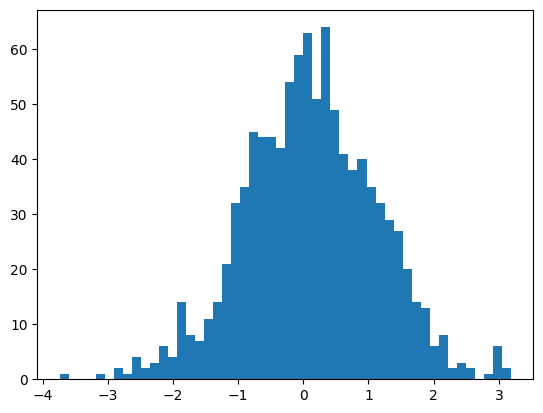

In [2]:
n = 1000
pi = 0.5

# (n, 10)
X_positive = np.random.normal(0, 1, (int(pi*n), 10))
X_negative = np.random.normal(0.2, 1, (int((1-pi)*n), 10))

X = np.concatenate([X_positive, X_negative], axis=0)
Y = np.concatenate([np.ones(int(pi*n)), -1 * np.ones(int((1-pi)*n))], axis=0)

# plot X - histogram of the first feature
plt.hist(X[:, 0], bins=50)
plt.show()

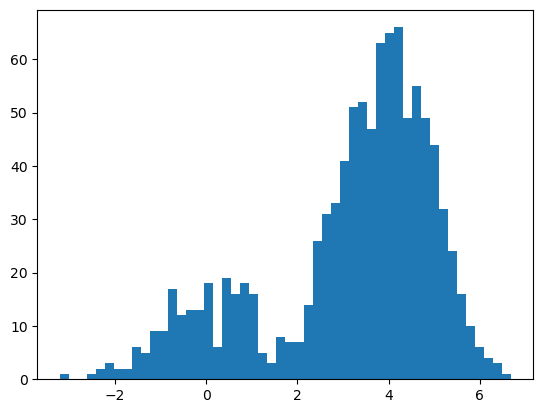

In [3]:
new_pi = 0.2

new_X_positive = np.random.normal(0, 1, (int(new_pi*n), 10))
new_X_negative = np.random.normal(4, 1, (int((1-new_pi)*n), 10))

new_X = np.concatenate([new_X_positive, new_X_negative], axis=0)
new_Y = np.concatenate([np.ones(int(new_pi*n)), -1 * np.ones(int((1-new_pi)*n))], axis=0)

# plot new_X - histogram of the first feature
plt.hist(new_X[:, 0], bins=50)
plt.show()

In [2]:
import sys
sys.path.append('./nnPUss/src/nnPUss')

from dataset import PUDatasetBase, BinaryTargetTransformer, PULabeler, SCAR_SS_Labeler
from dataset_configs import DatasetConfig
from experiment_config import ExperimentConfig
from loss import nnPUccLoss, nnPUssLoss, uPUccLoss, uPUssLoss
from run_experiment import Experiment
from MPE import KM2_estimate

In [4]:
class SyntheticPUDataset(PUDatasetBase):

    N = None
    PI = None
    MEAN = None

    def __init__(
        self,
        root,
        pu_labeler: PULabeler = None,
        target_transformer: BinaryTargetTransformer = BinaryTargetTransformer(
            included_classes=[1, -1], positive_classes=[1]
        ),
        train = True,
        download=True,  # ignored
        random_seed=None,
    ) -> None:

        assert self.N is not None
        assert self.PI is not None
        assert self.MEAN is not None

        self.root = root
        self.train = train
        self.download = download
        self.random_seed = random_seed
        self.target_transformer = target_transformer
        self.pu_labeler = pu_labeler

        self.data = torch.cat(
            [
                torch.normal(0, 1, (int(self.PI * self.N), 10)),
                torch.normal(self.MEAN, 1, (int((1 - self.PI) * self.N), 10)),
            ]
        )
        self.targets = torch.cat(
            [
                torch.ones(int(self.PI * self.N)),
                -1 * torch.ones(int((1 - self.PI) * self.N)),
            ]
        )

        self._convert_to_pu_data()

In [5]:
def create_pu_dataset_class(N, PI, PI_NEW, MEAN):
    """
    Dynamically creates a PU dataset class with given parameters.

    Args:
    - N (int): The number of samples.
    - PI (float): The proportion of class 1 samples.
    - PI_NEW (float): The new proportion of class 1 samples.
    - MEAN (float or array): The mean for the data distribution.

    Returns:
    - tuple: A tuple containing the two dynamically created classes (SyntheticPUDataset_1, SyntheticPUDataset_2).
    """
    # Define class attributes dynamically
    class_attrs_train = {
        'N': N,
        'PI': PI,
        'MEAN': MEAN
    }
    class_attrs_new = {
        'N': N,
        'PI': PI_NEW,
        'MEAN': MEAN
    }
    
    # Dynamically create the new class
    return (type('SyntheticPUDataset_1', (SyntheticPUDataset,), class_attrs_train), 
    type('SyntheticPUDataset_2', (SyntheticPUDataset,), class_attrs_new))

In [17]:
def perform_synthetic_experiment(N, PI, PI_NEW, MEAN):
    """
    Perform a synthetic experiment with the given parameters.

    Args:
    - N (int): The number of samples.
    - PI (float): The proportion of class 1 samples.
    - PI_NEW (float): The new proportion of class 1 samples.
    - MEAN (float or array): The mean for the data distribution.
    """
        
    for exp_number in range(0, 10):

        # Dynamically create the dataset classes
        SyntheticPUDataset_1, SyntheticPUDataset_2 = create_pu_dataset_class(N=N, PI=PI, PI_NEW=PI_NEW, MEAN=MEAN)

        dataset_config = DatasetConfig(
            f"Synthetic2/{N}/{MEAN}/{PI}/{PI_NEW}",
            DatasetClass=SyntheticPUDataset_1,
            PULabelerClass=SCAR_SS_Labeler,
        )

        # Train the model on the first dataset
        label_frequency = 0.5
        PULoss = nnPUssLoss

        experiment_config = ExperimentConfig(
            PULoss=PULoss,
            dataset_config=dataset_config,
            label_frequency=label_frequency,
            exp_number=exp_number,
        )
        print(f"Starting: {experiment_config}...")

        experiment = Experiment(experiment_config)
        experiment.run()

        print(f"Finished: {experiment_config}")

        # Test the model on the second dataset
        new_data = SyntheticPUDataset_2(
            root = "data",
            train=True,
            pu_labeler=SCAR_SS_Labeler(label_frequency=0),
        )
        experiment.test_on_new_data(new_data)

        # Estimate the proportion of positive samples in the new dataset
        # pos = new_data.data[new_data.pu_targets == 1].numpy()
        pos = experiment.train_set.data[experiment.train_set.pu_targets == 1].numpy()
        unl = new_data.data.numpy()
        KM1, est_prior = KM2_estimate(pos, unl)
        print(f"Estimated prior: {est_prior}")

        # Adjust the model's predictions using the estimated prior
        experiment.test_on_new_data_with_new_pi(new_data, pi=SyntheticPUDataset_1.PI, est_new_pi=est_prior, true_new_pi=SyntheticPUDataset_2.PI, km1=KM1)


In [18]:
PI_LIST = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
n = 1000
mean = 0.2

for pi in PI_LIST:
    for pi_new in PI_LIST:
        perform_synthetic_experiment(n, pi, pi_new, mean)

Starting: Synthetic2/1000/0.2/0.1/0.1, c=0.5, exp 0; nnPUss...
Epoch: 1/50
3/3 [========] - 0s 43ms/step - loss: 0.4992 - acc: 0.4919 - test_loss: 0.5114 - test_accuracy: 10.0000 - pos_fraction: 1.0000
Epoch: 2/50
3/3 [========] - 0s 73ms/step - loss: 0.4975 - acc: 0.4845 - test_loss: 0.5141 - test_accuracy: 10.0000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 27ms/step - loss: 0.4951 - acc: 0.4956 - test_loss: 0.5161 - test_accuracy: 10.0000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.4929 - acc: 0.5017 - test_loss: 0.5176 - test_accuracy: 10.2000 - pos_fraction: 0.9980
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4925 - acc: 0.5298 - test_loss: 0.5185 - test_accuracy: 11.1000 - pos_fraction: 0.9870
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.4905 - acc: 0.5184 - test_loss: 0.5190 - test_accuracy: 13.1000 - pos_fraction: 0.9610
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4886 - acc: 0.5235 - test_loss: 0.5191 - test_accur

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 45ms/step - loss: 0.4785 - acc: 0.6340 - test_loss: 0.4629 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 35ms/step - loss: 0.4768 - acc: 0.6344 - test_loss: 0.4577 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4756 - acc: 0.6427 - test_loss: 0.4533 - test_accuracy: 89.9000 - pos_fraction: 1.0000e-03


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4736 - acc: 0.6450 - test_loss: 0.4497 - test_accuracy: 89.5000 - pos_fraction: 0.0050
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4730 - acc: 0.6435 - test_loss: 0.4470 - test_accuracy: 89.0000 - pos_fraction: 0.0100
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4711 - acc: 0.6529 - test_loss: 0.4450 - test_accuracy: 88.5000 - pos_fraction: 0.0190
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4692 - acc: 0.6568 - test_loss: 0.4438 - test_accuracy: 86.5000 - pos_fraction: 0.0430
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.4678 - acc: 0.6627 - test_loss: 0.4432 - test_accuracy: 84.8000 - pos_fraction: 0.0680
Epoch: 12/50
3/3 [========] - 0s 22ms/step - loss: 0.4664 - acc: 0.6610 - test_loss: 0.4431 - test_accuracy: 82.8000 - pos_fraction: 0.0980
Epoch: 13/50
3/3 [========] - 0s 18ms/step - loss: 0.4659 - acc: 0.6758 - test_loss: 0.4435 - test_accuracy: 81.5000 - pos_fraction: 0.1210
Epoch: 14/50
3/3 [=====

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 38ms/step - loss: 0.4827 - acc: 0.6039 - test_loss: 0.4751 - test_accuracy: 89.9000 - pos_fraction: 1.0000e-03
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.4808 - acc: 0.6170 - test_loss: 0.4708 - test_accuracy: 90.0000 - pos_fraction: 0.0020
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.4798 - acc: 0.6138 - test_loss: 0.4670 - test_accuracy: 89.3000 - pos_fraction: 0.0090
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4788 - acc: 0.6264 - test_loss: 0.4636 - test_accuracy: 88.4000 - pos_fraction: 0.0180
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4766 - acc: 0.6291 - test_loss: 0.4607 - test_accuracy: 87.5000 - pos_fraction: 0.0290
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4754 - acc: 0.6295 - test_loss: 0.4583 - test_accuracy: 86.1000 - pos_fraction: 0.0430
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4745 - acc: 0.6359 - test_loss: 0.4563 - test_accuracy: 84.6000 - pos_fraction: 0.0580
Epoch: 10/50
3/3 [========] - 0s 20

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4580 - acc: 0.7011 - test_loss: 0.4624 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.4562 - acc: 0.7049 - test_loss: 0.4574 - test_accuracy: 89.9000 - pos_fraction: 1.0000e-03
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4550 - acc: 0.7085 - test_loss: 0.4532 - test_accuracy: 89.9000 - pos_fraction: 0.0030
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4539 - acc: 0.7266

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4529 - acc: 0.7157 - test_loss: 0.4497 - test_accuracy: 89.6000 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4517 - acc: 0.7202 - test_loss: 0.4470 - test_accuracy: 89.0000 - pos_fraction: 0.0160
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4498 - acc: 0.7159 - test_loss: 0.4451 - test_accuracy: 87.9000 - pos_fraction: 0.0290
Epoch: 10/50
3/3 [========] - 0s 19ms/step - loss: 0.4484 - acc: 0.7193 - test_loss: 0.4437 - test_accuracy: 86.8000 - pos_fraction: 0.0460
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.4467 - acc: 0.7291 - test_loss: 0.4428 - test_accuracy: 85.7000 - pos_fraction: 0.0570
Epoch: 12/50
3/3 [========] - 0s 20ms/step - loss: 0.4455 - acc: 0.7252 - test_loss: 0.4422 - test_accuracy: 84.9000 - pos_fraction: 0.0690
Epoch: 13/50
3/3 [========] - 0s 19ms/step - loss: 0.4438 - acc: 0.7340 - test_loss: 0.4416 - test_accuracy: 82.7000 - pos_fraction: 0.0930
Epoch: 14/50
3/3 [========] - 0s 21

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 42ms/step - loss: 0.4435 - acc: 0.7759 - test_loss: 0.4746 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 33ms/step - loss: 0.4420 - acc: 0.7806 - test_loss: 0.4694 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.4402 - acc: 0.7858 - test_loss: 0.4647 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4369 - acc: 0.7773

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 18ms/step - loss: 0.4391 - acc: 0.7924 - test_loss: 0.4605 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.4372 - acc: 0.7976 - test_loss: 0.4566 - test_accuracy: 89.8000 - pos_fraction: 0.0020
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4360 - acc: 0.8093 - test_loss: 0.4529 - test_accuracy: 89.6000 - pos_fraction: 0.0040
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4345 - acc: 0.8089 - test_loss: 0.4495 - test_accuracy: 89.0000 - pos_fraction: 0.0100


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 10/50
3/3 [========] - 0s 35ms/step - loss: 0.4332 - acc: 0.8080 - test_loss: 0.4463 - test_accuracy: 88.7000 - pos_fraction: 0.0130
Epoch: 11/50
3/3 [========] - 0s 25ms/step - loss: 0.4315 - acc: 0.8114 - test_loss: 0.4432 - test_accuracy: 88.0000 - pos_fraction: 0.0200
Epoch: 12/50
3/3 [========] - 0s 19ms/step - loss: 0.4301 - acc: 0.8190 - test_loss: 0.4402 - test_accuracy: 86.8000 - pos_fraction: 0.0320
Epoch: 13/50
3/3 [========] - 0s 19ms/step - loss: 0.4289 - acc: 0.8157 - test_loss: 0.4373 - test_accuracy: 85.9000 - pos_fraction: 0.0430
Epoch: 14/50
3/3 [========] - 0s 22ms/step - loss: 0.4280 - acc: 0.8251 - test_loss: 0.4344 - test_accuracy: 85.0000 - pos_fraction: 0.0520
Epoch: 15/50
3/3 [========] - 0s 20ms/step - loss: 0.4264 - acc: 0.8291 - test_loss: 0.4317 - test_accuracy: 84.9000 - pos_fraction: 0.0610
Epoch: 16/50
3/3 [========] - 0s 17ms/step - loss: 0.4248 - acc: 0.8229 - test_loss: 0.4292 - test_accuracy: 83.8000 - pos_fraction: 0.0720
Epoch: 17/50
3/3 [==

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.4951 - acc: 0.4956 - test_loss: 0.5161 - test_accuracy: 10.0000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.4929 - acc: 0.5017 - test_loss: 0.5176 - test_accuracy: 10.2000 - pos_fraction: 0.9980
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4925 - acc: 0.5298 - test_loss: 0.5185 - test_accuracy: 11.1000 - pos_fraction: 0.9870
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4905 - acc: 0.5184 - test_loss: 0.5190 - test_accuracy: 13.1000 - pos_fraction: 0.9610
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.4886 - acc: 0.5235 - test_loss: 0.5191 - test_accuracy: 15.7000 - pos_fraction: 0.9230
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4873 - acc: 0.5408 - test_loss: 0.5187 - test_accuracy: 19.8000 - pos_fraction: 0.8800
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4857 - acc: 0.5461 - test_loss: 0.5180 - test_accuracy: 24.0000 - pos_fraction: 0.8360
Epoch: 10/50
3/3 [========] - 0s 20ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.4785 - acc: 0.6340 - test_loss: 0.4629 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.4768 - acc: 0.6344 - test_loss: 0.4577 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4756 - acc: 0.6427 - test_loss: 0.4533 - test_accuracy: 89.9000 - pos_fraction: 1.0000e-03
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4753 - acc: 0.6465

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 21ms/step - loss: 0.4736 - acc: 0.6450 - test_loss: 0.4497 - test_accuracy: 89.5000 - pos_fraction: 0.0050
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4730 - acc: 0.6435 - test_loss: 0.4470 - test_accuracy: 89.0000 - pos_fraction: 0.0100
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4711 - acc: 0.6529 - test_loss: 0.4450 - test_accuracy: 88.5000 - pos_fraction: 0.0190
Epoch: 10/50
3/3 [========] - 0s 24ms/step - loss: 0.4692 - acc: 0.6568 - test_loss: 0.4438 - test_accuracy: 86.5000 - pos_fraction: 0.0430
Epoch: 11/50
3/3 [========] - 0s 31ms/step - loss: 0.4678 - acc: 0.6627 - test_loss: 0.4432 - test_accuracy: 84.8000 - pos_fraction: 0.0680
Epoch: 12/50
3/3 [========] - 0s 27ms/step - loss: 0.4664 - acc: 0.6610 - test_loss: 0.4431 - test_accuracy: 82.8000 - pos_fraction: 0.0980
Epoch: 13/50
3/3 [========] - 0s 18ms/step - loss: 0.4659 - acc: 0.6758 - test_loss: 0.4435 - test_accuracy: 81.5000 - pos_fraction: 0.1210
Epoch: 14/50
3/3 [========] - 0s 15

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4808 - acc: 0.6170 - test_loss: 0.4708 - test_accuracy: 90.0000 - pos_fraction: 0.0020
Epoch: 5/50
3/3 [========] - 0s 35ms/step - loss: 0.4798 - acc: 0.6138 - test_loss: 0.4670 - test_accuracy: 89.3000 - pos_fraction: 0.0090
Epoch: 6/50
3/3 [========] - 0s 31ms/step - loss: 0.4788 - acc: 0.6264 - test_loss: 0.4636 - test_accuracy: 88.4000 - pos_fraction: 0.0180
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4766 - acc: 0.6291 - test_loss: 0.4607 - test_accuracy: 87.5000 - pos_fraction: 0.0290
Epoch: 8/50
3/3 [========] - 0s 17ms/step - loss: 0.4754 - acc: 0.6295 - test_loss: 0.4583 - test_accuracy: 86.1000 - pos_fraction: 0.0430
Epoch: 9/50
3/3 [========] - 0s 17ms/step - loss: 0.4745 - acc: 0.6359 - test_loss: 0.4563 - test_accuracy: 84.6000 - pos_fraction: 0.0580
Epoch: 10/50
3/3 [========] - 0s 18ms/step - loss: 0.4729 - acc: 0.6390 - test_loss: 0.4549 - test_accuracy: 83.2000 - pos_fraction: 0.0760
Epoch: 11/50
3/3 [========] - 0s 16ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.4580 - acc: 0.7011 - test_loss: 0.4624 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.4562 - acc: 0.7049 - test_loss: 0.4574 - test_accuracy: 89.9000 - pos_fraction: 1.0000e-03
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4550 - acc: 0.7085 - test_loss: 0.4532 - test_accuracy: 89.9000 - pos_fraction: 0.0030
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4539 - acc: 0.7266

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4529 - acc: 0.7157 - test_loss: 0.4497 - test_accuracy: 89.6000 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4517 - acc: 0.7202 - test_loss: 0.4470 - test_accuracy: 89.0000 - pos_fraction: 0.0160
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4498 - acc: 0.7159 - test_loss: 0.4451 - test_accuracy: 87.9000 - pos_fraction: 0.0290
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4484 - acc: 0.7193 - test_loss: 0.4437 - test_accuracy: 86.8000 - pos_fraction: 0.0460
Epoch: 11/50
3/3 [========] - 0s 18ms/step - loss: 0.4467 - acc: 0.7291 - test_loss: 0.4428 - test_accuracy: 85.7000 - pos_fraction: 0.0570
Epoch: 12/50
3/3 [========] - 0s 26ms/step - loss: 0.4455 - acc: 0.7252 - test_loss: 0.4422 - test_accuracy: 84.9000 - pos_fraction: 0.0690
Epoch: 13/50
3/3 [========] - 0s 19ms/step - loss: 0.4438 - acc: 0.7340 - test_loss: 0.4416 - test_accuracy: 82.7000 - pos_fraction: 0.0930
Epoch: 14/50
3/3 [========] - 0s 20

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4420 - acc: 0.7806 - test_loss: 0.4694 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.4402 - acc: 0.7858 - test_loss: 0.4647 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 18ms/step - loss: 0.4391 - acc: 0.7924 - test_loss: 0.4605 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 17ms/step - loss: 0.4372 - acc: 0.7976 - test_loss: 0.4566 - test_accuracy: 89.8000 - pos_fraction: 0.0020
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4351 - acc: 0.7969

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 18ms/step - loss: 0.4360 - acc: 0.8093 - test_loss: 0.4529 - test_accuracy: 89.6000 - pos_fraction: 0.0040
Epoch: 9/50
3/3 [========] - 0s 17ms/step - loss: 0.4345 - acc: 0.8089 - test_loss: 0.4495 - test_accuracy: 89.0000 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 19ms/step - loss: 0.4332 - acc: 0.8080 - test_loss: 0.4463 - test_accuracy: 88.7000 - pos_fraction: 0.0130
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.4315 - acc: 0.8114 - test_loss: 0.4432 - test_accuracy: 88.0000 - pos_fraction: 0.0200
Epoch: 12/50
3/3 [========] - 0s 18ms/step - loss: 0.4301 - acc: 0.8190 - test_loss: 0.4402 - test_accuracy: 86.8000 - pos_fraction: 0.0320
Epoch: 13/50
3/3 [========] - 0s 16ms/step - loss: 0.4289 - acc: 0.8157 - test_loss: 0.4373 - test_accuracy: 85.9000 - pos_fraction: 0.0430
Epoch: 14/50
3/3 [========] - 0s 18ms/step - loss: 0.4280 - acc: 0.8251 - test_loss: 0.4344 - test_accuracy: 85.0000 - pos_fraction: 0.0520
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.4951 - acc: 0.4956 - test_loss: 0.5161 - test_accuracy: 10.0000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.4929 - acc: 0.5017 - test_loss: 0.5176 - test_accuracy: 10.2000 - pos_fraction: 0.9980
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.4925 - acc: 0.5298 - test_loss: 0.5185 - test_accuracy: 11.1000 - pos_fraction: 0.9870
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4905 - acc: 0.5184 - test_loss: 0.5190 - test_accuracy: 13.1000 - pos_fraction: 0.9610
Epoch: 7/50
3/3 [========] - 0s 34ms/step - loss: 0.4886 - acc: 0.5235 - test_loss: 0.5191 - test_accuracy: 15.7000 - pos_fraction: 0.9230
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4873 - acc: 0.5408 - test_loss: 0.5187 - test_accuracy: 19.8000 - pos_fraction: 0.8800
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4857 - acc: 0.5461 - test_loss: 0.5180 - test_accuracy: 24.0000 - pos_fraction: 0.8360
Epoch: 10/50
3/3 [========] - 0s 20ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 20ms/step - loss: 0.4785 - acc: 0.6340 - test_loss: 0.4629 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.4768 - acc: 0.6344 - test_loss: 0.4577 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4756 - acc: 0.6427 - test_loss: 0.4533 - test_accuracy: 89.9000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4736 - acc: 0.6450 - test_loss: 0.4497 - test_accuracy: 89.5000 - pos_fraction: 0.0050


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4730 - acc: 0.6435 - test_loss: 0.4470 - test_accuracy: 89.0000 - pos_fraction: 0.0100
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4711 - acc: 0.6529 - test_loss: 0.4450 - test_accuracy: 88.5000 - pos_fraction: 0.0190
Epoch: 10/50
3/3 [========] - 0s 18ms/step - loss: 0.4692 - acc: 0.6568 - test_loss: 0.4438 - test_accuracy: 86.5000 - pos_fraction: 0.0430
Epoch: 11/50
3/3 [========] - 0s 18ms/step - loss: 0.4678 - acc: 0.6627 - test_loss: 0.4432 - test_accuracy: 84.8000 - pos_fraction: 0.0680
Epoch: 12/50
3/3 [========] - 0s 21ms/step - loss: 0.4664 - acc: 0.6610 - test_loss: 0.4431 - test_accuracy: 82.8000 - pos_fraction: 0.0980
Epoch: 13/50
3/3 [========] - 0s 20ms/step - loss: 0.4659 - acc: 0.6758 - test_loss: 0.4435 - test_accuracy: 81.5000 - pos_fraction: 0.1210
Epoch: 14/50
3/3 [========] - 0s 20ms/step - loss: 0.4631 - acc: 0.6767 - test_loss: 0.4441 - test_accuracy: 79.8000 - pos_fraction: 0.1500
Epoch: 15/50
3/3 [====

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4808 - acc: 0.6170 - test_loss: 0.4708 - test_accuracy: 90.0000 - pos_fraction: 0.0020
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.4798 - acc: 0.6138 - test_loss: 0.4670 - test_accuracy: 89.3000 - pos_fraction: 0.0090
Epoch: 6/50
3/3 [========] - 0s 18ms/step - loss: 0.4788 - acc: 0.6264 - test_loss: 0.4636 - test_accuracy: 88.4000 - pos_fraction: 0.0180
Epoch: 7/50
3/3 [========] - 0s 17ms/step - loss: 0.4766 - acc: 0.6291 - test_loss: 0.4607 - test_accuracy: 87.5000 - pos_fraction: 0.0290
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.4754 - acc: 0.6295 - test_loss: 0.4583 - test_accuracy: 86.1000 - pos_fraction: 0.0430
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4745 - acc: 0.6359 - test_loss: 0.4563 - test_accuracy: 84.6000 - pos_fraction: 0.0580
Epoch: 10/50
3/3 [========] - 0s 29ms/step - loss: 0.4729 - acc: 0.6390 - test_loss: 0.4549 - test_accuracy: 83.2000 - pos_fraction: 0.0760
Epoch: 11/50
3/3 [========] - 0s 32ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 45ms/step - loss: 0.4595 - acc: 0.6992 - test_loss: 0.4682 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 35ms/step - loss: 0.4580 - acc: 0.7011 - test_loss: 0.4624 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4562 - acc: 0.7049 - test_loss: 0.4574 - test_accuracy: 89.9000 - pos_fraction: 1.0000e-03
Epoch: 6/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 26ms/step - loss: 0.4550 - acc: 0.7085 - test_loss: 0.4532 - test_accuracy: 89.9000 - pos_fraction: 0.0030
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4529 - acc: 0.7157 - test_loss: 0.4497 - test_accuracy: 89.6000 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.4517 - acc: 0.7202 - test_loss: 0.4470 - test_accuracy: 89.0000 - pos_fraction: 0.0160
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4498 - acc: 0.7159 - test_loss: 0.4451 - test_accuracy: 87.9000 - pos_fraction: 0.0290
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.4484 - acc: 0.7193 - test_loss: 0.4437 - test_accuracy: 86.8000 - pos_fraction: 0.0460
Epoch: 11/50
3/3 [========] - 0s 25ms/step - loss: 0.4467 - acc: 0.7291 - test_loss: 0.4428 - test_accuracy: 85.7000 - pos_fraction: 0.0570
Epoch: 12/50
3/3 [========] - 0s 26ms/step - loss: 0.4455 - acc: 0.7252 - test_loss: 0.4422 - test_accuracy: 84.9000 - pos_fraction: 0.0690
Epoch: 13/50
3/3 [========] - 0s 21m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4420 - acc: 0.7806 - test_loss: 0.4694 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4402 - acc: 0.7858 - test_loss: 0.4647 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4391 - acc: 0.7924 - test_loss: 0.4605 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4350 - acc: 0.8145

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 21ms/step - loss: 0.4372 - acc: 0.7976 - test_loss: 0.4566 - test_accuracy: 89.8000 - pos_fraction: 0.0020
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4360 - acc: 0.8093 - test_loss: 0.4529 - test_accuracy: 89.6000 - pos_fraction: 0.0040
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4345 - acc: 0.8089 - test_loss: 0.4495 - test_accuracy: 89.0000 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 16ms/step - loss: 0.4332 - acc: 0.8080 - test_loss: 0.4463 - test_accuracy: 88.7000 - pos_fraction: 0.0130
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.4315 - acc: 0.8114 - test_loss: 0.4432 - test_accuracy: 88.0000 - pos_fraction: 0.0200
Epoch: 12/50
3/3 [========] - 0s 17ms/step - loss: 0.4301 - acc: 0.8190 - test_loss: 0.4402 - test_accuracy: 86.8000 - pos_fraction: 0.0320
Epoch: 13/50
3/3 [========] - 0s 16ms/step - loss: 0.4289 - acc: 0.8157 - test_loss: 0.4373 - test_accuracy: 85.9000 - pos_fraction: 0.0430
Epoch: 14/50
3/3 [========] - 0s 17

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.4975 - acc: 0.4845 - test_loss: 0.5141 - test_accuracy: 10.0000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 21ms/step - loss: 0.4951 - acc: 0.4956 - test_loss: 0.5161 - test_accuracy: 10.0000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 21ms/step - loss: 0.4929 - acc: 0.5017 - test_loss: 0.5176 - test_accuracy: 10.2000 - pos_fraction: 0.9980
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.4925 - acc: 0.5298 - test_loss: 0.5185 - test_accuracy: 11.1000 - pos_fraction: 0.9870
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4905 - acc: 0.5184 - test_loss: 0.5190 - test_accuracy: 13.1000 - pos_fraction: 0.9610
Epoch: 7/50
3/3 [========] - 0s 18ms/step - loss: 0.4886 - acc: 0.5235 - test_loss: 0.5191 - test_accuracy: 15.7000 - pos_fraction: 0.9230
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4873 - acc: 0.5408 - test_loss: 0.5187 - test_accuracy: 19.8000 - pos_fraction: 0.8800
Epoch: 9/50
3/3 [========] - 0s 20ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

3/3 [========] - 0s 17ms/step - loss: 0.4768 - acc: 0.6344 - test_loss: 0.4577 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 18ms/step - loss: 0.4756 - acc: 0.6427 - test_loss: 0.4533 - test_accuracy: 89.9000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 17ms/step - loss: 0.4736 - acc: 0.6450 - test_loss: 0.4497 - test_accuracy: 89.5000 - pos_fraction: 0.0050
Epoch: 8/50
3/3 [========] - 0s 17ms/step - loss: 0.4730 - acc: 0.6435 - test_loss: 0.4470 - test_accuracy: 89.0000 - pos_fraction: 0.0100
Epoch: 9/50
1/3 [=>......] - ETA: 0s - loss: 0.4698 - acc: 0.6562

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 15ms/step - loss: 0.4711 - acc: 0.6529 - test_loss: 0.4450 - test_accuracy: 88.5000 - pos_fraction: 0.0190
Epoch: 10/50
3/3 [========] - 0s 15ms/step - loss: 0.4692 - acc: 0.6568 - test_loss: 0.4438 - test_accuracy: 86.5000 - pos_fraction: 0.0430
Epoch: 11/50
3/3 [========] - 0s 18ms/step - loss: 0.4678 - acc: 0.6627 - test_loss: 0.4432 - test_accuracy: 84.8000 - pos_fraction: 0.0680
Epoch: 12/50
3/3 [========] - 0s 14ms/step - loss: 0.4664 - acc: 0.6610 - test_loss: 0.4431 - test_accuracy: 82.8000 - pos_fraction: 0.0980
Epoch: 13/50
3/3 [========] - 0s 16ms/step - loss: 0.4659 - acc: 0.6758 - test_loss: 0.4435 - test_accuracy: 81.5000 - pos_fraction: 0.1210
Epoch: 14/50
3/3 [========] - 0s 20ms/step - loss: 0.4631 - acc: 0.6767 - test_loss: 0.4441 - test_accuracy: 79.8000 - pos_fraction: 0.1500
Epoch: 15/50
3/3 [========] - 0s 22ms/step - loss: 0.4621 - acc: 0.6750 - test_loss: 0.4449 - test_accuracy: 77.5000 - pos_fraction: 0.1750
Epoch: 16/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.4808 - acc: 0.6170 - test_loss: 0.4708 - test_accuracy: 90.0000 - pos_fraction: 0.0020
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4798 - acc: 0.6138 - test_loss: 0.4670 - test_accuracy: 89.3000 - pos_fraction: 0.0090
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4788 - acc: 0.6264 - test_loss: 0.4636 - test_accuracy: 88.4000 - pos_fraction: 0.0180
Epoch: 7/50
3/3 [========] - 0s 30ms/step - loss: 0.4766 - acc: 0.6291 - test_loss: 0.4607 - test_accuracy: 87.5000 - pos_fraction: 0.0290
Epoch: 8/50
3/3 [========] - 0s 30ms/step - loss: 0.4754 - acc: 0.6295 - test_loss: 0.4583 - test_accuracy: 86.1000 - pos_fraction: 0.0430
Epoch: 9/50
3/3 [========] - 0s 29ms/step - loss: 0.4745 - acc: 0.6359 - test_loss: 0.4563 - test_accuracy: 84.6000 - pos_fraction: 0.0580
Epoch: 10/50
3/3 [========] - 0s 27ms/step - loss: 0.4729 - acc: 0.6390 - test_loss: 0.4549 - test_accuracy: 83.2000 - pos_fraction: 0.0760
Epoch: 11/50
3/3 [========

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 21ms/step - loss: 0.4580 - acc: 0.7011 - test_loss: 0.4624 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4562 - acc: 0.7049 - test_loss: 0.4574 - test_accuracy: 89.9000 - pos_fraction: 1.0000e-03
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4611 - acc: 0.6895

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 39ms/step - loss: 0.4550 - acc: 0.7085 - test_loss: 0.4532 - test_accuracy: 89.9000 - pos_fraction: 0.0030
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.4529 - acc: 0.7157 - test_loss: 0.4497 - test_accuracy: 89.6000 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 17ms/step - loss: 0.4517 - acc: 0.7202 - test_loss: 0.4470 - test_accuracy: 89.0000 - pos_fraction: 0.0160
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4498 - acc: 0.7159 - test_loss: 0.4451 - test_accuracy: 87.9000 - pos_fraction: 0.0290
Epoch: 10/50
3/3 [========] - 0s 16ms/step - loss: 0.4484 - acc: 0.7193 - test_loss: 0.4437 - test_accuracy: 86.8000 - pos_fraction: 0.0460
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.4467 - acc: 0.7291 - test_loss: 0.4428 - test_accuracy: 85.7000 - pos_fraction: 0.0570
Epoch: 12/50
3/3 [========] - 0s 16ms/step - loss: 0.4455 - acc: 0.7252 - test_loss: 0.4422 - test_accuracy: 84.9000 - pos_fraction: 0.0690
Epoch: 13/50
3/3 [========] - 0s 16m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4420 - acc: 0.7806 - test_loss: 0.4694 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.4402 - acc: 0.7858 - test_loss: 0.4647 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4391 - acc: 0.7924 - test_loss: 0.4605 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4350 - acc: 0.8145

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 19ms/step - loss: 0.4372 - acc: 0.7976 - test_loss: 0.4566 - test_accuracy: 89.8000 - pos_fraction: 0.0020
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4360 - acc: 0.8093 - test_loss: 0.4529 - test_accuracy: 89.6000 - pos_fraction: 0.0040
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4345 - acc: 0.8089 - test_loss: 0.4495 - test_accuracy: 89.0000 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4332 - acc: 0.8080 - test_loss: 0.4463 - test_accuracy: 88.7000 - pos_fraction: 0.0130
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.4315 - acc: 0.8114 - test_loss: 0.4432 - test_accuracy: 88.0000 - pos_fraction: 0.0200
Epoch: 12/50
3/3 [========] - 0s 19ms/step - loss: 0.4301 - acc: 0.8190 - test_loss: 0.4402 - test_accuracy: 86.8000 - pos_fraction: 0.0320
Epoch: 13/50
3/3 [========] - 0s 20ms/step - loss: 0.4289 - acc: 0.8157 - test_loss: 0.4373 - test_accuracy: 85.9000 - pos_fraction: 0.0430
Epoch: 14/50
3/3 [========] - 0s 19

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 24ms/step - loss: 0.4951 - acc: 0.4956 - test_loss: 0.5161 - test_accuracy: 10.0000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.4929 - acc: 0.5017 - test_loss: 0.5176 - test_accuracy: 10.2000 - pos_fraction: 0.9980
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.4925 - acc: 0.5298 - test_loss: 0.5185 - test_accuracy: 11.1000 - pos_fraction: 0.9870
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.4905 - acc: 0.5184 - test_loss: 0.5190 - test_accuracy: 13.1000 - pos_fraction: 0.9610
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4886 - acc: 0.5235 - test_loss: 0.5191 - test_accuracy: 15.7000 - pos_fraction: 0.9230
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4873 - acc: 0.5408 - test_loss: 0.5187 - test_accuracy: 19.8000 - pos_fraction: 0.8800
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4857 - acc: 0.5461 - test_loss: 0.5180 - test_accuracy: 24.0000 - pos_fraction: 0.8360
Epoch: 10/50
3/3 [========] - 0s 21ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 24ms/step - loss: 0.5385 - acc: 0.2784 - test_loss: 0.4942 - test_accuracy: 66.0000 - pos_fraction: 0.3040
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.5373 - acc: 0.2966 - test_loss: 0.4963 - test_accuracy: 52.7000 - pos_fraction: 0.4770
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.5355 - acc: 0.3019 - test_loss: 0.4984 - test_accuracy: 44.9000 - pos_fraction: 0.5830
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.5340 - acc: 0.3187 - test_loss: 0.5005 - test_accuracy: 40.6000 - pos_fraction: 0.6400
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.5322 - acc: 0.3222 - test_loss: 0.5025 - test_accuracy: 38.6000 - pos_fraction: 0.6640
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.5314 - acc: 0.3272 - test_loss: 0.5047 - test_accuracy: 37.8000 - pos_fraction: 0.6800
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.5297 - acc: 0.3404 - test_loss: 0.5070 - test_accuracy: 37.5000 - pos_fraction: 0.6850
Epoch: 10/50
3/3 [========] - 0s 18ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 24ms/step - loss: 0.4785 - acc: 0.6340 - test_loss: 0.4629 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4768 - acc: 0.6344 - test_loss: 0.4577 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 31ms/step - loss: 0.4756 - acc: 0.6427 - test_loss: 0.4533 - test_accuracy: 89.9000 - pos_fraction: 1.0000e-03


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 7/50
3/3 [========] - 0s 89ms/step - loss: 0.4736 - acc: 0.6450 - test_loss: 0.4497 - test_accuracy: 89.5000 - pos_fraction: 0.0050
Epoch: 8/50
3/3 [========] - 0s 38ms/step - loss: 0.4730 - acc: 0.6435 - test_loss: 0.4470 - test_accuracy: 89.0000 - pos_fraction: 0.0100
Epoch: 9/50
3/3 [========] - 0s 31ms/step - loss: 0.4711 - acc: 0.6529 - test_loss: 0.4450 - test_accuracy: 88.5000 - pos_fraction: 0.0190
Epoch: 10/50
3/3 [========] - 0s 24ms/step - loss: 0.4692 - acc: 0.6568 - test_loss: 0.4438 - test_accuracy: 86.5000 - pos_fraction: 0.0430
Epoch: 11/50
3/3 [========] - 0s 32ms/step - loss: 0.4678 - acc: 0.6627 - test_loss: 0.4432 - test_accuracy: 84.8000 - pos_fraction: 0.0680
Epoch: 12/50
3/3 [========] - 0s 26ms/step - loss: 0.4664 - acc: 0.6610 - test_loss: 0.4431 - test_accuracy: 82.8000 - pos_fraction: 0.0980
Epoch: 13/50
3/3 [========] - 0s 33ms/step - loss: 0.4659 - acc: 0.6758 - test_loss: 0.4435 - test_accuracy: 81.5000 - pos_fraction: 0.1210
Epoch: 14/50
3/3 [=====

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4841 - acc: 0.6001 - test_loss: 0.4797 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 26ms/step - loss: 0.4827 - acc: 0.6039 - test_loss: 0.4751 - test_accuracy: 89.9000 - pos_fraction: 1.0000e-03
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.4808 - acc: 0.6170 - test_loss: 0.4708 - test_accuracy: 90.0000 - pos_fraction: 0.0020
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4797 - acc: 0.6211

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.4798 - acc: 0.6138 - test_loss: 0.4670 - test_accuracy: 89.3000 - pos_fraction: 0.0090
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.4788 - acc: 0.6264 - test_loss: 0.4636 - test_accuracy: 88.4000 - pos_fraction: 0.0180
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4766 - acc: 0.6291 - test_loss: 0.4607 - test_accuracy: 87.5000 - pos_fraction: 0.0290
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4754 - acc: 0.6295 - test_loss: 0.4583 - test_accuracy: 86.1000 - pos_fraction: 0.0430
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4745 - acc: 0.6359 - test_loss: 0.4563 - test_accuracy: 84.6000 - pos_fraction: 0.0580
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4729 - acc: 0.6390 - test_loss: 0.4549 - test_accuracy: 83.2000 - pos_fraction: 0.0760
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.4718 - acc: 0.6398 - test_loss: 0.4538 - test_accuracy: 82.3000 - pos_fraction: 0.0890
Epoch: 12/50
3/3 [========] - 0s 23ms

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4580 - acc: 0.7011 - test_loss: 0.4624 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 19ms/step - loss: 0.4562 - acc: 0.7049 - test_loss: 0.4574 - test_accuracy: 89.9000 - pos_fraction: 1.0000e-03
Epoch: 6/50
3/3 [========] - 0s 17ms/step - loss: 0.4550 - acc: 0.7085 - test_loss: 0.4532 - test_accuracy: 89.9000 - pos_fraction: 0.0030
Epoch: 7/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 66ms/step - loss: 0.4529 - acc: 0.7157 - test_loss: 0.4497 - test_accuracy: 89.6000 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.4517 - acc: 0.7202 - test_loss: 0.4470 - test_accuracy: 89.0000 - pos_fraction: 0.0160
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4498 - acc: 0.7159 - test_loss: 0.4451 - test_accuracy: 87.9000 - pos_fraction: 0.0290
Epoch: 10/50
3/3 [========] - 0s 19ms/step - loss: 0.4484 - acc: 0.7193 - test_loss: 0.4437 - test_accuracy: 86.8000 - pos_fraction: 0.0460
Epoch: 11/50
3/3 [========] - 0s 35ms/step - loss: 0.4467 - acc: 0.7291 - test_loss: 0.4428 - test_accuracy: 85.7000 - pos_fraction: 0.0570
Epoch: 12/50
3/3 [========] - 0s 17ms/step - loss: 0.4455 - acc: 0.7252 - test_loss: 0.4422 - test_accuracy: 84.9000 - pos_fraction: 0.0690
Epoch: 13/50
3/3 [========] - 0s 20ms/step - loss: 0.4438 - acc: 0.7340 - test_loss: 0.4416 - test_accuracy: 82.7000 - pos_fraction: 0.0930
Epoch: 14/50
3/3 [========] - 0s 19

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 26ms/step - loss: 0.4420 - acc: 0.7806 - test_loss: 0.4694 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.4402 - acc: 0.7858 - test_loss: 0.4647 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.4391 - acc: 0.7924 - test_loss: 0.4605 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4350 - acc: 0.8145

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 20ms/step - loss: 0.4372 - acc: 0.7976 - test_loss: 0.4566 - test_accuracy: 89.8000 - pos_fraction: 0.0020
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4360 - acc: 0.8093 - test_loss: 0.4529 - test_accuracy: 89.6000 - pos_fraction: 0.0040
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4345 - acc: 0.8089 - test_loss: 0.4495 - test_accuracy: 89.0000 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4332 - acc: 0.8080 - test_loss: 0.4463 - test_accuracy: 88.7000 - pos_fraction: 0.0130
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.4315 - acc: 0.8114 - test_loss: 0.4432 - test_accuracy: 88.0000 - pos_fraction: 0.0200
Epoch: 12/50
3/3 [========] - 0s 18ms/step - loss: 0.4301 - acc: 0.8190 - test_loss: 0.4402 - test_accuracy: 86.8000 - pos_fraction: 0.0320
Epoch: 13/50
3/3 [========] - 0s 19ms/step - loss: 0.4289 - acc: 0.8157 - test_loss: 0.4373 - test_accuracy: 85.9000 - pos_fraction: 0.0430
Epoch: 14/50
3/3 [========] - 0s 24

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4951 - acc: 0.4956 - test_loss: 0.5161 - test_accuracy: 10.0000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 23ms/step - loss: 0.4929 - acc: 0.5017 - test_loss: 0.5176 - test_accuracy: 10.2000 - pos_fraction: 0.9980
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4925 - acc: 0.5298 - test_loss: 0.5185 - test_accuracy: 11.1000 - pos_fraction: 0.9870
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4905 - acc: 0.5184 - test_loss: 0.5190 - test_accuracy: 13.1000 - pos_fraction: 0.9610
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.4886 - acc: 0.5235 - test_loss: 0.5191 - test_accuracy: 15.7000 - pos_fraction: 0.9230
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4873 - acc: 0.5408 - test_loss: 0.5187 - test_accuracy: 19.8000 - pos_fraction: 0.8800
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4857 - acc: 0.5461 - test_loss: 0.5180 - test_accuracy: 24.0000 - pos_fraction: 0.8360
Epoch: 10/50
3/3 [========] - 0s 27ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 20ms/step - loss: 0.5400 - acc: 0.2829 - test_loss: 0.4917 - test_accuracy: 84.3000 - pos_fraction: 0.0730
Epoch: 3/50
3/3 [========] - 0s 20ms/step - loss: 0.5385 - acc: 0.2784 - test_loss: 0.4942 - test_accuracy: 66.0000 - pos_fraction: 0.3040
Epoch: 4/50
3/3 [========] - 0s 19ms/step - loss: 0.5373 - acc: 0.2966 - test_loss: 0.4963 - test_accuracy: 52.7000 - pos_fraction: 0.4770
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.5355 - acc: 0.3019 - test_loss: 0.4984 - test_accuracy: 44.9000 - pos_fraction: 0.5830
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.5340 - acc: 0.3187 - test_loss: 0.5005 - test_accuracy: 40.6000 - pos_fraction: 0.6400
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.5322 - acc: 0.3222 - test_loss: 0.5025 - test_accuracy: 38.6000 - pos_fraction: 0.6640
Epoch: 8/50
3/3 [========] - 0s 31ms/step - loss: 0.5314 - acc: 0.3272 - test_loss: 0.5047 - test_accuracy: 37.8000 - pos_fraction: 0.6800
Epoch: 9/50
3/3 [========] - 0s 22ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 21ms/step - loss: 0.4785 - acc: 0.6340 - test_loss: 0.4629 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.4768 - acc: 0.6344 - test_loss: 0.4577 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.4756 - acc: 0.6427 - test_loss: 0.4533 - test_accuracy: 89.9000 - pos_fraction: 1.0000e-03
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4753 - acc: 0.6465

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4736 - acc: 0.6450 - test_loss: 0.4497 - test_accuracy: 89.5000 - pos_fraction: 0.0050
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4730 - acc: 0.6435 - test_loss: 0.4470 - test_accuracy: 89.0000 - pos_fraction: 0.0100
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4711 - acc: 0.6529 - test_loss: 0.4450 - test_accuracy: 88.5000 - pos_fraction: 0.0190
Epoch: 10/50
3/3 [========] - 0s 18ms/step - loss: 0.4692 - acc: 0.6568 - test_loss: 0.4438 - test_accuracy: 86.5000 - pos_fraction: 0.0430
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.4678 - acc: 0.6627 - test_loss: 0.4432 - test_accuracy: 84.8000 - pos_fraction: 0.0680
Epoch: 12/50
3/3 [========] - 0s 18ms/step - loss: 0.4664 - acc: 0.6610 - test_loss: 0.4431 - test_accuracy: 82.8000 - pos_fraction: 0.0980
Epoch: 13/50
3/3 [========] - 0s 22ms/step - loss: 0.4659 - acc: 0.6758 - test_loss: 0.4435 - test_accuracy: 81.5000 - pos_fraction: 0.1210
Epoch: 14/50
3/3 [========] - 0s 20

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4827 - acc: 0.6039 - test_loss: 0.4751 - test_accuracy: 89.9000 - pos_fraction: 1.0000e-03
Epoch: 4/50
3/3 [========] - 0s 22ms/step - loss: 0.4808 - acc: 0.6170 - test_loss: 0.4708 - test_accuracy: 90.0000 - pos_fraction: 0.0020
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4798 - acc: 0.6138 - test_loss: 0.4670 - test_accuracy: 89.3000 - pos_fraction: 0.0090
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4788 - acc: 0.6264 - test_loss: 0.4636 - test_accuracy: 88.4000 - pos_fraction: 0.0180
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4766 - acc: 0.6291 - test_loss: 0.4607 - test_accuracy: 87.5000 - pos_fraction: 0.0290
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4754 - acc: 0.6295 - test_loss: 0.4583 - test_accuracy: 86.1000 - pos_fraction: 0.0430
Epoch: 9/50
3/3 [========] - 0s 25ms/step - loss: 0.4745 - acc: 0.6359 - test_loss: 0.4563 - test_accuracy: 84.6000 - pos_fraction: 0.0580
Epoch: 10/50
3/3 [========] - 0s 20

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 44ms/step - loss: 0.4611 - acc: 0.7020 - test_loss: 0.4746 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 31ms/step - loss: 0.4595 - acc: 0.6992 - test_loss: 0.4682 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4637 - acc: 0.6953

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4580 - acc: 0.7011 - test_loss: 0.4624 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.4562 - acc: 0.7049 - test_loss: 0.4574 - test_accuracy: 89.9000 - pos_fraction: 1.0000e-03
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4550 - acc: 0.7085 - test_loss: 0.4532 - test_accuracy: 89.9000 - pos_fraction: 0.0030
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4539 - acc: 0.7266

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 20ms/step - loss: 0.4529 - acc: 0.7157 - test_loss: 0.4497 - test_accuracy: 89.6000 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 31ms/step - loss: 0.4517 - acc: 0.7202 - test_loss: 0.4470 - test_accuracy: 89.0000 - pos_fraction: 0.0160
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4498 - acc: 0.7159 - test_loss: 0.4451 - test_accuracy: 87.9000 - pos_fraction: 0.0290
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4484 - acc: 0.7193 - test_loss: 0.4437 - test_accuracy: 86.8000 - pos_fraction: 0.0460
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.4467 - acc: 0.7291 - test_loss: 0.4428 - test_accuracy: 85.7000 - pos_fraction: 0.0570
Epoch: 12/50
3/3 [========] - 0s 23ms/step - loss: 0.4455 - acc: 0.7252 - test_loss: 0.4422 - test_accuracy: 84.9000 - pos_fraction: 0.0690
Epoch: 13/50
3/3 [========] - 0s 23ms/step - loss: 0.4438 - acc: 0.7340 - test_loss: 0.4416 - test_accuracy: 82.7000 - pos_fraction: 0.0930
Epoch: 14/50
3/3 [========] - 0s 25

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.4435 - acc: 0.7759 - test_loss: 0.4746 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 22ms/step - loss: 0.4420 - acc: 0.7806 - test_loss: 0.4694 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.4402 - acc: 0.7858 - test_loss: 0.4647 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4369 - acc: 0.7773

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4391 - acc: 0.7924 - test_loss: 0.4605 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.4372 - acc: 0.7976 - test_loss: 0.4566 - test_accuracy: 89.8000 - pos_fraction: 0.0020
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4360 - acc: 0.8093 - test_loss: 0.4529 - test_accuracy: 89.6000 - pos_fraction: 0.0040
Epoch: 9/50
1/3 [=>......] - ETA: 0s - loss: 0.4363 - acc: 0.8125

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4345 - acc: 0.8089 - test_loss: 0.4495 - test_accuracy: 89.0000 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4332 - acc: 0.8080 - test_loss: 0.4463 - test_accuracy: 88.7000 - pos_fraction: 0.0130
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.4315 - acc: 0.8114 - test_loss: 0.4432 - test_accuracy: 88.0000 - pos_fraction: 0.0200
Epoch: 12/50
3/3 [========] - 0s 20ms/step - loss: 0.4301 - acc: 0.8190 - test_loss: 0.4402 - test_accuracy: 86.8000 - pos_fraction: 0.0320
Epoch: 13/50
3/3 [========] - 0s 20ms/step - loss: 0.4289 - acc: 0.8157 - test_loss: 0.4373 - test_accuracy: 85.9000 - pos_fraction: 0.0430
Epoch: 14/50
3/3 [========] - 0s 22ms/step - loss: 0.4280 - acc: 0.8251 - test_loss: 0.4344 - test_accuracy: 85.0000 - pos_fraction: 0.0520
Epoch: 15/50
3/3 [========] - 0s 34ms/step - loss: 0.4264 - acc: 0.8291 - test_loss: 0.4317 - test_accuracy: 84.9000 - pos_fraction: 0.0610
Epoch: 16/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4975 - acc: 0.4845 - test_loss: 0.5141 - test_accuracy: 10.0000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 27ms/step - loss: 0.4951 - acc: 0.4956 - test_loss: 0.5161 - test_accuracy: 10.0000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 20ms/step - loss: 0.4929 - acc: 0.5017 - test_loss: 0.5176 - test_accuracy: 10.2000 - pos_fraction: 0.9980
Epoch: 5/50
3/3 [========] - 0s 19ms/step - loss: 0.4925 - acc: 0.5298 - test_loss: 0.5185 - test_accuracy: 11.1000 - pos_fraction: 0.9870
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4905 - acc: 0.5184 - test_loss: 0.5190 - test_accuracy: 13.1000 - pos_fraction: 0.9610
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.4886 - acc: 0.5235 - test_loss: 0.5191 - test_accuracy: 15.7000 - pos_fraction: 0.9230
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4873 - acc: 0.5408 - test_loss: 0.5187 - test_accuracy: 19.8000 - pos_fraction: 0.8800
Epoch: 9/50
3/3 [========] - 0s 24ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.5400 - acc: 0.2829 - test_loss: 0.4917 - test_accuracy: 84.3000 - pos_fraction: 0.0730
Epoch: 3/50
3/3 [========] - 0s 26ms/step - loss: 0.5385 - acc: 0.2784 - test_loss: 0.4942 - test_accuracy: 66.0000 - pos_fraction: 0.3040
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.5373 - acc: 0.2966 - test_loss: 0.4963 - test_accuracy: 52.7000 - pos_fraction: 0.4770
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.5355 - acc: 0.3019 - test_loss: 0.4984 - test_accuracy: 44.9000 - pos_fraction: 0.5830
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.5340 - acc: 0.3187 - test_loss: 0.5005 - test_accuracy: 40.6000 - pos_fraction: 0.6400
Epoch: 7/50
3/3 [========] - 0s 18ms/step - loss: 0.5322 - acc: 0.3222 - test_loss: 0.5025 - test_accuracy: 38.6000 - pos_fraction: 0.6640
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.5314 - acc: 0.3272 - test_loss: 0.5047 - test_accuracy: 37.8000 - pos_fraction: 0.6800
Epoch: 9/50
3/3 [========] - 0s 18ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 38ms/step - loss: 0.4802 - acc: 0.6282 - test_loss: 0.4689 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 35ms/step - loss: 0.4785 - acc: 0.6340 - test_loss: 0.4629 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4768 - acc: 0.6344 - test_loss: 0.4577 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4756 - acc: 0.6427 - test_loss: 0.4533 - test_accuracy: 89.9000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4736 - acc: 0.6450 - test_loss: 0.4497 - test_accuracy: 89.5000 - pos_fraction: 0.0050
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4730 - acc: 0.6435 - test_loss: 0.4470 - test_accuracy: 89.0000 - pos_fraction: 0.0100
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4711 - acc: 0.6529 - test_loss: 0.4450 - test_accuracy: 88.5000 - pos_fraction: 0.0190
Epoch: 10/50
3/3 [========] - 0s 24ms/step - loss: 0.4692 - acc: 0.6568 - test_loss: 0.4438 - test_accuracy: 86.5000 - pos_fraction: 0.0430
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.4678 - acc: 0.6627 - test_loss: 0.4432 - test_accuracy: 84.8000 - pos_fraction: 0.0680
Epoch: 12/50
3/3 [========] - 0s 21ms/step - loss: 0.4664 - acc: 0.6610 - test_loss: 0.4431 - test_accuracy: 82.8000 - pos_fraction: 0.0980
Epoch: 13/50
3/3 [==

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4841 - acc: 0.6001 - test_loss: 0.4797 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 32ms/step - loss: 0.4827 - acc: 0.6039 - test_loss: 0.4751 - test_accuracy: 89.9000 - pos_fraction: 1.0000e-03
Epoch: 4/50
3/3 [========] - 0s 20ms/step - loss: 0.4808 - acc: 0.6170 - test_loss: 0.4708 - test_accuracy: 90.0000 - pos_fraction: 0.0020
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4797 - acc: 0.6211

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4798 - acc: 0.6138 - test_loss: 0.4670 - test_accuracy: 89.3000 - pos_fraction: 0.0090
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4788 - acc: 0.6264 - test_loss: 0.4636 - test_accuracy: 88.4000 - pos_fraction: 0.0180
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4766 - acc: 0.6291 - test_loss: 0.4607 - test_accuracy: 87.5000 - pos_fraction: 0.0290
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4754 - acc: 0.6295 - test_loss: 0.4583 - test_accuracy: 86.1000 - pos_fraction: 0.0430
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4745 - acc: 0.6359 - test_loss: 0.4563 - test_accuracy: 84.6000 - pos_fraction: 0.0580
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.4729 - acc: 0.6390 - test_loss: 0.4549 - test_accuracy: 83.2000 - pos_fraction: 0.0760
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.4718 - acc: 0.6398 - test_loss: 0.4538 - test_accuracy: 82.3000 - pos_fraction: 0.0890
Epoch: 12/50
3/3 [========] - 0s 19ms

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

3/3 [========] - 0s 16ms/step - loss: 0.4580 - acc: 0.7011 - test_loss: 0.4624 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 17ms/step - loss: 0.4562 - acc: 0.7049 - test_loss: 0.4574 - test_accuracy: 89.9000 - pos_fraction: 1.0000e-03
Epoch: 6/50
3/3 [========] - 0s 18ms/step - loss: 0.4550 - acc: 0.7085 - test_loss: 0.4532 - test_accuracy: 89.9000 - pos_fraction: 0.0030
Epoch: 7/50
3/3 [========] - 0s 15ms/step - loss: 0.4529 - acc: 0.7157 - test_loss: 0.4497 - test_accuracy: 89.6000 - pos_fraction: 0.0080
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4521 - acc: 0.7109

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 16ms/step - loss: 0.4517 - acc: 0.7202 - test_loss: 0.4470 - test_accuracy: 89.0000 - pos_fraction: 0.0160
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4498 - acc: 0.7159 - test_loss: 0.4451 - test_accuracy: 87.9000 - pos_fraction: 0.0290
Epoch: 10/50
3/3 [========] - 0s 16ms/step - loss: 0.4484 - acc: 0.7193 - test_loss: 0.4437 - test_accuracy: 86.8000 - pos_fraction: 0.0460
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.4467 - acc: 0.7291 - test_loss: 0.4428 - test_accuracy: 85.7000 - pos_fraction: 0.0570
Epoch: 12/50
3/3 [========] - 0s 17ms/step - loss: 0.4455 - acc: 0.7252 - test_loss: 0.4422 - test_accuracy: 84.9000 - pos_fraction: 0.0690
Epoch: 13/50
3/3 [========] - 0s 18ms/step - loss: 0.4438 - acc: 0.7340 - test_loss: 0.4416 - test_accuracy: 82.7000 - pos_fraction: 0.0930
Epoch: 14/50
3/3 [========] - 0s 16ms/step - loss: 0.4429 - acc: 0.7340 - test_loss: 0.4413 - test_accuracy: 81.6000 - pos_fraction: 0.1080
Epoch: 15/50
3/3 [========] - 0s 1

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 20ms/step - loss: 0.4420 - acc: 0.7806 - test_loss: 0.4694 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.4402 - acc: 0.7858 - test_loss: 0.4647 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4391 - acc: 0.7924 - test_loss: 0.4605 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4350 - acc: 0.8145

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 21ms/step - loss: 0.4372 - acc: 0.7976 - test_loss: 0.4566 - test_accuracy: 89.8000 - pos_fraction: 0.0020
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4360 - acc: 0.8093 - test_loss: 0.4529 - test_accuracy: 89.6000 - pos_fraction: 0.0040
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4345 - acc: 0.8089 - test_loss: 0.4495 - test_accuracy: 89.0000 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 17ms/step - loss: 0.4332 - acc: 0.8080 - test_loss: 0.4463 - test_accuracy: 88.7000 - pos_fraction: 0.0130
Epoch: 11/50
3/3 [========] - 0s 23ms/step - loss: 0.4315 - acc: 0.8114 - test_loss: 0.4432 - test_accuracy: 88.0000 - pos_fraction: 0.0200
Epoch: 12/50
3/3 [========] - 0s 24ms/step - loss: 0.4301 - acc: 0.8190 - test_loss: 0.4402 - test_accuracy: 86.8000 - pos_fraction: 0.0320
Epoch: 13/50
3/3 [========] - 0s 20ms/step - loss: 0.4289 - acc: 0.8157 - test_loss: 0.4373 - test_accuracy: 85.9000 - pos_fraction: 0.0430
Epoch: 14/50
3/3 [========] - 0s 18

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 28ms/step - loss: 0.4951 - acc: 0.4956 - test_loss: 0.5161 - test_accuracy: 10.0000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 56ms/step - loss: 0.4929 - acc: 0.5017 - test_loss: 0.5176 - test_accuracy: 10.2000 - pos_fraction: 0.9980
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.4925 - acc: 0.5298 - test_loss: 0.5185 - test_accuracy: 11.1000 - pos_fraction: 0.9870
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4905 - acc: 0.5184 - test_loss: 0.5190 - test_accuracy: 13.1000 - pos_fraction: 0.9610
Epoch: 7/50
3/3 [========] - 0s 39ms/step - loss: 0.4886 - acc: 0.5235 - test_loss: 0.5191 - test_accuracy: 15.7000 - pos_fraction: 0.9230
Epoch: 8/50
3/3 [========] - 0s 39ms/step - loss: 0.4873 - acc: 0.5408 - test_loss: 0.5187 - test_accuracy: 19.8000 - pos_fraction: 0.8800
Epoch: 9/50
3/3 [========] - 0s 28ms/step - loss: 0.4857 - acc: 0.5461 - test_loss: 0.5180 - test_accuracy: 24.0000 - pos_fraction: 0.8360
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 2/50
3/3 [========] - 0s 51ms/step - loss: 0.5400 - acc: 0.2829 - test_loss: 0.4917 - test_accuracy: 84.3000 - pos_fraction: 0.0730
Epoch: 3/50
3/3 [========] - 0s 39ms/step - loss: 0.5385 - acc: 0.2784 - test_loss: 0.4942 - test_accuracy: 66.0000 - pos_fraction: 0.3040
Epoch: 4/50
3/3 [========] - 0s 42ms/step - loss: 0.5373 - acc: 0.2966 - test_loss: 0.4963 - test_accuracy: 52.7000 - pos_fraction: 0.4770
Epoch: 5/50
3/3 [========] - 0s 35ms/step - loss: 0.5355 - acc: 0.3019 - test_loss: 0.4984 - test_accuracy: 44.9000 - pos_fraction: 0.5830
Epoch: 6/50
3/3 [========] - 0s 32ms/step - loss: 0.5340 - acc: 0.3187 - test_loss: 0.5005 - test_accuracy: 40.6000 - pos_fraction: 0.6400
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.5322 - acc: 0.3222 - test_loss: 0.5025 - test_accuracy: 38.6000 - pos_fraction: 0.6640
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.5314 - acc: 0.3272 - test_loss: 0.5047 - test_accuracy: 37.8000 - pos_fraction: 0.6800
Epoch: 9/50
3/3 [========] 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4802 - acc: 0.6282 - test_loss: 0.4689 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 43ms/step - loss: 0.4785 - acc: 0.6340 - test_loss: 0.4629 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4808 - acc: 0.6172

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4768 - acc: 0.6344 - test_loss: 0.4577 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4756 - acc: 0.6427 - test_loss: 0.4533 - test_accuracy: 89.9000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4736 - acc: 0.6450 - test_loss: 0.4497 - test_accuracy: 89.5000 - pos_fraction: 0.0050
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4714 - acc: 0.6641

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.4730 - acc: 0.6435 - test_loss: 0.4470 - test_accuracy: 89.0000 - pos_fraction: 0.0100
Epoch: 9/50
3/3 [========] - 0s 38ms/step - loss: 0.4711 - acc: 0.6529 - test_loss: 0.4450 - test_accuracy: 88.5000 - pos_fraction: 0.0190
Epoch: 10/50
3/3 [========] - 0s 24ms/step - loss: 0.4692 - acc: 0.6568 - test_loss: 0.4438 - test_accuracy: 86.5000 - pos_fraction: 0.0430
Epoch: 11/50
3/3 [========] - 0s 26ms/step - loss: 0.4678 - acc: 0.6627 - test_loss: 0.4432 - test_accuracy: 84.8000 - pos_fraction: 0.0680
Epoch: 12/50
3/3 [========] - 0s 20ms/step - loss: 0.4664 - acc: 0.6610 - test_loss: 0.4431 - test_accuracy: 82.8000 - pos_fraction: 0.0980
Epoch: 13/50
3/3 [========] - 0s 19ms/step - loss: 0.4659 - acc: 0.6758 - test_loss: 0.4435 - test_accuracy: 81.5000 - pos_fraction: 0.1210
Epoch: 14/50
3/3 [========] - 0s 21ms/step - loss: 0.4631 - acc: 0.6767 - test_loss: 0.4441 - test_accuracy: 79.8000 - pos_fraction: 0.1500
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.4841 - acc: 0.6001 - test_loss: 0.4797 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 31ms/step - loss: 0.4827 - acc: 0.6039 - test_loss: 0.4751 - test_accuracy: 89.9000 - pos_fraction: 1.0000e-03
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.4808 - acc: 0.6170 - test_loss: 0.4708 - test_accuracy: 90.0000 - pos_fraction: 0.0020
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4797 - acc: 0.6211

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 26ms/step - loss: 0.4798 - acc: 0.6138 - test_loss: 0.4670 - test_accuracy: 89.3000 - pos_fraction: 0.0090
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4788 - acc: 0.6264 - test_loss: 0.4636 - test_accuracy: 88.4000 - pos_fraction: 0.0180
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4766 - acc: 0.6291 - test_loss: 0.4607 - test_accuracy: 87.5000 - pos_fraction: 0.0290
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4754 - acc: 0.6295 - test_loss: 0.4583 - test_accuracy: 86.1000 - pos_fraction: 0.0430
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4745 - acc: 0.6359 - test_loss: 0.4563 - test_accuracy: 84.6000 - pos_fraction: 0.0580
Epoch: 10/50
3/3 [========] - 0s 19ms/step - loss: 0.4729 - acc: 0.6390 - test_loss: 0.4549 - test_accuracy: 83.2000 - pos_fraction: 0.0760
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.4718 - acc: 0.6398 - test_loss: 0.4538 - test_accuracy: 82.3000 - pos_fraction: 0.0890
Epoch: 12/50
3/3 [========] - 0s 19ms

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 83ms/step - loss: 0.4611 - acc: 0.7020 - test_loss: 0.4746 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 30ms/step - loss: 0.4595 - acc: 0.6992 - test_loss: 0.4682 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4637 - acc: 0.6953

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 59ms/step - loss: 0.4580 - acc: 0.7011 - test_loss: 0.4624 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 35ms/step - loss: 0.4562 - acc: 0.7049 - test_loss: 0.4574 - test_accuracy: 89.9000 - pos_fraction: 1.0000e-03
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4550 - acc: 0.7085 - test_loss: 0.4532 - test_accuracy: 89.9000 - pos_fraction: 0.0030
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4539 - acc: 0.7266

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 20ms/step - loss: 0.4529 - acc: 0.7157 - test_loss: 0.4497 - test_accuracy: 89.6000 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4517 - acc: 0.7202 - test_loss: 0.4470 - test_accuracy: 89.0000 - pos_fraction: 0.0160
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4498 - acc: 0.7159 - test_loss: 0.4451 - test_accuracy: 87.9000 - pos_fraction: 0.0290
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4484 - acc: 0.7193 - test_loss: 0.4437 - test_accuracy: 86.8000 - pos_fraction: 0.0460
Epoch: 11/50
3/3 [========] - 0s 16ms/step - loss: 0.4467 - acc: 0.7291 - test_loss: 0.4428 - test_accuracy: 85.7000 - pos_fraction: 0.0570
Epoch: 12/50
3/3 [========] - 0s 16ms/step - loss: 0.4455 - acc: 0.7252 - test_loss: 0.4422 - test_accuracy: 84.9000 - pos_fraction: 0.0690
Epoch: 13/50
3/3 [========] - 0s 18ms/step - loss: 0.4438 - acc: 0.7340 - test_loss: 0.4416 - test_accuracy: 82.7000 - pos_fraction: 0.0930
Epoch: 14/50
3/3 [========] - 0s 17

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 20ms/step - loss: 0.4420 - acc: 0.7806 - test_loss: 0.4694 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.4402 - acc: 0.7858 - test_loss: 0.4647 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4391 - acc: 0.7924 - test_loss: 0.4605 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 18ms/step - loss: 0.4372 - acc: 0.7976 - test_loss: 0.4566 - test_accuracy: 89.8000 - pos_fraction: 0.0020


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4360 - acc: 0.8093 - test_loss: 0.4529 - test_accuracy: 89.6000 - pos_fraction: 0.0040
Epoch: 9/50
3/3 [========] - 0s 29ms/step - loss: 0.4345 - acc: 0.8089 - test_loss: 0.4495 - test_accuracy: 89.0000 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 18ms/step - loss: 0.4332 - acc: 0.8080 - test_loss: 0.4463 - test_accuracy: 88.7000 - pos_fraction: 0.0130
Epoch: 11/50
3/3 [========] - 0s 16ms/step - loss: 0.4315 - acc: 0.8114 - test_loss: 0.4432 - test_accuracy: 88.0000 - pos_fraction: 0.0200
Epoch: 12/50
3/3 [========] - 0s 20ms/step - loss: 0.4301 - acc: 0.8190 - test_loss: 0.4402 - test_accuracy: 86.8000 - pos_fraction: 0.0320
Epoch: 13/50
3/3 [========] - 0s 17ms/step - loss: 0.4289 - acc: 0.8157 - test_loss: 0.4373 - test_accuracy: 85.9000 - pos_fraction: 0.0430
Epoch: 14/50
3/3 [========] - 0s 20ms/step - loss: 0.4280 - acc: 0.8251 - test_loss: 0.4344 - test_accuracy: 85.0000 - pos_fraction: 0.0520
Epoch: 15/50
3/3 [====

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 40ms/step - loss: 0.4975 - acc: 0.4845 - test_loss: 0.5141 - test_accuracy: 10.0000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 44ms/step - loss: 0.4951 - acc: 0.4956 - test_loss: 0.5161 - test_accuracy: 10.0000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 16ms/step - loss: 0.4929 - acc: 0.5017 - test_loss: 0.5176 - test_accuracy: 10.2000 - pos_fraction: 0.9980
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4925 - acc: 0.5298 - test_loss: 0.5185 - test_accuracy: 11.1000 - pos_fraction: 0.9870
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4905 - acc: 0.5184 - test_loss: 0.5190 - test_accuracy: 13.1000 - pos_fraction: 0.9610
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.4886 - acc: 0.5235 - test_loss: 0.5191 - test_accuracy: 15.7000 - pos_fraction: 0.9230
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4873 - acc: 0.5408 - test_loss: 0.5187 - test_accuracy: 19.8000 - pos_fraction: 0.8800
Epoch: 9/50
3/3 [========] - 0s 91ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.5400 - acc: 0.2829 - test_loss: 0.4917 - test_accuracy: 84.3000 - pos_fraction: 0.0730
Epoch: 3/50
3/3 [========] - 0s 24ms/step - loss: 0.5385 - acc: 0.2784 - test_loss: 0.4942 - test_accuracy: 66.0000 - pos_fraction: 0.3040
Epoch: 4/50
3/3 [========] - 0s 20ms/step - loss: 0.5373 - acc: 0.2966 - test_loss: 0.4963 - test_accuracy: 52.7000 - pos_fraction: 0.4770
Epoch: 5/50
3/3 [========] - 0s 19ms/step - loss: 0.5355 - acc: 0.3019 - test_loss: 0.4984 - test_accuracy: 44.9000 - pos_fraction: 0.5830
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.5340 - acc: 0.3187 - test_loss: 0.5005 - test_accuracy: 40.6000 - pos_fraction: 0.6400
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.5322 - acc: 0.3222 - test_loss: 0.5025 - test_accuracy: 38.6000 - pos_fraction: 0.6640
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.5314 - acc: 0.3272 - test_loss: 0.5047 - test_accuracy: 37.8000 - pos_fraction: 0.6800
Epoch: 9/50
3/3 [========] - 0s 19ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 28ms/step - loss: 0.4785 - acc: 0.6340 - test_loss: 0.4629 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4768 - acc: 0.6344 - test_loss: 0.4577 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4762 - acc: 0.6562

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4756 - acc: 0.6427 - test_loss: 0.4533 - test_accuracy: 89.9000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4736 - acc: 0.6450 - test_loss: 0.4497 - test_accuracy: 89.5000 - pos_fraction: 0.0050
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4730 - acc: 0.6435 - test_loss: 0.4470 - test_accuracy: 89.0000 - pos_fraction: 0.0100
Epoch: 9/50
3/3 [========] - 0s 18ms/step - loss: 0.4711 - acc: 0.6529 - test_loss: 0.4450 - test_accuracy: 88.5000 - pos_fraction: 0.0190
Epoch: 10/50
3/3 [========] - 0s 25ms/step - loss: 0.4692 - acc: 0.6568 - test_loss: 0.4438 - test_accuracy: 86.5000 - pos_fraction: 0.0430
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.4678 - acc: 0.6627 - test_loss: 0.4432 - test_accuracy: 84.8000 - pos_fraction: 0.0680
Epoch: 12/50
3/3 [========] - 0s 18ms/step - loss: 0.4664 - acc: 0.6610 - test_loss: 0.4431 - test_accuracy: 82.8000 - pos_fraction: 0.0980
Epoch: 13/50
3/3 [========] - 0s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.4841 - acc: 0.6001 - test_loss: 0.4797 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 40ms/step - loss: 0.4827 - acc: 0.6039 - test_loss: 0.4751 - test_accuracy: 89.9000 - pos_fraction: 1.0000e-03
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4850 - acc: 0.6172

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4808 - acc: 0.6170 - test_loss: 0.4708 - test_accuracy: 90.0000 - pos_fraction: 0.0020
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4798 - acc: 0.6138 - test_loss: 0.4670 - test_accuracy: 89.3000 - pos_fraction: 0.0090
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4788 - acc: 0.6264 - test_loss: 0.4636 - test_accuracy: 88.4000 - pos_fraction: 0.0180
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4766 - acc: 0.6291 - test_loss: 0.4607 - test_accuracy: 87.5000 - pos_fraction: 0.0290
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4754 - acc: 0.6295 - test_loss: 0.4583 - test_accuracy: 86.1000 - pos_fraction: 0.0430
Epoch: 9/50
3/3 [========] - 0s 25ms/step - loss: 0.4745 - acc: 0.6359 - test_loss: 0.4563 - test_accuracy: 84.6000 - pos_fraction: 0.0580
Epoch: 10/50
3/3 [========] - 0s 24ms/step - loss: 0.4729 - acc: 0.6390 - test_loss: 0.4549 - test_accuracy: 83.2000 - pos_fraction: 0.0760
Epoch: 11/50
3/3 [========] - 0s 27ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4595 - acc: 0.6992 - test_loss: 0.4682 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 37ms/step - loss: 0.4580 - acc: 0.7011 - test_loss: 0.4624 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4591 - acc: 0.7090

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 24ms/step - loss: 0.4562 - acc: 0.7049 - test_loss: 0.4574 - test_accuracy: 89.9000 - pos_fraction: 1.0000e-03
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4550 - acc: 0.7085 - test_loss: 0.4532 - test_accuracy: 89.9000 - pos_fraction: 0.0030
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.4529 - acc: 0.7157 - test_loss: 0.4497 - test_accuracy: 89.6000 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4517 - acc: 0.7202 - test_loss: 0.4470 - test_accuracy: 89.0000 - pos_fraction: 0.0160
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4498 - acc: 0.7159 - test_loss: 0.4451 - test_accuracy: 87.9000 - pos_fraction: 0.0290
Epoch: 10/50
3/3 [========] - 0s 37ms/step - loss: 0.4484 - acc: 0.7193 - test_loss: 0.4437 - test_accuracy: 86.8000 - pos_fraction: 0.0460
Epoch: 11/50
3/3 [========] - 0s 52ms/step - loss: 0.4467 - acc: 0.7291 - test_loss: 0.4428 - test_accuracy: 85.7000 - pos_fraction: 0.0570
Epoch: 12/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 21ms/step - loss: 0.4420 - acc: 0.7806 - test_loss: 0.4694 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4402 - acc: 0.7858 - test_loss: 0.4647 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4391 - acc: 0.7924 - test_loss: 0.4605 - test_accuracy: 90.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4350 - acc: 0.8145

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4372 - acc: 0.7976 - test_loss: 0.4566 - test_accuracy: 89.8000 - pos_fraction: 0.0020
Epoch: 8/50
3/3 [========] - 0s 29ms/step - loss: 0.4360 - acc: 0.8093 - test_loss: 0.4529 - test_accuracy: 89.6000 - pos_fraction: 0.0040
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4345 - acc: 0.8089 - test_loss: 0.4495 - test_accuracy: 89.0000 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 18ms/step - loss: 0.4332 - acc: 0.8080 - test_loss: 0.4463 - test_accuracy: 88.7000 - pos_fraction: 0.0130
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.4315 - acc: 0.8114 - test_loss: 0.4432 - test_accuracy: 88.0000 - pos_fraction: 0.0200
Epoch: 12/50
3/3 [========] - 0s 28ms/step - loss: 0.4301 - acc: 0.8190 - test_loss: 0.4402 - test_accuracy: 86.8000 - pos_fraction: 0.0320
Epoch: 13/50
3/3 [========] - 0s 53ms/step - loss: 0.4289 - acc: 0.8157 - test_loss: 0.4373 - test_accuracy: 85.9000 - pos_fraction: 0.0430
Epoch: 14/50
3/3 [========] - 0s 15

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 24ms/step - loss: 0.4950 - acc: 0.5042 - test_loss: 0.5145 - test_accuracy: 20.1000 - pos_fraction: 0.9990
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.4926 - acc: 0.5061 - test_loss: 0.5159 - test_accuracy: 20.1000 - pos_fraction: 0.9990
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.4910 - acc: 0.5198 - test_loss: 0.5169 - test_accuracy: 20.9000 - pos_fraction: 0.9870
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4890 - acc: 0.5333 - test_loss: 0.5175 - test_accuracy: 21.6000 - pos_fraction: 0.9640
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4866 - acc: 0.5395 - test_loss: 0.5176 - test_accuracy: 23.8000 - pos_fraction: 0.9280
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4858 - acc: 0.5381 - test_loss: 0.5173 - test_accuracy: 26.6000 - pos_fraction: 0.8880
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4843 - acc: 0.5523 - test_loss: 0.5165 - test_accuracy: 30.0000 - pos_fraction: 0.8420
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 19ms/step - loss: 0.4828 - acc: 0.5708 - test_loss: 0.4728 - test_accuracy: 79.8000 - pos_fraction: 0.0040
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.4813 - acc: 0.5788 - test_loss: 0.4691 - test_accuracy: 79.5000 - pos_fraction: 0.0090
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4803 - acc: 0.5890 - test_loss: 0.4659 - test_accuracy: 79.5000 - pos_fraction: 0.0130
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4781 - acc: 0.5907 - test_loss: 0.4631 - test_accuracy: 78.6000 - pos_fraction: 0.0260
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4753 - acc: 0.5917 - test_loss: 0.4609 - test_accuracy: 78.0000 - pos_fraction: 0.0420
Epoch: 9/50
3/3 [========] - 0s 17ms/step - loss: 0.4733 - acc: 0.6061 - test_loss: 0.4591 - test_accuracy: 77.6000 - pos_fraction: 0.0640
Epoch: 10/50
3/3 [========] - 0s 18ms/step - loss: 0.4726 - acc: 0.6104 - test_loss: 0.4579 - test_accuracy: 76.0000 - pos_fraction: 0.0840
Epoch: 11/50
3/3 [========] - 0s 33ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

3/3 [========] - 0s 25ms/step - loss: 0.4765 - acc: 0.6243 - test_loss: 0.4603 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4740 - acc: 0.6327 - test_loss: 0.4563 - test_accuracy: 80.0000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 18ms/step - loss: 0.4729 - acc: 0.6337 - test_loss: 0.4529 - test_accuracy: 79.7000 - pos_fraction: 0.0070
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.4710 - acc: 0.6431 - test_loss: 0.4503 - test_accuracy: 79.5000 - pos_fraction: 0.0110


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4688 - acc: 0.6441 - test_loss: 0.4481 - test_accuracy: 78.9000 - pos_fraction: 0.0170
Epoch: 10/50
3/3 [========] - 0s 19ms/step - loss: 0.4674 - acc: 0.6473 - test_loss: 0.4465 - test_accuracy: 78.2000 - pos_fraction: 0.0260
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.4660 - acc: 0.6552 - test_loss: 0.4452 - test_accuracy: 76.8000 - pos_fraction: 0.0440
Epoch: 12/50
3/3 [========] - 0s 25ms/step - loss: 0.4636 - acc: 0.6659 - test_loss: 0.4441 - test_accuracy: 75.3000 - pos_fraction: 0.0650
Epoch: 13/50
3/3 [========] - 0s 24ms/step - loss: 0.4620 - acc: 0.6689 - test_loss: 0.4432 - test_accuracy: 74.7000 - pos_fraction: 0.0810
Epoch: 14/50
3/3 [========] - 0s 17ms/step - loss: 0.4607 - acc: 0.6663 - test_loss: 0.4421 - test_accuracy: 74.4000 - pos_fraction: 0.0880
Epoch: 15/50
3/3 [========] - 0s 18ms/step - loss: 0.4586 - acc: 0.6775 - test_loss: 0.4412 - test_accuracy: 73.5000 - pos_fraction: 0.1050
Epoch: 16/50
3/3 [===

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 34ms/step - loss: 0.4547 - acc: 0.7040 - test_loss: 0.4715 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 44ms/step - loss: 0.4526 - acc: 0.7175 - test_loss: 0.4672 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4552 - acc: 0.7109

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4513 - acc: 0.7161 - test_loss: 0.4634 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.4495 - acc: 0.7204 - test_loss: 0.4600 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4469 - acc: 0.7199 - test_loss: 0.4568 - test_accuracy: 79.5000 - pos_fraction: 0.0050
Epoch: 9/50
1/3 [=>......] - ETA: 0s - loss: 0.4531 - acc: 0.7344

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4468 - acc: 0.7237 - test_loss: 0.4539 - test_accuracy: 79.3000 - pos_fraction: 0.0090
Epoch: 10/50
3/3 [========] - 0s 24ms/step - loss: 0.4447 - acc: 0.7249 - test_loss: 0.4510 - test_accuracy: 79.1000 - pos_fraction: 0.0150
Epoch: 11/50
3/3 [========] - 0s 23ms/step - loss: 0.4424 - acc: 0.7344 - test_loss: 0.4481 - test_accuracy: 78.8000 - pos_fraction: 0.0240
Epoch: 12/50
3/3 [========] - 0s 22ms/step - loss: 0.4407 - acc: 0.7319 - test_loss: 0.4452 - test_accuracy: 78.5000 - pos_fraction: 0.0330
Epoch: 13/50
3/3 [========] - 0s 21ms/step - loss: 0.4381 - acc: 0.7387 - test_loss: 0.4423 - test_accuracy: 78.0000 - pos_fraction: 0.0440
Epoch: 14/50
3/3 [========] - 0s 21ms/step - loss: 0.4371 - acc: 0.7362 - test_loss: 0.4395 - test_accuracy: 77.3000 - pos_fraction: 0.0530
Epoch: 15/50
3/3 [========] - 0s 20ms/step - loss: 0.4349 - acc: 0.7424 - test_loss: 0.4369 - test_accuracy: 76.3000 - pos_fraction: 0.0690
Epoch: 16/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 53ms/step - loss: 0.4850 - acc: 0.5652 - test_loss: 0.4768 - test_accuracy: 80.1000 - pos_fraction: 1.0000e-03
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.4828 - acc: 0.5708 - test_loss: 0.4728 - test_accuracy: 79.8000 - pos_fraction: 0.0040
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.4813 - acc: 0.5788 - test_loss: 0.4691 - test_accuracy: 79.5000 - pos_fraction: 0.0090
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4803 - acc: 0.5890 - test_loss: 0.4659 - test_accuracy: 79.5000 - pos_fraction: 0.0130
Epoch: 7/50
3/3 [========] - 0s 18ms/step - loss: 0.4781 - acc: 0.5907 - test_loss: 0.4631 - test_accuracy: 78.6000 - pos_fraction: 0.0260
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4753 - acc: 0.5917 - test_loss: 0.4609 - test_accuracy: 78.0000 - pos_fraction: 0.0420
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4733 - acc: 0.6061 - test_loss: 0.4591 - test_accuracy: 77.6000 - pos_fraction: 0.0640
Epoch: 10/50
3/3 [========] - 0s 22

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

3/3 [========] - 0s 19ms/step - loss: 0.4765 - acc: 0.6243 - test_loss: 0.4603 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4740 - acc: 0.6327 - test_loss: 0.4563 - test_accuracy: 80.0000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 17ms/step - loss: 0.4729 - acc: 0.6337 - test_loss: 0.4529 - test_accuracy: 79.7000 - pos_fraction: 0.0070
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4697 - acc: 0.6406

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 16ms/step - loss: 0.4710 - acc: 0.6431 - test_loss: 0.4503 - test_accuracy: 79.5000 - pos_fraction: 0.0110
Epoch: 9/50
3/3 [========] - 0s 18ms/step - loss: 0.4688 - acc: 0.6441 - test_loss: 0.4481 - test_accuracy: 78.9000 - pos_fraction: 0.0170
Epoch: 10/50
3/3 [========] - 0s 17ms/step - loss: 0.4674 - acc: 0.6473 - test_loss: 0.4465 - test_accuracy: 78.2000 - pos_fraction: 0.0260
Epoch: 11/50
3/3 [========] - 0s 18ms/step - loss: 0.4660 - acc: 0.6552 - test_loss: 0.4452 - test_accuracy: 76.8000 - pos_fraction: 0.0440
Epoch: 12/50
3/3 [========] - 0s 66ms/step - loss: 0.4636 - acc: 0.6659 - test_loss: 0.4441 - test_accuracy: 75.3000 - pos_fraction: 0.0650
Epoch: 13/50
3/3 [========] - 0s 17ms/step - loss: 0.4620 - acc: 0.6689 - test_loss: 0.4432 - test_accuracy: 74.7000 - pos_fraction: 0.0810
Epoch: 14/50
3/3 [========] - 0s 22ms/step - loss: 0.4607 - acc: 0.6663 - test_loss: 0.4421 - test_accuracy: 74.4000 - pos_fraction: 0.0880
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4547 - acc: 0.7040 - test_loss: 0.4715 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 34ms/step - loss: 0.4526 - acc: 0.7175 - test_loss: 0.4672 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4513 - acc: 0.7161 - test_loss: 0.4634 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4514 - acc: 0.7441

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4495 - acc: 0.7204 - test_loss: 0.4600 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4469 - acc: 0.7199 - test_loss: 0.4568 - test_accuracy: 79.5000 - pos_fraction: 0.0050
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4468 - acc: 0.7237 - test_loss: 0.4539 - test_accuracy: 79.3000 - pos_fraction: 0.0090
Epoch: 10/50
3/3 [========] - 0s 19ms/step - loss: 0.4447 - acc: 0.7249 - test_loss: 0.4510 - test_accuracy: 79.1000 - pos_fraction: 0.0150


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 11/50
3/3 [========] - 0s 29ms/step - loss: 0.4424 - acc: 0.7344 - test_loss: 0.4481 - test_accuracy: 78.8000 - pos_fraction: 0.0240
Epoch: 12/50
3/3 [========] - 0s 17ms/step - loss: 0.4407 - acc: 0.7319 - test_loss: 0.4452 - test_accuracy: 78.5000 - pos_fraction: 0.0330
Epoch: 13/50
3/3 [========] - 0s 20ms/step - loss: 0.4381 - acc: 0.7387 - test_loss: 0.4423 - test_accuracy: 78.0000 - pos_fraction: 0.0440
Epoch: 14/50
3/3 [========] - 0s 18ms/step - loss: 0.4371 - acc: 0.7362 - test_loss: 0.4395 - test_accuracy: 77.3000 - pos_fraction: 0.0530
Epoch: 15/50
3/3 [========] - 0s 20ms/step - loss: 0.4349 - acc: 0.7424 - test_loss: 0.4369 - test_accuracy: 76.3000 - pos_fraction: 0.0690
Epoch: 16/50
3/3 [========] - 0s 19ms/step - loss: 0.4341 - acc: 0.7404 - test_loss: 0.4343 - test_accuracy: 75.3000 - pos_fraction: 0.0810
Epoch: 17/50
3/3 [========] - 0s 24ms/step - loss: 0.4315 - acc: 0.7411 - test_loss: 0.4319 - test_accuracy: 74.7000 - pos_fraction: 0.0910
Epoch: 18/50
3/3 [==

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 20ms/step - loss: 0.4828 - acc: 0.5708 - test_loss: 0.4728 - test_accuracy: 79.8000 - pos_fraction: 0.0040
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.4813 - acc: 0.5788 - test_loss: 0.4691 - test_accuracy: 79.5000 - pos_fraction: 0.0090
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4803 - acc: 0.5890 - test_loss: 0.4659 - test_accuracy: 79.5000 - pos_fraction: 0.0130
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.4781 - acc: 0.5907 - test_loss: 0.4631 - test_accuracy: 78.6000 - pos_fraction: 0.0260
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4753 - acc: 0.5917 - test_loss: 0.4609 - test_accuracy: 78.0000 - pos_fraction: 0.0420
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4733 - acc: 0.6061 - test_loss: 0.4591 - test_accuracy: 77.6000 - pos_fraction: 0.0640
Epoch: 10/50
3/3 [========] - 0s 19ms/step - loss: 0.4726 - acc: 0.6104 - test_loss: 0.4579 - test_accuracy: 76.0000 - pos_fraction: 0.0840
Epoch: 11/50
3/3 [========] - 0s 25ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4800 - acc: 0.6072 - test_loss: 0.4703 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.4771 - acc: 0.6165 - test_loss: 0.4650 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4765 - acc: 0.6243 - test_loss: 0.4603 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4782 - acc: 0.6035

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4740 - acc: 0.6327 - test_loss: 0.4563 - test_accuracy: 80.0000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.4729 - acc: 0.6337 - test_loss: 0.4529 - test_accuracy: 79.7000 - pos_fraction: 0.0070
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4710 - acc: 0.6431 - test_loss: 0.4503 - test_accuracy: 79.5000 - pos_fraction: 0.0110
Epoch: 9/50
3/3 [========] - 0s 31ms/step - loss: 0.4688 - acc: 0.6441 - test_loss: 0.4481 - test_accuracy: 78.9000 - pos_fraction: 0.0170
Epoch: 10/50
3/3 [========] - 0s 27ms/step - loss: 0.4674 - acc: 0.6473 - test_loss: 0.4465 - test_accuracy: 78.2000 - pos_fraction: 0.0260
Epoch: 11/50
3/3 [========] - 0s 28ms/step - loss: 0.4660 - acc: 0.6552 - test_loss: 0.4452 - test_accuracy: 76.8000 - pos_fraction: 0.0440
Epoch: 12/50
3/3 [========] - 0s 34ms/step - loss: 0.4636 - acc: 0.6659 - test_loss: 0.4441 - test_accuracy: 75.3000 - pos_fraction: 0.0650
Epoch: 13/50
3/3 [========] - 0s 25m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 42ms/step - loss: 0.4565 - acc: 0.7105 - test_loss: 0.4762 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 33ms/step - loss: 0.4547 - acc: 0.7040 - test_loss: 0.4715 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 18ms/step - loss: 0.4526 - acc: 0.7175 - test_loss: 0.4672 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4552 - acc: 0.7109

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 18ms/step - loss: 0.4513 - acc: 0.7161 - test_loss: 0.4634 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.4495 - acc: 0.7204 - test_loss: 0.4600 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4469 - acc: 0.7199 - test_loss: 0.4568 - test_accuracy: 79.5000 - pos_fraction: 0.0050
Epoch: 9/50
1/3 [=>......] - ETA: 0s - loss: 0.4531 - acc: 0.7344

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 21ms/step - loss: 0.4468 - acc: 0.7237 - test_loss: 0.4539 - test_accuracy: 79.3000 - pos_fraction: 0.0090
Epoch: 10/50
3/3 [========] - 0s 24ms/step - loss: 0.4447 - acc: 0.7249 - test_loss: 0.4510 - test_accuracy: 79.1000 - pos_fraction: 0.0150
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.4424 - acc: 0.7344 - test_loss: 0.4481 - test_accuracy: 78.8000 - pos_fraction: 0.0240
Epoch: 12/50
3/3 [========] - 0s 19ms/step - loss: 0.4407 - acc: 0.7319 - test_loss: 0.4452 - test_accuracy: 78.5000 - pos_fraction: 0.0330
Epoch: 13/50
3/3 [========] - 0s 21ms/step - loss: 0.4381 - acc: 0.7387 - test_loss: 0.4423 - test_accuracy: 78.0000 - pos_fraction: 0.0440
Epoch: 14/50
3/3 [========] - 0s 19ms/step - loss: 0.4371 - acc: 0.7362 - test_loss: 0.4395 - test_accuracy: 77.3000 - pos_fraction: 0.0530
Epoch: 15/50
3/3 [========] - 0s 20ms/step - loss: 0.4349 - acc: 0.7424 - test_loss: 0.4369 - test_accuracy: 76.3000 - pos_fraction: 0.0690
Epoch: 16/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.4850 - acc: 0.5652 - test_loss: 0.4768 - test_accuracy: 80.1000 - pos_fraction: 1.0000e-03
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.4828 - acc: 0.5708 - test_loss: 0.4728 - test_accuracy: 79.8000 - pos_fraction: 0.0040
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.4813 - acc: 0.5788 - test_loss: 0.4691 - test_accuracy: 79.5000 - pos_fraction: 0.0090
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4803 - acc: 0.5890 - test_loss: 0.4659 - test_accuracy: 79.5000 - pos_fraction: 0.0130
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4781 - acc: 0.5907 - test_loss: 0.4631 - test_accuracy: 78.6000 - pos_fraction: 0.0260
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.4753 - acc: 0.5917 - test_loss: 0.4609 - test_accuracy: 78.0000 - pos_fraction: 0.0420
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4733 - acc: 0.6061 - test_loss: 0.4591 - test_accuracy: 77.6000 - pos_fraction: 0.0640
Epoch: 10/50
3/3 [========] - 0s 20

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4800 - acc: 0.6072 - test_loss: 0.4703 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 37ms/step - loss: 0.4771 - acc: 0.6165 - test_loss: 0.4650 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4765 - acc: 0.6243 - test_loss: 0.4603 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4740 - acc: 0.6327 - test_loss: 0.4563 - test_accuracy: 80.0000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 18ms/step - loss: 0.4729 - acc: 0.6337 - test_loss: 0.4529 - test_accuracy: 79.7000 - pos_fraction: 0.0070
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.4710 - acc: 0.6431 - test_loss: 0.4503 - test_accuracy: 79.5000 - pos_fraction: 0.0110
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4688 - acc: 0.6441 - test_loss: 0.4481 - test_accuracy: 78.9000 - pos_fraction: 0.0170
Epoch: 10/50
3/3 [========] - 0s 19ms/step - loss: 0.4674 - acc: 0.6473 - test_loss: 0.4465 - test_accuracy: 78.2000 - pos_fraction: 0.0260
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.4660 - acc: 0.6552 - test_loss: 0.4452 - test_accuracy: 76.8000 - pos_fraction: 0.0440
Epoch: 12/50
3/3 [========] - 0s 18ms/step - loss: 0.4636 - acc: 0.6659 - test_loss: 0.4441 - test_accuracy: 75.3000 - pos_fraction: 0.0650
Epoch: 13/50
3/3 [======

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 57ms/step - loss: 0.4565 - acc: 0.7105 - test_loss: 0.4762 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 31ms/step - loss: 0.4547 - acc: 0.7040 - test_loss: 0.4715 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4526 - acc: 0.7175 - test_loss: 0.4672 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 6/50
3/3 [========] - 0s 40ms/step - loss: 0.4513 - acc: 0.7161 - test_loss: 0.4634 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4495 - acc: 0.7204 - test_loss: 0.4600 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4469 - acc: 0.7199 - test_loss: 0.4568 - test_accuracy: 79.5000 - pos_fraction: 0.0050
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4468 - acc: 0.7237 - test_loss: 0.4539 - test_accuracy: 79.3000 - pos_fraction: 0.0090


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 10/50
3/3 [========] - 0s 29ms/step - loss: 0.4447 - acc: 0.7249 - test_loss: 0.4510 - test_accuracy: 79.1000 - pos_fraction: 0.0150
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.4424 - acc: 0.7344 - test_loss: 0.4481 - test_accuracy: 78.8000 - pos_fraction: 0.0240
Epoch: 12/50
3/3 [========] - 0s 22ms/step - loss: 0.4407 - acc: 0.7319 - test_loss: 0.4452 - test_accuracy: 78.5000 - pos_fraction: 0.0330
Epoch: 13/50
3/3 [========] - 0s 20ms/step - loss: 0.4381 - acc: 0.7387 - test_loss: 0.4423 - test_accuracy: 78.0000 - pos_fraction: 0.0440
Epoch: 14/50
3/3 [========] - 0s 22ms/step - loss: 0.4371 - acc: 0.7362 - test_loss: 0.4395 - test_accuracy: 77.3000 - pos_fraction: 0.0530
Epoch: 15/50
3/3 [========] - 0s 20ms/step - loss: 0.4349 - acc: 0.7424 - test_loss: 0.4369 - test_accuracy: 76.3000 - pos_fraction: 0.0690
Epoch: 16/50
3/3 [========] - 0s 23ms/step - loss: 0.4341 - acc: 0.7404 - test_loss: 0.4343 - test_accuracy: 75.3000 - pos_fraction: 0.0810
Epoch: 17/50
3/3 [==

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4785 - acc: 0.6162 - test_loss: 0.4711 - test_accuracy: 79.9000 - pos_fraction: 1.0000e-03
Epoch: 4/50
3/3 [========] - 0s 21ms/step - loss: 0.4767 - acc: 0.6191 - test_loss: 0.4656 - test_accuracy: 79.9000 - pos_fraction: 1.0000e-03
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.4754 - acc: 0.6165 - test_loss: 0.4609 - test_accuracy: 80.0000 - pos_fraction: 0.0020
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4731 - acc: 0.6245 - test_loss: 0.4569 - test_accuracy: 80.0000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4718 - acc: 0.6339 - test_loss: 0.4536 - test_accuracy: 80.1000 - pos_fraction: 0.0050
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4699 - acc: 0.6205 - test_loss: 0.4510 - test_accuracy: 80.2000 - pos_fraction: 0.0100
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4682 - acc: 0.6372 - test_loss: 0.4491 - test_accuracy: 80.4000 - pos_fraction: 0.0240
Epoch: 10/50
3/3 [========] - 0

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 48ms/step - loss: 0.4828 - acc: 0.5708 - test_loss: 0.4728 - test_accuracy: 79.8000 - pos_fraction: 0.0040
Epoch: 5/50
3/3 [========] - 0s 34ms/step - loss: 0.4813 - acc: 0.5788 - test_loss: 0.4691 - test_accuracy: 79.5000 - pos_fraction: 0.0090
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4803 - acc: 0.5890 - test_loss: 0.4659 - test_accuracy: 79.5000 - pos_fraction: 0.0130
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4781 - acc: 0.5907 - test_loss: 0.4631 - test_accuracy: 78.6000 - pos_fraction: 0.0260
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4753 - acc: 0.5917 - test_loss: 0.4609 - test_accuracy: 78.0000 - pos_fraction: 0.0420
Epoch: 9/50
3/3 [========] - 0s 26ms/step - loss: 0.4733 - acc: 0.6061 - test_loss: 0.4591 - test_accuracy: 77.6000 - pos_fraction: 0.0640
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4726 - acc: 0.6104 - test_loss: 0.4579 - test_accuracy: 76.0000 - pos_fraction: 0.0840
Epoch: 11/50
3/3 [========

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 18ms/step - loss: 0.4800 - acc: 0.6072 - test_loss: 0.4703 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 21ms/step - loss: 0.4771 - acc: 0.6165 - test_loss: 0.4650 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4765 - acc: 0.6243 - test_loss: 0.4603 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4782 - acc: 0.6035

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.4740 - acc: 0.6327 - test_loss: 0.4563 - test_accuracy: 80.0000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 35ms/step - loss: 0.4729 - acc: 0.6337 - test_loss: 0.4529 - test_accuracy: 79.7000 - pos_fraction: 0.0070
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.4710 - acc: 0.6431 - test_loss: 0.4503 - test_accuracy: 79.5000 - pos_fraction: 0.0110
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4688 - acc: 0.6441 - test_loss: 0.4481 - test_accuracy: 78.9000 - pos_fraction: 0.0170
Epoch: 10/50
3/3 [========] - 0s 18ms/step - loss: 0.4674 - acc: 0.6473 - test_loss: 0.4465 - test_accuracy: 78.2000 - pos_fraction: 0.0260
Epoch: 11/50
3/3 [========] - 0s 23ms/step - loss: 0.4660 - acc: 0.6552 - test_loss: 0.4452 - test_accuracy: 76.8000 - pos_fraction: 0.0440
Epoch: 12/50
3/3 [========] - 0s 28ms/step - loss: 0.4636 - acc: 0.6659 - test_loss: 0.4441 - test_accuracy: 75.3000 - pos_fraction: 0.0650
Epoch: 13/50
3/3 [========] - 0s 20m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 18ms/step - loss: 0.4547 - acc: 0.7040 - test_loss: 0.4715 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.4526 - acc: 0.7175 - test_loss: 0.4672 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4513 - acc: 0.7161 - test_loss: 0.4634 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4514 - acc: 0.7441

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 20ms/step - loss: 0.4495 - acc: 0.7204 - test_loss: 0.4600 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 8/50
3/3 [========] - 0s 35ms/step - loss: 0.4469 - acc: 0.7199 - test_loss: 0.4568 - test_accuracy: 79.5000 - pos_fraction: 0.0050
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4468 - acc: 0.7237 - test_loss: 0.4539 - test_accuracy: 79.3000 - pos_fraction: 0.0090
Epoch: 10/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 47ms/step - loss: 0.4447 - acc: 0.7249 - test_loss: 0.4510 - test_accuracy: 79.1000 - pos_fraction: 0.0150
Epoch: 11/50
3/3 [========] - 0s 35ms/step - loss: 0.4424 - acc: 0.7344 - test_loss: 0.4481 - test_accuracy: 78.8000 - pos_fraction: 0.0240
Epoch: 12/50
3/3 [========] - 0s 30ms/step - loss: 0.4407 - acc: 0.7319 - test_loss: 0.4452 - test_accuracy: 78.5000 - pos_fraction: 0.0330
Epoch: 13/50
3/3 [========] - 0s 31ms/step - loss: 0.4381 - acc: 0.7387 - test_loss: 0.4423 - test_accuracy: 78.0000 - pos_fraction: 0.0440
Epoch: 14/50
3/3 [========] - 0s 19ms/step - loss: 0.4371 - acc: 0.7362 - test_loss: 0.4395 - test_accuracy: 77.3000 - pos_fraction: 0.0530
Epoch: 15/50
3/3 [========] - 0s 17ms/step - loss: 0.4349 - acc: 0.7424 - test_loss: 0.4369 - test_accuracy: 76.3000 - pos_fraction: 0.0690
Epoch: 16/50
3/3 [========] - 0s 20ms/step - loss: 0.4341 - acc: 0.7404 - test_loss: 0.4343 - test_accuracy: 75.3000 - pos_fraction: 0.0810
Epoch: 17/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.4799 - acc: 0.6024 - test_loss: 0.4775 - test_accuracy: 79.9000 - pos_fraction: 1.0000e-03
Epoch: 3/50
3/3 [========] - 0s 41ms/step - loss: 0.4785 - acc: 0.6162 - test_loss: 0.4711 - test_accuracy: 79.9000 - pos_fraction: 1.0000e-03
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.4767 - acc: 0.6191 - test_loss: 0.4656 - test_accuracy: 79.9000 - pos_fraction: 1.0000e-03
Epoch: 5/50
3/3 [========] - 0s 19ms/step - loss: 0.4754 - acc: 0.6165 - test_loss: 0.4609 - test_accuracy: 80.0000 - pos_fraction: 0.0020
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.4731 - acc: 0.6245 - test_loss: 0.4569 - test_accuracy: 80.0000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4718 - acc: 0.6339 - test_loss: 0.4536 - test_accuracy: 80.1000 - pos_fraction: 0.0050
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4699 - acc: 0.6205 - test_loss: 0.4510 - test_accuracy: 80.2000 - pos_fraction: 0.0100
Epoch: 9/50
3/3 [========] 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.4850 - acc: 0.5652 - test_loss: 0.4768 - test_accuracy: 80.1000 - pos_fraction: 1.0000e-03
Epoch: 4/50
3/3 [========] - 0s 35ms/step - loss: 0.4828 - acc: 0.5708 - test_loss: 0.4728 - test_accuracy: 79.8000 - pos_fraction: 0.0040
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4813 - acc: 0.5788 - test_loss: 0.4691 - test_accuracy: 79.5000 - pos_fraction: 0.0090
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4803 - acc: 0.5890 - test_loss: 0.4659 - test_accuracy: 79.5000 - pos_fraction: 0.0130
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.4781 - acc: 0.5907 - test_loss: 0.4631 - test_accuracy: 78.6000 - pos_fraction: 0.0260
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.4753 - acc: 0.5917 - test_loss: 0.4609 - test_accuracy: 78.0000 - pos_fraction: 0.0420
Epoch: 9/50
3/3 [========] - 0s 25ms/step - loss: 0.4733 - acc: 0.6061 - test_loss: 0.4591 - test_accuracy: 77.6000 - pos_fraction: 0.0640
Epoch: 10/50
3/3 [========] - 0s 20

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4608 - acc: 0.6548 - test_loss: 0.4899 - test_accuracy: 75.0000 - pos_fraction: 0.0880
Epoch: 4/50
3/3 [========] - 0s 28ms/step - loss: 0.4599 - acc: 0.6595 - test_loss: 0.4865 - test_accuracy: 76.2000 - pos_fraction: 0.0740
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4601 - acc: 0.6581 - test_loss: 0.4835 - test_accuracy: 76.3000 - pos_fraction: 0.0770
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4562 - acc: 0.6670 - test_loss: 0.4807 - test_accuracy: 75.8000 - pos_fraction: 0.0900
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.4553 - acc: 0.6769 - test_loss: 0.4782 - test_accuracy: 74.8000 - pos_fraction: 0.1000
Epoch: 8/50
3/3 [========] - 0s 30ms/step - loss: 0.4532 - acc: 0.6736 - test_loss: 0.4759 - test_accuracy: 73.1000 - pos_fraction: 0.1250
Epoch: 9/50
3/3 [========] - 0s 18ms/step - loss: 0.4514 - acc: 0.6751 - test_loss: 0.4736 - test_accuracy: 72.6000 - pos_fraction: 0.1380
Epoch: 10/50
3/3 [========] - 0s 64ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4771 - acc: 0.6165 - test_loss: 0.4650 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4765 - acc: 0.6243 - test_loss: 0.4603 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4740 - acc: 0.6327 - test_loss: 0.4563 - test_accuracy: 80.0000 - pos_fraction: 0.0020
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4718 - acc: 0.6445

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 45ms/step - loss: 0.4729 - acc: 0.6337 - test_loss: 0.4529 - test_accuracy: 79.7000 - pos_fraction: 0.0070
Epoch: 8/50
3/3 [========] - 0s 38ms/step - loss: 0.4710 - acc: 0.6431 - test_loss: 0.4503 - test_accuracy: 79.5000 - pos_fraction: 0.0110
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4688 - acc: 0.6441 - test_loss: 0.4481 - test_accuracy: 78.9000 - pos_fraction: 0.0170
Epoch: 10/50
3/3 [========] - 0s 14ms/step - loss: 0.4674 - acc: 0.6473 - test_loss: 0.4465 - test_accuracy: 78.2000 - pos_fraction: 0.0260
Epoch: 11/50
3/3 [========] - 0s 29ms/step - loss: 0.4660 - acc: 0.6552 - test_loss: 0.4452 - test_accuracy: 76.8000 - pos_fraction: 0.0440
Epoch: 12/50
3/3 [========] - 0s 29ms/step - loss: 0.4636 - acc: 0.6659 - test_loss: 0.4441 - test_accuracy: 75.3000 - pos_fraction: 0.0650
Epoch: 13/50
3/3 [========] - 0s 22ms/step - loss: 0.4620 - acc: 0.6689 - test_loss: 0.4432 - test_accuracy: 74.7000 - pos_fraction: 0.0810
Epoch: 14/50
3/3 [========] - 0s 18

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 19ms/step - loss: 0.4565 - acc: 0.7105 - test_loss: 0.4762 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 61ms/step - loss: 0.4547 - acc: 0.7040 - test_loss: 0.4715 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 26ms/step - loss: 0.4526 - acc: 0.7175 - test_loss: 0.4672 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 15ms/step - loss: 0.4513 - acc: 0.7161 - test_loss: 0.4634 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 15ms/step - loss: 0.4495 - acc: 0.7204 - test_loss: 0.4600 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 8/50
3/3 [========] - 0s 17ms/step - loss: 0.4469 - acc: 0.7199 - test_loss: 0.4568 - test_accuracy: 79.5000 - pos_fraction: 0.0050
Epoch: 9/50
1/3 [=>......] - ETA: 0s - loss: 0.4531 - acc: 0.7344

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 19ms/step - loss: 0.4468 - acc: 0.7237 - test_loss: 0.4539 - test_accuracy: 79.3000 - pos_fraction: 0.0090
Epoch: 10/50
3/3 [========] - 0s 27ms/step - loss: 0.4447 - acc: 0.7249 - test_loss: 0.4510 - test_accuracy: 79.1000 - pos_fraction: 0.0150
Epoch: 11/50
3/3 [========] - 0s 17ms/step - loss: 0.4424 - acc: 0.7344 - test_loss: 0.4481 - test_accuracy: 78.8000 - pos_fraction: 0.0240
Epoch: 12/50
3/3 [========] - 0s 18ms/step - loss: 0.4407 - acc: 0.7319 - test_loss: 0.4452 - test_accuracy: 78.5000 - pos_fraction: 0.0330
Epoch: 13/50
3/3 [========] - 0s 21ms/step - loss: 0.4381 - acc: 0.7387 - test_loss: 0.4423 - test_accuracy: 78.0000 - pos_fraction: 0.0440
Epoch: 14/50
3/3 [========] - 0s 22ms/step - loss: 0.4371 - acc: 0.7362 - test_loss: 0.4395 - test_accuracy: 77.3000 - pos_fraction: 0.0530
Epoch: 15/50
3/3 [========] - 0s 21ms/step - loss: 0.4349 - acc: 0.7424 - test_loss: 0.4369 - test_accuracy: 76.3000 - pos_fraction: 0.0690
Epoch: 16/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.5254 - acc: 0.3700 - test_loss: 0.4945 - test_accuracy: 62.3000 - pos_fraction: 0.3110
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.5228 - acc: 0.3753 - test_loss: 0.4966 - test_accuracy: 52.9000 - pos_fraction: 0.4990
Epoch: 5/50
3/3 [========] - 0s 52ms/step - loss: 0.5212 - acc: 0.3797 - test_loss: 0.4987 - test_accuracy: 45.8000 - pos_fraction: 0.5980
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.5196 - acc: 0.3871 - test_loss: 0.5009 - test_accuracy: 43.3000 - pos_fraction: 0.6610
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.5172 - acc: 0.3960 - test_loss: 0.5032 - test_accuracy: 40.2000 - pos_fraction: 0.7000
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.5152 - acc: 0.4015 - test_loss: 0.5057 - test_accuracy: 38.6000 - pos_fraction: 0.7180
Epoch: 9/50
3/3 [========] - 0s 18ms/step - loss: 0.5137 - acc: 0.4110 - test_loss: 0.5083 - test_accuracy: 38.3000 - pos_fraction: 0.7210
Epoch: 10/50
3/3 [========] - 0s 20ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4785 - acc: 0.6162 - test_loss: 0.4711 - test_accuracy: 79.9000 - pos_fraction: 1.0000e-03
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.4767 - acc: 0.6191 - test_loss: 0.4656 - test_accuracy: 79.9000 - pos_fraction: 1.0000e-03
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.4754 - acc: 0.6165 - test_loss: 0.4609 - test_accuracy: 80.0000 - pos_fraction: 0.0020
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4731 - acc: 0.6245 - test_loss: 0.4569 - test_accuracy: 80.0000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4718 - acc: 0.6339 - test_loss: 0.4536 - test_accuracy: 80.1000 - pos_fraction: 0.0050
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4699 - acc: 0.6205 - test_loss: 0.4510 - test_accuracy: 80.2000 - pos_fraction: 0.0100
Epoch: 9/50
3/3 [========] - 0s 18ms/step - loss: 0.4682 - acc: 0.6372 - test_loss: 0.4491 - test_accuracy: 80.4000 - pos_fraction: 0.0240
Epoch: 10/50
3/3 [========] - 0

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.4828 - acc: 0.5708 - test_loss: 0.4728 - test_accuracy: 79.8000 - pos_fraction: 0.0040
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4813 - acc: 0.5788 - test_loss: 0.4691 - test_accuracy: 79.5000 - pos_fraction: 0.0090
Epoch: 6/50
3/3 [========] - 0s 35ms/step - loss: 0.4803 - acc: 0.5890 - test_loss: 0.4659 - test_accuracy: 79.5000 - pos_fraction: 0.0130
Epoch: 7/50
3/3 [========] - 0s 37ms/step - loss: 0.4781 - acc: 0.5907 - test_loss: 0.4631 - test_accuracy: 78.6000 - pos_fraction: 0.0260
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4753 - acc: 0.5917 - test_loss: 0.4609 - test_accuracy: 78.0000 - pos_fraction: 0.0420
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4733 - acc: 0.6061 - test_loss: 0.4591 - test_accuracy: 77.6000 - pos_fraction: 0.0640
Epoch: 10/50
3/3 [========] - 0s 17ms/step - loss: 0.4726 - acc: 0.6104 - test_loss: 0.4579 - test_accuracy: 76.0000 - pos_fraction: 0.0840
Epoch: 11/50
3/3 [========

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.4632 - acc: 0.6442 - test_loss: 0.4935 - test_accuracy: 69.6000 - pos_fraction: 0.1800
Epoch: 3/50
3/3 [========] - 0s 43ms/step - loss: 0.4608 - acc: 0.6548 - test_loss: 0.4899 - test_accuracy: 75.0000 - pos_fraction: 0.0880
Epoch: 4/50
3/3 [========] - 0s 20ms/step - loss: 0.4599 - acc: 0.6595 - test_loss: 0.4865 - test_accuracy: 76.2000 - pos_fraction: 0.0740
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.4601 - acc: 0.6581 - test_loss: 0.4835 - test_accuracy: 76.3000 - pos_fraction: 0.0770
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4562 - acc: 0.6670 - test_loss: 0.4807 - test_accuracy: 75.8000 - pos_fraction: 0.0900
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4553 - acc: 0.6769 - test_loss: 0.4782 - test_accuracy: 74.8000 - pos_fraction: 0.1000
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4532 - acc: 0.6736 - test_loss: 0.4759 - test_accuracy: 73.1000 - pos_fraction: 0.1250
Epoch: 9/50
3/3 [========] - 0s 20ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.4817 - acc: 0.6012 - test_loss: 0.4763 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 42ms/step - loss: 0.4800 - acc: 0.6072 - test_loss: 0.4703 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4822 - acc: 0.5938

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.4771 - acc: 0.6165 - test_loss: 0.4650 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 37ms/step - loss: 0.4765 - acc: 0.6243 - test_loss: 0.4603 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4782 - acc: 0.6035

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.4740 - acc: 0.6327 - test_loss: 0.4563 - test_accuracy: 80.0000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4729 - acc: 0.6337 - test_loss: 0.4529 - test_accuracy: 79.7000 - pos_fraction: 0.0070
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.4710 - acc: 0.6431 - test_loss: 0.4503 - test_accuracy: 79.5000 - pos_fraction: 0.0110
Epoch: 9/50
3/3 [========] - 0s 17ms/step - loss: 0.4688 - acc: 0.6441 - test_loss: 0.4481 - test_accuracy: 78.9000 - pos_fraction: 0.0170
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4674 - acc: 0.6473 - test_loss: 0.4465 - test_accuracy: 78.2000 - pos_fraction: 0.0260
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.4660 - acc: 0.6552 - test_loss: 0.4452 - test_accuracy: 76.8000 - pos_fraction: 0.0440
Epoch: 12/50
3/3 [========] - 0s 19ms/step - loss: 0.4636 - acc: 0.6659 - test_loss: 0.4441 - test_accuracy: 75.3000 - pos_fraction: 0.0650
Epoch: 13/50
3/3 [========] - 0s 21m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 25ms/step - loss: 0.4565 - acc: 0.7105 - test_loss: 0.4762 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 32ms/step - loss: 0.4547 - acc: 0.7040 - test_loss: 0.4715 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4526 - acc: 0.7175 - test_loss: 0.4672 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4552 - acc: 0.7109

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4513 - acc: 0.7161 - test_loss: 0.4634 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.4495 - acc: 0.7204 - test_loss: 0.4600 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 8/50
3/3 [========] - 0s 16ms/step - loss: 0.4469 - acc: 0.7199 - test_loss: 0.4568 - test_accuracy: 79.5000 - pos_fraction: 0.0050
Epoch: 9/50
1/3 [=>......] - ETA: 0s - loss: 0.4531 - acc: 0.7344

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 20ms/step - loss: 0.4468 - acc: 0.7237 - test_loss: 0.4539 - test_accuracy: 79.3000 - pos_fraction: 0.0090
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4447 - acc: 0.7249 - test_loss: 0.4510 - test_accuracy: 79.1000 - pos_fraction: 0.0150
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.4424 - acc: 0.7344 - test_loss: 0.4481 - test_accuracy: 78.8000 - pos_fraction: 0.0240
Epoch: 12/50
3/3 [========] - 0s 20ms/step - loss: 0.4407 - acc: 0.7319 - test_loss: 0.4452 - test_accuracy: 78.5000 - pos_fraction: 0.0330
Epoch: 13/50
3/3 [========] - 0s 19ms/step - loss: 0.4381 - acc: 0.7387 - test_loss: 0.4423 - test_accuracy: 78.0000 - pos_fraction: 0.0440
Epoch: 14/50
3/3 [========] - 0s 19ms/step - loss: 0.4371 - acc: 0.7362 - test_loss: 0.4395 - test_accuracy: 77.3000 - pos_fraction: 0.0530
Epoch: 15/50
3/3 [========] - 0s 16ms/step - loss: 0.4349 - acc: 0.7424 - test_loss: 0.4369 - test_accuracy: 76.3000 - pos_fraction: 0.0690
Epoch: 16/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4939 - acc: 0.5333 - test_loss: 0.4985 - test_accuracy: 38.6000 - pos_fraction: 0.6620
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.4928 - acc: 0.5374 - test_loss: 0.5018 - test_accuracy: 33.0000 - pos_fraction: 0.7820
Epoch: 5/50
3/3 [========] - 0s 30ms/step - loss: 0.4902 - acc: 0.5465 - test_loss: 0.5039 - test_accuracy: 31.7000 - pos_fraction: 0.7950
Epoch: 6/50
3/3 [========] - 0s 40ms/step - loss: 0.4880 - acc: 0.5658 - test_loss: 0.5049 - test_accuracy: 32.7000 - pos_fraction: 0.7790
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4862 - acc: 0.5627 - test_loss: 0.5048 - test_accuracy: 35.1000 - pos_fraction: 0.7330
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4840 - acc: 0.5721 - test_loss: 0.5038 - test_accuracy: 38.4000 - pos_fraction: 0.6760
Epoch: 9/50
3/3 [========] - 0s 18ms/step - loss: 0.4818 - acc: 0.5890 - test_loss: 0.5020 - test_accuracy: 42.2000 - pos_fraction: 0.6240
Epoch: 10/50
3/3 [========] - 0s 21ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 20ms/step - loss: 0.5254 - acc: 0.3700 - test_loss: 0.4945 - test_accuracy: 62.3000 - pos_fraction: 0.3110
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.5228 - acc: 0.3753 - test_loss: 0.4966 - test_accuracy: 52.9000 - pos_fraction: 0.4990
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.5212 - acc: 0.3797 - test_loss: 0.4987 - test_accuracy: 45.8000 - pos_fraction: 0.5980
Epoch: 6/50
3/3 [========] - 0s 30ms/step - loss: 0.5196 - acc: 0.3871 - test_loss: 0.5009 - test_accuracy: 43.3000 - pos_fraction: 0.6610
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.5172 - acc: 0.3960 - test_loss: 0.5032 - test_accuracy: 40.2000 - pos_fraction: 0.7000
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.5152 - acc: 0.4015 - test_loss: 0.5057 - test_accuracy: 38.6000 - pos_fraction: 0.7180
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.5137 - acc: 0.4110 - test_loss: 0.5083 - test_accuracy: 38.3000 - pos_fraction: 0.7210
Epoch: 10/50
3/3 [========] - 0s 23ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 49ms/step - loss: 0.4799 - acc: 0.6024 - test_loss: 0.4775 - test_accuracy: 79.9000 - pos_fraction: 1.0000e-03
Epoch: 3/50
3/3 [========] - 0s 43ms/step - loss: 0.4785 - acc: 0.6162 - test_loss: 0.4711 - test_accuracy: 79.9000 - pos_fraction: 1.0000e-03
Epoch: 4/50
3/3 [========] - 0s 31ms/step - loss: 0.4767 - acc: 0.6191 - test_loss: 0.4656 - test_accuracy: 79.9000 - pos_fraction: 1.0000e-03
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.4754 - acc: 0.6165 - test_loss: 0.4609 - test_accuracy: 80.0000 - pos_fraction: 0.0020
Epoch: 6/50
3/3 [========] - 0s 35ms/step - loss: 0.4731 - acc: 0.6245 - test_loss: 0.4569 - test_accuracy: 80.0000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4718 - acc: 0.6339 - test_loss: 0.4536 - test_accuracy: 80.1000 - pos_fraction: 0.0050
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4699 - acc: 0.6205 - test_loss: 0.4510 - test_accuracy: 80.2000 - pos_fraction: 0.0100
Epoch: 9/50
3/3 [========] 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 40ms/step - loss: 0.4850 - acc: 0.5652 - test_loss: 0.4768 - test_accuracy: 80.1000 - pos_fraction: 1.0000e-03
Epoch: 4/50
3/3 [========] - 0s 36ms/step - loss: 0.4828 - acc: 0.5708 - test_loss: 0.4728 - test_accuracy: 79.8000 - pos_fraction: 0.0040
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4813 - acc: 0.5788 - test_loss: 0.4691 - test_accuracy: 79.5000 - pos_fraction: 0.0090
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4803 - acc: 0.5890 - test_loss: 0.4659 - test_accuracy: 79.5000 - pos_fraction: 0.0130
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4781 - acc: 0.5907 - test_loss: 0.4631 - test_accuracy: 78.6000 - pos_fraction: 0.0260
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4753 - acc: 0.5917 - test_loss: 0.4609 - test_accuracy: 78.0000 - pos_fraction: 0.0420
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4733 - acc: 0.6061 - test_loss: 0.4591 - test_accuracy: 77.6000 - pos_fraction: 0.0640
Epoch: 10/50
3/3 [========] - 0s 24

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 111ms/step - loss: 0.4650 - acc: 0.6433 - test_loss: 0.4972 - test_accuracy: 42.3000 - pos_fraction: 0.6530
Epoch: 2/50
3/3 [========] - 0s 30ms/step - loss: 0.4632 - acc: 0.6442 - test_loss: 0.4935 - test_accuracy: 69.6000 - pos_fraction: 0.1800
Epoch: 3/50
3/3 [========] - 0s 29ms/step - loss: 0.4608 - acc: 0.6548 - test_loss: 0.4899 - test_accuracy: 75.0000 - pos_fraction: 0.0880
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.4599 - acc: 0.6595 - test_loss: 0.4865 - test_accuracy: 76.2000 - pos_fraction: 0.0740
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4601 - acc: 0.6581 - test_loss: 0.4835 - test_accuracy: 76.3000 - pos_fraction: 0.0770
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.4562 - acc: 0.6670 - test_loss: 0.4807 - test_accuracy: 75.8000 - pos_fraction: 0.0900
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4553 - acc: 0.6769 - test_loss: 0.4782 - test_accuracy: 74.8000 - pos_fraction: 0.1000
Epoch: 8/50
3/3 [========] - 0s 22ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4800 - acc: 0.6072 - test_loss: 0.4703 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 46ms/step - loss: 0.4771 - acc: 0.6165 - test_loss: 0.4650 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4790 - acc: 0.6113

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4765 - acc: 0.6243 - test_loss: 0.4603 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 38ms/step - loss: 0.4740 - acc: 0.6327 - test_loss: 0.4563 - test_accuracy: 80.0000 - pos_fraction: 0.0020
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4718 - acc: 0.6445

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4729 - acc: 0.6337 - test_loss: 0.4529 - test_accuracy: 79.7000 - pos_fraction: 0.0070
Epoch: 8/50
3/3 [========] - 0s 31ms/step - loss: 0.4710 - acc: 0.6431 - test_loss: 0.4503 - test_accuracy: 79.5000 - pos_fraction: 0.0110
Epoch: 9/50
3/3 [========] - 0s 31ms/step - loss: 0.4688 - acc: 0.6441 - test_loss: 0.4481 - test_accuracy: 78.9000 - pos_fraction: 0.0170
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4674 - acc: 0.6473 - test_loss: 0.4465 - test_accuracy: 78.2000 - pos_fraction: 0.0260
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.4660 - acc: 0.6552 - test_loss: 0.4452 - test_accuracy: 76.8000 - pos_fraction: 0.0440
Epoch: 12/50
3/3 [========] - 0s 19ms/step - loss: 0.4636 - acc: 0.6659 - test_loss: 0.4441 - test_accuracy: 75.3000 - pos_fraction: 0.0650
Epoch: 13/50
3/3 [========] - 0s 25ms/step - loss: 0.4620 - acc: 0.6689 - test_loss: 0.4432 - test_accuracy: 74.7000 - pos_fraction: 0.0810
Epoch: 14/50
3/3 [========] - 0s 20

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 2/50
3/3 [========] - 0s 38ms/step - loss: 0.4583 - acc: 0.7006 - test_loss: 0.4816 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 31ms/step - loss: 0.4565 - acc: 0.7105 - test_loss: 0.4762 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4570 - acc: 0.7051

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.4547 - acc: 0.7040 - test_loss: 0.4715 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 40ms/step - loss: 0.4526 - acc: 0.7175 - test_loss: 0.4672 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4552 - acc: 0.7109

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4513 - acc: 0.7161 - test_loss: 0.4634 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 46ms/step - loss: 0.4495 - acc: 0.7204 - test_loss: 0.4600 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4516 - acc: 0.7227

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 45ms/step - loss: 0.4469 - acc: 0.7199 - test_loss: 0.4568 - test_accuracy: 79.5000 - pos_fraction: 0.0050
Epoch: 9/50
3/3 [========] - 0s 32ms/step - loss: 0.4468 - acc: 0.7237 - test_loss: 0.4539 - test_accuracy: 79.3000 - pos_fraction: 0.0090
Epoch: 10/50
3/3 [========] - 0s 55ms/step - loss: 0.4447 - acc: 0.7249 - test_loss: 0.4510 - test_accuracy: 79.1000 - pos_fraction: 0.0150
Epoch: 11/50
3/3 [========] - 0s 39ms/step - loss: 0.4424 - acc: 0.7344 - test_loss: 0.4481 - test_accuracy: 78.8000 - pos_fraction: 0.0240
Epoch: 12/50
3/3 [========] - 0s 31ms/step - loss: 0.4407 - acc: 0.7319 - test_loss: 0.4452 - test_accuracy: 78.5000 - pos_fraction: 0.0330
Epoch: 13/50
3/3 [========] - 0s 26ms/step - loss: 0.4381 - acc: 0.7387 - test_loss: 0.4423 - test_accuracy: 78.0000 - pos_fraction: 0.0440
Epoch: 14/50
3/3 [========] - 0s 33ms/step - loss: 0.4371 - acc: 0.7362 - test_loss: 0.4395 - test_accuracy: 77.3000 - pos_fraction: 0.0530
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 38ms/step - loss: 0.5272 - acc: 0.3615 - test_loss: 0.4921 - test_accuracy: 75.9000 - pos_fraction: 0.0950
Epoch: 3/50
3/3 [========] - 0s 40ms/step - loss: 0.5254 - acc: 0.3700 - test_loss: 0.4945 - test_accuracy: 62.3000 - pos_fraction: 0.3110
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.5228 - acc: 0.3753 - test_loss: 0.4966 - test_accuracy: 52.9000 - pos_fraction: 0.4990
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.5212 - acc: 0.3797 - test_loss: 0.4987 - test_accuracy: 45.8000 - pos_fraction: 0.5980
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.5196 - acc: 0.3871 - test_loss: 0.5009 - test_accuracy: 43.3000 - pos_fraction: 0.6610
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.5172 - acc: 0.3960 - test_loss: 0.5032 - test_accuracy: 40.2000 - pos_fraction: 0.7000
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.5152 - acc: 0.4015 - test_loss: 0.5057 - test_accuracy: 38.6000 - pos_fraction: 0.7180
Epoch: 9/50
3/3 [========] - 0s 18ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 47ms/step - loss: 0.4799 - acc: 0.6024 - test_loss: 0.4775 - test_accuracy: 79.9000 - pos_fraction: 1.0000e-03
Epoch: 3/50
3/3 [========] - 0s 28ms/step - loss: 0.4785 - acc: 0.6162 - test_loss: 0.4711 - test_accuracy: 79.9000 - pos_fraction: 1.0000e-03
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.4767 - acc: 0.6191 - test_loss: 0.4656 - test_accuracy: 79.9000 - pos_fraction: 1.0000e-03
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.4754 - acc: 0.6165 - test_loss: 0.4609 - test_accuracy: 80.0000 - pos_fraction: 0.0020
Epoch: 6/50
3/3 [========] - 0s 33ms/step - loss: 0.4731 - acc: 0.6245 - test_loss: 0.4569 - test_accuracy: 80.0000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4718 - acc: 0.6339 - test_loss: 0.4536 - test_accuracy: 80.1000 - pos_fraction: 0.0050
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4699 - acc: 0.6205 - test_loss: 0.4510 - test_accuracy: 80.2000 - pos_fraction: 0.0100
Epoch: 9/50
3/3 [========] 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 36ms/step - loss: 0.4850 - acc: 0.5652 - test_loss: 0.4768 - test_accuracy: 80.1000 - pos_fraction: 1.0000e-03
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.4828 - acc: 0.5708 - test_loss: 0.4728 - test_accuracy: 79.8000 - pos_fraction: 0.0040
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4813 - acc: 0.5788 - test_loss: 0.4691 - test_accuracy: 79.5000 - pos_fraction: 0.0090
Epoch: 6/50
3/3 [========] - 0s 37ms/step - loss: 0.4803 - acc: 0.5890 - test_loss: 0.4659 - test_accuracy: 79.5000 - pos_fraction: 0.0130
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4781 - acc: 0.5907 - test_loss: 0.4631 - test_accuracy: 78.6000 - pos_fraction: 0.0260
Epoch: 8/50
3/3 [========] - 0s 29ms/step - loss: 0.4753 - acc: 0.5917 - test_loss: 0.4609 - test_accuracy: 78.0000 - pos_fraction: 0.0420
Epoch: 9/50
3/3 [========] - 0s 39ms/step - loss: 0.4733 - acc: 0.6061 - test_loss: 0.4591 - test_accuracy: 77.6000 - pos_fraction: 0.0640
Epoch: 10/50
3/3 [=====

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4632 - acc: 0.6442 - test_loss: 0.4935 - test_accuracy: 69.6000 - pos_fraction: 0.1800
Epoch: 3/50
3/3 [========] - 0s 43ms/step - loss: 0.4608 - acc: 0.6548 - test_loss: 0.4899 - test_accuracy: 75.0000 - pos_fraction: 0.0880
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.4599 - acc: 0.6595 - test_loss: 0.4865 - test_accuracy: 76.2000 - pos_fraction: 0.0740
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.4601 - acc: 0.6581 - test_loss: 0.4835 - test_accuracy: 76.3000 - pos_fraction: 0.0770
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4562 - acc: 0.6670 - test_loss: 0.4807 - test_accuracy: 75.8000 - pos_fraction: 0.0900
Epoch: 7/50
3/3 [========] - 0s 17ms/step - loss: 0.4553 - acc: 0.6769 - test_loss: 0.4782 - test_accuracy: 74.8000 - pos_fraction: 0.1000
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4532 - acc: 0.6736 - test_loss: 0.4759 - test_accuracy: 73.1000 - pos_fraction: 0.1250
Epoch: 9/50
3/3 [========] - 0s 19ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.4771 - acc: 0.6165 - test_loss: 0.4650 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4765 - acc: 0.6243 - test_loss: 0.4603 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4740 - acc: 0.6327 - test_loss: 0.4563 - test_accuracy: 80.0000 - pos_fraction: 0.0020
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4718 - acc: 0.6445

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 18ms/step - loss: 0.4729 - acc: 0.6337 - test_loss: 0.4529 - test_accuracy: 79.7000 - pos_fraction: 0.0070
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4710 - acc: 0.6431 - test_loss: 0.4503 - test_accuracy: 79.5000 - pos_fraction: 0.0110
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4688 - acc: 0.6441 - test_loss: 0.4481 - test_accuracy: 78.9000 - pos_fraction: 0.0170
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4674 - acc: 0.6473 - test_loss: 0.4465 - test_accuracy: 78.2000 - pos_fraction: 0.0260
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.4660 - acc: 0.6552 - test_loss: 0.4452 - test_accuracy: 76.8000 - pos_fraction: 0.0440
Epoch: 12/50
3/3 [========] - 0s 21ms/step - loss: 0.4636 - acc: 0.6659 - test_loss: 0.4441 - test_accuracy: 75.3000 - pos_fraction: 0.0650
Epoch: 13/50
3/3 [========] - 0s 22ms/step - loss: 0.4620 - acc: 0.6689 - test_loss: 0.4432 - test_accuracy: 74.7000 - pos_fraction: 0.0810
Epoch: 14/50
3/3 [========] - 0s 19

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 46ms/step - loss: 0.4583 - acc: 0.7006 - test_loss: 0.4816 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 36ms/step - loss: 0.4565 - acc: 0.7105 - test_loss: 0.4762 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4570 - acc: 0.7051

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4547 - acc: 0.7040 - test_loss: 0.4715 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 42ms/step - loss: 0.4526 - acc: 0.7175 - test_loss: 0.4672 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4552 - acc: 0.7109

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.4513 - acc: 0.7161 - test_loss: 0.4634 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 36ms/step - loss: 0.4495 - acc: 0.7204 - test_loss: 0.4600 - test_accuracy: 80.0000 - pos_fraction: 0.0000e+00
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4469 - acc: 0.7199 - test_loss: 0.4568 - test_accuracy: 79.5000 - pos_fraction: 0.0050


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 9/50
3/3 [========] - 0s 38ms/step - loss: 0.4468 - acc: 0.7237 - test_loss: 0.4539 - test_accuracy: 79.3000 - pos_fraction: 0.0090
Epoch: 10/50
3/3 [========] - 0s 25ms/step - loss: 0.4447 - acc: 0.7249 - test_loss: 0.4510 - test_accuracy: 79.1000 - pos_fraction: 0.0150
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.4424 - acc: 0.7344 - test_loss: 0.4481 - test_accuracy: 78.8000 - pos_fraction: 0.0240
Epoch: 12/50
3/3 [========] - 0s 21ms/step - loss: 0.4407 - acc: 0.7319 - test_loss: 0.4452 - test_accuracy: 78.5000 - pos_fraction: 0.0330
Epoch: 13/50
3/3 [========] - 0s 25ms/step - loss: 0.4381 - acc: 0.7387 - test_loss: 0.4423 - test_accuracy: 78.0000 - pos_fraction: 0.0440
Epoch: 14/50
3/3 [========] - 0s 22ms/step - loss: 0.4371 - acc: 0.7362 - test_loss: 0.4395 - test_accuracy: 77.3000 - pos_fraction: 0.0530
Epoch: 15/50
3/3 [========] - 0s 22ms/step - loss: 0.4349 - acc: 0.7424 - test_loss: 0.4369 - test_accuracy: 76.3000 - pos_fraction: 0.0690
Epoch: 16/50
3/3 [===

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4831 - acc: 0.5973 - test_loss: 0.4745 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 42ms/step - loss: 0.4804 - acc: 0.6023 - test_loss: 0.4696 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4801 - acc: 0.5820

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4789 - acc: 0.6015 - test_loss: 0.4653 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 33ms/step - loss: 0.4769 - acc: 0.6102 - test_loss: 0.4617 - test_accuracy: 69.8000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 18ms/step - loss: 0.4744 - acc: 0.6113 - test_loss: 0.4586 - test_accuracy: 69.5000 - pos_fraction: 0.0050
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4711 - acc: 0.6230

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 21ms/step - loss: 0.4733 - acc: 0.6046 - test_loss: 0.4563 - test_accuracy: 70.1000 - pos_fraction: 0.0170
Epoch: 9/50
3/3 [========] - 0s 28ms/step - loss: 0.4700 - acc: 0.6189 - test_loss: 0.4546 - test_accuracy: 69.8000 - pos_fraction: 0.0340
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4684 - acc: 0.6209 - test_loss: 0.4535 - test_accuracy: 69.2000 - pos_fraction: 0.0580
Epoch: 11/50
3/3 [========] - 0s 18ms/step - loss: 0.4665 - acc: 0.6333 - test_loss: 0.4529 - test_accuracy: 67.9000 - pos_fraction: 0.0910
Epoch: 12/50
3/3 [========] - 0s 20ms/step - loss: 0.4644 - acc: 0.6390 - test_loss: 0.4528 - test_accuracy: 67.5000 - pos_fraction: 0.1210
Epoch: 13/50
3/3 [========] - 0s 26ms/step - loss: 0.4623 - acc: 0.6406 - test_loss: 0.4530 - test_accuracy: 67.3000 - pos_fraction: 0.1550
Epoch: 14/50
3/3 [========] - 0s 18ms/step - loss: 0.4600 - acc: 0.6418 - test_loss: 0.4536 - test_accuracy: 66.3000 - pos_fraction: 0.1730
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.4879 - acc: 0.5610 - test_loss: 0.4762 - test_accuracy: 70.3000 - pos_fraction: 0.0030
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4864 - acc: 0.5610 - test_loss: 0.4732 - test_accuracy: 70.0000 - pos_fraction: 0.0060
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4854 - acc: 0.5783 - test_loss: 0.4705 - test_accuracy: 69.2000 - pos_fraction: 0.0140
Epoch: 7/50
3/3 [========] - 0s 18ms/step - loss: 0.4823 - acc: 0.5909 - test_loss: 0.4683 - test_accuracy: 68.7000 - pos_fraction: 0.0250
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4815 - acc: 0.5925 - test_loss: 0.4665 - test_accuracy: 68.3000 - pos_fraction: 0.0350
Epoch: 9/50
3/3 [========] - 0s 30ms/step - loss: 0.4792 - acc: 0.5914 - test_loss: 0.4650 - test_accuracy: 67.1000 - pos_fraction: 0.0490
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4777 - acc: 0.6060 - test_loss: 0.4640 - test_accuracy: 66.7000 - pos_fraction: 0.0630
Epoch: 11/50
3/3 [========] - 0s 18ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.5138 - acc: 0.4114 - test_loss: 0.4982 - test_accuracy: 45.0000 - pos_fraction: 0.7080
Epoch: 3/50
3/3 [========] - 0s 34ms/step - loss: 0.5119 - acc: 0.4237 - test_loss: 0.5004 - test_accuracy: 39.9000 - pos_fraction: 0.8010
Epoch: 4/50
3/3 [========] - 0s 41ms/step - loss: 0.5085 - acc: 0.4293 - test_loss: 0.5023 - test_accuracy: 38.6000 - pos_fraction: 0.8300
Epoch: 5/50
3/3 [========] - 0s 31ms/step - loss: 0.5068 - acc: 0.4320 - test_loss: 0.5040 - test_accuracy: 38.2000 - pos_fraction: 0.8320
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.5043 - acc: 0.4372 - test_loss: 0.5057 - test_accuracy: 38.6000 - pos_fraction: 0.8220
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.5023 - acc: 0.4444 - test_loss: 0.5074 - test_accuracy: 40.4000 - pos_fraction: 0.8000
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4995 - acc: 0.4441 - test_loss: 0.5091 - test_accuracy: 41.6000 - pos_fraction: 0.7800
Epoch: 9/50
3/3 [========] - 0s 20ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4866 - acc: 0.5981 - test_loss: 0.4743 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 42ms/step - loss: 0.4844 - acc: 0.6015 - test_loss: 0.4698 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4736 - acc: 0.6328

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 45ms/step - loss: 0.4806 - acc: 0.6043 - test_loss: 0.4660 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 36ms/step - loss: 0.4797 - acc: 0.6085 - test_loss: 0.4628 - test_accuracy: 70.1000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4774 - acc: 0.6128 - test_loss: 0.4603 - test_accuracy: 69.9000 - pos_fraction: 0.0090


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 8/50
3/3 [========] - 0s 29ms/step - loss: 0.4759 - acc: 0.6161 - test_loss: 0.4584 - test_accuracy: 69.5000 - pos_fraction: 0.0150
Epoch: 9/50
3/3 [========] - 0s 25ms/step - loss: 0.4727 - acc: 0.6206 - test_loss: 0.4569 - test_accuracy: 69.1000 - pos_fraction: 0.0290
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4713 - acc: 0.6270 - test_loss: 0.4560 - test_accuracy: 68.4000 - pos_fraction: 0.0480
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.4686 - acc: 0.6330 - test_loss: 0.4553 - test_accuracy: 68.3000 - pos_fraction: 0.0610
Epoch: 12/50
3/3 [========] - 0s 18ms/step - loss: 0.4666 - acc: 0.6334 - test_loss: 0.4548 - test_accuracy: 67.3000 - pos_fraction: 0.0890
Epoch: 13/50
3/3 [========] - 0s 20ms/step - loss: 0.4643 - acc: 0.6387 - test_loss: 0.4543 - test_accuracy: 66.7000 - pos_fraction: 0.1030
Epoch: 14/50
3/3 [========] - 0s 22ms/step - loss: 0.4635 - acc: 0.6445 - test_loss: 0.4538 - test_accuracy: 66.0000 - pos_fraction: 0.1200
Epoch: 15/50
3/3 [====

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 38ms/step - loss: 0.4666 - acc: 0.6449 - test_loss: 0.4794 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 36ms/step - loss: 0.4648 - acc: 0.6430 - test_loss: 0.4754 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4623 - acc: 0.6512 - test_loss: 0.4718 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 6/50
3/3 [========] - 0s 30ms/step - loss: 0.4605 - acc: 0.6604 - test_loss: 0.4686 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.4592 - acc: 0.6686 - test_loss: 0.4657 - test_accuracy: 69.8000 - pos_fraction: 0.0020
Epoch: 8/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.4554 - acc: 0.6770 - test_loss: 0.4629 - test_accuracy: 69.5000 - pos_fraction: 0.0050
Epoch: 9/50
3/3 [========] - 0s 26ms/step - loss: 0.4550 - acc: 0.6708 - test_loss: 0.4603 - test_accuracy: 69.2000 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4528 - acc: 0.6747 - test_loss: 0.4577 - test_accuracy: 68.9000 - pos_fraction: 0.0190
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.4512 - acc: 0.6836 - test_loss: 0.4553 - test_accuracy: 68.8000 - pos_fraction: 0.0240
Epoch: 12/50
3/3 [========] - 0s 22ms/step - loss: 0.4489 - acc: 0.6798 - test_loss: 0.4528 - test_accuracy: 68.4000 - pos_fraction: 0.0340
Epoch: 13/50
3/3 [========] - 0s 23ms/step - loss: 0.4476 - acc: 0.6833 - test_loss: 0.4503 - test_accuracy: 68.0000 - pos_fraction: 0.0460
Epoch: 14/50
3/3 [========] - 0s 21ms/step - loss: 0.4457 - acc: 0.6859 - test_loss: 0.4479 - test_accuracy: 66.8000 - pos_fraction: 0.0580
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 38ms/step - loss: 0.5009 - acc: 0.4800 - test_loss: 0.5104 - test_accuracy: 30.0000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 42ms/step - loss: 0.4984 - acc: 0.4985 - test_loss: 0.5120 - test_accuracy: 30.0000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.4960 - acc: 0.5088 - test_loss: 0.5132 - test_accuracy: 29.9000 - pos_fraction: 0.9990
Epoch: 5/50
3/3 [========] - 0s 35ms/step - loss: 0.4932 - acc: 0.5132 - test_loss: 0.5139 - test_accuracy: 30.0000 - pos_fraction: 0.9880
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4911 - acc: 0.5095 - test_loss: 0.5143 - test_accuracy: 30.8000 - pos_fraction: 0.9660
Epoch: 7/50
3/3 [========] - 0s 34ms/step - loss: 0.4884 - acc: 0.5226 - test_loss: 0.5144 - test_accuracy: 32.3000 - pos_fraction: 0.9330
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.4865 - acc: 0.5345 - test_loss: 0.5141 - test_accuracy: 34.5000 - pos_fraction: 0.8850
Epoch: 9/50
3/3 [========] - 0s 22ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.4831 - acc: 0.5973 - test_loss: 0.4745 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 33ms/step - loss: 0.4804 - acc: 0.6023 - test_loss: 0.4696 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4801 - acc: 0.5820

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4789 - acc: 0.6015 - test_loss: 0.4653 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 29ms/step - loss: 0.4769 - acc: 0.6102 - test_loss: 0.4617 - test_accuracy: 69.8000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.4744 - acc: 0.6113 - test_loss: 0.4586 - test_accuracy: 69.5000 - pos_fraction: 0.0050
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4711 - acc: 0.6230

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 18ms/step - loss: 0.4733 - acc: 0.6046 - test_loss: 0.4563 - test_accuracy: 70.1000 - pos_fraction: 0.0170
Epoch: 9/50
3/3 [========] - 0s 26ms/step - loss: 0.4700 - acc: 0.6189 - test_loss: 0.4546 - test_accuracy: 69.8000 - pos_fraction: 0.0340
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4684 - acc: 0.6209 - test_loss: 0.4535 - test_accuracy: 69.2000 - pos_fraction: 0.0580
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.4665 - acc: 0.6333 - test_loss: 0.4529 - test_accuracy: 67.9000 - pos_fraction: 0.0910
Epoch: 12/50
3/3 [========] - 0s 23ms/step - loss: 0.4644 - acc: 0.6390 - test_loss: 0.4528 - test_accuracy: 67.5000 - pos_fraction: 0.1210
Epoch: 13/50
3/3 [========] - 0s 22ms/step - loss: 0.4623 - acc: 0.6406 - test_loss: 0.4530 - test_accuracy: 67.3000 - pos_fraction: 0.1550
Epoch: 14/50
3/3 [========] - 0s 23ms/step - loss: 0.4600 - acc: 0.6418 - test_loss: 0.4536 - test_accuracy: 66.3000 - pos_fraction: 0.1730
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4893 - acc: 0.5507 - test_loss: 0.4796 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 41ms/step - loss: 0.4879 - acc: 0.5610 - test_loss: 0.4762 - test_accuracy: 70.3000 - pos_fraction: 0.0030
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4838 - acc: 0.5625

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.4864 - acc: 0.5610 - test_loss: 0.4732 - test_accuracy: 70.0000 - pos_fraction: 0.0060
Epoch: 6/50
3/3 [========] - 0s 34ms/step - loss: 0.4854 - acc: 0.5783 - test_loss: 0.4705 - test_accuracy: 69.2000 - pos_fraction: 0.0140
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4823 - acc: 0.5909 - test_loss: 0.4683 - test_accuracy: 68.7000 - pos_fraction: 0.0250
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4815 - acc: 0.5925 - test_loss: 0.4665 - test_accuracy: 68.3000 - pos_fraction: 0.0350
Epoch: 9/50
3/3 [========] - 0s 17ms/step - loss: 0.4792 - acc: 0.5914 - test_loss: 0.4650 - test_accuracy: 67.1000 - pos_fraction: 0.0490
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4777 - acc: 0.6060 - test_loss: 0.4640 - test_accuracy: 66.7000 - pos_fraction: 0.0630
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.4758 - acc: 0.6076 - test_loss: 0.4633 - test_accuracy: 66.0000 - pos_fraction: 0.0800
Epoch: 12/50
3/3 [========] - 0s 20ms

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4866 - acc: 0.5981 - test_loss: 0.4743 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 47ms/step - loss: 0.4844 - acc: 0.6015 - test_loss: 0.4698 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4736 - acc: 0.6328

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.4806 - acc: 0.6043 - test_loss: 0.4660 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 43ms/step - loss: 0.4797 - acc: 0.6085 - test_loss: 0.4628 - test_accuracy: 70.1000 - pos_fraction: 1.0000e-03
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4769 - acc: 0.6191

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.4774 - acc: 0.6128 - test_loss: 0.4603 - test_accuracy: 69.9000 - pos_fraction: 0.0090
Epoch: 8/50
3/3 [========] - 0s 36ms/step - loss: 0.4759 - acc: 0.6161 - test_loss: 0.4584 - test_accuracy: 69.5000 - pos_fraction: 0.0150
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4727 - acc: 0.6206 - test_loss: 0.4569 - test_accuracy: 69.1000 - pos_fraction: 0.0290
Epoch: 10/50
3/3 [========] - 0s 29ms/step - loss: 0.4713 - acc: 0.6270 - test_loss: 0.4560 - test_accuracy: 68.4000 - pos_fraction: 0.0480
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.4686 - acc: 0.6330 - test_loss: 0.4553 - test_accuracy: 68.3000 - pos_fraction: 0.0610
Epoch: 12/50
3/3 [========] - 0s 20ms/step - loss: 0.4666 - acc: 0.6334 - test_loss: 0.4548 - test_accuracy: 67.3000 - pos_fraction: 0.0890
Epoch: 13/50
3/3 [========] - 0s 20ms/step - loss: 0.4643 - acc: 0.6387 - test_loss: 0.4543 - test_accuracy: 66.7000 - pos_fraction: 0.1030
Epoch: 14/50
3/3 [========] - 0s 26

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 26ms/step - loss: 0.4648 - acc: 0.6430 - test_loss: 0.4754 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 30ms/step - loss: 0.4623 - acc: 0.6512 - test_loss: 0.4718 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4605 - acc: 0.6604 - test_loss: 0.4686 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4565 - acc: 0.6836

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4592 - acc: 0.6686 - test_loss: 0.4657 - test_accuracy: 69.8000 - pos_fraction: 0.0020
Epoch: 8/50
3/3 [========] - 0s 29ms/step - loss: 0.4554 - acc: 0.6770 - test_loss: 0.4629 - test_accuracy: 69.5000 - pos_fraction: 0.0050
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4550 - acc: 0.6708 - test_loss: 0.4603 - test_accuracy: 69.2000 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 30ms/step - loss: 0.4528 - acc: 0.6747 - test_loss: 0.4577 - test_accuracy: 68.9000 - pos_fraction: 0.0190
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.4512 - acc: 0.6836 - test_loss: 0.4553 - test_accuracy: 68.8000 - pos_fraction: 0.0240
Epoch: 12/50
3/3 [========] - 0s 25ms/step - loss: 0.4489 - acc: 0.6798 - test_loss: 0.4528 - test_accuracy: 68.4000 - pos_fraction: 0.0340
Epoch: 13/50
3/3 [========] - 0s 22ms/step - loss: 0.4476 - acc: 0.6833 - test_loss: 0.4503 - test_accuracy: 68.0000 - pos_fraction: 0.0460
Epoch: 14/50
3/3 [========] - 0s 23

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 119ms/step - loss: 0.4851 - acc: 0.5800 - test_loss: 0.4802 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 34ms/step - loss: 0.4831 - acc: 0.5973 - test_loss: 0.4745 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 22ms/step - loss: 0.4804 - acc: 0.6023 - test_loss: 0.4696 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 56ms/step - loss: 0.4789 - acc: 0.6015 - test_loss: 0.4653 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 40ms/step - loss: 0.4769 - acc: 0.6102 - test_loss: 0.4617 - test_accuracy: 69.8000 - pos_fraction: 0.0020
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4700 - acc: 0.5996

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4744 - acc: 0.6113 - test_loss: 0.4586 - test_accuracy: 69.5000 - pos_fraction: 0.0050
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.4733 - acc: 0.6046 - test_loss: 0.4563 - test_accuracy: 70.1000 - pos_fraction: 0.0170
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4700 - acc: 0.6189 - test_loss: 0.4546 - test_accuracy: 69.8000 - pos_fraction: 0.0340
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4684 - acc: 0.6209 - test_loss: 0.4535 - test_accuracy: 69.2000 - pos_fraction: 0.0580
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.4665 - acc: 0.6333 - test_loss: 0.4529 - test_accuracy: 67.9000 - pos_fraction: 0.0910
Epoch: 12/50
3/3 [========] - 0s 25ms/step - loss: 0.4644 - acc: 0.6390 - test_loss: 0.4528 - test_accuracy: 67.5000 - pos_fraction: 0.1210
Epoch: 13/50
3/3 [========] - 0s 21ms/step - loss: 0.4623 - acc: 0.6406 - test_loss: 0.4530 - test_accuracy: 67.3000 - pos_fraction: 0.1550
Epoch: 14/50
3/3 [========] - 0s 22

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 31ms/step - loss: 0.4879 - acc: 0.5610 - test_loss: 0.4762 - test_accuracy: 70.3000 - pos_fraction: 0.0030
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4864 - acc: 0.5610 - test_loss: 0.4732 - test_accuracy: 70.0000 - pos_fraction: 0.0060
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.4854 - acc: 0.5783 - test_loss: 0.4705 - test_accuracy: 69.2000 - pos_fraction: 0.0140
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.4823 - acc: 0.5909 - test_loss: 0.4683 - test_accuracy: 68.7000 - pos_fraction: 0.0250
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4815 - acc: 0.5925 - test_loss: 0.4665 - test_accuracy: 68.3000 - pos_fraction: 0.0350
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4792 - acc: 0.5914 - test_loss: 0.4650 - test_accuracy: 67.1000 - pos_fraction: 0.0490
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4777 - acc: 0.6060 - test_loss: 0.4640 - test_accuracy: 66.7000 - pos_fraction: 0.0630
Epoch: 11/50
3/3 [========

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 40ms/step - loss: 0.4844 - acc: 0.6015 - test_loss: 0.4698 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 35ms/step - loss: 0.4806 - acc: 0.6043 - test_loss: 0.4660 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4797 - acc: 0.6085 - test_loss: 0.4628 - test_accuracy: 70.1000 - pos_fraction: 1.0000e-03
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4769 - acc: 0.6191

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4774 - acc: 0.6128 - test_loss: 0.4603 - test_accuracy: 69.9000 - pos_fraction: 0.0090
Epoch: 8/50
3/3 [========] - 0s 33ms/step - loss: 0.4759 - acc: 0.6161 - test_loss: 0.4584 - test_accuracy: 69.5000 - pos_fraction: 0.0150
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4727 - acc: 0.6206 - test_loss: 0.4569 - test_accuracy: 69.1000 - pos_fraction: 0.0290
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4713 - acc: 0.6270 - test_loss: 0.4560 - test_accuracy: 68.4000 - pos_fraction: 0.0480
Epoch: 11/50
3/3 [========] - 0s 18ms/step - loss: 0.4686 - acc: 0.6330 - test_loss: 0.4553 - test_accuracy: 68.3000 - pos_fraction: 0.0610
Epoch: 12/50
3/3 [========] - 0s 20ms/step - loss: 0.4666 - acc: 0.6334 - test_loss: 0.4548 - test_accuracy: 67.3000 - pos_fraction: 0.0890
Epoch: 13/50
3/3 [========] - 0s 19ms/step - loss: 0.4643 - acc: 0.6387 - test_loss: 0.4543 - test_accuracy: 66.7000 - pos_fraction: 0.1030
Epoch: 14/50
3/3 [========] - 0s 19

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 24ms/step - loss: 0.4648 - acc: 0.6430 - test_loss: 0.4754 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.4623 - acc: 0.6512 - test_loss: 0.4718 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4605 - acc: 0.6604 - test_loss: 0.4686 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4565 - acc: 0.6836

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 21ms/step - loss: 0.4592 - acc: 0.6686 - test_loss: 0.4657 - test_accuracy: 69.8000 - pos_fraction: 0.0020
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4554 - acc: 0.6770 - test_loss: 0.4629 - test_accuracy: 69.5000 - pos_fraction: 0.0050
Epoch: 9/50
3/3 [========] - 0s 18ms/step - loss: 0.4550 - acc: 0.6708 - test_loss: 0.4603 - test_accuracy: 69.2000 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 19ms/step - loss: 0.4528 - acc: 0.6747 - test_loss: 0.4577 - test_accuracy: 68.9000 - pos_fraction: 0.0190
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.4512 - acc: 0.6836 - test_loss: 0.4553 - test_accuracy: 68.8000 - pos_fraction: 0.0240
Epoch: 12/50
3/3 [========] - 0s 20ms/step - loss: 0.4489 - acc: 0.6798 - test_loss: 0.4528 - test_accuracy: 68.4000 - pos_fraction: 0.0340
Epoch: 13/50
3/3 [========] - 0s 21ms/step - loss: 0.4476 - acc: 0.6833 - test_loss: 0.4503 - test_accuracy: 68.0000 - pos_fraction: 0.0460
Epoch: 14/50
3/3 [========] - 0s 19

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.4831 - acc: 0.5973 - test_loss: 0.4745 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 43ms/step - loss: 0.4804 - acc: 0.6023 - test_loss: 0.4696 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4801 - acc: 0.5820

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.4789 - acc: 0.6015 - test_loss: 0.4653 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 45ms/step - loss: 0.4769 - acc: 0.6102 - test_loss: 0.4617 - test_accuracy: 69.8000 - pos_fraction: 0.0020
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4700 - acc: 0.5996

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 24ms/step - loss: 0.4744 - acc: 0.6113 - test_loss: 0.4586 - test_accuracy: 69.5000 - pos_fraction: 0.0050
Epoch: 8/50
3/3 [========] - 0s 33ms/step - loss: 0.4733 - acc: 0.6046 - test_loss: 0.4563 - test_accuracy: 70.1000 - pos_fraction: 0.0170
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4700 - acc: 0.6189 - test_loss: 0.4546 - test_accuracy: 69.8000 - pos_fraction: 0.0340
Epoch: 10/50
3/3 [========] - 0s 19ms/step - loss: 0.4684 - acc: 0.6209 - test_loss: 0.4535 - test_accuracy: 69.2000 - pos_fraction: 0.0580
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.4665 - acc: 0.6333 - test_loss: 0.4529 - test_accuracy: 67.9000 - pos_fraction: 0.0910
Epoch: 12/50
3/3 [========] - 0s 22ms/step - loss: 0.4644 - acc: 0.6390 - test_loss: 0.4528 - test_accuracy: 67.5000 - pos_fraction: 0.1210
Epoch: 13/50
3/3 [========] - 0s 19ms/step - loss: 0.4623 - acc: 0.6406 - test_loss: 0.4530 - test_accuracy: 67.3000 - pos_fraction: 0.1550
Epoch: 14/50
3/3 [========] - 0s 19

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.4893 - acc: 0.5507 - test_loss: 0.4796 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 19ms/step - loss: 0.4879 - acc: 0.5610 - test_loss: 0.4762 - test_accuracy: 70.3000 - pos_fraction: 0.0030
Epoch: 5/50
3/3 [========] - 0s 18ms/step - loss: 0.4864 - acc: 0.5610 - test_loss: 0.4732 - test_accuracy: 70.0000 - pos_fraction: 0.0060
Epoch: 6/50
3/3 [========] - 0s 16ms/step - loss: 0.4854 - acc: 0.5783 - test_loss: 0.4705 - test_accuracy: 69.2000 - pos_fraction: 0.0140
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4775 - acc: 0.5957

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4823 - acc: 0.5909 - test_loss: 0.4683 - test_accuracy: 68.7000 - pos_fraction: 0.0250
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4815 - acc: 0.5925 - test_loss: 0.4665 - test_accuracy: 68.3000 - pos_fraction: 0.0350
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4792 - acc: 0.5914 - test_loss: 0.4650 - test_accuracy: 67.1000 - pos_fraction: 0.0490
Epoch: 10/50
3/3 [========] - 0s 17ms/step - loss: 0.4777 - acc: 0.6060 - test_loss: 0.4640 - test_accuracy: 66.7000 - pos_fraction: 0.0630
Epoch: 11/50
3/3 [========] - 0s 18ms/step - loss: 0.4758 - acc: 0.6076 - test_loss: 0.4633 - test_accuracy: 66.0000 - pos_fraction: 0.0800
Epoch: 12/50
3/3 [========] - 0s 15ms/step - loss: 0.4737 - acc: 0.6233 - test_loss: 0.4630 - test_accuracy: 65.0000 - pos_fraction: 0.1020
Epoch: 13/50
3/3 [========] - 0s 24ms/step - loss: 0.4724 - acc: 0.6198 - test_loss: 0.4629 - test_accuracy: 64.6000 - pos_fraction: 0.1240
Epoch: 14/50
3/3 [========] - 0s 17

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.5138 - acc: 0.4114 - test_loss: 0.4982 - test_accuracy: 45.0000 - pos_fraction: 0.7080
Epoch: 3/50
3/3 [========] - 0s 39ms/step - loss: 0.5119 - acc: 0.4237 - test_loss: 0.5004 - test_accuracy: 39.9000 - pos_fraction: 0.8010
Epoch: 4/50
3/3 [========] - 0s 33ms/step - loss: 0.5085 - acc: 0.4293 - test_loss: 0.5023 - test_accuracy: 38.6000 - pos_fraction: 0.8300
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.5068 - acc: 0.4320 - test_loss: 0.5040 - test_accuracy: 38.2000 - pos_fraction: 0.8320
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.5043 - acc: 0.4372 - test_loss: 0.5057 - test_accuracy: 38.6000 - pos_fraction: 0.8220
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.5023 - acc: 0.4444 - test_loss: 0.5074 - test_accuracy: 40.4000 - pos_fraction: 0.8000
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4995 - acc: 0.4441 - test_loss: 0.5091 - test_accuracy: 41.6000 - pos_fraction: 0.7800
Epoch: 9/50
3/3 [========] - 0s 18ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

3/3 [========] - 0s 18ms/step - loss: 0.4806 - acc: 0.6043 - test_loss: 0.4660 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 32ms/step - loss: 0.4797 - acc: 0.6085 - test_loss: 0.4628 - test_accuracy: 70.1000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 17ms/step - loss: 0.4774 - acc: 0.6128 - test_loss: 0.4603 - test_accuracy: 69.9000 - pos_fraction: 0.0090
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4753 - acc: 0.6133

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 17ms/step - loss: 0.4759 - acc: 0.6161 - test_loss: 0.4584 - test_accuracy: 69.5000 - pos_fraction: 0.0150
Epoch: 9/50
3/3 [========] - 0s 26ms/step - loss: 0.4727 - acc: 0.6206 - test_loss: 0.4569 - test_accuracy: 69.1000 - pos_fraction: 0.0290
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4713 - acc: 0.6270 - test_loss: 0.4560 - test_accuracy: 68.4000 - pos_fraction: 0.0480
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.4686 - acc: 0.6330 - test_loss: 0.4553 - test_accuracy: 68.3000 - pos_fraction: 0.0610
Epoch: 12/50
3/3 [========] - 0s 18ms/step - loss: 0.4666 - acc: 0.6334 - test_loss: 0.4548 - test_accuracy: 67.3000 - pos_fraction: 0.0890
Epoch: 13/50
3/3 [========] - 0s 20ms/step - loss: 0.4643 - acc: 0.6387 - test_loss: 0.4543 - test_accuracy: 66.7000 - pos_fraction: 0.1030
Epoch: 14/50
3/3 [========] - 0s 20ms/step - loss: 0.4635 - acc: 0.6445 - test_loss: 0.4538 - test_accuracy: 66.0000 - pos_fraction: 0.1200
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4666 - acc: 0.6449 - test_loss: 0.4794 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 31ms/step - loss: 0.4648 - acc: 0.6430 - test_loss: 0.4754 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 31ms/step - loss: 0.4623 - acc: 0.6512 - test_loss: 0.4718 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 6/50
3/3 [========] - 0s 32ms/step - loss: 0.4605 - acc: 0.6604 - test_loss: 0.4686 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4592 - acc: 0.6686 - test_loss: 0.4657 - test_accuracy: 69.8000 - pos_fraction: 0.0020
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4501 - acc: 0.6777

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.4554 - acc: 0.6770 - test_loss: 0.4629 - test_accuracy: 69.5000 - pos_fraction: 0.0050
Epoch: 9/50
3/3 [========] - 0s 29ms/step - loss: 0.4550 - acc: 0.6708 - test_loss: 0.4603 - test_accuracy: 69.2000 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4528 - acc: 0.6747 - test_loss: 0.4577 - test_accuracy: 68.9000 - pos_fraction: 0.0190
Epoch: 11/50
3/3 [========] - 0s 23ms/step - loss: 0.4512 - acc: 0.6836 - test_loss: 0.4553 - test_accuracy: 68.8000 - pos_fraction: 0.0240
Epoch: 12/50
3/3 [========] - 0s 20ms/step - loss: 0.4489 - acc: 0.6798 - test_loss: 0.4528 - test_accuracy: 68.4000 - pos_fraction: 0.0340
Epoch: 13/50
3/3 [========] - 0s 31ms/step - loss: 0.4476 - acc: 0.6833 - test_loss: 0.4503 - test_accuracy: 68.0000 - pos_fraction: 0.0460
Epoch: 14/50
3/3 [========] - 0s 19ms/step - loss: 0.4457 - acc: 0.6859 - test_loss: 0.4479 - test_accuracy: 66.8000 - pos_fraction: 0.0580
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 28ms/step - loss: 0.4804 - acc: 0.6023 - test_loss: 0.4696 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.4789 - acc: 0.6015 - test_loss: 0.4653 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4769 - acc: 0.6102 - test_loss: 0.4617 - test_accuracy: 69.8000 - pos_fraction: 0.0020
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4700 - acc: 0.5996

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4744 - acc: 0.6113 - test_loss: 0.4586 - test_accuracy: 69.5000 - pos_fraction: 0.0050
Epoch: 8/50
3/3 [========] - 0s 31ms/step - loss: 0.4733 - acc: 0.6046 - test_loss: 0.4563 - test_accuracy: 70.1000 - pos_fraction: 0.0170
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4700 - acc: 0.6189 - test_loss: 0.4546 - test_accuracy: 69.8000 - pos_fraction: 0.0340
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4684 - acc: 0.6209 - test_loss: 0.4535 - test_accuracy: 69.2000 - pos_fraction: 0.0580
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.4665 - acc: 0.6333 - test_loss: 0.4529 - test_accuracy: 67.9000 - pos_fraction: 0.0910
Epoch: 12/50
3/3 [========] - 0s 18ms/step - loss: 0.4644 - acc: 0.6390 - test_loss: 0.4528 - test_accuracy: 67.5000 - pos_fraction: 0.1210
Epoch: 13/50
3/3 [========] - 0s 22ms/step - loss: 0.4623 - acc: 0.6406 - test_loss: 0.4530 - test_accuracy: 67.3000 - pos_fraction: 0.1550
Epoch: 14/50
3/3 [========] - 0s 20

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 21ms/step - loss: 0.4893 - acc: 0.5507 - test_loss: 0.4796 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.4879 - acc: 0.5610 - test_loss: 0.4762 - test_accuracy: 70.3000 - pos_fraction: 0.0030
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4864 - acc: 0.5610 - test_loss: 0.4732 - test_accuracy: 70.0000 - pos_fraction: 0.0060
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4877 - acc: 0.5645

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4854 - acc: 0.5783 - test_loss: 0.4705 - test_accuracy: 69.2000 - pos_fraction: 0.0140
Epoch: 7/50
3/3 [========] - 0s 32ms/step - loss: 0.4823 - acc: 0.5909 - test_loss: 0.4683 - test_accuracy: 68.7000 - pos_fraction: 0.0250
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.4815 - acc: 0.5925 - test_loss: 0.4665 - test_accuracy: 68.3000 - pos_fraction: 0.0350
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4792 - acc: 0.5914 - test_loss: 0.4650 - test_accuracy: 67.1000 - pos_fraction: 0.0490
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.4777 - acc: 0.6060 - test_loss: 0.4640 - test_accuracy: 66.7000 - pos_fraction: 0.0630
Epoch: 11/50
3/3 [========] - 0s 26ms/step - loss: 0.4758 - acc: 0.6076 - test_loss: 0.4633 - test_accuracy: 66.0000 - pos_fraction: 0.0800
Epoch: 12/50
3/3 [========] - 0s 18ms/step - loss: 0.4737 - acc: 0.6233 - test_loss: 0.4630 - test_accuracy: 65.0000 - pos_fraction: 0.1020
Epoch: 13/50
3/3 [========] - 0s 18m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.5138 - acc: 0.4114 - test_loss: 0.4982 - test_accuracy: 45.0000 - pos_fraction: 0.7080
Epoch: 3/50
3/3 [========] - 0s 21ms/step - loss: 0.5119 - acc: 0.4237 - test_loss: 0.5004 - test_accuracy: 39.9000 - pos_fraction: 0.8010
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.5085 - acc: 0.4293 - test_loss: 0.5023 - test_accuracy: 38.6000 - pos_fraction: 0.8300
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.5068 - acc: 0.4320 - test_loss: 0.5040 - test_accuracy: 38.2000 - pos_fraction: 0.8320
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.5043 - acc: 0.4372 - test_loss: 0.5057 - test_accuracy: 38.6000 - pos_fraction: 0.8220
Epoch: 7/50
3/3 [========] - 0s 32ms/step - loss: 0.5023 - acc: 0.4444 - test_loss: 0.5074 - test_accuracy: 40.4000 - pos_fraction: 0.8000
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4995 - acc: 0.4441 - test_loss: 0.5091 - test_accuracy: 41.6000 - pos_fraction: 0.7800
Epoch: 9/50
3/3 [========] - 0s 19ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 41ms/step - loss: 0.4881 - acc: 0.5921 - test_loss: 0.4792 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 61ms/step - loss: 0.4866 - acc: 0.5981 - test_loss: 0.4743 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 51ms/step - loss: 0.4844 - acc: 0.6015 - test_loss: 0.4698 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 42ms/step - loss: 0.4806 - acc: 0.6043 - test_loss: 0.4660 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4812 - acc: 0.5879

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4797 - acc: 0.6085 - test_loss: 0.4628 - test_accuracy: 70.1000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 44ms/step - loss: 0.4774 - acc: 0.6128 - test_loss: 0.4603 - test_accuracy: 69.9000 - pos_fraction: 0.0090
Epoch: 8/50
3/3 [========] - 0s 30ms/step - loss: 0.4759 - acc: 0.6161 - test_loss: 0.4584 - test_accuracy: 69.5000 - pos_fraction: 0.0150
Epoch: 9/50
3/3 [========] - 0s 26ms/step - loss: 0.4727 - acc: 0.6206 - test_loss: 0.4569 - test_accuracy: 69.1000 - pos_fraction: 0.0290
Epoch: 10/50
3/3 [========] - 0s 30ms/step - loss: 0.4713 - acc: 0.6270 - test_loss: 0.4560 - test_accuracy: 68.4000 - pos_fraction: 0.0480
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.4686 - acc: 0.6330 - test_loss: 0.4553 - test_accuracy: 68.3000 - pos_fraction: 0.0610
Epoch: 12/50
3/3 [========] - 0s 22ms/step - loss: 0.4666 - acc: 0.6334 - test_loss: 0.4548 - test_accuracy: 67.3000 - pos_fraction: 0.0890
Epoch: 13/50
3/3 [========] - 0s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 38ms/step - loss: 0.4648 - acc: 0.6430 - test_loss: 0.4754 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4623 - acc: 0.6512 - test_loss: 0.4718 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4605 - acc: 0.6604 - test_loss: 0.4686 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4565 - acc: 0.6836

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4592 - acc: 0.6686 - test_loss: 0.4657 - test_accuracy: 69.8000 - pos_fraction: 0.0020
Epoch: 8/50
3/3 [========] - 0s 42ms/step - loss: 0.4554 - acc: 0.6770 - test_loss: 0.4629 - test_accuracy: 69.5000 - pos_fraction: 0.0050
Epoch: 9/50
3/3 [========] - 0s 29ms/step - loss: 0.4550 - acc: 0.6708 - test_loss: 0.4603 - test_accuracy: 69.2000 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 24ms/step - loss: 0.4528 - acc: 0.6747 - test_loss: 0.4577 - test_accuracy: 68.9000 - pos_fraction: 0.0190
Epoch: 11/50
3/3 [========] - 0s 24ms/step - loss: 0.4512 - acc: 0.6836 - test_loss: 0.4553 - test_accuracy: 68.8000 - pos_fraction: 0.0240
Epoch: 12/50
3/3 [========] - 0s 22ms/step - loss: 0.4489 - acc: 0.6798 - test_loss: 0.4528 - test_accuracy: 68.4000 - pos_fraction: 0.0340
Epoch: 13/50
3/3 [========] - 0s 26ms/step - loss: 0.4476 - acc: 0.6833 - test_loss: 0.4503 - test_accuracy: 68.0000 - pos_fraction: 0.0460
Epoch: 14/50
3/3 [========] - 0s 21

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 43ms/step - loss: 0.5009 - acc: 0.4800 - test_loss: 0.5104 - test_accuracy: 30.0000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 31ms/step - loss: 0.4984 - acc: 0.4985 - test_loss: 0.5120 - test_accuracy: 30.0000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 22ms/step - loss: 0.4960 - acc: 0.5088 - test_loss: 0.5132 - test_accuracy: 29.9000 - pos_fraction: 0.9990
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.4932 - acc: 0.5132 - test_loss: 0.5139 - test_accuracy: 30.0000 - pos_fraction: 0.9880
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4911 - acc: 0.5095 - test_loss: 0.5143 - test_accuracy: 30.8000 - pos_fraction: 0.9660
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4884 - acc: 0.5226 - test_loss: 0.5144 - test_accuracy: 32.3000 - pos_fraction: 0.9330
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4865 - acc: 0.5345 - test_loss: 0.5141 - test_accuracy: 34.5000 - pos_fraction: 0.8850
Epoch: 9/50
3/3 [========] - 0s 20ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4831 - acc: 0.5973 - test_loss: 0.4745 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 36ms/step - loss: 0.4804 - acc: 0.6023 - test_loss: 0.4696 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.4789 - acc: 0.6015 - test_loss: 0.4653 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 6/50
3/3 [========] - 0s 34ms/step - loss: 0.4769 - acc: 0.6102 - test_loss: 0.4617 - test_accuracy: 69.8000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4744 - acc: 0.6113 - test_loss: 0.4586 - test_accuracy: 69.5000 - pos_fraction: 0.0050
Epoch: 8/50
3/3 [========] - 0s 38ms/step - loss: 0.4733 - acc: 0.6046 - test_loss: 0.4563 - test_accuracy: 70.1000 - pos_fraction: 0.0170
Epoch: 9/50
3/3 [========] - 0s 33ms/step - loss: 0.4700 - acc: 0.6189 - test_loss: 0.4546 - test_accuracy: 69.8000 - pos_fraction: 0.0340
Epoch: 10/50
3/3 [========] - 0s 27ms/step - loss: 0.4684 - acc: 0.6209 - test_loss: 0.4535 - test_accuracy: 69.2000 - pos_fraction: 0.0580
Epoch: 11/50
3/3 [========] - 0s 33ms/step - loss: 0.4665 - acc: 0.6333 - test_loss: 0.4529 - test_accuracy: 67.9000 - pos_fraction: 0.0910
Epoch: 12/50
3/3 [========] - 0s 30ms/step - loss: 0.4644 - acc: 0.6390 - test_loss: 0.4528 - test_accuracy: 67.5000 - pos_fraction: 0.1210
Epoch: 13/50
3/3 [======

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 21ms/step - loss: 0.4879 - acc: 0.5610 - test_loss: 0.4762 - test_accuracy: 70.3000 - pos_fraction: 0.0030
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.4864 - acc: 0.5610 - test_loss: 0.4732 - test_accuracy: 70.0000 - pos_fraction: 0.0060
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4854 - acc: 0.5783 - test_loss: 0.4705 - test_accuracy: 69.2000 - pos_fraction: 0.0140
Epoch: 7/50
3/3 [========] - 0s 18ms/step - loss: 0.4823 - acc: 0.5909 - test_loss: 0.4683 - test_accuracy: 68.7000 - pos_fraction: 0.0250
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4815 - acc: 0.5925 - test_loss: 0.4665 - test_accuracy: 68.3000 - pos_fraction: 0.0350
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4792 - acc: 0.5914 - test_loss: 0.4650 - test_accuracy: 67.1000 - pos_fraction: 0.0490
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4777 - acc: 0.6060 - test_loss: 0.4640 - test_accuracy: 66.7000 - pos_fraction: 0.0630
Epoch: 11/50
3/3 [========] - 0s 18ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 2/50
3/3 [========] - 0s 53ms/step - loss: 0.5138 - acc: 0.4114 - test_loss: 0.4982 - test_accuracy: 45.0000 - pos_fraction: 0.7080
Epoch: 3/50
3/3 [========] - 0s 83ms/step - loss: 0.5119 - acc: 0.4237 - test_loss: 0.5004 - test_accuracy: 39.9000 - pos_fraction: 0.8010
Epoch: 4/50
3/3 [========] - 0s 18ms/step - loss: 0.5085 - acc: 0.4293 - test_loss: 0.5023 - test_accuracy: 38.6000 - pos_fraction: 0.8300
Epoch: 5/50
3/3 [========] - 0s 19ms/step - loss: 0.5068 - acc: 0.4320 - test_loss: 0.5040 - test_accuracy: 38.2000 - pos_fraction: 0.8320
Epoch: 6/50
3/3 [========] - 0s 18ms/step - loss: 0.5043 - acc: 0.4372 - test_loss: 0.5057 - test_accuracy: 38.6000 - pos_fraction: 0.8220
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.5023 - acc: 0.4444 - test_loss: 0.5074 - test_accuracy: 40.4000 - pos_fraction: 0.8000
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4995 - acc: 0.4441 - test_loss: 0.5091 - test_accuracy: 41.6000 - pos_fraction: 0.7800
Epoch: 9/50
3/3 [========] 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 28ms/step - loss: 0.4866 - acc: 0.5981 - test_loss: 0.4743 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.4844 - acc: 0.6015 - test_loss: 0.4698 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 29ms/step - loss: 0.4806 - acc: 0.6043 - test_loss: 0.4660 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4812 - acc: 0.5879

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 24ms/step - loss: 0.4797 - acc: 0.6085 - test_loss: 0.4628 - test_accuracy: 70.1000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 31ms/step - loss: 0.4774 - acc: 0.6128 - test_loss: 0.4603 - test_accuracy: 69.9000 - pos_fraction: 0.0090
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4759 - acc: 0.6161 - test_loss: 0.4584 - test_accuracy: 69.5000 - pos_fraction: 0.0150
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4727 - acc: 0.6206 - test_loss: 0.4569 - test_accuracy: 69.1000 - pos_fraction: 0.0290
Epoch: 10/50
3/3 [========] - 0s 34ms/step - loss: 0.4713 - acc: 0.6270 - test_loss: 0.4560 - test_accuracy: 68.4000 - pos_fraction: 0.0480
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.4686 - acc: 0.6330 - test_loss: 0.4553 - test_accuracy: 68.3000 - pos_fraction: 0.0610
Epoch: 12/50
3/3 [========] - 0s 19ms/step - loss: 0.4666 - acc: 0.6334 - test_loss: 0.4548 - test_accuracy: 67.3000 - pos_fraction: 0.0890
Epoch: 13/50
3/3 [========] - 0s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4648 - acc: 0.6430 - test_loss: 0.4754 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 35ms/step - loss: 0.4623 - acc: 0.6512 - test_loss: 0.4718 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4605 - acc: 0.6604 - test_loss: 0.4686 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 7/50
3/3 [========] - 0s 32ms/step - loss: 0.4592 - acc: 0.6686 - test_loss: 0.4657 - test_accuracy: 69.8000 - pos_fraction: 0.0020
Epoch: 8/50
3/3 [========] - 0s 89ms/step - loss: 0.4554 - acc: 0.6770 - test_loss: 0.4629 - test_accuracy: 69.5000 - pos_fraction: 0.0050
Epoch: 9/50
3/3 [========] - 0s 37ms/step - loss: 0.4550 - acc: 0.6708 - test_loss: 0.4603 - test_accuracy: 69.2000 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 34ms/step - loss: 0.4528 - acc: 0.6747 - test_loss: 0.4577 - test_accuracy: 68.9000 - pos_fraction: 0.0190
Epoch: 11/50
3/3 [========] - 0s 24ms/step - loss: 0.4512 - acc: 0.6836 - test_loss: 0.4553 - test_accuracy: 68.8000 - pos_fraction: 0.0240
Epoch: 12/50
3/3 [========] - 0s 23ms/step - loss: 0.4489 - acc: 0.6798 - test_loss: 0.4528 - test_accuracy: 68.4000 - pos_fraction: 0.0340
Epoch: 13/50
3/3 [========] - 0s 26ms/step - loss: 0.4476 - acc: 0.6833 - test_loss: 0.4503 - test_accuracy: 68.0000 - pos_fraction: 0.0460
Epoch: 14/50
3/3 [=====

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 17ms/step - loss: 0.4984 - acc: 0.4985 - test_loss: 0.5120 - test_accuracy: 30.0000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 21ms/step - loss: 0.4960 - acc: 0.5088 - test_loss: 0.5132 - test_accuracy: 29.9000 - pos_fraction: 0.9990
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4932 - acc: 0.5132 - test_loss: 0.5139 - test_accuracy: 30.0000 - pos_fraction: 0.9880
Epoch: 6/50
3/3 [========] - 0s 16ms/step - loss: 0.4911 - acc: 0.5095 - test_loss: 0.5143 - test_accuracy: 30.8000 - pos_fraction: 0.9660
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.4884 - acc: 0.5226 - test_loss: 0.5144 - test_accuracy: 32.3000 - pos_fraction: 0.9330
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4865 - acc: 0.5345 - test_loss: 0.5141 - test_accuracy: 34.5000 - pos_fraction: 0.8850
Epoch: 9/50
3/3 [========] - 0s 15ms/step - loss: 0.4836 - acc: 0.5386 - test_loss: 0.5136 - test_accuracy: 37.5000 - pos_fraction: 0.8430
Epoch: 10/50
3/3 [========] - 0s 16ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 19ms/step - loss: 0.4804 - acc: 0.6023 - test_loss: 0.4696 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4789 - acc: 0.6015 - test_loss: 0.4653 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4769 - acc: 0.6102 - test_loss: 0.4617 - test_accuracy: 69.8000 - pos_fraction: 0.0020
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4700 - acc: 0.5996

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4744 - acc: 0.6113 - test_loss: 0.4586 - test_accuracy: 69.5000 - pos_fraction: 0.0050
Epoch: 8/50
3/3 [========] - 0s 33ms/step - loss: 0.4733 - acc: 0.6046 - test_loss: 0.4563 - test_accuracy: 70.1000 - pos_fraction: 0.0170
Epoch: 9/50
3/3 [========] - 0s 28ms/step - loss: 0.4700 - acc: 0.6189 - test_loss: 0.4546 - test_accuracy: 69.8000 - pos_fraction: 0.0340
Epoch: 10/50
3/3 [========] - 0s 24ms/step - loss: 0.4684 - acc: 0.6209 - test_loss: 0.4535 - test_accuracy: 69.2000 - pos_fraction: 0.0580
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.4665 - acc: 0.6333 - test_loss: 0.4529 - test_accuracy: 67.9000 - pos_fraction: 0.0910
Epoch: 12/50
3/3 [========] - 0s 24ms/step - loss: 0.4644 - acc: 0.6390 - test_loss: 0.4528 - test_accuracy: 67.5000 - pos_fraction: 0.1210
Epoch: 13/50
3/3 [========] - 0s 27ms/step - loss: 0.4623 - acc: 0.6406 - test_loss: 0.4530 - test_accuracy: 67.3000 - pos_fraction: 0.1550
Epoch: 14/50
3/3 [========] - 0s 31

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4879 - acc: 0.5610 - test_loss: 0.4762 - test_accuracy: 70.3000 - pos_fraction: 0.0030
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4864 - acc: 0.5610 - test_loss: 0.4732 - test_accuracy: 70.0000 - pos_fraction: 0.0060
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4854 - acc: 0.5783 - test_loss: 0.4705 - test_accuracy: 69.2000 - pos_fraction: 0.0140
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4823 - acc: 0.5909 - test_loss: 0.4683 - test_accuracy: 68.7000 - pos_fraction: 0.0250
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4815 - acc: 0.5925 - test_loss: 0.4665 - test_accuracy: 68.3000 - pos_fraction: 0.0350
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4792 - acc: 0.5914 - test_loss: 0.4650 - test_accuracy: 67.1000 - pos_fraction: 0.0490
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4777 - acc: 0.6060 - test_loss: 0.4640 - test_accuracy: 66.7000 - pos_fraction: 0.0630
Epoch: 11/50
3/3 [========] - 0s 19ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.5138 - acc: 0.4114 - test_loss: 0.4982 - test_accuracy: 45.0000 - pos_fraction: 0.7080
Epoch: 3/50
3/3 [========] - 0s 44ms/step - loss: 0.5119 - acc: 0.4237 - test_loss: 0.5004 - test_accuracy: 39.9000 - pos_fraction: 0.8010
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.5085 - acc: 0.4293 - test_loss: 0.5023 - test_accuracy: 38.6000 - pos_fraction: 0.8300
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.5068 - acc: 0.4320 - test_loss: 0.5040 - test_accuracy: 38.2000 - pos_fraction: 0.8320
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.5043 - acc: 0.4372 - test_loss: 0.5057 - test_accuracy: 38.6000 - pos_fraction: 0.8220
Epoch: 7/50
3/3 [========] - 0s 34ms/step - loss: 0.5023 - acc: 0.4444 - test_loss: 0.5074 - test_accuracy: 40.4000 - pos_fraction: 0.8000
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4995 - acc: 0.4441 - test_loss: 0.5091 - test_accuracy: 41.6000 - pos_fraction: 0.7800
Epoch: 9/50
3/3 [========] - 0s 26ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.4881 - acc: 0.5921 - test_loss: 0.4792 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 34ms/step - loss: 0.4866 - acc: 0.5981 - test_loss: 0.4743 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.4844 - acc: 0.6015 - test_loss: 0.4698 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.4806 - acc: 0.6043 - test_loss: 0.4660 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 32ms/step - loss: 0.4797 - acc: 0.6085 - test_loss: 0.4628 - test_accuracy: 70.1000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.4774 - acc: 0.6128 - test_loss: 0.4603 - test_accuracy: 69.9000 - pos_fraction: 0.0090


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 8/50
3/3 [========] - 0s 55ms/step - loss: 0.4759 - acc: 0.6161 - test_loss: 0.4584 - test_accuracy: 69.5000 - pos_fraction: 0.0150
Epoch: 9/50
3/3 [========] - 0s 30ms/step - loss: 0.4727 - acc: 0.6206 - test_loss: 0.4569 - test_accuracy: 69.1000 - pos_fraction: 0.0290
Epoch: 10/50
3/3 [========] - 0s 28ms/step - loss: 0.4713 - acc: 0.6270 - test_loss: 0.4560 - test_accuracy: 68.4000 - pos_fraction: 0.0480
Epoch: 11/50
3/3 [========] - 0s 28ms/step - loss: 0.4686 - acc: 0.6330 - test_loss: 0.4553 - test_accuracy: 68.3000 - pos_fraction: 0.0610
Epoch: 12/50
3/3 [========] - 0s 23ms/step - loss: 0.4666 - acc: 0.6334 - test_loss: 0.4548 - test_accuracy: 67.3000 - pos_fraction: 0.0890
Epoch: 13/50
3/3 [========] - 0s 27ms/step - loss: 0.4643 - acc: 0.6387 - test_loss: 0.4543 - test_accuracy: 66.7000 - pos_fraction: 0.1030
Epoch: 14/50
3/3 [========] - 0s 20ms/step - loss: 0.4635 - acc: 0.6445 - test_loss: 0.4538 - test_accuracy: 66.0000 - pos_fraction: 0.1200
Epoch: 15/50
3/3 [====

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4681 - acc: 0.6435 - test_loss: 0.4839 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 34ms/step - loss: 0.4666 - acc: 0.6449 - test_loss: 0.4794 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 22ms/step - loss: 0.4648 - acc: 0.6430 - test_loss: 0.4754 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 26ms/step - loss: 0.4623 - acc: 0.6512 - test_loss: 0.4718 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4605 - acc: 0.6604 - test_loss: 0.4686 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 18ms/step - loss: 0.4592 - acc: 0.6686 - test_loss: 0.4657 - test_accuracy: 69.8000 - pos_fraction: 0.0020
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4501 - acc: 0.6777

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 24ms/step - loss: 0.4554 - acc: 0.6770 - test_loss: 0.4629 - test_accuracy: 69.5000 - pos_fraction: 0.0050
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4550 - acc: 0.6708 - test_loss: 0.4603 - test_accuracy: 69.2000 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4528 - acc: 0.6747 - test_loss: 0.4577 - test_accuracy: 68.9000 - pos_fraction: 0.0190
Epoch: 11/50
3/3 [========] - 0s 24ms/step - loss: 0.4512 - acc: 0.6836 - test_loss: 0.4553 - test_accuracy: 68.8000 - pos_fraction: 0.0240
Epoch: 12/50
3/3 [========] - 0s 28ms/step - loss: 0.4489 - acc: 0.6798 - test_loss: 0.4528 - test_accuracy: 68.4000 - pos_fraction: 0.0340
Epoch: 13/50
3/3 [========] - 0s 30ms/step - loss: 0.4476 - acc: 0.6833 - test_loss: 0.4503 - test_accuracy: 68.0000 - pos_fraction: 0.0460
Epoch: 14/50
3/3 [========] - 0s 19ms/step - loss: 0.4457 - acc: 0.6859 - test_loss: 0.4479 - test_accuracy: 66.8000 - pos_fraction: 0.0580
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 40ms/step - loss: 0.5009 - acc: 0.4800 - test_loss: 0.5104 - test_accuracy: 30.0000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 39ms/step - loss: 0.4984 - acc: 0.4985 - test_loss: 0.5120 - test_accuracy: 30.0000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 35ms/step - loss: 0.4960 - acc: 0.5088 - test_loss: 0.5132 - test_accuracy: 29.9000 - pos_fraction: 0.9990
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.4932 - acc: 0.5132 - test_loss: 0.5139 - test_accuracy: 30.0000 - pos_fraction: 0.9880
Epoch: 6/50
3/3 [========] - 0s 36ms/step - loss: 0.4911 - acc: 0.5095 - test_loss: 0.5143 - test_accuracy: 30.8000 - pos_fraction: 0.9660
Epoch: 7/50
3/3 [========] - 0s 50ms/step - loss: 0.4884 - acc: 0.5226 - test_loss: 0.5144 - test_accuracy: 32.3000 - pos_fraction: 0.9330
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4865 - acc: 0.5345 - test_loss: 0.5141 - test_accuracy: 34.5000 - pos_fraction: 0.8850
Epoch: 9/50
3/3 [========] - 0s 21ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 28ms/step - loss: 0.5089 - acc: 0.4227 - test_loss: 0.4946 - test_accuracy: 59.4000 - pos_fraction: 0.2900
Epoch: 4/50
3/3 [========] - 0s 28ms/step - loss: 0.5080 - acc: 0.4271 - test_loss: 0.4962 - test_accuracy: 53.8000 - pos_fraction: 0.4600
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.5065 - acc: 0.4292 - test_loss: 0.4978 - test_accuracy: 49.5000 - pos_fraction: 0.5710
Epoch: 6/50
3/3 [========] - 0s 35ms/step - loss: 0.5035 - acc: 0.4410 - test_loss: 0.4993 - test_accuracy: 48.5000 - pos_fraction: 0.6170
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.5016 - acc: 0.4550 - test_loss: 0.5008 - test_accuracy: 47.3000 - pos_fraction: 0.6430
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.4993 - acc: 0.4574 - test_loss: 0.5024 - test_accuracy: 47.5000 - pos_fraction: 0.6610
Epoch: 9/50
3/3 [========] - 0s 27ms/step - loss: 0.4978 - acc: 0.4633 - test_loss: 0.5039 - test_accuracy: 48.5000 - pos_fraction: 0.6670
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4831 - acc: 0.5973 - test_loss: 0.4745 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 41ms/step - loss: 0.4804 - acc: 0.6023 - test_loss: 0.4696 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4801 - acc: 0.5820

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4789 - acc: 0.6015 - test_loss: 0.4653 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 34ms/step - loss: 0.4769 - acc: 0.6102 - test_loss: 0.4617 - test_accuracy: 69.8000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4744 - acc: 0.6113 - test_loss: 0.4586 - test_accuracy: 69.5000 - pos_fraction: 0.0050
Epoch: 8/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4733 - acc: 0.6046 - test_loss: 0.4563 - test_accuracy: 70.1000 - pos_fraction: 0.0170
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4700 - acc: 0.6189 - test_loss: 0.4546 - test_accuracy: 69.8000 - pos_fraction: 0.0340
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4684 - acc: 0.6209 - test_loss: 0.4535 - test_accuracy: 69.2000 - pos_fraction: 0.0580
Epoch: 11/50
3/3 [========] - 0s 25ms/step - loss: 0.4665 - acc: 0.6333 - test_loss: 0.4529 - test_accuracy: 67.9000 - pos_fraction: 0.0910
Epoch: 12/50
3/3 [========] - 0s 17ms/step - loss: 0.4644 - acc: 0.6390 - test_loss: 0.4528 - test_accuracy: 67.5000 - pos_fraction: 0.1210
Epoch: 13/50
3/3 [========] - 0s 21ms/step - loss: 0.4623 - acc: 0.6406 - test_loss: 0.4530 - test_accuracy: 67.3000 - pos_fraction: 0.1550
Epoch: 14/50
3/3 [========] - 0s 19ms/step - loss: 0.4600 - acc: 0.6418 - test_loss: 0.4536 - test_accuracy: 66.3000 - pos_fraction: 0.1730
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 39ms/step - loss: 0.4879 - acc: 0.5610 - test_loss: 0.4762 - test_accuracy: 70.3000 - pos_fraction: 0.0030
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4864 - acc: 0.5610 - test_loss: 0.4732 - test_accuracy: 70.0000 - pos_fraction: 0.0060
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4854 - acc: 0.5783 - test_loss: 0.4705 - test_accuracy: 69.2000 - pos_fraction: 0.0140
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.4823 - acc: 0.5909 - test_loss: 0.4683 - test_accuracy: 68.7000 - pos_fraction: 0.0250
Epoch: 8/50
3/3 [========] - 0s 29ms/step - loss: 0.4815 - acc: 0.5925 - test_loss: 0.4665 - test_accuracy: 68.3000 - pos_fraction: 0.0350
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4792 - acc: 0.5914 - test_loss: 0.4650 - test_accuracy: 67.1000 - pos_fraction: 0.0490
Epoch: 10/50
3/3 [========] - 0s 24ms/step - loss: 0.4777 - acc: 0.6060 - test_loss: 0.4640 - test_accuracy: 66.7000 - pos_fraction: 0.0630
Epoch: 11/50
3/3 [========

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.5138 - acc: 0.4114 - test_loss: 0.4982 - test_accuracy: 45.0000 - pos_fraction: 0.7080
Epoch: 3/50
3/3 [========] - 0s 47ms/step - loss: 0.5119 - acc: 0.4237 - test_loss: 0.5004 - test_accuracy: 39.9000 - pos_fraction: 0.8010
Epoch: 4/50
3/3 [========] - 0s 28ms/step - loss: 0.5085 - acc: 0.4293 - test_loss: 0.5023 - test_accuracy: 38.6000 - pos_fraction: 0.8300
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.5068 - acc: 0.4320 - test_loss: 0.5040 - test_accuracy: 38.2000 - pos_fraction: 0.8320
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.5043 - acc: 0.4372 - test_loss: 0.5057 - test_accuracy: 38.6000 - pos_fraction: 0.8220
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.5023 - acc: 0.4444 - test_loss: 0.5074 - test_accuracy: 40.4000 - pos_fraction: 0.8000
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4995 - acc: 0.4441 - test_loss: 0.5091 - test_accuracy: 41.6000 - pos_fraction: 0.7800
Epoch: 9/50
3/3 [========] - 0s 25ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 37ms/step - loss: 0.4724 - acc: 0.6163 - test_loss: 0.4907 - test_accuracy: 68.0000 - pos_fraction: 0.0880
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.4714 - acc: 0.6196 - test_loss: 0.4877 - test_accuracy: 68.4000 - pos_fraction: 0.0700
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4701 - acc: 0.6238 - test_loss: 0.4849 - test_accuracy: 68.6000 - pos_fraction: 0.0740
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.4674 - acc: 0.6299 - test_loss: 0.4822 - test_accuracy: 68.4000 - pos_fraction: 0.0920
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4648 - acc: 0.6372 - test_loss: 0.4797 - test_accuracy: 67.4000 - pos_fraction: 0.1160
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4623 - acc: 0.6441 - test_loss: 0.4771 - test_accuracy: 67.2000 - pos_fraction: 0.1340
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4597 - acc: 0.6477 - test_loss: 0.4745 - test_accuracy: 66.5000 - pos_fraction: 0.1530
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 61ms/step - loss: 0.4881 - acc: 0.5921 - test_loss: 0.4792 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 29ms/step - loss: 0.4866 - acc: 0.5981 - test_loss: 0.4743 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.4844 - acc: 0.6015 - test_loss: 0.4698 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 5/50
3/3 [========] - 0s 45ms/step - loss: 0.4806 - acc: 0.6043 - test_loss: 0.4660 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4797 - acc: 0.6085 - test_loss: 0.4628 - test_accuracy: 70.1000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4774 - acc: 0.6128 - test_loss: 0.4603 - test_accuracy: 69.9000 - pos_fraction: 0.0090
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4753 - acc: 0.6133

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 19ms/step - loss: 0.4759 - acc: 0.6161 - test_loss: 0.4584 - test_accuracy: 69.5000 - pos_fraction: 0.0150
Epoch: 9/50
3/3 [========] - 0s 35ms/step - loss: 0.4727 - acc: 0.6206 - test_loss: 0.4569 - test_accuracy: 69.1000 - pos_fraction: 0.0290
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4713 - acc: 0.6270 - test_loss: 0.4560 - test_accuracy: 68.4000 - pos_fraction: 0.0480
Epoch: 11/50
3/3 [========] - 0s 16ms/step - loss: 0.4686 - acc: 0.6330 - test_loss: 0.4553 - test_accuracy: 68.3000 - pos_fraction: 0.0610
Epoch: 12/50
3/3 [========] - 0s 18ms/step - loss: 0.4666 - acc: 0.6334 - test_loss: 0.4548 - test_accuracy: 67.3000 - pos_fraction: 0.0890
Epoch: 13/50
3/3 [========] - 0s 20ms/step - loss: 0.4643 - acc: 0.6387 - test_loss: 0.4543 - test_accuracy: 66.7000 - pos_fraction: 0.1030
Epoch: 14/50
3/3 [========] - 0s 20ms/step - loss: 0.4635 - acc: 0.6445 - test_loss: 0.4538 - test_accuracy: 66.0000 - pos_fraction: 0.1200
Epoch: 15/50
3/3 [========] - 0s 1

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4681 - acc: 0.6435 - test_loss: 0.4839 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 36ms/step - loss: 0.4666 - acc: 0.6449 - test_loss: 0.4794 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4658 - acc: 0.6426

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 48ms/step - loss: 0.4648 - acc: 0.6430 - test_loss: 0.4754 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 47ms/step - loss: 0.4623 - acc: 0.6512 - test_loss: 0.4718 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4635 - acc: 0.6445

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.4605 - acc: 0.6604 - test_loss: 0.4686 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.4592 - acc: 0.6686 - test_loss: 0.4657 - test_accuracy: 69.8000 - pos_fraction: 0.0020
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4501 - acc: 0.6777

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.4554 - acc: 0.6770 - test_loss: 0.4629 - test_accuracy: 69.5000 - pos_fraction: 0.0050
Epoch: 9/50
3/3 [========] - 0s 36ms/step - loss: 0.4550 - acc: 0.6708 - test_loss: 0.4603 - test_accuracy: 69.2000 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 27ms/step - loss: 0.4528 - acc: 0.6747 - test_loss: 0.4577 - test_accuracy: 68.9000 - pos_fraction: 0.0190
Epoch: 11/50
3/3 [========] - 0s 24ms/step - loss: 0.4512 - acc: 0.6836 - test_loss: 0.4553 - test_accuracy: 68.8000 - pos_fraction: 0.0240
Epoch: 12/50
3/3 [========] - 0s 23ms/step - loss: 0.4489 - acc: 0.6798 - test_loss: 0.4528 - test_accuracy: 68.4000 - pos_fraction: 0.0340
Epoch: 13/50
3/3 [========] - 0s 28ms/step - loss: 0.4476 - acc: 0.6833 - test_loss: 0.4503 - test_accuracy: 68.0000 - pos_fraction: 0.0460
Epoch: 14/50
3/3 [========] - 0s 29ms/step - loss: 0.4457 - acc: 0.6859 - test_loss: 0.4479 - test_accuracy: 66.8000 - pos_fraction: 0.0580
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 2/50
3/3 [========] - 0s 51ms/step - loss: 0.5009 - acc: 0.4800 - test_loss: 0.5104 - test_accuracy: 30.0000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 23ms/step - loss: 0.4984 - acc: 0.4985 - test_loss: 0.5120 - test_accuracy: 30.0000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.4960 - acc: 0.5088 - test_loss: 0.5132 - test_accuracy: 29.9000 - pos_fraction: 0.9990
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4932 - acc: 0.5132 - test_loss: 0.5139 - test_accuracy: 30.0000 - pos_fraction: 0.9880
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4911 - acc: 0.5095 - test_loss: 0.5143 - test_accuracy: 30.8000 - pos_fraction: 0.9660
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.4884 - acc: 0.5226 - test_loss: 0.5144 - test_accuracy: 32.3000 - pos_fraction: 0.9330
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4865 - acc: 0.5345 - test_loss: 0.5141 - test_accuracy: 34.5000 - pos_fraction: 0.8850
Epoch: 9/50
3/3 [========] 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.5122 - acc: 0.4140 - test_loss: 0.4926 - test_accuracy: 68.0000 - pos_fraction: 0.0780
Epoch: 3/50
3/3 [========] - 0s 39ms/step - loss: 0.5089 - acc: 0.4227 - test_loss: 0.4946 - test_accuracy: 59.4000 - pos_fraction: 0.2900
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.5080 - acc: 0.4271 - test_loss: 0.4962 - test_accuracy: 53.8000 - pos_fraction: 0.4600
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.5065 - acc: 0.4292 - test_loss: 0.4978 - test_accuracy: 49.5000 - pos_fraction: 0.5710
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.5035 - acc: 0.4410 - test_loss: 0.4993 - test_accuracy: 48.5000 - pos_fraction: 0.6170
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.5016 - acc: 0.4550 - test_loss: 0.5008 - test_accuracy: 47.3000 - pos_fraction: 0.6430
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4993 - acc: 0.4574 - test_loss: 0.5024 - test_accuracy: 47.5000 - pos_fraction: 0.6610
Epoch: 9/50
3/3 [========] - 0s 20ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 52ms/step - loss: 0.4882 - acc: 0.5758 - test_loss: 0.4873 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 2/50
3/3 [========] - 0s 23ms/step - loss: 0.4851 - acc: 0.5800 - test_loss: 0.4802 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 83ms/step - loss: 0.4831 - acc: 0.5973 - test_loss: 0.4745 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 20ms/step - loss: 0.4804 - acc: 0.6023 - test_loss: 0.4696 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.4789 - acc: 0.6015 - test_loss: 0.4653 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 18ms/step - loss: 0.4769 - acc: 0.6102 - test_loss: 0.4617 - test_accuracy: 69.8000 - pos_fraction: 0.0020


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 7/50
3/3 [========] - 0s 30ms/step - loss: 0.4744 - acc: 0.6113 - test_loss: 0.4586 - test_accuracy: 69.5000 - pos_fraction: 0.0050
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.4733 - acc: 0.6046 - test_loss: 0.4563 - test_accuracy: 70.1000 - pos_fraction: 0.0170
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4700 - acc: 0.6189 - test_loss: 0.4546 - test_accuracy: 69.8000 - pos_fraction: 0.0340
Epoch: 10/50
3/3 [========] - 0s 17ms/step - loss: 0.4684 - acc: 0.6209 - test_loss: 0.4535 - test_accuracy: 69.2000 - pos_fraction: 0.0580
Epoch: 11/50
3/3 [========] - 0s 18ms/step - loss: 0.4665 - acc: 0.6333 - test_loss: 0.4529 - test_accuracy: 67.9000 - pos_fraction: 0.0910
Epoch: 12/50
3/3 [========] - 0s 18ms/step - loss: 0.4644 - acc: 0.6390 - test_loss: 0.4528 - test_accuracy: 67.5000 - pos_fraction: 0.1210
Epoch: 13/50
3/3 [========] - 0s 16ms/step - loss: 0.4623 - acc: 0.6406 - test_loss: 0.4530 - test_accuracy: 67.3000 - pos_fraction: 0.1550
Epoch: 14/50
3/3 [=====

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 21ms/step - loss: 0.4879 - acc: 0.5610 - test_loss: 0.4762 - test_accuracy: 70.3000 - pos_fraction: 0.0030
Epoch: 5/50
3/3 [========] - 0s 37ms/step - loss: 0.4864 - acc: 0.5610 - test_loss: 0.4732 - test_accuracy: 70.0000 - pos_fraction: 0.0060
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4854 - acc: 0.5783 - test_loss: 0.4705 - test_accuracy: 69.2000 - pos_fraction: 0.0140
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4823 - acc: 0.5909 - test_loss: 0.4683 - test_accuracy: 68.7000 - pos_fraction: 0.0250
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4815 - acc: 0.5925 - test_loss: 0.4665 - test_accuracy: 68.3000 - pos_fraction: 0.0350
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4792 - acc: 0.5914 - test_loss: 0.4650 - test_accuracy: 67.1000 - pos_fraction: 0.0490
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4777 - acc: 0.6060 - test_loss: 0.4640 - test_accuracy: 66.7000 - pos_fraction: 0.0630
Epoch: 11/50
3/3 [========] - 0s 16ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 38ms/step - loss: 0.5138 - acc: 0.4114 - test_loss: 0.4982 - test_accuracy: 45.0000 - pos_fraction: 0.7080
Epoch: 3/50
3/3 [========] - 0s 29ms/step - loss: 0.5119 - acc: 0.4237 - test_loss: 0.5004 - test_accuracy: 39.9000 - pos_fraction: 0.8010
Epoch: 4/50
3/3 [========] - 0s 19ms/step - loss: 0.5085 - acc: 0.4293 - test_loss: 0.5023 - test_accuracy: 38.6000 - pos_fraction: 0.8300
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.5068 - acc: 0.4320 - test_loss: 0.5040 - test_accuracy: 38.2000 - pos_fraction: 0.8320
Epoch: 6/50
3/3 [========] - 0s 18ms/step - loss: 0.5043 - acc: 0.4372 - test_loss: 0.5057 - test_accuracy: 38.6000 - pos_fraction: 0.8220
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.5023 - acc: 0.4444 - test_loss: 0.5074 - test_accuracy: 40.4000 - pos_fraction: 0.8000
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4995 - acc: 0.4441 - test_loss: 0.5091 - test_accuracy: 41.6000 - pos_fraction: 0.7800
Epoch: 9/50
3/3 [========] - 0s 19ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.4762 - acc: 0.6210 - test_loss: 0.4938 - test_accuracy: 64.1000 - pos_fraction: 0.1730
Epoch: 3/50
3/3 [========] - 0s 26ms/step - loss: 0.4724 - acc: 0.6163 - test_loss: 0.4907 - test_accuracy: 68.0000 - pos_fraction: 0.0880
Epoch: 4/50
3/3 [========] - 0s 23ms/step - loss: 0.4714 - acc: 0.6196 - test_loss: 0.4877 - test_accuracy: 68.4000 - pos_fraction: 0.0700
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.4701 - acc: 0.6238 - test_loss: 0.4849 - test_accuracy: 68.6000 - pos_fraction: 0.0740
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4674 - acc: 0.6299 - test_loss: 0.4822 - test_accuracy: 68.4000 - pos_fraction: 0.0920
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4648 - acc: 0.6372 - test_loss: 0.4797 - test_accuracy: 67.4000 - pos_fraction: 0.1160
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4623 - acc: 0.6441 - test_loss: 0.4771 - test_accuracy: 67.2000 - pos_fraction: 0.1340
Epoch: 9/50
3/3 [========] - 0s 21ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4881 - acc: 0.5921 - test_loss: 0.4792 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 39ms/step - loss: 0.4866 - acc: 0.5981 - test_loss: 0.4743 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4902 - acc: 0.5820

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4844 - acc: 0.6015 - test_loss: 0.4698 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 36ms/step - loss: 0.4806 - acc: 0.6043 - test_loss: 0.4660 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4797 - acc: 0.6085 - test_loss: 0.4628 - test_accuracy: 70.1000 - pos_fraction: 1.0000e-03


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 7/50
3/3 [========] - 0s 35ms/step - loss: 0.4774 - acc: 0.6128 - test_loss: 0.4603 - test_accuracy: 69.9000 - pos_fraction: 0.0090
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4759 - acc: 0.6161 - test_loss: 0.4584 - test_accuracy: 69.5000 - pos_fraction: 0.0150
Epoch: 9/50
3/3 [========] - 0s 26ms/step - loss: 0.4727 - acc: 0.6206 - test_loss: 0.4569 - test_accuracy: 69.1000 - pos_fraction: 0.0290
Epoch: 10/50
3/3 [========] - 0s 27ms/step - loss: 0.4713 - acc: 0.6270 - test_loss: 0.4560 - test_accuracy: 68.4000 - pos_fraction: 0.0480
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.4686 - acc: 0.6330 - test_loss: 0.4553 - test_accuracy: 68.3000 - pos_fraction: 0.0610
Epoch: 12/50
3/3 [========] - 0s 27ms/step - loss: 0.4666 - acc: 0.6334 - test_loss: 0.4548 - test_accuracy: 67.3000 - pos_fraction: 0.0890
Epoch: 13/50
3/3 [========] - 0s 23ms/step - loss: 0.4643 - acc: 0.6387 - test_loss: 0.4543 - test_accuracy: 66.7000 - pos_fraction: 0.1030
Epoch: 14/50
3/3 [=====

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 41ms/step - loss: 0.4681 - acc: 0.6435 - test_loss: 0.4839 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 44ms/step - loss: 0.4666 - acc: 0.6449 - test_loss: 0.4794 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4658 - acc: 0.6426

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4648 - acc: 0.6430 - test_loss: 0.4754 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 39ms/step - loss: 0.4623 - acc: 0.6512 - test_loss: 0.4718 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4635 - acc: 0.6445

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.4605 - acc: 0.6604 - test_loss: 0.4686 - test_accuracy: 70.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4592 - acc: 0.6686 - test_loss: 0.4657 - test_accuracy: 69.8000 - pos_fraction: 0.0020
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4554 - acc: 0.6770 - test_loss: 0.4629 - test_accuracy: 69.5000 - pos_fraction: 0.0050
Epoch: 9/50
1/3 [=>......] - ETA: 0s - loss: 0.4538 - acc: 0.6777

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.4550 - acc: 0.6708 - test_loss: 0.4603 - test_accuracy: 69.2000 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 39ms/step - loss: 0.4528 - acc: 0.6747 - test_loss: 0.4577 - test_accuracy: 68.9000 - pos_fraction: 0.0190
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.4512 - acc: 0.6836 - test_loss: 0.4553 - test_accuracy: 68.8000 - pos_fraction: 0.0240
Epoch: 12/50
3/3 [========] - 0s 24ms/step - loss: 0.4489 - acc: 0.6798 - test_loss: 0.4528 - test_accuracy: 68.4000 - pos_fraction: 0.0340
Epoch: 13/50
3/3 [========] - 0s 20ms/step - loss: 0.4476 - acc: 0.6833 - test_loss: 0.4503 - test_accuracy: 68.0000 - pos_fraction: 0.0460
Epoch: 14/50
3/3 [========] - 0s 20ms/step - loss: 0.4457 - acc: 0.6859 - test_loss: 0.4479 - test_accuracy: 66.8000 - pos_fraction: 0.0580
Epoch: 15/50
3/3 [========] - 0s 20ms/step - loss: 0.4432 - acc: 0.6864 - test_loss: 0.4456 - test_accuracy: 66.6000 - pos_fraction: 0.0640
Epoch: 16/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.5003 - acc: 0.4810 - test_loss: 0.5074 - test_accuracy: 40.0000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 30ms/step - loss: 0.4987 - acc: 0.4918 - test_loss: 0.5088 - test_accuracy: 39.9000 - pos_fraction: 0.9990
Epoch: 4/50
3/3 [========] - 0s 22ms/step - loss: 0.4954 - acc: 0.5065 - test_loss: 0.5100 - test_accuracy: 39.9000 - pos_fraction: 0.9990
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.4939 - acc: 0.5093 - test_loss: 0.5108 - test_accuracy: 39.7000 - pos_fraction: 0.9890
Epoch: 6/50
3/3 [========] - 0s 29ms/step - loss: 0.4914 - acc: 0.5178 - test_loss: 0.5114 - test_accuracy: 39.9000 - pos_fraction: 0.9650
Epoch: 7/50
3/3 [========] - 0s 34ms/step - loss: 0.4891 - acc: 0.5233 - test_loss: 0.5116 - test_accuracy: 40.7000 - pos_fraction: 0.9370
Epoch: 8/50
3/3 [========] - 0s 29ms/step - loss: 0.4883 - acc: 0.5320 - test_loss: 0.5116 - test_accuracy: 41.6000 - pos_fraction: 0.9000
Epoch: 9/50
3/3 [========] - 0s 26ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4989 - acc: 0.5030 - test_loss: 0.4978 - test_accuracy: 45.1000 - pos_fraction: 0.6550
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.4971 - acc: 0.5040 - test_loss: 0.4999 - test_accuracy: 43.2000 - pos_fraction: 0.7800
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4948 - acc: 0.5159 - test_loss: 0.5013 - test_accuracy: 43.6000 - pos_fraction: 0.7980
Epoch: 6/50
3/3 [========] - 0s 34ms/step - loss: 0.4929 - acc: 0.5230 - test_loss: 0.5020 - test_accuracy: 44.1000 - pos_fraction: 0.7810
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.4907 - acc: 0.5339 - test_loss: 0.5019 - test_accuracy: 45.1000 - pos_fraction: 0.7330
Epoch: 8/50
3/3 [========] - 0s 29ms/step - loss: 0.4881 - acc: 0.5493 - test_loss: 0.5012 - test_accuracy: 45.9000 - pos_fraction: 0.6790
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4857 - acc: 0.5531 - test_loss: 0.5000 - test_accuracy: 47.4000 - pos_fraction: 0.6280
Epoch: 10/50
3/3 [========] - 0s 18ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4861 - acc: 0.5369 - test_loss: 0.4789 - test_accuracy: 59.4000 - pos_fraction: 0.0080
Epoch: 6/50
3/3 [========] - 0s 16ms/step - loss: 0.4847 - acc: 0.5373 - test_loss: 0.4769 - test_accuracy: 59.4000 - pos_fraction: 0.0140
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.4822 - acc: 0.5413 - test_loss: 0.4753 - test_accuracy: 59.2000 - pos_fraction: 0.0240
Epoch: 8/50
3/3 [========] - 0s 17ms/step - loss: 0.4794 - acc: 0.5569 - test_loss: 0.4739 - test_accuracy: 59.5000 - pos_fraction: 0.0410
Epoch: 9/50
3/3 [========] - 0s 15ms/step - loss: 0.4774 - acc: 0.5600 - test_loss: 0.4728 - test_accuracy: 59.0000 - pos_fraction: 0.0600
Epoch: 10/50
3/3 [========] - 0s 15ms/step - loss: 0.4761 - acc: 0.5643 - test_loss: 0.4721 - test_accuracy: 58.4000 - pos_fraction: 0.0860
Epoch: 11/50
3/3 [========] - 0s 16ms/step - loss: 0.4735 - acc: 0.5644 - test_loss: 0.4717 - test_accuracy: 58.7000 - pos_fraction: 0.1110
Epoch: 12/50
3/3 [=======

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 30ms/step - loss: 0.5030 - acc: 0.5052 - test_loss: 0.4792 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.5009 - acc: 0.5088 - test_loss: 0.4757 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4987 - acc: 0.5148 - test_loss: 0.4727 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.4964 - acc: 0.5208 - test_loss: 0.4701 - test_accuracy: 60.0000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.4946 - acc: 0.5225 - test_loss: 0.4679 - test_accuracy: 60.2000 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4929 - acc: 0.5308 - test_loss: 0.4661 - test_accuracy: 60.2000 - pos_fraction: 0.0100
Epoch: 9/50
3/3 [========] - 0s 30ms/step - loss: 0.4893 - acc: 0.5273 - test_loss: 0.4648 - test_accuracy: 60.2000 - pos_fraction: 0.0160
Epoch: 10/50
3/3 [========] - 0s 29ms/step - loss: 0.4872 - acc: 0.5378 - test_loss: 0.4638 - test_accuracy: 59.8000 - pos_fraction: 0.0280
Epoch: 11/50
3/3 [========] - 0s 23ms/step - loss: 0.4862 - acc: 0.5341 - test_loss: 0.4629 - test_accuracy: 59.1000 - pos_fraction: 0.0470
Epoch: 12/50
3/3 [========] - 0s 25ms/step - loss: 0.4830 - acc: 0.5444 - test_loss: 0.4622 - test_accuracy: 58.5000 - pos_fraction: 0.0650
Epoch: 13/50
3/3 [========] - 0s 24m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.4795 - acc: 0.5794 - test_loss: 0.4866 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 33ms/step - loss: 0.4764 - acc: 0.5857 - test_loss: 0.4831 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.4746 - acc: 0.5851 - test_loss: 0.4798 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 5/50
3/3 [========] - 0s 36ms/step - loss: 0.4721 - acc: 0.5875 - test_loss: 0.4770 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4702 - acc: 0.5993 - test_loss: 0.4744 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4677 - acc: 0.6019 - test_loss: 0.4721 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4622 - acc: 0.6055

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4644 - acc: 0.6009 - test_loss: 0.4700 - test_accuracy: 59.8000 - pos_fraction: 0.0060
Epoch: 9/50
3/3 [========] - 0s 32ms/step - loss: 0.4630 - acc: 0.6017 - test_loss: 0.4680 - test_accuracy: 59.8000 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4631 - acc: 0.6040 - test_loss: 0.4660 - test_accuracy: 60.0000 - pos_fraction: 0.0180
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.4590 - acc: 0.6111 - test_loss: 0.4640 - test_accuracy: 60.0000 - pos_fraction: 0.0280
Epoch: 12/50
3/3 [========] - 0s 27ms/step - loss: 0.4563 - acc: 0.6114 - test_loss: 0.4620 - test_accuracy: 60.2000 - pos_fraction: 0.0400
Epoch: 13/50
3/3 [========] - 0s 20ms/step - loss: 0.4538 - acc: 0.6159 - test_loss: 0.4600 - test_accuracy: 60.0000 - pos_fraction: 0.0520
Epoch: 14/50
3/3 [========] - 0s 24ms/step - loss: 0.4529 - acc: 0.6197 - test_loss: 0.4579 - test_accuracy: 59.8000 - pos_fraction: 0.0640
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 47ms/step - loss: 0.4987 - acc: 0.4918 - test_loss: 0.5088 - test_accuracy: 39.9000 - pos_fraction: 0.9990
Epoch: 4/50
3/3 [========] - 0s 22ms/step - loss: 0.4954 - acc: 0.5065 - test_loss: 0.5100 - test_accuracy: 39.9000 - pos_fraction: 0.9990
Epoch: 5/50
3/3 [========] - 0s 19ms/step - loss: 0.4939 - acc: 0.5093 - test_loss: 0.5108 - test_accuracy: 39.7000 - pos_fraction: 0.9890
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4914 - acc: 0.5178 - test_loss: 0.5114 - test_accuracy: 39.9000 - pos_fraction: 0.9650
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4891 - acc: 0.5233 - test_loss: 0.5116 - test_accuracy: 40.7000 - pos_fraction: 0.9370
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4883 - acc: 0.5320 - test_loss: 0.5116 - test_accuracy: 41.6000 - pos_fraction: 0.9000
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4852 - acc: 0.5330 - test_loss: 0.5113 - test_accuracy: 42.4000 - pos_fraction: 0.8660
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4902 - acc: 0.5134 - test_loss: 0.4838 - test_accuracy: 60.1000 - pos_fraction: 1.0000e-03
Epoch: 4/50
3/3 [========] - 0s 57ms/step - loss: 0.4888 - acc: 0.5270 - test_loss: 0.4812 - test_accuracy: 59.9000 - pos_fraction: 0.0030
Epoch: 5/50
3/3 [========] - 0s 31ms/step - loss: 0.4861 - acc: 0.5369 - test_loss: 0.4789 - test_accuracy: 59.4000 - pos_fraction: 0.0080
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4847 - acc: 0.5373 - test_loss: 0.4769 - test_accuracy: 59.4000 - pos_fraction: 0.0140
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4822 - acc: 0.5413 - test_loss: 0.4753 - test_accuracy: 59.2000 - pos_fraction: 0.0240
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4794 - acc: 0.5569 - test_loss: 0.4739 - test_accuracy: 59.5000 - pos_fraction: 0.0410
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4774 - acc: 0.5600 - test_loss: 0.4728 - test_accuracy: 59.0000 - pos_fraction: 0.0600
Epoch: 10/50
3/3 [========] - 0s 22

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.5009 - acc: 0.5088 - test_loss: 0.4757 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4987 - acc: 0.5148 - test_loss: 0.4727 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 18ms/step - loss: 0.4964 - acc: 0.5208 - test_loss: 0.4701 - test_accuracy: 60.0000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 18ms/step - loss: 0.4946 - acc: 0.5225 - test_loss: 0.4679 - test_accuracy: 60.2000 - pos_fraction: 0.0080


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4929 - acc: 0.5308 - test_loss: 0.4661 - test_accuracy: 60.2000 - pos_fraction: 0.0100
Epoch: 9/50
3/3 [========] - 0s 18ms/step - loss: 0.4893 - acc: 0.5273 - test_loss: 0.4648 - test_accuracy: 60.2000 - pos_fraction: 0.0160
Epoch: 10/50
3/3 [========] - 0s 18ms/step - loss: 0.4872 - acc: 0.5378 - test_loss: 0.4638 - test_accuracy: 59.8000 - pos_fraction: 0.0280
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.4862 - acc: 0.5341 - test_loss: 0.4629 - test_accuracy: 59.1000 - pos_fraction: 0.0470
Epoch: 12/50
3/3 [========] - 0s 21ms/step - loss: 0.4830 - acc: 0.5444 - test_loss: 0.4622 - test_accuracy: 58.5000 - pos_fraction: 0.0650
Epoch: 13/50
3/3 [========] - 0s 21ms/step - loss: 0.4811 - acc: 0.5403 - test_loss: 0.4616 - test_accuracy: 58.2000 - pos_fraction: 0.0820
Epoch: 14/50
3/3 [========] - 0s 19ms/step - loss: 0.4787 - acc: 0.5494 - test_loss: 0.4608 - test_accuracy: 58.8000 - pos_fraction: 0.0980
Epoch: 15/50
3/3 [====

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 36ms/step - loss: 0.4746 - acc: 0.5851 - test_loss: 0.4798 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.4721 - acc: 0.5875 - test_loss: 0.4770 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4702 - acc: 0.5993 - test_loss: 0.4744 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4626 - acc: 0.6074

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 26ms/step - loss: 0.4677 - acc: 0.6019 - test_loss: 0.4721 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4644 - acc: 0.6009 - test_loss: 0.4700 - test_accuracy: 59.8000 - pos_fraction: 0.0060
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4630 - acc: 0.6017 - test_loss: 0.4680 - test_accuracy: 59.8000 - pos_fraction: 0.0100
Epoch: 10/50
1/3 [=>......] - ETA: 0s - loss: 0.4543 - acc: 0.6055

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 19ms/step - loss: 0.4631 - acc: 0.6040 - test_loss: 0.4660 - test_accuracy: 60.0000 - pos_fraction: 0.0180
Epoch: 11/50
3/3 [========] - 0s 27ms/step - loss: 0.4590 - acc: 0.6111 - test_loss: 0.4640 - test_accuracy: 60.0000 - pos_fraction: 0.0280
Epoch: 12/50
3/3 [========] - 0s 20ms/step - loss: 0.4563 - acc: 0.6114 - test_loss: 0.4620 - test_accuracy: 60.2000 - pos_fraction: 0.0400
Epoch: 13/50
3/3 [========] - 0s 18ms/step - loss: 0.4538 - acc: 0.6159 - test_loss: 0.4600 - test_accuracy: 60.0000 - pos_fraction: 0.0520
Epoch: 14/50
3/3 [========] - 0s 26ms/step - loss: 0.4529 - acc: 0.6197 - test_loss: 0.4579 - test_accuracy: 59.8000 - pos_fraction: 0.0640
Epoch: 15/50
3/3 [========] - 0s 20ms/step - loss: 0.4501 - acc: 0.6265 - test_loss: 0.4559 - test_accuracy: 59.3000 - pos_fraction: 0.0750
Epoch: 16/50
3/3 [========] - 0s 20ms/step - loss: 0.4480 - acc: 0.6235 - test_loss: 0.4541 - test_accuracy: 58.9000 - pos_fraction: 0.0870
Epoch: 17/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4861 - acc: 0.5369 - test_loss: 0.4789 - test_accuracy: 59.4000 - pos_fraction: 0.0080
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4847 - acc: 0.5373 - test_loss: 0.4769 - test_accuracy: 59.4000 - pos_fraction: 0.0140
Epoch: 7/50
3/3 [========] - 0s 18ms/step - loss: 0.4822 - acc: 0.5413 - test_loss: 0.4753 - test_accuracy: 59.2000 - pos_fraction: 0.0240
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.4794 - acc: 0.5569 - test_loss: 0.4739 - test_accuracy: 59.5000 - pos_fraction: 0.0410
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4774 - acc: 0.5600 - test_loss: 0.4728 - test_accuracy: 59.0000 - pos_fraction: 0.0600
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4761 - acc: 0.5643 - test_loss: 0.4721 - test_accuracy: 58.4000 - pos_fraction: 0.0860
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.4735 - acc: 0.5644 - test_loss: 0.4717 - test_accuracy: 58.7000 - pos_fraction: 0.1110
Epoch: 12/50
3/3 [========] - 0s 19ms

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

3/3 [========] - 0s 19ms/step - loss: 0.4987 - acc: 0.5148 - test_loss: 0.4727 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4964 - acc: 0.5208 - test_loss: 0.4701 - test_accuracy: 60.0000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4946 - acc: 0.5225 - test_loss: 0.4679 - test_accuracy: 60.2000 - pos_fraction: 0.0080
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4869 - acc: 0.5371

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 20ms/step - loss: 0.4929 - acc: 0.5308 - test_loss: 0.4661 - test_accuracy: 60.2000 - pos_fraction: 0.0100
Epoch: 9/50
3/3 [========] - 0s 27ms/step - loss: 0.4893 - acc: 0.5273 - test_loss: 0.4648 - test_accuracy: 60.2000 - pos_fraction: 0.0160
Epoch: 10/50
3/3 [========] - 0s 18ms/step - loss: 0.4872 - acc: 0.5378 - test_loss: 0.4638 - test_accuracy: 59.8000 - pos_fraction: 0.0280
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.4862 - acc: 0.5341 - test_loss: 0.4629 - test_accuracy: 59.1000 - pos_fraction: 0.0470
Epoch: 12/50
3/3 [========] - 0s 21ms/step - loss: 0.4830 - acc: 0.5444 - test_loss: 0.4622 - test_accuracy: 58.5000 - pos_fraction: 0.0650
Epoch: 13/50
3/3 [========] - 0s 16ms/step - loss: 0.4811 - acc: 0.5403 - test_loss: 0.4616 - test_accuracy: 58.2000 - pos_fraction: 0.0820
Epoch: 14/50
3/3 [========] - 0s 16ms/step - loss: 0.4787 - acc: 0.5494 - test_loss: 0.4608 - test_accuracy: 58.8000 - pos_fraction: 0.0980
Epoch: 15/50
3/3 [========] - 0s 1

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 48ms/step - loss: 0.4746 - acc: 0.5851 - test_loss: 0.4798 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.4721 - acc: 0.5875 - test_loss: 0.4770 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.4702 - acc: 0.5993 - test_loss: 0.4744 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4626 - acc: 0.6074

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.4677 - acc: 0.6019 - test_loss: 0.4721 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 8/50
3/3 [========] - 0s 34ms/step - loss: 0.4644 - acc: 0.6009 - test_loss: 0.4700 - test_accuracy: 59.8000 - pos_fraction: 0.0060
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4630 - acc: 0.6017 - test_loss: 0.4680 - test_accuracy: 59.8000 - pos_fraction: 0.0100
Epoch: 10/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4631 - acc: 0.6040 - test_loss: 0.4660 - test_accuracy: 60.0000 - pos_fraction: 0.0180
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.4590 - acc: 0.6111 - test_loss: 0.4640 - test_accuracy: 60.0000 - pos_fraction: 0.0280
Epoch: 12/50
3/3 [========] - 0s 21ms/step - loss: 0.4563 - acc: 0.6114 - test_loss: 0.4620 - test_accuracy: 60.2000 - pos_fraction: 0.0400
Epoch: 13/50
3/3 [========] - 0s 25ms/step - loss: 0.4538 - acc: 0.6159 - test_loss: 0.4600 - test_accuracy: 60.0000 - pos_fraction: 0.0520
Epoch: 14/50
3/3 [========] - 0s 20ms/step - loss: 0.4529 - acc: 0.6197 - test_loss: 0.4579 - test_accuracy: 59.8000 - pos_fraction: 0.0640
Epoch: 15/50
3/3 [========] - 0s 21ms/step - loss: 0.4501 - acc: 0.6265 - test_loss: 0.4559 - test_accuracy: 59.3000 - pos_fraction: 0.0750
Epoch: 16/50
3/3 [========] - 0s 20ms/step - loss: 0.4480 - acc: 0.6235 - test_loss: 0.4541 - test_accuracy: 58.9000 - pos_fraction: 0.0870
Epoch: 17/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.4888 - acc: 0.5270 - test_loss: 0.4812 - test_accuracy: 59.9000 - pos_fraction: 0.0030
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4861 - acc: 0.5369 - test_loss: 0.4789 - test_accuracy: 59.4000 - pos_fraction: 0.0080
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4847 - acc: 0.5373 - test_loss: 0.4769 - test_accuracy: 59.4000 - pos_fraction: 0.0140
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.4822 - acc: 0.5413 - test_loss: 0.4753 - test_accuracy: 59.2000 - pos_fraction: 0.0240
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4794 - acc: 0.5569 - test_loss: 0.4739 - test_accuracy: 59.5000 - pos_fraction: 0.0410
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4774 - acc: 0.5600 - test_loss: 0.4728 - test_accuracy: 59.0000 - pos_fraction: 0.0600
Epoch: 10/50
3/3 [========] - 0s 18ms/step - loss: 0.4761 - acc: 0.5643 - test_loss: 0.4721 - test_accuracy: 58.4000 - pos_fraction: 0.0860
Epoch: 11/50
3/3 [========] - 0s 20ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 33ms/step - loss: 0.5009 - acc: 0.5088 - test_loss: 0.4757 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4987 - acc: 0.5148 - test_loss: 0.4727 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.4964 - acc: 0.5208 - test_loss: 0.4701 - test_accuracy: 60.0000 - pos_fraction: 0.0020
Epoch: 7/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 43ms/step - loss: 0.4946 - acc: 0.5225 - test_loss: 0.4679 - test_accuracy: 60.2000 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4929 - acc: 0.5308 - test_loss: 0.4661 - test_accuracy: 60.2000 - pos_fraction: 0.0100
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4893 - acc: 0.5273 - test_loss: 0.4648 - test_accuracy: 60.2000 - pos_fraction: 0.0160
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4872 - acc: 0.5378 - test_loss: 0.4638 - test_accuracy: 59.8000 - pos_fraction: 0.0280
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.4862 - acc: 0.5341 - test_loss: 0.4629 - test_accuracy: 59.1000 - pos_fraction: 0.0470
Epoch: 12/50
3/3 [========] - 0s 21ms/step - loss: 0.4830 - acc: 0.5444 - test_loss: 0.4622 - test_accuracy: 58.5000 - pos_fraction: 0.0650
Epoch: 13/50
3/3 [========] - 0s 19ms/step - loss: 0.4811 - acc: 0.5403 - test_loss: 0.4616 - test_accuracy: 58.2000 - pos_fraction: 0.0820
Epoch: 14/50
3/3 [========] - 0s 19

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

Epoch: 5/50
3/3 [========] - 0s 32ms/step - loss: 0.4721 - acc: 0.5875 - test_loss: 0.4770 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4702 - acc: 0.5993 - test_loss: 0.4744 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.4677 - acc: 0.6019 - test_loss: 0.4721 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4622 - acc: 0.6055

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4644 - acc: 0.6009 - test_loss: 0.4700 - test_accuracy: 59.8000 - pos_fraction: 0.0060
Epoch: 9/50
3/3 [========] - 0s 33ms/step - loss: 0.4630 - acc: 0.6017 - test_loss: 0.4680 - test_accuracy: 59.8000 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4631 - acc: 0.6040 - test_loss: 0.4660 - test_accuracy: 60.0000 - pos_fraction: 0.0180
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.4590 - acc: 0.6111 - test_loss: 0.4640 - test_accuracy: 60.0000 - pos_fraction: 0.0280
Epoch: 12/50
3/3 [========] - 0s 19ms/step - loss: 0.4563 - acc: 0.6114 - test_loss: 0.4620 - test_accuracy: 60.2000 - pos_fraction: 0.0400
Epoch: 13/50
3/3 [========] - 0s 21ms/step - loss: 0.4538 - acc: 0.6159 - test_loss: 0.4600 - test_accuracy: 60.0000 - pos_fraction: 0.0520
Epoch: 14/50
3/3 [========] - 0s 20ms/step - loss: 0.4529 - acc: 0.6197 - test_loss: 0.4579 - test_accuracy: 59.8000 - pos_fraction: 0.0640
Epoch: 15/50
3/3 [========] - 0s 1

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.4985 - acc: 0.4810 - test_loss: 0.4936 - test_accuracy: 58.4000 - pos_fraction: 0.1020
Epoch: 3/50
3/3 [========] - 0s 40ms/step - loss: 0.4956 - acc: 0.4932 - test_loss: 0.4951 - test_accuracy: 54.4000 - pos_fraction: 0.3200
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.4935 - acc: 0.4999 - test_loss: 0.4965 - test_accuracy: 52.9000 - pos_fraction: 0.5050
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4906 - acc: 0.5029 - test_loss: 0.4978 - test_accuracy: 50.3000 - pos_fraction: 0.6090
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4884 - acc: 0.5135 - test_loss: 0.4992 - test_accuracy: 50.3000 - pos_fraction: 0.6770
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4853 - acc: 0.5192 - test_loss: 0.5005 - test_accuracy: 48.7000 - pos_fraction: 0.7170
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4840 - acc: 0.5214 - test_loss: 0.5020 - test_accuracy: 48.8000 - pos_fraction: 0.7240
Epoch: 9/50
3/3 [========] - 0s 22ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.4884 - acc: 0.5511 - test_loss: 0.4838 - test_accuracy: 60.1000 - pos_fraction: 1.0000e-03
Epoch: 3/50
3/3 [========] - 0s 39ms/step - loss: 0.4863 - acc: 0.5532 - test_loss: 0.4795 - test_accuracy: 60.1000 - pos_fraction: 1.0000e-03
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.4833 - acc: 0.5665 - test_loss: 0.4758 - test_accuracy: 60.1000 - pos_fraction: 1.0000e-03
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4818 - acc: 0.5719 - test_loss: 0.4726 - test_accuracy: 60.2000 - pos_fraction: 0.0020
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4794 - acc: 0.5832 - test_loss: 0.4699 - test_accuracy: 60.2000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4773 - acc: 0.5926 - test_loss: 0.4675 - test_accuracy: 60.2000 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4751 - acc: 0.5941 - test_loss: 0.4656 - test_accuracy: 61.0000 - pos_fraction: 0.0140
Epoch: 9/50
3/3 [========] 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 42ms/step - loss: 0.4888 - acc: 0.5270 - test_loss: 0.4812 - test_accuracy: 59.9000 - pos_fraction: 0.0030
Epoch: 5/50
3/3 [========] - 0s 36ms/step - loss: 0.4861 - acc: 0.5369 - test_loss: 0.4789 - test_accuracy: 59.4000 - pos_fraction: 0.0080
Epoch: 6/50
3/3 [========] - 0s 31ms/step - loss: 0.4847 - acc: 0.5373 - test_loss: 0.4769 - test_accuracy: 59.4000 - pos_fraction: 0.0140
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.4822 - acc: 0.5413 - test_loss: 0.4753 - test_accuracy: 59.2000 - pos_fraction: 0.0240
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4794 - acc: 0.5569 - test_loss: 0.4739 - test_accuracy: 59.5000 - pos_fraction: 0.0410
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4774 - acc: 0.5600 - test_loss: 0.4728 - test_accuracy: 59.0000 - pos_fraction: 0.0600
Epoch: 10/50
3/3 [========] - 0s 27ms/step - loss: 0.4761 - acc: 0.5643 - test_loss: 0.4721 - test_accuracy: 58.4000 - pos_fraction: 0.0860
Epoch: 11/50
3/3 [========

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.5009 - acc: 0.5088 - test_loss: 0.4757 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 38ms/step - loss: 0.4987 - acc: 0.5148 - test_loss: 0.4727 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5018 - acc: 0.4883

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4964 - acc: 0.5208 - test_loss: 0.4701 - test_accuracy: 60.0000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.4946 - acc: 0.5225 - test_loss: 0.4679 - test_accuracy: 60.2000 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4929 - acc: 0.5308 - test_loss: 0.4661 - test_accuracy: 60.2000 - pos_fraction: 0.0100
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4893 - acc: 0.5273 - test_loss: 0.4648 - test_accuracy: 60.2000 - pos_fraction: 0.0160
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.4872 - acc: 0.5378 - test_loss: 0.4638 - test_accuracy: 59.8000 - pos_fraction: 0.0280
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.4862 - acc: 0.5341 - test_loss: 0.4629 - test_accuracy: 59.1000 - pos_fraction: 0.0470
Epoch: 12/50
3/3 [========] - 0s 18ms/step - loss: 0.4830 - acc: 0.5444 - test_loss: 0.4622 - test_accuracy: 58.5000 - pos_fraction: 0.0650
Epoch: 13/50
3/3 [========] - 0s 20m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4746 - acc: 0.5851 - test_loss: 0.4798 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4721 - acc: 0.5875 - test_loss: 0.4770 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4702 - acc: 0.5993 - test_loss: 0.4744 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4626 - acc: 0.6074

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4677 - acc: 0.6019 - test_loss: 0.4721 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4644 - acc: 0.6009 - test_loss: 0.4700 - test_accuracy: 59.8000 - pos_fraction: 0.0060
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4630 - acc: 0.6017 - test_loss: 0.4680 - test_accuracy: 59.8000 - pos_fraction: 0.0100
Epoch: 10/50
1/3 [=>......] - ETA: 0s - loss: 0.4543 - acc: 0.6055

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4631 - acc: 0.6040 - test_loss: 0.4660 - test_accuracy: 60.0000 - pos_fraction: 0.0180
Epoch: 11/50
3/3 [========] - 0s 29ms/step - loss: 0.4590 - acc: 0.6111 - test_loss: 0.4640 - test_accuracy: 60.0000 - pos_fraction: 0.0280
Epoch: 12/50
3/3 [========] - 0s 20ms/step - loss: 0.4563 - acc: 0.6114 - test_loss: 0.4620 - test_accuracy: 60.2000 - pos_fraction: 0.0400
Epoch: 13/50
3/3 [========] - 0s 19ms/step - loss: 0.4538 - acc: 0.6159 - test_loss: 0.4600 - test_accuracy: 60.0000 - pos_fraction: 0.0520
Epoch: 14/50
3/3 [========] - 0s 21ms/step - loss: 0.4529 - acc: 0.6197 - test_loss: 0.4579 - test_accuracy: 59.8000 - pos_fraction: 0.0640
Epoch: 15/50
3/3 [========] - 0s 18ms/step - loss: 0.4501 - acc: 0.6265 - test_loss: 0.4559 - test_accuracy: 59.3000 - pos_fraction: 0.0750
Epoch: 16/50
3/3 [========] - 0s 19ms/step - loss: 0.4480 - acc: 0.6235 - test_loss: 0.4541 - test_accuracy: 58.9000 - pos_fraction: 0.0870
Epoch: 17/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 31ms/step - loss: 0.4956 - acc: 0.4932 - test_loss: 0.4951 - test_accuracy: 54.4000 - pos_fraction: 0.3200
Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.4935 - acc: 0.4999 - test_loss: 0.4965 - test_accuracy: 52.9000 - pos_fraction: 0.5050
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.4906 - acc: 0.5029 - test_loss: 0.4978 - test_accuracy: 50.3000 - pos_fraction: 0.6090
Epoch: 6/50
3/3 [========] - 0s 30ms/step - loss: 0.4884 - acc: 0.5135 - test_loss: 0.4992 - test_accuracy: 50.3000 - pos_fraction: 0.6770
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.4853 - acc: 0.5192 - test_loss: 0.5005 - test_accuracy: 48.7000 - pos_fraction: 0.7170
Epoch: 8/50
3/3 [========] - 0s 34ms/step - loss: 0.4840 - acc: 0.5214 - test_loss: 0.5020 - test_accuracy: 48.8000 - pos_fraction: 0.7240
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4818 - acc: 0.5293 - test_loss: 0.5035 - test_accuracy: 48.8000 - pos_fraction: 0.7280
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4884 - acc: 0.5511 - test_loss: 0.4838 - test_accuracy: 60.1000 - pos_fraction: 1.0000e-03
Epoch: 3/50
3/3 [========] - 0s 39ms/step - loss: 0.4863 - acc: 0.5532 - test_loss: 0.4795 - test_accuracy: 60.1000 - pos_fraction: 1.0000e-03
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.4833 - acc: 0.5665 - test_loss: 0.4758 - test_accuracy: 60.1000 - pos_fraction: 1.0000e-03
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.4818 - acc: 0.5719 - test_loss: 0.4726 - test_accuracy: 60.2000 - pos_fraction: 0.0020
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4794 - acc: 0.5832 - test_loss: 0.4699 - test_accuracy: 60.2000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.4773 - acc: 0.5926 - test_loss: 0.4675 - test_accuracy: 60.2000 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4751 - acc: 0.5941 - test_loss: 0.4656 - test_accuracy: 61.0000 - pos_fraction: 0.0140
Epoch: 9/50
3/3 [========] 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 47ms/step - loss: 0.4888 - acc: 0.5270 - test_loss: 0.4812 - test_accuracy: 59.9000 - pos_fraction: 0.0030
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4861 - acc: 0.5369 - test_loss: 0.4789 - test_accuracy: 59.4000 - pos_fraction: 0.0080
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4847 - acc: 0.5373 - test_loss: 0.4769 - test_accuracy: 59.4000 - pos_fraction: 0.0140
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4822 - acc: 0.5413 - test_loss: 0.4753 - test_accuracy: 59.2000 - pos_fraction: 0.0240
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4794 - acc: 0.5569 - test_loss: 0.4739 - test_accuracy: 59.5000 - pos_fraction: 0.0410
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4774 - acc: 0.5600 - test_loss: 0.4728 - test_accuracy: 59.0000 - pos_fraction: 0.0600
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4761 - acc: 0.5643 - test_loss: 0.4721 - test_accuracy: 58.4000 - pos_fraction: 0.0860
Epoch: 11/50
3/3 [========

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5010 - acc: 0.4544 - test_loss: 0.4995 - test_accuracy: 46.2000 - pos_fraction: 0.7860
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.4997 - acc: 0.4572 - test_loss: 0.5010 - test_accuracy: 47.0000 - pos_fraction: 0.8200
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.4977 - acc: 0.4647 - test_loss: 0.5025 - test_accuracy: 47.5000 - pos_fraction: 0.8210
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4948 - acc: 0.4692 - test_loss: 0.5039 - test_accuracy: 47.8000 - pos_fraction: 0.8200
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4923 - acc: 0.4705 - test_loss: 0.5053 - test_accuracy: 47.6000 - pos_fraction: 0.8120
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4902 - acc: 0.4716 - test_loss: 0.5066 - test_accuracy: 48.0000 - pos_fraction: 0.8040
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4875 - acc: 0.4797 - test_loss: 0.5079 - test_accuracy: 48.4000 - pos_fraction: 0.7900
Epoch: 10/50
3/3 [========] - 0s 23ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.4858 - acc: 0.5678 - test_loss: 0.4945 - test_accuracy: 57.6000 - pos_fraction: 0.1880
Epoch: 3/50
3/3 [========] - 0s 40ms/step - loss: 0.4825 - acc: 0.5750 - test_loss: 0.4920 - test_accuracy: 59.3000 - pos_fraction: 0.0950
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.4809 - acc: 0.5782 - test_loss: 0.4897 - test_accuracy: 59.6000 - pos_fraction: 0.0800
Epoch: 5/50
3/3 [========] - 0s 32ms/step - loss: 0.4798 - acc: 0.5737 - test_loss: 0.4876 - test_accuracy: 59.5000 - pos_fraction: 0.0770
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4760 - acc: 0.5779 - test_loss: 0.4856 - test_accuracy: 59.4000 - pos_fraction: 0.0920
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.4746 - acc: 0.5940 - test_loss: 0.4838 - test_accuracy: 59.8000 - pos_fraction: 0.1120
Epoch: 8/50
3/3 [========] - 0s 29ms/step - loss: 0.4724 - acc: 0.5939 - test_loss: 0.4821 - test_accuracy: 59.4000 - pos_fraction: 0.1360
Epoch: 9/50
3/3 [========] - 0s 26ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.5030 - acc: 0.5052 - test_loss: 0.4792 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 35ms/step - loss: 0.5009 - acc: 0.5088 - test_loss: 0.4757 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4987 - acc: 0.5148 - test_loss: 0.4727 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 6/50
3/3 [========] - 0s 35ms/step - loss: 0.4964 - acc: 0.5208 - test_loss: 0.4701 - test_accuracy: 60.0000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 30ms/step - loss: 0.4946 - acc: 0.5225 - test_loss: 0.4679 - test_accuracy: 60.2000 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4929 - acc: 0.5308 - test_loss: 0.4661 - test_accuracy: 60.2000 - pos_fraction: 0.0100
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4893 - acc: 0.5273 - test_loss: 0.4648 - test_accuracy: 60.2000 - pos_fraction: 0.0160
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.4872 - acc: 0.5378 - test_loss: 0.4638 - test_accuracy: 59.8000 - pos_fraction: 0.0280
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.4862 - acc: 0.5341 - test_loss: 0.4629 - test_accuracy: 59.1000 - pos_fraction: 0.0470
Epoch: 12/50
3/3 [========] - 0s 20ms/step - loss: 0.4830 - acc: 0.5444 - test_loss: 0.4622 - test_accuracy: 58.5000 - pos_fraction: 0.0650
Epoch: 13/50
3/3 [======

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

3/3 [========] - 0s 19ms/step - loss: 0.4721 - acc: 0.5875 - test_loss: 0.4770 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 30ms/step - loss: 0.4702 - acc: 0.5993 - test_loss: 0.4744 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 17ms/step - loss: 0.4677 - acc: 0.6019 - test_loss: 0.4721 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4622 - acc: 0.6055

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 20ms/step - loss: 0.4644 - acc: 0.6009 - test_loss: 0.4700 - test_accuracy: 59.8000 - pos_fraction: 0.0060
Epoch: 9/50
3/3 [========] - 0s 34ms/step - loss: 0.4630 - acc: 0.6017 - test_loss: 0.4680 - test_accuracy: 59.8000 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 18ms/step - loss: 0.4631 - acc: 0.6040 - test_loss: 0.4660 - test_accuracy: 60.0000 - pos_fraction: 0.0180
Epoch: 11/50
3/3 [========] - 0s 18ms/step - loss: 0.4590 - acc: 0.6111 - test_loss: 0.4640 - test_accuracy: 60.0000 - pos_fraction: 0.0280
Epoch: 12/50
3/3 [========] - 0s 16ms/step - loss: 0.4563 - acc: 0.6114 - test_loss: 0.4620 - test_accuracy: 60.2000 - pos_fraction: 0.0400
Epoch: 13/50
3/3 [========] - 0s 15ms/step - loss: 0.4538 - acc: 0.6159 - test_loss: 0.4600 - test_accuracy: 60.0000 - pos_fraction: 0.0520
Epoch: 14/50
3/3 [========] - 0s 16ms/step - loss: 0.4529 - acc: 0.6197 - test_loss: 0.4579 - test_accuracy: 59.8000 - pos_fraction: 0.0640
Epoch: 15/50
3/3 [========] - 0s 1

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 25ms/step - loss: 0.4956 - acc: 0.4932 - test_loss: 0.4951 - test_accuracy: 54.4000 - pos_fraction: 0.3200
Epoch: 4/50
3/3 [========] - 0s 23ms/step - loss: 0.4935 - acc: 0.4999 - test_loss: 0.4965 - test_accuracy: 52.9000 - pos_fraction: 0.5050
Epoch: 5/50
3/3 [========] - 0s 30ms/step - loss: 0.4906 - acc: 0.5029 - test_loss: 0.4978 - test_accuracy: 50.3000 - pos_fraction: 0.6090
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.4884 - acc: 0.5135 - test_loss: 0.4992 - test_accuracy: 50.3000 - pos_fraction: 0.6770
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4853 - acc: 0.5192 - test_loss: 0.5005 - test_accuracy: 48.7000 - pos_fraction: 0.7170
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4840 - acc: 0.5214 - test_loss: 0.5020 - test_accuracy: 48.8000 - pos_fraction: 0.7240
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4818 - acc: 0.5293 - test_loss: 0.5035 - test_accuracy: 48.8000 - pos_fraction: 0.7280
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 36ms/step - loss: 0.4863 - acc: 0.5532 - test_loss: 0.4795 - test_accuracy: 60.1000 - pos_fraction: 1.0000e-03
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.4833 - acc: 0.5665 - test_loss: 0.4758 - test_accuracy: 60.1000 - pos_fraction: 1.0000e-03
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.4818 - acc: 0.5719 - test_loss: 0.4726 - test_accuracy: 60.2000 - pos_fraction: 0.0020
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4794 - acc: 0.5832 - test_loss: 0.4699 - test_accuracy: 60.2000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4773 - acc: 0.5926 - test_loss: 0.4675 - test_accuracy: 60.2000 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4751 - acc: 0.5941 - test_loss: 0.4656 - test_accuracy: 61.0000 - pos_fraction: 0.0140
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4720 - acc: 0.6083 - test_loss: 0.4641 - test_accuracy: 61.7000 - pos_fraction: 0.0310
Epoch: 10/50
3/3 [=

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4888 - acc: 0.5270 - test_loss: 0.4812 - test_accuracy: 59.9000 - pos_fraction: 0.0030
Epoch: 5/50
3/3 [========] - 0s 37ms/step - loss: 0.4861 - acc: 0.5369 - test_loss: 0.4789 - test_accuracy: 59.4000 - pos_fraction: 0.0080
Epoch: 6/50
3/3 [========] - 0s 34ms/step - loss: 0.4847 - acc: 0.5373 - test_loss: 0.4769 - test_accuracy: 59.4000 - pos_fraction: 0.0140
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4822 - acc: 0.5413 - test_loss: 0.4753 - test_accuracy: 59.2000 - pos_fraction: 0.0240
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4794 - acc: 0.5569 - test_loss: 0.4739 - test_accuracy: 59.5000 - pos_fraction: 0.0410
Epoch: 9/50
3/3 [========] - 0s 25ms/step - loss: 0.4774 - acc: 0.5600 - test_loss: 0.4728 - test_accuracy: 59.0000 - pos_fraction: 0.0600
Epoch: 10/50
3/3 [========] - 0s 28ms/step - loss: 0.4761 - acc: 0.5643 - test_loss: 0.4721 - test_accuracy: 58.4000 - pos_fraction: 0.0860
Epoch: 11/50
3/3 [========] - 0s 30ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 85ms/step - loss: 0.5010 - acc: 0.4544 - test_loss: 0.4995 - test_accuracy: 46.2000 - pos_fraction: 0.7860
Epoch: 4/50
3/3 [========] - 0s 23ms/step - loss: 0.4997 - acc: 0.4572 - test_loss: 0.5010 - test_accuracy: 47.0000 - pos_fraction: 0.8200
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.4977 - acc: 0.4647 - test_loss: 0.5025 - test_accuracy: 47.5000 - pos_fraction: 0.8210
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4948 - acc: 0.4692 - test_loss: 0.5039 - test_accuracy: 47.8000 - pos_fraction: 0.8200
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4923 - acc: 0.4705 - test_loss: 0.5053 - test_accuracy: 47.6000 - pos_fraction: 0.8120
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4902 - acc: 0.4716 - test_loss: 0.5066 - test_accuracy: 48.0000 - pos_fraction: 0.8040
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4875 - acc: 0.4797 - test_loss: 0.5079 - test_accuracy: 48.4000 - pos_fraction: 0.7900
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4825 - acc: 0.5750 - test_loss: 0.4920 - test_accuracy: 59.3000 - pos_fraction: 0.0950
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.4809 - acc: 0.5782 - test_loss: 0.4897 - test_accuracy: 59.6000 - pos_fraction: 0.0800
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.4798 - acc: 0.5737 - test_loss: 0.4876 - test_accuracy: 59.5000 - pos_fraction: 0.0770
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.4760 - acc: 0.5779 - test_loss: 0.4856 - test_accuracy: 59.4000 - pos_fraction: 0.0920
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.4746 - acc: 0.5940 - test_loss: 0.4838 - test_accuracy: 59.8000 - pos_fraction: 0.1120
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4724 - acc: 0.5939 - test_loss: 0.4821 - test_accuracy: 59.4000 - pos_fraction: 0.1360
Epoch: 9/50
3/3 [========] - 0s 26ms/step - loss: 0.4689 - acc: 0.5951 - test_loss: 0.4804 - test_accuracy: 59.3000 - pos_fraction: 0.1590
Epoch: 10/50
3/3 [========] - 0s 27ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 37ms/step - loss: 0.5009 - acc: 0.5088 - test_loss: 0.4757 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4987 - acc: 0.5148 - test_loss: 0.4727 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4964 - acc: 0.5208 - test_loss: 0.4701 - test_accuracy: 60.0000 - pos_fraction: 0.0020
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4897 - acc: 0.5449

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4946 - acc: 0.5225 - test_loss: 0.4679 - test_accuracy: 60.2000 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.4929 - acc: 0.5308 - test_loss: 0.4661 - test_accuracy: 60.2000 - pos_fraction: 0.0100
Epoch: 9/50
3/3 [========] - 0s 30ms/step - loss: 0.4893 - acc: 0.5273 - test_loss: 0.4648 - test_accuracy: 60.2000 - pos_fraction: 0.0160
Epoch: 10/50
3/3 [========] - 0s 19ms/step - loss: 0.4872 - acc: 0.5378 - test_loss: 0.4638 - test_accuracy: 59.8000 - pos_fraction: 0.0280
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.4862 - acc: 0.5341 - test_loss: 0.4629 - test_accuracy: 59.1000 - pos_fraction: 0.0470
Epoch: 12/50
3/3 [========] - 0s 22ms/step - loss: 0.4830 - acc: 0.5444 - test_loss: 0.4622 - test_accuracy: 58.5000 - pos_fraction: 0.0650
Epoch: 13/50
3/3 [========] - 0s 25ms/step - loss: 0.4811 - acc: 0.5403 - test_loss: 0.4616 - test_accuracy: 58.2000 - pos_fraction: 0.0820
Epoch: 14/50
3/3 [========] - 0s 20

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4746 - acc: 0.5851 - test_loss: 0.4798 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 30ms/step - loss: 0.4721 - acc: 0.5875 - test_loss: 0.4770 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.4702 - acc: 0.5993 - test_loss: 0.4744 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 7/50
3/3 [========] - 0s 37ms/step - loss: 0.4677 - acc: 0.6019 - test_loss: 0.4721 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 8/50
3/3 [========] - 0s 30ms/step - loss: 0.4644 - acc: 0.6009 - test_loss: 0.4700 - test_accuracy: 59.8000 - pos_fraction: 0.0060
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4630 - acc: 0.6017 - test_loss: 0.4680 - test_accuracy: 59.8000 - pos_fraction: 0.0100
Epoch: 10/50
1/3 [=>......] - ETA: 0s - loss: 0.4543 - acc: 0.6055

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4631 - acc: 0.6040 - test_loss: 0.4660 - test_accuracy: 60.0000 - pos_fraction: 0.0180
Epoch: 11/50
3/3 [========] - 0s 30ms/step - loss: 0.4590 - acc: 0.6111 - test_loss: 0.4640 - test_accuracy: 60.0000 - pos_fraction: 0.0280
Epoch: 12/50
3/3 [========] - 0s 21ms/step - loss: 0.4563 - acc: 0.6114 - test_loss: 0.4620 - test_accuracy: 60.2000 - pos_fraction: 0.0400
Epoch: 13/50
3/3 [========] - 0s 22ms/step - loss: 0.4538 - acc: 0.6159 - test_loss: 0.4600 - test_accuracy: 60.0000 - pos_fraction: 0.0520
Epoch: 14/50
3/3 [========] - 0s 23ms/step - loss: 0.4529 - acc: 0.6197 - test_loss: 0.4579 - test_accuracy: 59.8000 - pos_fraction: 0.0640
Epoch: 15/50
3/3 [========] - 0s 20ms/step - loss: 0.4501 - acc: 0.6265 - test_loss: 0.4559 - test_accuracy: 59.3000 - pos_fraction: 0.0750
Epoch: 16/50
3/3 [========] - 0s 19ms/step - loss: 0.4480 - acc: 0.6235 - test_loss: 0.4541 - test_accuracy: 58.9000 - pos_fraction: 0.0870
Epoch: 17/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4985 - acc: 0.4810 - test_loss: 0.4936 - test_accuracy: 58.4000 - pos_fraction: 0.1020
Epoch: 3/50
3/3 [========] - 0s 45ms/step - loss: 0.4956 - acc: 0.4932 - test_loss: 0.4951 - test_accuracy: 54.4000 - pos_fraction: 0.3200
Epoch: 4/50
3/3 [========] - 0s 28ms/step - loss: 0.4935 - acc: 0.4999 - test_loss: 0.4965 - test_accuracy: 52.9000 - pos_fraction: 0.5050
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4906 - acc: 0.5029 - test_loss: 0.4978 - test_accuracy: 50.3000 - pos_fraction: 0.6090
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4884 - acc: 0.5135 - test_loss: 0.4992 - test_accuracy: 50.3000 - pos_fraction: 0.6770
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4853 - acc: 0.5192 - test_loss: 0.5005 - test_accuracy: 48.7000 - pos_fraction: 0.7170
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4840 - acc: 0.5214 - test_loss: 0.5020 - test_accuracy: 48.8000 - pos_fraction: 0.7240
Epoch: 9/50
3/3 [========] - 0s 24ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 39ms/step - loss: 0.4884 - acc: 0.5511 - test_loss: 0.4838 - test_accuracy: 60.1000 - pos_fraction: 1.0000e-03
Epoch: 3/50
3/3 [========] - 0s 36ms/step - loss: 0.4863 - acc: 0.5532 - test_loss: 0.4795 - test_accuracy: 60.1000 - pos_fraction: 1.0000e-03
Epoch: 4/50
3/3 [========] - 0s 20ms/step - loss: 0.4833 - acc: 0.5665 - test_loss: 0.4758 - test_accuracy: 60.1000 - pos_fraction: 1.0000e-03
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.4818 - acc: 0.5719 - test_loss: 0.4726 - test_accuracy: 60.2000 - pos_fraction: 0.0020
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4794 - acc: 0.5832 - test_loss: 0.4699 - test_accuracy: 60.2000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4773 - acc: 0.5926 - test_loss: 0.4675 - test_accuracy: 60.2000 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.4751 - acc: 0.5941 - test_loss: 0.4656 - test_accuracy: 61.0000 - pos_fraction: 0.0140
Epoch: 9/50
3/3 [========] 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.4902 - acc: 0.5134 - test_loss: 0.4838 - test_accuracy: 60.1000 - pos_fraction: 1.0000e-03
Epoch: 4/50
3/3 [========] - 0s 40ms/step - loss: 0.4888 - acc: 0.5270 - test_loss: 0.4812 - test_accuracy: 59.9000 - pos_fraction: 0.0030
Epoch: 5/50
3/3 [========] - 0s 34ms/step - loss: 0.4861 - acc: 0.5369 - test_loss: 0.4789 - test_accuracy: 59.4000 - pos_fraction: 0.0080
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.4847 - acc: 0.5373 - test_loss: 0.4769 - test_accuracy: 59.4000 - pos_fraction: 0.0140
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.4822 - acc: 0.5413 - test_loss: 0.4753 - test_accuracy: 59.2000 - pos_fraction: 0.0240
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4794 - acc: 0.5569 - test_loss: 0.4739 - test_accuracy: 59.5000 - pos_fraction: 0.0410
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4774 - acc: 0.5600 - test_loss: 0.4728 - test_accuracy: 59.0000 - pos_fraction: 0.0600
Epoch: 10/50
3/3 [========] - 0s 20

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 38ms/step - loss: 0.5010 - acc: 0.4544 - test_loss: 0.4995 - test_accuracy: 46.2000 - pos_fraction: 0.7860
Epoch: 4/50
3/3 [========] - 0s 32ms/step - loss: 0.4997 - acc: 0.4572 - test_loss: 0.5010 - test_accuracy: 47.0000 - pos_fraction: 0.8200
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.4977 - acc: 0.4647 - test_loss: 0.5025 - test_accuracy: 47.5000 - pos_fraction: 0.8210
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4948 - acc: 0.4692 - test_loss: 0.5039 - test_accuracy: 47.8000 - pos_fraction: 0.8200
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4923 - acc: 0.4705 - test_loss: 0.5053 - test_accuracy: 47.6000 - pos_fraction: 0.8120
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4902 - acc: 0.4716 - test_loss: 0.5066 - test_accuracy: 48.0000 - pos_fraction: 0.8040
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4875 - acc: 0.4797 - test_loss: 0.5079 - test_accuracy: 48.4000 - pos_fraction: 0.7900
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.5177 - acc: 0.4230 - test_loss: 0.5063 - test_accuracy: 40.0000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 40ms/step - loss: 0.5157 - acc: 0.4291 - test_loss: 0.5078 - test_accuracy: 40.1000 - pos_fraction: 0.9990
Epoch: 4/50
3/3 [========] - 0s 32ms/step - loss: 0.5125 - acc: 0.4260 - test_loss: 0.5089 - test_accuracy: 40.0000 - pos_fraction: 0.9940
Epoch: 5/50
3/3 [========] - 0s 30ms/step - loss: 0.5094 - acc: 0.4490 - test_loss: 0.5097 - test_accuracy: 39.7000 - pos_fraction: 0.9850
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.5078 - acc: 0.4414 - test_loss: 0.5103 - test_accuracy: 40.0000 - pos_fraction: 0.9620
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.5061 - acc: 0.4476 - test_loss: 0.5108 - test_accuracy: 41.4000 - pos_fraction: 0.9080
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.5041 - acc: 0.4483 - test_loss: 0.5113 - test_accuracy: 42.1000 - pos_fraction: 0.8770
Epoch: 9/50
3/3 [========] - 0s 25ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 38ms/step - loss: 0.4825 - acc: 0.5750 - test_loss: 0.4920 - test_accuracy: 59.3000 - pos_fraction: 0.0950
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.4809 - acc: 0.5782 - test_loss: 0.4897 - test_accuracy: 59.6000 - pos_fraction: 0.0800
Epoch: 5/50
3/3 [========] - 0s 30ms/step - loss: 0.4798 - acc: 0.5737 - test_loss: 0.4876 - test_accuracy: 59.5000 - pos_fraction: 0.0770
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4760 - acc: 0.5779 - test_loss: 0.4856 - test_accuracy: 59.4000 - pos_fraction: 0.0920
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4746 - acc: 0.5940 - test_loss: 0.4838 - test_accuracy: 59.8000 - pos_fraction: 0.1120
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4724 - acc: 0.5939 - test_loss: 0.4821 - test_accuracy: 59.4000 - pos_fraction: 0.1360
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4689 - acc: 0.5951 - test_loss: 0.4804 - test_accuracy: 59.3000 - pos_fraction: 0.1590
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.5009 - acc: 0.5088 - test_loss: 0.4757 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4987 - acc: 0.5148 - test_loss: 0.4727 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4964 - acc: 0.5208 - test_loss: 0.4701 - test_accuracy: 60.0000 - pos_fraction: 0.0020
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4897 - acc: 0.5449

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 26ms/step - loss: 0.4946 - acc: 0.5225 - test_loss: 0.4679 - test_accuracy: 60.2000 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 31ms/step - loss: 0.4929 - acc: 0.5308 - test_loss: 0.4661 - test_accuracy: 60.2000 - pos_fraction: 0.0100
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4893 - acc: 0.5273 - test_loss: 0.4648 - test_accuracy: 60.2000 - pos_fraction: 0.0160
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4872 - acc: 0.5378 - test_loss: 0.4638 - test_accuracy: 59.8000 - pos_fraction: 0.0280
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.4862 - acc: 0.5341 - test_loss: 0.4629 - test_accuracy: 59.1000 - pos_fraction: 0.0470
Epoch: 12/50
3/3 [========] - 0s 21ms/step - loss: 0.4830 - acc: 0.5444 - test_loss: 0.4622 - test_accuracy: 58.5000 - pos_fraction: 0.0650
Epoch: 13/50
3/3 [========] - 0s 19ms/step - loss: 0.4811 - acc: 0.5403 - test_loss: 0.4616 - test_accuracy: 58.2000 - pos_fraction: 0.0820
Epoch: 14/50
3/3 [========] - 0s 23

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.4795 - acc: 0.5794 - test_loss: 0.4866 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 41ms/step - loss: 0.4764 - acc: 0.5857 - test_loss: 0.4831 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4782 - acc: 0.5801

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4746 - acc: 0.5851 - test_loss: 0.4798 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 47ms/step - loss: 0.4721 - acc: 0.5875 - test_loss: 0.4770 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4746 - acc: 0.5859

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.4702 - acc: 0.5993 - test_loss: 0.4744 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 37ms/step - loss: 0.4677 - acc: 0.6019 - test_loss: 0.4721 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4622 - acc: 0.6055

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4644 - acc: 0.6009 - test_loss: 0.4700 - test_accuracy: 59.8000 - pos_fraction: 0.0060
Epoch: 9/50
3/3 [========] - 0s 36ms/step - loss: 0.4630 - acc: 0.6017 - test_loss: 0.4680 - test_accuracy: 59.8000 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.4631 - acc: 0.6040 - test_loss: 0.4660 - test_accuracy: 60.0000 - pos_fraction: 0.0180
Epoch: 11/50
3/3 [========] - 0s 26ms/step - loss: 0.4590 - acc: 0.6111 - test_loss: 0.4640 - test_accuracy: 60.0000 - pos_fraction: 0.0280
Epoch: 12/50
3/3 [========] - 0s 28ms/step - loss: 0.4563 - acc: 0.6114 - test_loss: 0.4620 - test_accuracy: 60.2000 - pos_fraction: 0.0400
Epoch: 13/50
3/3 [========] - 0s 30ms/step - loss: 0.4538 - acc: 0.6159 - test_loss: 0.4600 - test_accuracy: 60.0000 - pos_fraction: 0.0520
Epoch: 14/50
3/3 [========] - 0s 23ms/step - loss: 0.4529 - acc: 0.6197 - test_loss: 0.4579 - test_accuracy: 59.8000 - pos_fraction: 0.0640
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.4985 - acc: 0.4810 - test_loss: 0.4936 - test_accuracy: 58.4000 - pos_fraction: 0.1020
Epoch: 3/50
3/3 [========] - 0s 43ms/step - loss: 0.4956 - acc: 0.4932 - test_loss: 0.4951 - test_accuracy: 54.4000 - pos_fraction: 0.3200
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.4935 - acc: 0.4999 - test_loss: 0.4965 - test_accuracy: 52.9000 - pos_fraction: 0.5050
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.4906 - acc: 0.5029 - test_loss: 0.4978 - test_accuracy: 50.3000 - pos_fraction: 0.6090
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4884 - acc: 0.5135 - test_loss: 0.4992 - test_accuracy: 50.3000 - pos_fraction: 0.6770
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4853 - acc: 0.5192 - test_loss: 0.5005 - test_accuracy: 48.7000 - pos_fraction: 0.7170
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4840 - acc: 0.5214 - test_loss: 0.5020 - test_accuracy: 48.8000 - pos_fraction: 0.7240
Epoch: 9/50
3/3 [========] - 0s 29ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4884 - acc: 0.5511 - test_loss: 0.4838 - test_accuracy: 60.1000 - pos_fraction: 1.0000e-03
Epoch: 3/50
3/3 [========] - 0s 36ms/step - loss: 0.4863 - acc: 0.5532 - test_loss: 0.4795 - test_accuracy: 60.1000 - pos_fraction: 1.0000e-03
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.4833 - acc: 0.5665 - test_loss: 0.4758 - test_accuracy: 60.1000 - pos_fraction: 1.0000e-03
Epoch: 5/50
3/3 [========] - 0s 29ms/step - loss: 0.4818 - acc: 0.5719 - test_loss: 0.4726 - test_accuracy: 60.2000 - pos_fraction: 0.0020
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.4794 - acc: 0.5832 - test_loss: 0.4699 - test_accuracy: 60.2000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 18ms/step - loss: 0.4773 - acc: 0.5926 - test_loss: 0.4675 - test_accuracy: 60.2000 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.4751 - acc: 0.5941 - test_loss: 0.4656 - test_accuracy: 61.0000 - pos_fraction: 0.0140
Epoch: 9/50
3/3 [========] 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 38ms/step - loss: 0.4888 - acc: 0.5270 - test_loss: 0.4812 - test_accuracy: 59.9000 - pos_fraction: 0.0030
Epoch: 5/50
3/3 [========] - 0s 30ms/step - loss: 0.4861 - acc: 0.5369 - test_loss: 0.4789 - test_accuracy: 59.4000 - pos_fraction: 0.0080
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4847 - acc: 0.5373 - test_loss: 0.4769 - test_accuracy: 59.4000 - pos_fraction: 0.0140
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4822 - acc: 0.5413 - test_loss: 0.4753 - test_accuracy: 59.2000 - pos_fraction: 0.0240
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4794 - acc: 0.5569 - test_loss: 0.4739 - test_accuracy: 59.5000 - pos_fraction: 0.0410
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4774 - acc: 0.5600 - test_loss: 0.4728 - test_accuracy: 59.0000 - pos_fraction: 0.0600
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.4761 - acc: 0.5643 - test_loss: 0.4721 - test_accuracy: 58.4000 - pos_fraction: 0.0860
Epoch: 11/50
3/3 [========

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 40ms/step - loss: 0.5010 - acc: 0.4544 - test_loss: 0.4995 - test_accuracy: 46.2000 - pos_fraction: 0.7860
Epoch: 4/50
3/3 [========] - 0s 22ms/step - loss: 0.4997 - acc: 0.4572 - test_loss: 0.5010 - test_accuracy: 47.0000 - pos_fraction: 0.8200
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.4977 - acc: 0.4647 - test_loss: 0.5025 - test_accuracy: 47.5000 - pos_fraction: 0.8210
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4948 - acc: 0.4692 - test_loss: 0.5039 - test_accuracy: 47.8000 - pos_fraction: 0.8200
Epoch: 7/50
3/3 [========] - 0s 30ms/step - loss: 0.4923 - acc: 0.4705 - test_loss: 0.5053 - test_accuracy: 47.6000 - pos_fraction: 0.8120
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4902 - acc: 0.4716 - test_loss: 0.5066 - test_accuracy: 48.0000 - pos_fraction: 0.8040
Epoch: 9/50
3/3 [========] - 0s 18ms/step - loss: 0.4875 - acc: 0.4797 - test_loss: 0.5079 - test_accuracy: 48.4000 - pos_fraction: 0.7900
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 32ms/step - loss: 0.5157 - acc: 0.4291 - test_loss: 0.5078 - test_accuracy: 40.1000 - pos_fraction: 0.9990
Epoch: 4/50
3/3 [========] - 0s 28ms/step - loss: 0.5125 - acc: 0.4260 - test_loss: 0.5089 - test_accuracy: 40.0000 - pos_fraction: 0.9940
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.5094 - acc: 0.4490 - test_loss: 0.5097 - test_accuracy: 39.7000 - pos_fraction: 0.9850
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.5078 - acc: 0.4414 - test_loss: 0.5103 - test_accuracy: 40.0000 - pos_fraction: 0.9620
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.5061 - acc: 0.4476 - test_loss: 0.5108 - test_accuracy: 41.4000 - pos_fraction: 0.9080
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.5041 - acc: 0.4483 - test_loss: 0.5113 - test_accuracy: 42.1000 - pos_fraction: 0.8770
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.5013 - acc: 0.4482 - test_loss: 0.5118 - test_accuracy: 43.7000 - pos_fraction: 0.8410
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 34ms/step - loss: 0.4825 - acc: 0.5750 - test_loss: 0.4920 - test_accuracy: 59.3000 - pos_fraction: 0.0950
Epoch: 4/50
3/3 [========] - 0s 22ms/step - loss: 0.4809 - acc: 0.5782 - test_loss: 0.4897 - test_accuracy: 59.6000 - pos_fraction: 0.0800
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.4798 - acc: 0.5737 - test_loss: 0.4876 - test_accuracy: 59.5000 - pos_fraction: 0.0770
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4760 - acc: 0.5779 - test_loss: 0.4856 - test_accuracy: 59.4000 - pos_fraction: 0.0920
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.4746 - acc: 0.5940 - test_loss: 0.4838 - test_accuracy: 59.8000 - pos_fraction: 0.1120
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.4724 - acc: 0.5939 - test_loss: 0.4821 - test_accuracy: 59.4000 - pos_fraction: 0.1360
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4689 - acc: 0.5951 - test_loss: 0.4804 - test_accuracy: 59.3000 - pos_fraction: 0.1590
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 39ms/step - loss: 0.5009 - acc: 0.5088 - test_loss: 0.4757 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4987 - acc: 0.5148 - test_loss: 0.4727 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4964 - acc: 0.5208 - test_loss: 0.4701 - test_accuracy: 60.0000 - pos_fraction: 0.0020
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4897 - acc: 0.5449

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4946 - acc: 0.5225 - test_loss: 0.4679 - test_accuracy: 60.2000 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 32ms/step - loss: 0.4929 - acc: 0.5308 - test_loss: 0.4661 - test_accuracy: 60.2000 - pos_fraction: 0.0100
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4893 - acc: 0.5273 - test_loss: 0.4648 - test_accuracy: 60.2000 - pos_fraction: 0.0160
Epoch: 10/50
3/3 [========] - 0s 26ms/step - loss: 0.4872 - acc: 0.5378 - test_loss: 0.4638 - test_accuracy: 59.8000 - pos_fraction: 0.0280
Epoch: 11/50
3/3 [========] - 0s 25ms/step - loss: 0.4862 - acc: 0.5341 - test_loss: 0.4629 - test_accuracy: 59.1000 - pos_fraction: 0.0470
Epoch: 12/50
3/3 [========] - 0s 22ms/step - loss: 0.4830 - acc: 0.5444 - test_loss: 0.4622 - test_accuracy: 58.5000 - pos_fraction: 0.0650
Epoch: 13/50
3/3 [========] - 0s 27ms/step - loss: 0.4811 - acc: 0.5403 - test_loss: 0.4616 - test_accuracy: 58.2000 - pos_fraction: 0.0820
Epoch: 14/50
3/3 [========] - 0s 24

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.4764 - acc: 0.5857 - test_loss: 0.4831 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 28ms/step - loss: 0.4746 - acc: 0.5851 - test_loss: 0.4798 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.4721 - acc: 0.5875 - test_loss: 0.4770 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4746 - acc: 0.5859

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4702 - acc: 0.5993 - test_loss: 0.4744 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 31ms/step - loss: 0.4677 - acc: 0.6019 - test_loss: 0.4721 - test_accuracy: 60.0000 - pos_fraction: 0.0000e+00
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4644 - acc: 0.6009 - test_loss: 0.4700 - test_accuracy: 59.8000 - pos_fraction: 0.0060
Epoch: 9/50
1/3 [=>......] - ETA: 0s - loss: 0.4653 - acc: 0.6152

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4630 - acc: 0.6017 - test_loss: 0.4680 - test_accuracy: 59.8000 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 29ms/step - loss: 0.4631 - acc: 0.6040 - test_loss: 0.4660 - test_accuracy: 60.0000 - pos_fraction: 0.0180
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.4590 - acc: 0.6111 - test_loss: 0.4640 - test_accuracy: 60.0000 - pos_fraction: 0.0280
Epoch: 12/50
3/3 [========] - 0s 23ms/step - loss: 0.4563 - acc: 0.6114 - test_loss: 0.4620 - test_accuracy: 60.2000 - pos_fraction: 0.0400
Epoch: 13/50
3/3 [========] - 0s 24ms/step - loss: 0.4538 - acc: 0.6159 - test_loss: 0.4600 - test_accuracy: 60.0000 - pos_fraction: 0.0520
Epoch: 14/50
3/3 [========] - 0s 26ms/step - loss: 0.4529 - acc: 0.6197 - test_loss: 0.4579 - test_accuracy: 59.8000 - pos_fraction: 0.0640
Epoch: 15/50
3/3 [========] - 0s 70ms/step - loss: 0.4501 - acc: 0.6265 - test_loss: 0.4559 - test_accuracy: 59.3000 - pos_fraction: 0.0750
Epoch: 16/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.5001 - acc: 0.5134 - test_loss: 0.4955 - test_accuracy: 48.0000 - pos_fraction: 0.3220
Epoch: 3/50
3/3 [========] - 0s 35ms/step - loss: 0.4971 - acc: 0.5276 - test_loss: 0.4981 - test_accuracy: 47.0000 - pos_fraction: 0.7020
Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.4950 - acc: 0.5374 - test_loss: 0.5002 - test_accuracy: 47.7000 - pos_fraction: 0.8090
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4926 - acc: 0.5382 - test_loss: 0.5017 - test_accuracy: 48.1000 - pos_fraction: 0.8250
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4910 - acc: 0.5538 - test_loss: 0.5025 - test_accuracy: 47.6000 - pos_fraction: 0.8100
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4879 - acc: 0.5545 - test_loss: 0.5028 - test_accuracy: 47.9000 - pos_fraction: 0.7630
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.4860 - acc: 0.5596 - test_loss: 0.5025 - test_accuracy: 47.5000 - pos_fraction: 0.7290
Epoch: 9/50
3/3 [========] - 0s 20ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

3/3 [========] - 0s 25ms/step - loss: 0.4885 - acc: 0.5412 - test_loss: 0.4766 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4865 - acc: 0.5502 - test_loss: 0.4743 - test_accuracy: 49.9000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 17ms/step - loss: 0.4832 - acc: 0.5489 - test_loss: 0.4724 - test_accuracy: 50.0000 - pos_fraction: 0.0060
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4750 - acc: 0.5898

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4824 - acc: 0.5511 - test_loss: 0.4710 - test_accuracy: 50.7000 - pos_fraction: 0.0210
Epoch: 9/50
3/3 [========] - 0s 16ms/step - loss: 0.4789 - acc: 0.5651 - test_loss: 0.4699 - test_accuracy: 51.2000 - pos_fraction: 0.0360
Epoch: 10/50
3/3 [========] - 0s 15ms/step - loss: 0.4767 - acc: 0.5589 - test_loss: 0.4692 - test_accuracy: 52.2000 - pos_fraction: 0.0720
Epoch: 11/50
3/3 [========] - 0s 16ms/step - loss: 0.4758 - acc: 0.5686 - test_loss: 0.4688 - test_accuracy: 52.9000 - pos_fraction: 0.1010
Epoch: 12/50
3/3 [========] - 0s 16ms/step - loss: 0.4729 - acc: 0.5698 - test_loss: 0.4686 - test_accuracy: 53.7000 - pos_fraction: 0.1410
Epoch: 13/50
3/3 [========] - 0s 25ms/step - loss: 0.4698 - acc: 0.5781 - test_loss: 0.4687 - test_accuracy: 53.9000 - pos_fraction: 0.1790
Epoch: 14/50
3/3 [========] - 0s 16ms/step - loss: 0.4673 - acc: 0.5852 - test_loss: 0.4689 - test_accuracy: 53.9000 - pos_fraction: 0.2110
Epoch: 15/50
3/3 [========] - 0s 1

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.4986 - acc: 0.5004 - test_loss: 0.4838 - test_accuracy: 50.3000 - pos_fraction: 0.0030
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.4964 - acc: 0.5062 - test_loss: 0.4820 - test_accuracy: 49.8000 - pos_fraction: 0.0080
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4949 - acc: 0.5194 - test_loss: 0.4804 - test_accuracy: 49.5000 - pos_fraction: 0.0190
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4921 - acc: 0.5209 - test_loss: 0.4792 - test_accuracy: 49.5000 - pos_fraction: 0.0290
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4904 - acc: 0.5217 - test_loss: 0.4782 - test_accuracy: 49.6000 - pos_fraction: 0.0420
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4880 - acc: 0.5250 - test_loss: 0.4776 - test_accuracy: 49.5000 - pos_fraction: 0.0610
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4866 - acc: 0.5339 - test_loss: 0.4772 - test_accuracy: 49.5000 - pos_fraction: 0.0850
Epoch: 11/50
3/3 [========] - 0s 22ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 29ms/step - loss: 0.4893 - acc: 0.5320 - test_loss: 0.4992 - test_accuracy: 52.2000 - pos_fraction: 0.8160
Epoch: 4/50
3/3 [========] - 0s 21ms/step - loss: 0.4850 - acc: 0.5324 - test_loss: 0.5005 - test_accuracy: 51.6000 - pos_fraction: 0.8520
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.4831 - acc: 0.5291 - test_loss: 0.5018 - test_accuracy: 51.4000 - pos_fraction: 0.8500
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4805 - acc: 0.5403 - test_loss: 0.5031 - test_accuracy: 51.4000 - pos_fraction: 0.8420
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4782 - acc: 0.5504 - test_loss: 0.5043 - test_accuracy: 52.0000 - pos_fraction: 0.8280
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4758 - acc: 0.5449 - test_loss: 0.5055 - test_accuracy: 52.7000 - pos_fraction: 0.8190
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4732 - acc: 0.5571 - test_loss: 0.5067 - test_accuracy: 52.3000 - pos_fraction: 0.8050
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.5042 - acc: 0.5027 - test_loss: 0.4822 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.5021 - acc: 0.4983 - test_loss: 0.4794 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4958 - acc: 0.5176

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.4987 - acc: 0.5067 - test_loss: 0.4770 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 30ms/step - loss: 0.4966 - acc: 0.5126 - test_loss: 0.4749 - test_accuracy: 50.3000 - pos_fraction: 0.0030
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4932 - acc: 0.5196 - test_loss: 0.4733 - test_accuracy: 50.3000 - pos_fraction: 0.0090
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4940 - acc: 0.4961

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.4919 - acc: 0.5134 - test_loss: 0.4720 - test_accuracy: 50.7000 - pos_fraction: 0.0190
Epoch: 9/50
3/3 [========] - 0s 35ms/step - loss: 0.4908 - acc: 0.5218 - test_loss: 0.4711 - test_accuracy: 50.8000 - pos_fraction: 0.0340
Epoch: 10/50
3/3 [========] - 0s 26ms/step - loss: 0.4870 - acc: 0.5351 - test_loss: 0.4705 - test_accuracy: 51.5000 - pos_fraction: 0.0470
Epoch: 11/50
3/3 [========] - 0s 24ms/step - loss: 0.4836 - acc: 0.5368 - test_loss: 0.4701 - test_accuracy: 52.2000 - pos_fraction: 0.0720
Epoch: 12/50
3/3 [========] - 0s 22ms/step - loss: 0.4820 - acc: 0.5436 - test_loss: 0.4699 - test_accuracy: 51.8000 - pos_fraction: 0.0980
Epoch: 13/50
3/3 [========] - 0s 27ms/step - loss: 0.4790 - acc: 0.5509 - test_loss: 0.4697 - test_accuracy: 51.8000 - pos_fraction: 0.1260
Epoch: 14/50
3/3 [========] - 0s 23ms/step - loss: 0.4784 - acc: 0.5564 - test_loss: 0.4696 - test_accuracy: 52.3000 - pos_fraction: 0.1470
Epoch: 15/50
3/3 [========] - 0s 3

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4999 - acc: 0.5095 - test_loss: 0.4885 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 36ms/step - loss: 0.4972 - acc: 0.5096 - test_loss: 0.4857 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.4961 - acc: 0.5152 - test_loss: 0.4833 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 5/50
3/3 [========] - 0s 34ms/step - loss: 0.4925 - acc: 0.5238 - test_loss: 0.4811 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 18ms/step - loss: 0.4903 - acc: 0.5174 - test_loss: 0.4792 - test_accuracy: 49.9000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 18ms/step - loss: 0.4889 - acc: 0.5249 - test_loss: 0.4775 - test_accuracy: 49.8000 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.4863 - acc: 0.5280 - test_loss: 0.4758 - test_accuracy: 49.8000 - pos_fraction: 0.0080
Epoch: 9/50
1/3 [=>......] - ETA: 0s - loss: 0.4852 - acc: 0.5488

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4845 - acc: 0.5326 - test_loss: 0.4742 - test_accuracy: 49.7000 - pos_fraction: 0.0130
Epoch: 10/50
3/3 [========] - 0s 24ms/step - loss: 0.4820 - acc: 0.5308 - test_loss: 0.4727 - test_accuracy: 49.6000 - pos_fraction: 0.0220
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.4810 - acc: 0.5381 - test_loss: 0.4713 - test_accuracy: 49.7000 - pos_fraction: 0.0310
Epoch: 12/50
3/3 [========] - 0s 18ms/step - loss: 0.4786 - acc: 0.5332 - test_loss: 0.4699 - test_accuracy: 49.6000 - pos_fraction: 0.0460
Epoch: 13/50
3/3 [========] - 0s 19ms/step - loss: 0.4767 - acc: 0.5410 - test_loss: 0.4685 - test_accuracy: 49.3000 - pos_fraction: 0.0650
Epoch: 14/50
3/3 [========] - 0s 20ms/step - loss: 0.4745 - acc: 0.5484 - test_loss: 0.4672 - test_accuracy: 49.2000 - pos_fraction: 0.0820
Epoch: 15/50
3/3 [========] - 0s 19ms/step - loss: 0.4732 - acc: 0.5493 - test_loss: 0.4659 - test_accuracy: 49.1000 - pos_fraction: 0.0890
Epoch: 16/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.5010 - acc: 0.5070 - test_loss: 0.5055 - test_accuracy: 50.0000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 33ms/step - loss: 0.4986 - acc: 0.5081 - test_loss: 0.5067 - test_accuracy: 50.0000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 21ms/step - loss: 0.4966 - acc: 0.5209 - test_loss: 0.5076 - test_accuracy: 49.7000 - pos_fraction: 0.9970
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4941 - acc: 0.5183 - test_loss: 0.5082 - test_accuracy: 49.2000 - pos_fraction: 0.9880
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4919 - acc: 0.5231 - test_loss: 0.5087 - test_accuracy: 49.2000 - pos_fraction: 0.9680
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4898 - acc: 0.5265 - test_loss: 0.5090 - test_accuracy: 49.1000 - pos_fraction: 0.9430
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4866 - acc: 0.5365 - test_loss: 0.5091 - test_accuracy: 49.0000 - pos_fraction: 0.9120
Epoch: 9/50
3/3 [========] - 0s 21ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4911 - acc: 0.5303 - test_loss: 0.4793 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4885 - acc: 0.5412 - test_loss: 0.4766 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 33ms/step - loss: 0.4865 - acc: 0.5502 - test_loss: 0.4743 - test_accuracy: 49.9000 - pos_fraction: 1.0000e-03


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 7/50
3/3 [========] - 0s 45ms/step - loss: 0.4832 - acc: 0.5489 - test_loss: 0.4724 - test_accuracy: 50.0000 - pos_fraction: 0.0060
Epoch: 8/50
3/3 [========] - 0s 30ms/step - loss: 0.4824 - acc: 0.5511 - test_loss: 0.4710 - test_accuracy: 50.7000 - pos_fraction: 0.0210
Epoch: 9/50
3/3 [========] - 0s 28ms/step - loss: 0.4789 - acc: 0.5651 - test_loss: 0.4699 - test_accuracy: 51.2000 - pos_fraction: 0.0360
Epoch: 10/50
3/3 [========] - 0s 38ms/step - loss: 0.4767 - acc: 0.5589 - test_loss: 0.4692 - test_accuracy: 52.2000 - pos_fraction: 0.0720
Epoch: 11/50
3/3 [========] - 0s 27ms/step - loss: 0.4758 - acc: 0.5686 - test_loss: 0.4688 - test_accuracy: 52.9000 - pos_fraction: 0.1010
Epoch: 12/50
3/3 [========] - 0s 21ms/step - loss: 0.4729 - acc: 0.5698 - test_loss: 0.4686 - test_accuracy: 53.7000 - pos_fraction: 0.1410
Epoch: 13/50
3/3 [========] - 0s 20ms/step - loss: 0.4698 - acc: 0.5781 - test_loss: 0.4687 - test_accuracy: 53.9000 - pos_fraction: 0.1790
Epoch: 14/50
3/3 [=====

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.4997 - acc: 0.4959 - test_loss: 0.4859 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.4986 - acc: 0.5004 - test_loss: 0.4838 - test_accuracy: 50.3000 - pos_fraction: 0.0030
Epoch: 5/50
3/3 [========] - 0s 32ms/step - loss: 0.4964 - acc: 0.5062 - test_loss: 0.4820 - test_accuracy: 49.8000 - pos_fraction: 0.0080
Epoch: 6/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 48ms/step - loss: 0.4949 - acc: 0.5194 - test_loss: 0.4804 - test_accuracy: 49.5000 - pos_fraction: 0.0190
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4921 - acc: 0.5209 - test_loss: 0.4792 - test_accuracy: 49.5000 - pos_fraction: 0.0290
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4904 - acc: 0.5217 - test_loss: 0.4782 - test_accuracy: 49.6000 - pos_fraction: 0.0420
Epoch: 9/50
3/3 [========] - 0s 25ms/step - loss: 0.4880 - acc: 0.5250 - test_loss: 0.4776 - test_accuracy: 49.5000 - pos_fraction: 0.0610
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4866 - acc: 0.5339 - test_loss: 0.4772 - test_accuracy: 49.5000 - pos_fraction: 0.0850
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.4844 - acc: 0.5350 - test_loss: 0.4772 - test_accuracy: 49.6000 - pos_fraction: 0.1060
Epoch: 12/50
3/3 [========] - 0s 18ms/step - loss: 0.4817 - acc: 0.5495 - test_loss: 0.4774 - test_accuracy: 49.5000 - pos_fraction: 0.1410
Epoch: 13/50
3/3 [========] - 0s 19m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 26ms/step - loss: 0.5021 - acc: 0.4983 - test_loss: 0.4794 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 30ms/step - loss: 0.4987 - acc: 0.5067 - test_loss: 0.4770 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.4966 - acc: 0.5126 - test_loss: 0.4749 - test_accuracy: 50.3000 - pos_fraction: 0.0030
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4985 - acc: 0.5352

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 24ms/step - loss: 0.4932 - acc: 0.5196 - test_loss: 0.4733 - test_accuracy: 50.3000 - pos_fraction: 0.0090
Epoch: 8/50
3/3 [========] - 0s 36ms/step - loss: 0.4919 - acc: 0.5134 - test_loss: 0.4720 - test_accuracy: 50.7000 - pos_fraction: 0.0190
Epoch: 9/50
3/3 [========] - 0s 26ms/step - loss: 0.4908 - acc: 0.5218 - test_loss: 0.4711 - test_accuracy: 50.8000 - pos_fraction: 0.0340
Epoch: 10/50
3/3 [========] - 0s 19ms/step - loss: 0.4870 - acc: 0.5351 - test_loss: 0.4705 - test_accuracy: 51.5000 - pos_fraction: 0.0470
Epoch: 11/50
3/3 [========] - 0s 27ms/step - loss: 0.4836 - acc: 0.5368 - test_loss: 0.4701 - test_accuracy: 52.2000 - pos_fraction: 0.0720
Epoch: 12/50
3/3 [========] - 0s 31ms/step - loss: 0.4820 - acc: 0.5436 - test_loss: 0.4699 - test_accuracy: 51.8000 - pos_fraction: 0.0980
Epoch: 13/50
3/3 [========] - 0s 25ms/step - loss: 0.4790 - acc: 0.5509 - test_loss: 0.4697 - test_accuracy: 51.8000 - pos_fraction: 0.1260
Epoch: 14/50
3/3 [========] - 0s 24

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 42ms/step - loss: 0.4972 - acc: 0.5096 - test_loss: 0.4857 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.4961 - acc: 0.5152 - test_loss: 0.4833 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 17ms/step - loss: 0.4925 - acc: 0.5238 - test_loss: 0.4811 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 68ms/step - loss: 0.4903 - acc: 0.5174 - test_loss: 0.4792 - test_accuracy: 49.9000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 15ms/step - loss: 0.4889 - acc: 0.5249 - test_loss: 0.4775 - test_accuracy: 49.8000 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4863 - acc: 0.5280 - test_loss: 0.4758 - test_accuracy: 49.8000 - pos_fraction: 0.0080
Epoch: 9/50
3/3 [========] - 0s 16ms/step - loss: 0.4845 - acc: 0.5326 - test_loss: 0.4742 - test_accuracy: 49.7000 - pos_fraction: 0.0130
Epoch: 10/50
3/3 [========] - 0s 17ms/step - loss: 0.4820 - acc: 0.5308 - test_loss: 0.4727 - test_accuracy: 49.6000 - pos_fraction: 0.0220
Epoch: 11/50
3/3 [========] - 0s 15ms/step - loss: 0.4810 - acc: 0.5381 - test_loss: 0.4713 - test_accuracy: 49.7000 - pos_fraction: 0.0310
Epoch: 12/50
3/3 [========] - 0s 17ms/step - loss: 0.4786 - acc: 0.5332 - test_loss: 0.4699 - test_accuracy: 49.6000 - pos_fraction: 0.0460
Epoch: 13/50
3/3 [========] - 0s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.4911 - acc: 0.5303 - test_loss: 0.4793 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4885 - acc: 0.5412 - test_loss: 0.4766 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4865 - acc: 0.5502 - test_loss: 0.4743 - test_accuracy: 49.9000 - pos_fraction: 1.0000e-03
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4757 - acc: 0.5547

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4832 - acc: 0.5489 - test_loss: 0.4724 - test_accuracy: 50.0000 - pos_fraction: 0.0060
Epoch: 8/50
3/3 [========] - 0s 37ms/step - loss: 0.4824 - acc: 0.5511 - test_loss: 0.4710 - test_accuracy: 50.7000 - pos_fraction: 0.0210
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4789 - acc: 0.5651 - test_loss: 0.4699 - test_accuracy: 51.2000 - pos_fraction: 0.0360
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4767 - acc: 0.5589 - test_loss: 0.4692 - test_accuracy: 52.2000 - pos_fraction: 0.0720
Epoch: 11/50
3/3 [========] - 0s 68ms/step - loss: 0.4758 - acc: 0.5686 - test_loss: 0.4688 - test_accuracy: 52.9000 - pos_fraction: 0.1010
Epoch: 12/50
3/3 [========] - 0s 18ms/step - loss: 0.4729 - acc: 0.5698 - test_loss: 0.4686 - test_accuracy: 53.7000 - pos_fraction: 0.1410
Epoch: 13/50
3/3 [========] - 0s 17ms/step - loss: 0.4698 - acc: 0.5781 - test_loss: 0.4687 - test_accuracy: 53.9000 - pos_fraction: 0.1790
Epoch: 14/50
3/3 [========] - 0s 16

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 17ms/step - loss: 0.4964 - acc: 0.5062 - test_loss: 0.4820 - test_accuracy: 49.8000 - pos_fraction: 0.0080
Epoch: 6/50
3/3 [========] - 0s 15ms/step - loss: 0.4949 - acc: 0.5194 - test_loss: 0.4804 - test_accuracy: 49.5000 - pos_fraction: 0.0190
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4921 - acc: 0.5209 - test_loss: 0.4792 - test_accuracy: 49.5000 - pos_fraction: 0.0290
Epoch: 8/50
3/3 [========] - 0s 15ms/step - loss: 0.4904 - acc: 0.5217 - test_loss: 0.4782 - test_accuracy: 49.6000 - pos_fraction: 0.0420
Epoch: 9/50
3/3 [========] - 0s 17ms/step - loss: 0.4880 - acc: 0.5250 - test_loss: 0.4776 - test_accuracy: 49.5000 - pos_fraction: 0.0610
Epoch: 10/50
3/3 [========] - 0s 16ms/step - loss: 0.4866 - acc: 0.5339 - test_loss: 0.4772 - test_accuracy: 49.5000 - pos_fraction: 0.0850
Epoch: 11/50
3/3 [========] - 0s 16ms/step - loss: 0.4844 - acc: 0.5350 - test_loss: 0.4772 - test_accuracy: 49.6000 - pos_fraction: 0.1060
Epoch: 12/50
3/3 [========] - 0s 15ms

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.5021 - acc: 0.4983 - test_loss: 0.4794 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4987 - acc: 0.5067 - test_loss: 0.4770 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 18ms/step - loss: 0.4966 - acc: 0.5126 - test_loss: 0.4749 - test_accuracy: 50.3000 - pos_fraction: 0.0030
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4985 - acc: 0.5352

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 26ms/step - loss: 0.4932 - acc: 0.5196 - test_loss: 0.4733 - test_accuracy: 50.3000 - pos_fraction: 0.0090
Epoch: 8/50
3/3 [========] - 0s 29ms/step - loss: 0.4919 - acc: 0.5134 - test_loss: 0.4720 - test_accuracy: 50.7000 - pos_fraction: 0.0190
Epoch: 9/50
3/3 [========] - 0s 18ms/step - loss: 0.4908 - acc: 0.5218 - test_loss: 0.4711 - test_accuracy: 50.8000 - pos_fraction: 0.0340
Epoch: 10/50
3/3 [========] - 0s 17ms/step - loss: 0.4870 - acc: 0.5351 - test_loss: 0.4705 - test_accuracy: 51.5000 - pos_fraction: 0.0470
Epoch: 11/50
3/3 [========] - 0s 18ms/step - loss: 0.4836 - acc: 0.5368 - test_loss: 0.4701 - test_accuracy: 52.2000 - pos_fraction: 0.0720
Epoch: 12/50
3/3 [========] - 0s 19ms/step - loss: 0.4820 - acc: 0.5436 - test_loss: 0.4699 - test_accuracy: 51.8000 - pos_fraction: 0.0980
Epoch: 13/50
3/3 [========] - 0s 17ms/step - loss: 0.4790 - acc: 0.5509 - test_loss: 0.4697 - test_accuracy: 51.8000 - pos_fraction: 0.1260
Epoch: 14/50
3/3 [========] - 0s 17

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4961 - acc: 0.5152 - test_loss: 0.4833 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4925 - acc: 0.5238 - test_loss: 0.4811 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4903 - acc: 0.5174 - test_loss: 0.4792 - test_accuracy: 49.9000 - pos_fraction: 1.0000e-03
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4908 - acc: 0.5273

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4889 - acc: 0.5249 - test_loss: 0.4775 - test_accuracy: 49.8000 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4863 - acc: 0.5280 - test_loss: 0.4758 - test_accuracy: 49.8000 - pos_fraction: 0.0080
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4845 - acc: 0.5326 - test_loss: 0.4742 - test_accuracy: 49.7000 - pos_fraction: 0.0130
Epoch: 10/50
3/3 [========] - 0s 18ms/step - loss: 0.4820 - acc: 0.5308 - test_loss: 0.4727 - test_accuracy: 49.6000 - pos_fraction: 0.0220
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.4810 - acc: 0.5381 - test_loss: 0.4713 - test_accuracy: 49.7000 - pos_fraction: 0.0310
Epoch: 12/50
3/3 [========] - 0s 17ms/step - loss: 0.4786 - acc: 0.5332 - test_loss: 0.4699 - test_accuracy: 49.6000 - pos_fraction: 0.0460
Epoch: 13/50
3/3 [========] - 0s 16ms/step - loss: 0.4767 - acc: 0.5410 - test_loss: 0.4685 - test_accuracy: 49.3000 - pos_fraction: 0.0650
Epoch: 14/50
3/3 [========] - 0s 17

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 18ms/step - loss: 0.4966 - acc: 0.5209 - test_loss: 0.5076 - test_accuracy: 49.7000 - pos_fraction: 0.9970
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4941 - acc: 0.5183 - test_loss: 0.5082 - test_accuracy: 49.2000 - pos_fraction: 0.9880
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.4919 - acc: 0.5231 - test_loss: 0.5087 - test_accuracy: 49.2000 - pos_fraction: 0.9680
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.4898 - acc: 0.5265 - test_loss: 0.5090 - test_accuracy: 49.1000 - pos_fraction: 0.9430
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4866 - acc: 0.5365 - test_loss: 0.5091 - test_accuracy: 49.0000 - pos_fraction: 0.9120
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4839 - acc: 0.5333 - test_loss: 0.5089 - test_accuracy: 49.6000 - pos_fraction: 0.8700
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4831 - acc: 0.5382 - test_loss: 0.5086 - test_accuracy: 50.3000 - pos_fraction: 0.8290
Epoch: 11/50
3/3 [========

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4911 - acc: 0.5303 - test_loss: 0.4793 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.4885 - acc: 0.5412 - test_loss: 0.4766 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.4865 - acc: 0.5502 - test_loss: 0.4743 - test_accuracy: 49.9000 - pos_fraction: 1.0000e-03
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4757 - acc: 0.5547

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.4832 - acc: 0.5489 - test_loss: 0.4724 - test_accuracy: 50.0000 - pos_fraction: 0.0060
Epoch: 8/50
3/3 [========] - 0s 39ms/step - loss: 0.4824 - acc: 0.5511 - test_loss: 0.4710 - test_accuracy: 50.7000 - pos_fraction: 0.0210
Epoch: 9/50
3/3 [========] - 0s 27ms/step - loss: 0.4789 - acc: 0.5651 - test_loss: 0.4699 - test_accuracy: 51.2000 - pos_fraction: 0.0360
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4767 - acc: 0.5589 - test_loss: 0.4692 - test_accuracy: 52.2000 - pos_fraction: 0.0720
Epoch: 11/50
3/3 [========] - 0s 26ms/step - loss: 0.4758 - acc: 0.5686 - test_loss: 0.4688 - test_accuracy: 52.9000 - pos_fraction: 0.1010
Epoch: 12/50
3/3 [========] - 0s 23ms/step - loss: 0.4729 - acc: 0.5698 - test_loss: 0.4686 - test_accuracy: 53.7000 - pos_fraction: 0.1410
Epoch: 13/50
3/3 [========] - 0s 23ms/step - loss: 0.4698 - acc: 0.5781 - test_loss: 0.4687 - test_accuracy: 53.9000 - pos_fraction: 0.1790
Epoch: 14/50
3/3 [========] - 0s 19

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4986 - acc: 0.5004 - test_loss: 0.4838 - test_accuracy: 50.3000 - pos_fraction: 0.0030
Epoch: 5/50
3/3 [========] - 0s 46ms/step - loss: 0.4964 - acc: 0.5062 - test_loss: 0.4820 - test_accuracy: 49.8000 - pos_fraction: 0.0080
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.4949 - acc: 0.5194 - test_loss: 0.4804 - test_accuracy: 49.5000 - pos_fraction: 0.0190
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4921 - acc: 0.5209 - test_loss: 0.4792 - test_accuracy: 49.5000 - pos_fraction: 0.0290
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4904 - acc: 0.5217 - test_loss: 0.4782 - test_accuracy: 49.6000 - pos_fraction: 0.0420
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4880 - acc: 0.5250 - test_loss: 0.4776 - test_accuracy: 49.5000 - pos_fraction: 0.0610
Epoch: 10/50
3/3 [========] - 0s 19ms/step - loss: 0.4866 - acc: 0.5339 - test_loss: 0.4772 - test_accuracy: 49.5000 - pos_fraction: 0.0850
Epoch: 11/50
3/3 [========] - 0s 19ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.5042 - acc: 0.5027 - test_loss: 0.4822 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 31ms/step - loss: 0.5021 - acc: 0.4983 - test_loss: 0.4794 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4987 - acc: 0.5067 - test_loss: 0.4770 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4966 - acc: 0.5126 - test_loss: 0.4749 - test_accuracy: 50.3000 - pos_fraction: 0.0030
Epoch: 7/50
3/3 [========] - 0s 31ms/step - loss: 0.4932 - acc: 0.5196 - test_loss: 0.4733 - test_accuracy: 50.3000 - pos_fraction: 0.0090
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4919 - acc: 0.5134 - test_loss: 0.4720 - test_accuracy: 50.7000 - pos_fraction: 0.0190
Epoch: 9/50
3/3 [========] - 0s 17ms/step - loss: 0.4908 - acc: 0.5218 - test_loss: 0.4711 - test_accuracy: 50.8000 - pos_fraction: 0.0340
Epoch: 10/50
3/3 [========] - 0s 19ms/step - loss: 0.4870 - acc: 0.5351 - test_loss: 0.4705 - test_accuracy: 51.5000 - pos_fraction: 0.0470
Epoch: 11/50
3/3 [========] - 0s 17ms/step - loss: 0.4836 - acc: 0.5368 - test_loss: 0.4701 - test_accuracy: 52.2000 - pos_fraction: 0.0720
Epoch: 12/50
3/3 [========] - 0s 16ms/step - loss: 0.4820 - acc: 0.5436 - test_loss: 0.4699 - test_accuracy: 51.8000 - pos_fraction: 0.0980
Epoch: 13/50
3/3 [========] - 0s 16m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4961 - acc: 0.5152 - test_loss: 0.4833 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 31ms/step - loss: 0.4925 - acc: 0.5238 - test_loss: 0.4811 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 29ms/step - loss: 0.4903 - acc: 0.5174 - test_loss: 0.4792 - test_accuracy: 49.9000 - pos_fraction: 1.0000e-03


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4889 - acc: 0.5249 - test_loss: 0.4775 - test_accuracy: 49.8000 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4863 - acc: 0.5280 - test_loss: 0.4758 - test_accuracy: 49.8000 - pos_fraction: 0.0080
Epoch: 9/50
3/3 [========] - 0s 17ms/step - loss: 0.4845 - acc: 0.5326 - test_loss: 0.4742 - test_accuracy: 49.7000 - pos_fraction: 0.0130
Epoch: 10/50
3/3 [========] - 0s 16ms/step - loss: 0.4820 - acc: 0.5308 - test_loss: 0.4727 - test_accuracy: 49.6000 - pos_fraction: 0.0220
Epoch: 11/50
3/3 [========] - 0s 18ms/step - loss: 0.4810 - acc: 0.5381 - test_loss: 0.4713 - test_accuracy: 49.7000 - pos_fraction: 0.0310
Epoch: 12/50
3/3 [========] - 0s 17ms/step - loss: 0.4786 - acc: 0.5332 - test_loss: 0.4699 - test_accuracy: 49.6000 - pos_fraction: 0.0460
Epoch: 13/50
3/3 [========] - 0s 19ms/step - loss: 0.4767 - acc: 0.5410 - test_loss: 0.4685 - test_accuracy: 49.3000 - pos_fraction: 0.0650
Epoch: 14/50
3/3 [=====

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4935 - acc: 0.5252 - test_loss: 0.4824 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 36ms/step - loss: 0.4911 - acc: 0.5303 - test_loss: 0.4793 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4881 - acc: 0.5332

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.4885 - acc: 0.5412 - test_loss: 0.4766 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 30ms/step - loss: 0.4865 - acc: 0.5502 - test_loss: 0.4743 - test_accuracy: 49.9000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4832 - acc: 0.5489 - test_loss: 0.4724 - test_accuracy: 50.0000 - pos_fraction: 0.0060
Epoch: 8/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4824 - acc: 0.5511 - test_loss: 0.4710 - test_accuracy: 50.7000 - pos_fraction: 0.0210
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4789 - acc: 0.5651 - test_loss: 0.4699 - test_accuracy: 51.2000 - pos_fraction: 0.0360
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4767 - acc: 0.5589 - test_loss: 0.4692 - test_accuracy: 52.2000 - pos_fraction: 0.0720
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.4758 - acc: 0.5686 - test_loss: 0.4688 - test_accuracy: 52.9000 - pos_fraction: 0.1010
Epoch: 12/50
3/3 [========] - 0s 30ms/step - loss: 0.4729 - acc: 0.5698 - test_loss: 0.4686 - test_accuracy: 53.7000 - pos_fraction: 0.1410
Epoch: 13/50
3/3 [========] - 0s 24ms/step - loss: 0.4698 - acc: 0.5781 - test_loss: 0.4687 - test_accuracy: 53.9000 - pos_fraction: 0.1790
Epoch: 14/50
3/3 [========] - 0s 23ms/step - loss: 0.4673 - acc: 0.5852 - test_loss: 0.4689 - test_accuracy: 53.9000 - pos_fraction: 0.2110
Epoch: 15/50
3/3 [========] - 0s 1

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.4986 - acc: 0.5004 - test_loss: 0.4838 - test_accuracy: 50.3000 - pos_fraction: 0.0030
Epoch: 5/50
3/3 [========] - 0s 31ms/step - loss: 0.4964 - acc: 0.5062 - test_loss: 0.4820 - test_accuracy: 49.8000 - pos_fraction: 0.0080
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4949 - acc: 0.5194 - test_loss: 0.4804 - test_accuracy: 49.5000 - pos_fraction: 0.0190
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4921 - acc: 0.5209 - test_loss: 0.4792 - test_accuracy: 49.5000 - pos_fraction: 0.0290
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4904 - acc: 0.5217 - test_loss: 0.4782 - test_accuracy: 49.6000 - pos_fraction: 0.0420
Epoch: 9/50
3/3 [========] - 0s 18ms/step - loss: 0.4880 - acc: 0.5250 - test_loss: 0.4776 - test_accuracy: 49.5000 - pos_fraction: 0.0610
Epoch: 10/50
3/3 [========] - 0s 17ms/step - loss: 0.4866 - acc: 0.5339 - test_loss: 0.4772 - test_accuracy: 49.5000 - pos_fraction: 0.0850
Epoch: 11/50
3/3 [========] - 0s 16ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.5021 - acc: 0.4983 - test_loss: 0.4794 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4987 - acc: 0.5067 - test_loss: 0.4770 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4993 - acc: 0.4883

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4966 - acc: 0.5126 - test_loss: 0.4749 - test_accuracy: 50.3000 - pos_fraction: 0.0030
Epoch: 7/50
3/3 [========] - 0s 30ms/step - loss: 0.4932 - acc: 0.5196 - test_loss: 0.4733 - test_accuracy: 50.3000 - pos_fraction: 0.0090
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4919 - acc: 0.5134 - test_loss: 0.4720 - test_accuracy: 50.7000 - pos_fraction: 0.0190
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4908 - acc: 0.5218 - test_loss: 0.4711 - test_accuracy: 50.8000 - pos_fraction: 0.0340
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.4870 - acc: 0.5351 - test_loss: 0.4705 - test_accuracy: 51.5000 - pos_fraction: 0.0470
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.4836 - acc: 0.5368 - test_loss: 0.4701 - test_accuracy: 52.2000 - pos_fraction: 0.0720
Epoch: 12/50
3/3 [========] - 0s 24ms/step - loss: 0.4820 - acc: 0.5436 - test_loss: 0.4699 - test_accuracy: 51.8000 - pos_fraction: 0.0980
Epoch: 13/50
3/3 [========] - 0s 19m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.4961 - acc: 0.5152 - test_loss: 0.4833 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 39ms/step - loss: 0.4925 - acc: 0.5238 - test_loss: 0.4811 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4955 - acc: 0.5020

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4903 - acc: 0.5174 - test_loss: 0.4792 - test_accuracy: 49.9000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 38ms/step - loss: 0.4889 - acc: 0.5249 - test_loss: 0.4775 - test_accuracy: 49.8000 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4863 - acc: 0.5280 - test_loss: 0.4758 - test_accuracy: 49.8000 - pos_fraction: 0.0080
Epoch: 9/50
3/3 [========] - 0s 32ms/step - loss: 0.4845 - acc: 0.5326 - test_loss: 0.4742 - test_accuracy: 49.7000 - pos_fraction: 0.0130
Epoch: 10/50
3/3 [========] - 0s 31ms/step - loss: 0.4820 - acc: 0.5308 - test_loss: 0.4727 - test_accuracy: 49.6000 - pos_fraction: 0.0220
Epoch: 11/50
3/3 [========] - 0s 23ms/step - loss: 0.4810 - acc: 0.5381 - test_loss: 0.4713 - test_accuracy: 49.7000 - pos_fraction: 0.0310
Epoch: 12/50
3/3 [========] - 0s 22ms/step - loss: 0.4786 - acc: 0.5332 - test_loss: 0.4699 - test_accuracy: 49.6000 - pos_fraction: 0.0460
Epoch: 13/50
3/3 [========] - 0s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.5010 - acc: 0.5070 - test_loss: 0.5055 - test_accuracy: 50.0000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 23ms/step - loss: 0.4986 - acc: 0.5081 - test_loss: 0.5067 - test_accuracy: 50.0000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.4966 - acc: 0.5209 - test_loss: 0.5076 - test_accuracy: 49.7000 - pos_fraction: 0.9970
Epoch: 5/50
3/3 [========] - 0s 33ms/step - loss: 0.4941 - acc: 0.5183 - test_loss: 0.5082 - test_accuracy: 49.2000 - pos_fraction: 0.9880
Epoch: 6/50
3/3 [========] - 0s 31ms/step - loss: 0.4919 - acc: 0.5231 - test_loss: 0.5087 - test_accuracy: 49.2000 - pos_fraction: 0.9680
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4898 - acc: 0.5265 - test_loss: 0.5090 - test_accuracy: 49.1000 - pos_fraction: 0.9430
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4866 - acc: 0.5365 - test_loss: 0.5091 - test_accuracy: 49.0000 - pos_fraction: 0.9120
Epoch: 9/50
3/3 [========] - 0s 18ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 19ms/step - loss: 0.4911 - acc: 0.5303 - test_loss: 0.4793 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4885 - acc: 0.5412 - test_loss: 0.4766 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4865 - acc: 0.5502 - test_loss: 0.4743 - test_accuracy: 49.9000 - pos_fraction: 1.0000e-03
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4757 - acc: 0.5547

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 21ms/step - loss: 0.4832 - acc: 0.5489 - test_loss: 0.4724 - test_accuracy: 50.0000 - pos_fraction: 0.0060
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.4824 - acc: 0.5511 - test_loss: 0.4710 - test_accuracy: 50.7000 - pos_fraction: 0.0210
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4789 - acc: 0.5651 - test_loss: 0.4699 - test_accuracy: 51.2000 - pos_fraction: 0.0360
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4767 - acc: 0.5589 - test_loss: 0.4692 - test_accuracy: 52.2000 - pos_fraction: 0.0720
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.4758 - acc: 0.5686 - test_loss: 0.4688 - test_accuracy: 52.9000 - pos_fraction: 0.1010
Epoch: 12/50
3/3 [========] - 0s 19ms/step - loss: 0.4729 - acc: 0.5698 - test_loss: 0.4686 - test_accuracy: 53.7000 - pos_fraction: 0.1410
Epoch: 13/50
3/3 [========] - 0s 23ms/step - loss: 0.4698 - acc: 0.5781 - test_loss: 0.4687 - test_accuracy: 53.9000 - pos_fraction: 0.1790
Epoch: 14/50
3/3 [========] - 0s 21

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 24ms/step - loss: 0.4986 - acc: 0.5004 - test_loss: 0.4838 - test_accuracy: 50.3000 - pos_fraction: 0.0030
Epoch: 5/50
3/3 [========] - 0s 35ms/step - loss: 0.4964 - acc: 0.5062 - test_loss: 0.4820 - test_accuracy: 49.8000 - pos_fraction: 0.0080
Epoch: 6/50
3/3 [========] - 0s 49ms/step - loss: 0.4949 - acc: 0.5194 - test_loss: 0.4804 - test_accuracy: 49.5000 - pos_fraction: 0.0190
Epoch: 7/50
3/3 [========] - 0s 18ms/step - loss: 0.4921 - acc: 0.5209 - test_loss: 0.4792 - test_accuracy: 49.5000 - pos_fraction: 0.0290
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4904 - acc: 0.5217 - test_loss: 0.4782 - test_accuracy: 49.6000 - pos_fraction: 0.0420
Epoch: 9/50
3/3 [========] - 0s 26ms/step - loss: 0.4880 - acc: 0.5250 - test_loss: 0.4776 - test_accuracy: 49.5000 - pos_fraction: 0.0610
Epoch: 10/50
3/3 [========] - 0s 19ms/step - loss: 0.4866 - acc: 0.5339 - test_loss: 0.4772 - test_accuracy: 49.5000 - pos_fraction: 0.0850
Epoch: 11/50
3/3 [========] - 0s 17ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.5042 - acc: 0.5027 - test_loss: 0.4822 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 33ms/step - loss: 0.5021 - acc: 0.4983 - test_loss: 0.4794 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.4987 - acc: 0.5067 - test_loss: 0.4770 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4993 - acc: 0.4883

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4966 - acc: 0.5126 - test_loss: 0.4749 - test_accuracy: 50.3000 - pos_fraction: 0.0030
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4932 - acc: 0.5196 - test_loss: 0.4733 - test_accuracy: 50.3000 - pos_fraction: 0.0090
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4919 - acc: 0.5134 - test_loss: 0.4720 - test_accuracy: 50.7000 - pos_fraction: 0.0190
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4908 - acc: 0.5218 - test_loss: 0.4711 - test_accuracy: 50.8000 - pos_fraction: 0.0340
Epoch: 10/50
3/3 [========] - 0s 19ms/step - loss: 0.4870 - acc: 0.5351 - test_loss: 0.4705 - test_accuracy: 51.5000 - pos_fraction: 0.0470
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.4836 - acc: 0.5368 - test_loss: 0.4701 - test_accuracy: 52.2000 - pos_fraction: 0.0720
Epoch: 12/50
3/3 [========] - 0s 20ms/step - loss: 0.4820 - acc: 0.5436 - test_loss: 0.4699 - test_accuracy: 51.8000 - pos_fraction: 0.0980
Epoch: 13/50
3/3 [========] - 0s 21m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 34ms/step - loss: 0.4961 - acc: 0.5152 - test_loss: 0.4833 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 18ms/step - loss: 0.4925 - acc: 0.5238 - test_loss: 0.4811 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4955 - acc: 0.5020

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4903 - acc: 0.5174 - test_loss: 0.4792 - test_accuracy: 49.9000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.4889 - acc: 0.5249 - test_loss: 0.4775 - test_accuracy: 49.8000 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4863 - acc: 0.5280 - test_loss: 0.4758 - test_accuracy: 49.8000 - pos_fraction: 0.0080
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4845 - acc: 0.5326 - test_loss: 0.4742 - test_accuracy: 49.7000 - pos_fraction: 0.0130
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.4820 - acc: 0.5308 - test_loss: 0.4727 - test_accuracy: 49.6000 - pos_fraction: 0.0220
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.4810 - acc: 0.5381 - test_loss: 0.4713 - test_accuracy: 49.7000 - pos_fraction: 0.0310
Epoch: 12/50
3/3 [========] - 0s 21ms/step - loss: 0.4786 - acc: 0.5332 - test_loss: 0.4699 - test_accuracy: 49.6000 - pos_fraction: 0.0460
Epoch: 13/50
3/3 [========] - 0s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 35ms/step - loss: 0.4986 - acc: 0.5081 - test_loss: 0.5067 - test_accuracy: 50.0000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.4966 - acc: 0.5209 - test_loss: 0.5076 - test_accuracy: 49.7000 - pos_fraction: 0.9970
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.4941 - acc: 0.5183 - test_loss: 0.5082 - test_accuracy: 49.2000 - pos_fraction: 0.9880
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4919 - acc: 0.5231 - test_loss: 0.5087 - test_accuracy: 49.2000 - pos_fraction: 0.9680
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.4898 - acc: 0.5265 - test_loss: 0.5090 - test_accuracy: 49.1000 - pos_fraction: 0.9430
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.4866 - acc: 0.5365 - test_loss: 0.5091 - test_accuracy: 49.0000 - pos_fraction: 0.9120
Epoch: 9/50
3/3 [========] - 0s 28ms/step - loss: 0.4839 - acc: 0.5333 - test_loss: 0.5089 - test_accuracy: 49.6000 - pos_fraction: 0.8700
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.4861 - acc: 0.5361 - test_loss: 0.4941 - test_accuracy: 51.2000 - pos_fraction: 0.0900
Epoch: 3/50
3/3 [========] - 0s 32ms/step - loss: 0.4834 - acc: 0.5404 - test_loss: 0.4953 - test_accuracy: 51.2000 - pos_fraction: 0.3200
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.4818 - acc: 0.5448 - test_loss: 0.4965 - test_accuracy: 53.0000 - pos_fraction: 0.4920
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.4805 - acc: 0.5599 - test_loss: 0.4975 - test_accuracy: 53.3000 - pos_fraction: 0.6030
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.4770 - acc: 0.5649 - test_loss: 0.4985 - test_accuracy: 54.1000 - pos_fraction: 0.6510
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4750 - acc: 0.5680 - test_loss: 0.4995 - test_accuracy: 54.3000 - pos_fraction: 0.6710
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4722 - acc: 0.5674 - test_loss: 0.5004 - test_accuracy: 54.7000 - pos_fraction: 0.6850
Epoch: 9/50
3/3 [========] - 0s 20ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.4911 - acc: 0.5303 - test_loss: 0.4793 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.4885 - acc: 0.5412 - test_loss: 0.4766 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4865 - acc: 0.5502 - test_loss: 0.4743 - test_accuracy: 49.9000 - pos_fraction: 1.0000e-03
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4757 - acc: 0.5547

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4832 - acc: 0.5489 - test_loss: 0.4724 - test_accuracy: 50.0000 - pos_fraction: 0.0060
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.4824 - acc: 0.5511 - test_loss: 0.4710 - test_accuracy: 50.7000 - pos_fraction: 0.0210
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4789 - acc: 0.5651 - test_loss: 0.4699 - test_accuracy: 51.2000 - pos_fraction: 0.0360
Epoch: 10/50
3/3 [========] - 0s 17ms/step - loss: 0.4767 - acc: 0.5589 - test_loss: 0.4692 - test_accuracy: 52.2000 - pos_fraction: 0.0720
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.4758 - acc: 0.5686 - test_loss: 0.4688 - test_accuracy: 52.9000 - pos_fraction: 0.1010
Epoch: 12/50
3/3 [========] - 0s 21ms/step - loss: 0.4729 - acc: 0.5698 - test_loss: 0.4686 - test_accuracy: 53.7000 - pos_fraction: 0.1410
Epoch: 13/50
3/3 [========] - 0s 24ms/step - loss: 0.4698 - acc: 0.5781 - test_loss: 0.4687 - test_accuracy: 53.9000 - pos_fraction: 0.1790
Epoch: 14/50
3/3 [========] - 0s 25

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.4986 - acc: 0.5004 - test_loss: 0.4838 - test_accuracy: 50.3000 - pos_fraction: 0.0030
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.4964 - acc: 0.5062 - test_loss: 0.4820 - test_accuracy: 49.8000 - pos_fraction: 0.0080
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4949 - acc: 0.5194 - test_loss: 0.4804 - test_accuracy: 49.5000 - pos_fraction: 0.0190
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4921 - acc: 0.5209 - test_loss: 0.4792 - test_accuracy: 49.5000 - pos_fraction: 0.0290
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4904 - acc: 0.5217 - test_loss: 0.4782 - test_accuracy: 49.6000 - pos_fraction: 0.0420
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4880 - acc: 0.5250 - test_loss: 0.4776 - test_accuracy: 49.5000 - pos_fraction: 0.0610
Epoch: 10/50
3/3 [========] - 0s 19ms/step - loss: 0.4866 - acc: 0.5339 - test_loss: 0.4772 - test_accuracy: 49.5000 - pos_fraction: 0.0850
Epoch: 11/50
3/3 [========] - 0s 25ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.4909 - acc: 0.5283 - test_loss: 0.4977 - test_accuracy: 52.0000 - pos_fraction: 0.7100
Epoch: 3/50
3/3 [========] - 0s 28ms/step - loss: 0.4893 - acc: 0.5320 - test_loss: 0.4992 - test_accuracy: 52.2000 - pos_fraction: 0.8160
Epoch: 4/50
3/3 [========] - 0s 22ms/step - loss: 0.4850 - acc: 0.5324 - test_loss: 0.5005 - test_accuracy: 51.6000 - pos_fraction: 0.8520
Epoch: 5/50
3/3 [========] - 0s 18ms/step - loss: 0.4831 - acc: 0.5291 - test_loss: 0.5018 - test_accuracy: 51.4000 - pos_fraction: 0.8500
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4805 - acc: 0.5403 - test_loss: 0.5031 - test_accuracy: 51.4000 - pos_fraction: 0.8420
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4782 - acc: 0.5504 - test_loss: 0.5043 - test_accuracy: 52.0000 - pos_fraction: 0.8280
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4758 - acc: 0.5449 - test_loss: 0.5055 - test_accuracy: 52.7000 - pos_fraction: 0.8190
Epoch: 9/50
3/3 [========] - 0s 69ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4987 - acc: 0.5153 - test_loss: 0.4948 - test_accuracy: 51.5000 - pos_fraction: 0.1730
Epoch: 3/50
3/3 [========] - 0s 39ms/step - loss: 0.4958 - acc: 0.5242 - test_loss: 0.4928 - test_accuracy: 51.4000 - pos_fraction: 0.0840
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.4937 - acc: 0.5218 - test_loss: 0.4910 - test_accuracy: 51.6000 - pos_fraction: 0.0720
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.4917 - acc: 0.5268 - test_loss: 0.4893 - test_accuracy: 51.8000 - pos_fraction: 0.0740
Epoch: 6/50
3/3 [========] - 0s 32ms/step - loss: 0.4887 - acc: 0.5339 - test_loss: 0.4877 - test_accuracy: 52.0000 - pos_fraction: 0.0940
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.4852 - acc: 0.5414 - test_loss: 0.4862 - test_accuracy: 52.0000 - pos_fraction: 0.1220
Epoch: 8/50
3/3 [========] - 0s 40ms/step - loss: 0.4825 - acc: 0.5434 - test_loss: 0.4847 - test_accuracy: 52.5000 - pos_fraction: 0.1490
Epoch: 9/50
3/3 [========] - 0s 37ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.5070 - acc: 0.4999 - test_loss: 0.4854 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 41ms/step - loss: 0.5042 - acc: 0.5027 - test_loss: 0.4822 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5088 - acc: 0.4863

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 24ms/step - loss: 0.5021 - acc: 0.4983 - test_loss: 0.4794 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 39ms/step - loss: 0.4987 - acc: 0.5067 - test_loss: 0.4770 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4966 - acc: 0.5126 - test_loss: 0.4749 - test_accuracy: 50.3000 - pos_fraction: 0.0030


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 7/50
3/3 [========] - 0s 31ms/step - loss: 0.4932 - acc: 0.5196 - test_loss: 0.4733 - test_accuracy: 50.3000 - pos_fraction: 0.0090
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4919 - acc: 0.5134 - test_loss: 0.4720 - test_accuracy: 50.7000 - pos_fraction: 0.0190
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4908 - acc: 0.5218 - test_loss: 0.4711 - test_accuracy: 50.8000 - pos_fraction: 0.0340
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4870 - acc: 0.5351 - test_loss: 0.4705 - test_accuracy: 51.5000 - pos_fraction: 0.0470
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.4836 - acc: 0.5368 - test_loss: 0.4701 - test_accuracy: 52.2000 - pos_fraction: 0.0720
Epoch: 12/50
3/3 [========] - 0s 22ms/step - loss: 0.4820 - acc: 0.5436 - test_loss: 0.4699 - test_accuracy: 51.8000 - pos_fraction: 0.0980
Epoch: 13/50
3/3 [========] - 0s 19ms/step - loss: 0.4790 - acc: 0.5509 - test_loss: 0.4697 - test_accuracy: 51.8000 - pos_fraction: 0.1260
Epoch: 14/50
3/3 [=====

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 48ms/step - loss: 0.4999 - acc: 0.5095 - test_loss: 0.4885 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 42ms/step - loss: 0.4972 - acc: 0.5096 - test_loss: 0.4857 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4977 - acc: 0.5078

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 24ms/step - loss: 0.4961 - acc: 0.5152 - test_loss: 0.4833 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 38ms/step - loss: 0.4925 - acc: 0.5238 - test_loss: 0.4811 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 18ms/step - loss: 0.4903 - acc: 0.5174 - test_loss: 0.4792 - test_accuracy: 49.9000 - pos_fraction: 1.0000e-03
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4908 - acc: 0.5273

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 26ms/step - loss: 0.4889 - acc: 0.5249 - test_loss: 0.4775 - test_accuracy: 49.8000 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.4863 - acc: 0.5280 - test_loss: 0.4758 - test_accuracy: 49.8000 - pos_fraction: 0.0080
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4845 - acc: 0.5326 - test_loss: 0.4742 - test_accuracy: 49.7000 - pos_fraction: 0.0130
Epoch: 10/50
3/3 [========] - 0s 16ms/step - loss: 0.4820 - acc: 0.5308 - test_loss: 0.4727 - test_accuracy: 49.6000 - pos_fraction: 0.0220
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.4810 - acc: 0.5381 - test_loss: 0.4713 - test_accuracy: 49.7000 - pos_fraction: 0.0310
Epoch: 12/50
3/3 [========] - 0s 21ms/step - loss: 0.4786 - acc: 0.5332 - test_loss: 0.4699 - test_accuracy: 49.6000 - pos_fraction: 0.0460
Epoch: 13/50
3/3 [========] - 0s 23ms/step - loss: 0.4767 - acc: 0.5410 - test_loss: 0.4685 - test_accuracy: 49.3000 - pos_fraction: 0.0650
Epoch: 14/50
3/3 [========] - 0s 17

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.5010 - acc: 0.5070 - test_loss: 0.5055 - test_accuracy: 50.0000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 36ms/step - loss: 0.4986 - acc: 0.5081 - test_loss: 0.5067 - test_accuracy: 50.0000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.4966 - acc: 0.5209 - test_loss: 0.5076 - test_accuracy: 49.7000 - pos_fraction: 0.9970
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4941 - acc: 0.5183 - test_loss: 0.5082 - test_accuracy: 49.2000 - pos_fraction: 0.9880
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4919 - acc: 0.5231 - test_loss: 0.5087 - test_accuracy: 49.2000 - pos_fraction: 0.9680
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4898 - acc: 0.5265 - test_loss: 0.5090 - test_accuracy: 49.1000 - pos_fraction: 0.9430
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4866 - acc: 0.5365 - test_loss: 0.5091 - test_accuracy: 49.0000 - pos_fraction: 0.9120
Epoch: 9/50
3/3 [========] - 0s 20ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 47ms/step - loss: 0.4861 - acc: 0.5361 - test_loss: 0.4941 - test_accuracy: 51.2000 - pos_fraction: 0.0900
Epoch: 3/50
3/3 [========] - 0s 32ms/step - loss: 0.4834 - acc: 0.5404 - test_loss: 0.4953 - test_accuracy: 51.2000 - pos_fraction: 0.3200
Epoch: 4/50
3/3 [========] - 0s 32ms/step - loss: 0.4818 - acc: 0.5448 - test_loss: 0.4965 - test_accuracy: 53.0000 - pos_fraction: 0.4920
Epoch: 5/50
3/3 [========] - 0s 40ms/step - loss: 0.4805 - acc: 0.5599 - test_loss: 0.4975 - test_accuracy: 53.3000 - pos_fraction: 0.6030
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4770 - acc: 0.5649 - test_loss: 0.4985 - test_accuracy: 54.1000 - pos_fraction: 0.6510
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.4750 - acc: 0.5680 - test_loss: 0.4995 - test_accuracy: 54.3000 - pos_fraction: 0.6710
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4722 - acc: 0.5674 - test_loss: 0.5004 - test_accuracy: 54.7000 - pos_fraction: 0.6850
Epoch: 9/50
3/3 [========] - 0s 22ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4953 - acc: 0.5189 - test_loss: 0.4861 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 51ms/step - loss: 0.4935 - acc: 0.5252 - test_loss: 0.4824 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4959 - acc: 0.5176

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.4911 - acc: 0.5303 - test_loss: 0.4793 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 39ms/step - loss: 0.4885 - acc: 0.5412 - test_loss: 0.4766 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4947 - acc: 0.5410

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.4865 - acc: 0.5502 - test_loss: 0.4743 - test_accuracy: 49.9000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 34ms/step - loss: 0.4832 - acc: 0.5489 - test_loss: 0.4724 - test_accuracy: 50.0000 - pos_fraction: 0.0060
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4824 - acc: 0.5511 - test_loss: 0.4710 - test_accuracy: 50.7000 - pos_fraction: 0.0210
Epoch: 9/50
3/3 [========] - 0s 25ms/step - loss: 0.4789 - acc: 0.5651 - test_loss: 0.4699 - test_accuracy: 51.2000 - pos_fraction: 0.0360
Epoch: 10/50
3/3 [========] - 0s 25ms/step - loss: 0.4767 - acc: 0.5589 - test_loss: 0.4692 - test_accuracy: 52.2000 - pos_fraction: 0.0720
Epoch: 11/50
3/3 [========] - 0s 23ms/step - loss: 0.4758 - acc: 0.5686 - test_loss: 0.4688 - test_accuracy: 52.9000 - pos_fraction: 0.1010
Epoch: 12/50
3/3 [========] - 0s 21ms/step - loss: 0.4729 - acc: 0.5698 - test_loss: 0.4686 - test_accuracy: 53.7000 - pos_fraction: 0.1410
Epoch: 13/50
3/3 [========] - 0s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.4986 - acc: 0.5004 - test_loss: 0.4838 - test_accuracy: 50.3000 - pos_fraction: 0.0030
Epoch: 5/50
3/3 [========] - 0s 35ms/step - loss: 0.4964 - acc: 0.5062 - test_loss: 0.4820 - test_accuracy: 49.8000 - pos_fraction: 0.0080
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4949 - acc: 0.5194 - test_loss: 0.4804 - test_accuracy: 49.5000 - pos_fraction: 0.0190
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4921 - acc: 0.5209 - test_loss: 0.4792 - test_accuracy: 49.5000 - pos_fraction: 0.0290
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4904 - acc: 0.5217 - test_loss: 0.4782 - test_accuracy: 49.6000 - pos_fraction: 0.0420
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4880 - acc: 0.5250 - test_loss: 0.4776 - test_accuracy: 49.5000 - pos_fraction: 0.0610
Epoch: 10/50
3/3 [========] - 0s 18ms/step - loss: 0.4866 - acc: 0.5339 - test_loss: 0.4772 - test_accuracy: 49.5000 - pos_fraction: 0.0850
Epoch: 11/50
3/3 [========] - 0s 20ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.4909 - acc: 0.5283 - test_loss: 0.4977 - test_accuracy: 52.0000 - pos_fraction: 0.7100
Epoch: 3/50
3/3 [========] - 0s 27ms/step - loss: 0.4893 - acc: 0.5320 - test_loss: 0.4992 - test_accuracy: 52.2000 - pos_fraction: 0.8160
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.4850 - acc: 0.5324 - test_loss: 0.5005 - test_accuracy: 51.6000 - pos_fraction: 0.8520
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4831 - acc: 0.5291 - test_loss: 0.5018 - test_accuracy: 51.4000 - pos_fraction: 0.8500
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4805 - acc: 0.5403 - test_loss: 0.5031 - test_accuracy: 51.4000 - pos_fraction: 0.8420
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.4782 - acc: 0.5504 - test_loss: 0.5043 - test_accuracy: 52.0000 - pos_fraction: 0.8280
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.4758 - acc: 0.5449 - test_loss: 0.5055 - test_accuracy: 52.7000 - pos_fraction: 0.8190
Epoch: 9/50
3/3 [========] - 0s 23ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 2/50
3/3 [========] - 0s 49ms/step - loss: 0.4987 - acc: 0.5153 - test_loss: 0.4948 - test_accuracy: 51.5000 - pos_fraction: 0.1730
Epoch: 3/50
3/3 [========] - 0s 33ms/step - loss: 0.4958 - acc: 0.5242 - test_loss: 0.4928 - test_accuracy: 51.4000 - pos_fraction: 0.0840
Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.4937 - acc: 0.5218 - test_loss: 0.4910 - test_accuracy: 51.6000 - pos_fraction: 0.0720
Epoch: 5/50
3/3 [========] - 0s 19ms/step - loss: 0.4917 - acc: 0.5268 - test_loss: 0.4893 - test_accuracy: 51.8000 - pos_fraction: 0.0740
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4887 - acc: 0.5339 - test_loss: 0.4877 - test_accuracy: 52.0000 - pos_fraction: 0.0940
Epoch: 7/50
3/3 [========] - 0s 17ms/step - loss: 0.4852 - acc: 0.5414 - test_loss: 0.4862 - test_accuracy: 52.0000 - pos_fraction: 0.1220
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4825 - acc: 0.5434 - test_loss: 0.4847 - test_accuracy: 52.5000 - pos_fraction: 0.1490
Epoch: 9/50
3/3 [========] 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5070 - acc: 0.4999 - test_loss: 0.4854 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 31ms/step - loss: 0.5042 - acc: 0.5027 - test_loss: 0.4822 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 22ms/step - loss: 0.5021 - acc: 0.4983 - test_loss: 0.4794 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4958 - acc: 0.5176

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.4987 - acc: 0.5067 - test_loss: 0.4770 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.4966 - acc: 0.5126 - test_loss: 0.4749 - test_accuracy: 50.3000 - pos_fraction: 0.0030
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4932 - acc: 0.5196 - test_loss: 0.4733 - test_accuracy: 50.3000 - pos_fraction: 0.0090
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4940 - acc: 0.4961

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 21ms/step - loss: 0.4919 - acc: 0.5134 - test_loss: 0.4720 - test_accuracy: 50.7000 - pos_fraction: 0.0190
Epoch: 9/50
3/3 [========] - 0s 31ms/step - loss: 0.4908 - acc: 0.5218 - test_loss: 0.4711 - test_accuracy: 50.8000 - pos_fraction: 0.0340
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.4870 - acc: 0.5351 - test_loss: 0.4705 - test_accuracy: 51.5000 - pos_fraction: 0.0470
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.4836 - acc: 0.5368 - test_loss: 0.4701 - test_accuracy: 52.2000 - pos_fraction: 0.0720
Epoch: 12/50
3/3 [========] - 0s 19ms/step - loss: 0.4820 - acc: 0.5436 - test_loss: 0.4699 - test_accuracy: 51.8000 - pos_fraction: 0.0980
Epoch: 13/50
3/3 [========] - 0s 19ms/step - loss: 0.4790 - acc: 0.5509 - test_loss: 0.4697 - test_accuracy: 51.8000 - pos_fraction: 0.1260
Epoch: 14/50
3/3 [========] - 0s 20ms/step - loss: 0.4784 - acc: 0.5564 - test_loss: 0.4696 - test_accuracy: 52.3000 - pos_fraction: 0.1470
Epoch: 15/50
3/3 [========] - 0s 3

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4999 - acc: 0.5095 - test_loss: 0.4885 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 32ms/step - loss: 0.4972 - acc: 0.5096 - test_loss: 0.4857 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 21ms/step - loss: 0.4961 - acc: 0.5152 - test_loss: 0.4833 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4889 - acc: 0.5332

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4925 - acc: 0.5238 - test_loss: 0.4811 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 32ms/step - loss: 0.4903 - acc: 0.5174 - test_loss: 0.4792 - test_accuracy: 49.9000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4889 - acc: 0.5249 - test_loss: 0.4775 - test_accuracy: 49.8000 - pos_fraction: 0.0040
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4804 - acc: 0.5273

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 19ms/step - loss: 0.4863 - acc: 0.5280 - test_loss: 0.4758 - test_accuracy: 49.8000 - pos_fraction: 0.0080
Epoch: 9/50
3/3 [========] - 0s 32ms/step - loss: 0.4845 - acc: 0.5326 - test_loss: 0.4742 - test_accuracy: 49.7000 - pos_fraction: 0.0130
Epoch: 10/50
3/3 [========] - 0s 19ms/step - loss: 0.4820 - acc: 0.5308 - test_loss: 0.4727 - test_accuracy: 49.6000 - pos_fraction: 0.0220
Epoch: 11/50
3/3 [========] - 0s 18ms/step - loss: 0.4810 - acc: 0.5381 - test_loss: 0.4713 - test_accuracy: 49.7000 - pos_fraction: 0.0310
Epoch: 12/50
3/3 [========] - 0s 19ms/step - loss: 0.4786 - acc: 0.5332 - test_loss: 0.4699 - test_accuracy: 49.6000 - pos_fraction: 0.0460
Epoch: 13/50
3/3 [========] - 0s 21ms/step - loss: 0.4767 - acc: 0.5410 - test_loss: 0.4685 - test_accuracy: 49.3000 - pos_fraction: 0.0650
Epoch: 14/50
3/3 [========] - 0s 19ms/step - loss: 0.4745 - acc: 0.5484 - test_loss: 0.4672 - test_accuracy: 49.2000 - pos_fraction: 0.0820
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.5010 - acc: 0.5070 - test_loss: 0.5055 - test_accuracy: 50.0000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 29ms/step - loss: 0.4986 - acc: 0.5081 - test_loss: 0.5067 - test_accuracy: 50.0000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.4966 - acc: 0.5209 - test_loss: 0.5076 - test_accuracy: 49.7000 - pos_fraction: 0.9970
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.4941 - acc: 0.5183 - test_loss: 0.5082 - test_accuracy: 49.2000 - pos_fraction: 0.9880
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4919 - acc: 0.5231 - test_loss: 0.5087 - test_accuracy: 49.2000 - pos_fraction: 0.9680
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4898 - acc: 0.5265 - test_loss: 0.5090 - test_accuracy: 49.1000 - pos_fraction: 0.9430
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4866 - acc: 0.5365 - test_loss: 0.5091 - test_accuracy: 49.0000 - pos_fraction: 0.9120
Epoch: 9/50
3/3 [========] - 0s 22ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.4834 - acc: 0.5404 - test_loss: 0.4953 - test_accuracy: 51.2000 - pos_fraction: 0.3200
Epoch: 4/50
3/3 [========] - 0s 38ms/step - loss: 0.4818 - acc: 0.5448 - test_loss: 0.4965 - test_accuracy: 53.0000 - pos_fraction: 0.4920
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4805 - acc: 0.5599 - test_loss: 0.4975 - test_accuracy: 53.3000 - pos_fraction: 0.6030
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4770 - acc: 0.5649 - test_loss: 0.4985 - test_accuracy: 54.1000 - pos_fraction: 0.6510
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.4750 - acc: 0.5680 - test_loss: 0.4995 - test_accuracy: 54.3000 - pos_fraction: 0.6710
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4722 - acc: 0.5674 - test_loss: 0.5004 - test_accuracy: 54.7000 - pos_fraction: 0.6850
Epoch: 9/50
3/3 [========] - 0s 30ms/step - loss: 0.4714 - acc: 0.5810 - test_loss: 0.5014 - test_accuracy: 54.7000 - pos_fraction: 0.6850
Epoch: 10/50
3/3 [========] - 0s 28ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

3/3 [========] - 0s 19ms/step - loss: 0.4911 - acc: 0.5303 - test_loss: 0.4793 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.4885 - acc: 0.5412 - test_loss: 0.4766 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4865 - acc: 0.5502 - test_loss: 0.4743 - test_accuracy: 49.9000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 14ms/step - loss: 0.4832 - acc: 0.5489 - test_loss: 0.4724 - test_accuracy: 50.0000 - pos_fraction: 0.0060


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.4824 - acc: 0.5511 - test_loss: 0.4710 - test_accuracy: 50.7000 - pos_fraction: 0.0210
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4789 - acc: 0.5651 - test_loss: 0.4699 - test_accuracy: 51.2000 - pos_fraction: 0.0360
Epoch: 10/50
3/3 [========] - 0s 16ms/step - loss: 0.4767 - acc: 0.5589 - test_loss: 0.4692 - test_accuracy: 52.2000 - pos_fraction: 0.0720
Epoch: 11/50
3/3 [========] - 0s 16ms/step - loss: 0.4758 - acc: 0.5686 - test_loss: 0.4688 - test_accuracy: 52.9000 - pos_fraction: 0.1010
Epoch: 12/50
3/3 [========] - 0s 15ms/step - loss: 0.4729 - acc: 0.5698 - test_loss: 0.4686 - test_accuracy: 53.7000 - pos_fraction: 0.1410
Epoch: 13/50
3/3 [========] - 0s 14ms/step - loss: 0.4698 - acc: 0.5781 - test_loss: 0.4687 - test_accuracy: 53.9000 - pos_fraction: 0.1790
Epoch: 14/50
3/3 [========] - 0s 16ms/step - loss: 0.4673 - acc: 0.5852 - test_loss: 0.4689 - test_accuracy: 53.9000 - pos_fraction: 0.2110
Epoch: 15/50
3/3 [====

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 26ms/step - loss: 0.4986 - acc: 0.5004 - test_loss: 0.4838 - test_accuracy: 50.3000 - pos_fraction: 0.0030
Epoch: 5/50
3/3 [========] - 0s 36ms/step - loss: 0.4964 - acc: 0.5062 - test_loss: 0.4820 - test_accuracy: 49.8000 - pos_fraction: 0.0080
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.4949 - acc: 0.5194 - test_loss: 0.4804 - test_accuracy: 49.5000 - pos_fraction: 0.0190
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.4921 - acc: 0.5209 - test_loss: 0.4792 - test_accuracy: 49.5000 - pos_fraction: 0.0290
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4904 - acc: 0.5217 - test_loss: 0.4782 - test_accuracy: 49.6000 - pos_fraction: 0.0420
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4880 - acc: 0.5250 - test_loss: 0.4776 - test_accuracy: 49.5000 - pos_fraction: 0.0610
Epoch: 10/50
3/3 [========] - 0s 19ms/step - loss: 0.4866 - acc: 0.5339 - test_loss: 0.4772 - test_accuracy: 49.5000 - pos_fraction: 0.0850
Epoch: 11/50
3/3 [========] - 0s 20ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 20ms/step - loss: 0.4893 - acc: 0.5320 - test_loss: 0.4992 - test_accuracy: 52.2000 - pos_fraction: 0.8160
Epoch: 4/50
3/3 [========] - 0s 34ms/step - loss: 0.4850 - acc: 0.5324 - test_loss: 0.5005 - test_accuracy: 51.6000 - pos_fraction: 0.8520
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.4831 - acc: 0.5291 - test_loss: 0.5018 - test_accuracy: 51.4000 - pos_fraction: 0.8500
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.4805 - acc: 0.5403 - test_loss: 0.5031 - test_accuracy: 51.4000 - pos_fraction: 0.8420
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4782 - acc: 0.5504 - test_loss: 0.5043 - test_accuracy: 52.0000 - pos_fraction: 0.8280
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.4758 - acc: 0.5449 - test_loss: 0.5055 - test_accuracy: 52.7000 - pos_fraction: 0.8190
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4732 - acc: 0.5571 - test_loss: 0.5067 - test_accuracy: 52.3000 - pos_fraction: 0.8050
Epoch: 10/50
3/3 [========] - 0s 23ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4987 - acc: 0.5153 - test_loss: 0.4948 - test_accuracy: 51.5000 - pos_fraction: 0.1730
Epoch: 3/50
3/3 [========] - 0s 50ms/step - loss: 0.4958 - acc: 0.5242 - test_loss: 0.4928 - test_accuracy: 51.4000 - pos_fraction: 0.0840
Epoch: 4/50
3/3 [========] - 0s 36ms/step - loss: 0.4937 - acc: 0.5218 - test_loss: 0.4910 - test_accuracy: 51.6000 - pos_fraction: 0.0720
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.4917 - acc: 0.5268 - test_loss: 0.4893 - test_accuracy: 51.8000 - pos_fraction: 0.0740
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4887 - acc: 0.5339 - test_loss: 0.4877 - test_accuracy: 52.0000 - pos_fraction: 0.0940
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4852 - acc: 0.5414 - test_loss: 0.4862 - test_accuracy: 52.0000 - pos_fraction: 0.1220
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4825 - acc: 0.5434 - test_loss: 0.4847 - test_accuracy: 52.5000 - pos_fraction: 0.1490
Epoch: 9/50
3/3 [========] - 0s 23ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.5070 - acc: 0.4999 - test_loss: 0.4854 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 42ms/step - loss: 0.5042 - acc: 0.5027 - test_loss: 0.4822 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5088 - acc: 0.4863

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.5021 - acc: 0.4983 - test_loss: 0.4794 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 32ms/step - loss: 0.4987 - acc: 0.5067 - test_loss: 0.4770 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 18ms/step - loss: 0.4966 - acc: 0.5126 - test_loss: 0.4749 - test_accuracy: 50.3000 - pos_fraction: 0.0030
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4985 - acc: 0.5352

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4932 - acc: 0.5196 - test_loss: 0.4733 - test_accuracy: 50.3000 - pos_fraction: 0.0090
Epoch: 8/50
3/3 [========] - 0s 36ms/step - loss: 0.4919 - acc: 0.5134 - test_loss: 0.4720 - test_accuracy: 50.7000 - pos_fraction: 0.0190
Epoch: 9/50
3/3 [========] - 0s 17ms/step - loss: 0.4908 - acc: 0.5218 - test_loss: 0.4711 - test_accuracy: 50.8000 - pos_fraction: 0.0340
Epoch: 10/50
3/3 [========] - 0s 17ms/step - loss: 0.4870 - acc: 0.5351 - test_loss: 0.4705 - test_accuracy: 51.5000 - pos_fraction: 0.0470
Epoch: 11/50
3/3 [========] - 0s 18ms/step - loss: 0.4836 - acc: 0.5368 - test_loss: 0.4701 - test_accuracy: 52.2000 - pos_fraction: 0.0720
Epoch: 12/50
3/3 [========] - 0s 18ms/step - loss: 0.4820 - acc: 0.5436 - test_loss: 0.4699 - test_accuracy: 51.8000 - pos_fraction: 0.0980
Epoch: 13/50
3/3 [========] - 0s 18ms/step - loss: 0.4790 - acc: 0.5509 - test_loss: 0.4697 - test_accuracy: 51.8000 - pos_fraction: 0.1260
Epoch: 14/50
3/3 [========] - 0s 17

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.4999 - acc: 0.5095 - test_loss: 0.4885 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 23ms/step - loss: 0.4972 - acc: 0.5096 - test_loss: 0.4857 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.4961 - acc: 0.5152 - test_loss: 0.4833 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4889 - acc: 0.5332

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.4925 - acc: 0.5238 - test_loss: 0.4811 - test_accuracy: 50.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 29ms/step - loss: 0.4903 - acc: 0.5174 - test_loss: 0.4792 - test_accuracy: 49.9000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.4889 - acc: 0.5249 - test_loss: 0.4775 - test_accuracy: 49.8000 - pos_fraction: 0.0040
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4804 - acc: 0.5273

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 21ms/step - loss: 0.4863 - acc: 0.5280 - test_loss: 0.4758 - test_accuracy: 49.8000 - pos_fraction: 0.0080
Epoch: 9/50
3/3 [========] - 0s 40ms/step - loss: 0.4845 - acc: 0.5326 - test_loss: 0.4742 - test_accuracy: 49.7000 - pos_fraction: 0.0130
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.4820 - acc: 0.5308 - test_loss: 0.4727 - test_accuracy: 49.6000 - pos_fraction: 0.0220
Epoch: 11/50
3/3 [========] - 0s 23ms/step - loss: 0.4810 - acc: 0.5381 - test_loss: 0.4713 - test_accuracy: 49.7000 - pos_fraction: 0.0310
Epoch: 12/50
3/3 [========] - 0s 25ms/step - loss: 0.4786 - acc: 0.5332 - test_loss: 0.4699 - test_accuracy: 49.6000 - pos_fraction: 0.0460
Epoch: 13/50
3/3 [========] - 0s 16ms/step - loss: 0.4767 - acc: 0.5410 - test_loss: 0.4685 - test_accuracy: 49.3000 - pos_fraction: 0.0650
Epoch: 14/50
3/3 [========] - 0s 17ms/step - loss: 0.4745 - acc: 0.5484 - test_loss: 0.4672 - test_accuracy: 49.2000 - pos_fraction: 0.0820
Epoch: 15/50
3/3 [========] - 0s 1

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 20ms/step - loss: 0.4985 - acc: 0.5001 - test_loss: 0.5017 - test_accuracy: 59.9000 - pos_fraction: 0.9990
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.4956 - acc: 0.5023 - test_loss: 0.5022 - test_accuracy: 59.9000 - pos_fraction: 0.9990
Epoch: 5/50
3/3 [========] - 0s 29ms/step - loss: 0.4939 - acc: 0.5122 - test_loss: 0.5025 - test_accuracy: 59.5000 - pos_fraction: 0.9930
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4915 - acc: 0.5146 - test_loss: 0.5027 - test_accuracy: 58.9000 - pos_fraction: 0.9770
Epoch: 7/50
3/3 [========] - 0s 34ms/step - loss: 0.4886 - acc: 0.5243 - test_loss: 0.5028 - test_accuracy: 58.8000 - pos_fraction: 0.9500
Epoch: 8/50
3/3 [========] - 0s 36ms/step - loss: 0.4871 - acc: 0.5231 - test_loss: 0.5027 - test_accuracy: 58.1000 - pos_fraction: 0.9170
Epoch: 9/50
3/3 [========] - 0s 35ms/step - loss: 0.4837 - acc: 0.5224 - test_loss: 0.5024 - test_accuracy: 58.2000 - pos_fraction: 0.8860
Epoch: 10/50
3/3 [========] - 0s 26ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.5060 - acc: 0.4812 - test_loss: 0.4960 - test_accuracy: 44.8000 - pos_fraction: 0.3100
Epoch: 3/50
3/3 [========] - 0s 36ms/step - loss: 0.5031 - acc: 0.4869 - test_loss: 0.4973 - test_accuracy: 52.1000 - pos_fraction: 0.6890
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.5009 - acc: 0.4956 - test_loss: 0.4983 - test_accuracy: 55.7000 - pos_fraction: 0.8070
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.4984 - acc: 0.4970 - test_loss: 0.4990 - test_accuracy: 55.7000 - pos_fraction: 0.8310
Epoch: 6/50
3/3 [========] - 0s 18ms/step - loss: 0.4960 - acc: 0.5099 - test_loss: 0.4994 - test_accuracy: 56.2000 - pos_fraction: 0.8160
Epoch: 7/50
3/3 [========] - 0s 17ms/step - loss: 0.4940 - acc: 0.5104 - test_loss: 0.4996 - test_accuracy: 54.6000 - pos_fraction: 0.7720
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.4908 - acc: 0.5248 - test_loss: 0.4994 - test_accuracy: 54.1000 - pos_fraction: 0.7330
Epoch: 9/50
3/3 [========] - 0s 17ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 56ms/step - loss: 0.4706 - acc: 0.6032 - test_loss: 0.4952 - test_accuracy: 43.6000 - pos_fraction: 0.1180
Epoch: 3/50
3/3 [========] - 0s 28ms/step - loss: 0.4679 - acc: 0.6170 - test_loss: 0.4958 - test_accuracy: 50.0000 - pos_fraction: 0.3700
Epoch: 4/50
3/3 [========] - 0s 46ms/step - loss: 0.4657 - acc: 0.6244 - test_loss: 0.4964 - test_accuracy: 55.6000 - pos_fraction: 0.5540
Epoch: 5/50
3/3 [========] - 0s 29ms/step - loss: 0.4625 - acc: 0.6169 - test_loss: 0.4969 - test_accuracy: 58.0000 - pos_fraction: 0.6720
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4594 - acc: 0.6269 - test_loss: 0.4974 - test_accuracy: 59.1000 - pos_fraction: 0.7350
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4568 - acc: 0.6313 - test_loss: 0.4980 - test_accuracy: 58.9000 - pos_fraction: 0.7590
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.4548 - acc: 0.6383 - test_loss: 0.4985 - test_accuracy: 59.0000 - pos_fraction: 0.7720
Epoch: 9/50
3/3 [========] - 0s 17ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4935 - acc: 0.4912 - test_loss: 0.4895 - test_accuracy: 40.1000 - pos_fraction: 1.0000e-03
Epoch: 4/50
3/3 [========] - 0s 36ms/step - loss: 0.4909 - acc: 0.4944 - test_loss: 0.4880 - test_accuracy: 40.1000 - pos_fraction: 1.0000e-03
Epoch: 5/50
3/3 [========] - 0s 31ms/step - loss: 0.4889 - acc: 0.5124 - test_loss: 0.4867 - test_accuracy: 40.2000 - pos_fraction: 0.0020
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4865 - acc: 0.5081 - test_loss: 0.4855 - test_accuracy: 40.2000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4848 - acc: 0.5228 - test_loss: 0.4845 - test_accuracy: 40.2000 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.4818 - acc: 0.5299 - test_loss: 0.4836 - test_accuracy: 41.4000 - pos_fraction: 0.0160
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4789 - acc: 0.5409 - test_loss: 0.4828 - test_accuracy: 42.7000 - pos_fraction: 0.0350
Epoch: 10/50
3/3 [========] - 0

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5022 - acc: 0.4701 - test_loss: 0.4925 - test_accuracy: 40.1000 - pos_fraction: 1.0000e-03
Epoch: 3/50
3/3 [========] - 0s 31ms/step - loss: 0.5001 - acc: 0.4745 - test_loss: 0.4915 - test_accuracy: 40.1000 - pos_fraction: 1.0000e-03
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.4980 - acc: 0.4797 - test_loss: 0.4905 - test_accuracy: 39.8000 - pos_fraction: 0.0040
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.4958 - acc: 0.4919 - test_loss: 0.4897 - test_accuracy: 39.6000 - pos_fraction: 0.0080
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4939 - acc: 0.4943 - test_loss: 0.4890 - test_accuracy: 39.8000 - pos_fraction: 0.0200
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4909 - acc: 0.5052 - test_loss: 0.4885 - test_accuracy: 39.6000 - pos_fraction: 0.0340
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4877 - acc: 0.5058 - test_loss: 0.4881 - test_accuracy: 40.2000 - pos_fraction: 0.0500
Epoch: 9/50
3/3 [========] - 0s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.4827 - acc: 0.5693 - test_loss: 0.4971 - test_accuracy: 55.5000 - pos_fraction: 0.7010
Epoch: 3/50
3/3 [========] - 0s 33ms/step - loss: 0.4804 - acc: 0.5729 - test_loss: 0.4978 - test_accuracy: 57.4000 - pos_fraction: 0.8160
Epoch: 4/50
3/3 [========] - 0s 32ms/step - loss: 0.4784 - acc: 0.5729 - test_loss: 0.4984 - test_accuracy: 59.1000 - pos_fraction: 0.8530
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4755 - acc: 0.5766 - test_loss: 0.4990 - test_accuracy: 60.1000 - pos_fraction: 0.8630
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4738 - acc: 0.5820 - test_loss: 0.4996 - test_accuracy: 60.4000 - pos_fraction: 0.8560
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4706 - acc: 0.5904 - test_loss: 0.5001 - test_accuracy: 60.2000 - pos_fraction: 0.8460
Epoch: 8/50
3/3 [========] - 0s 17ms/step - loss: 0.4695 - acc: 0.5833 - test_loss: 0.5006 - test_accuracy: 60.2000 - pos_fraction: 0.8400
Epoch: 9/50
3/3 [========] - 0s 20ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.4837 - acc: 0.5720 - test_loss: 0.5006 - test_accuracy: 60.0000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 37ms/step - loss: 0.4815 - acc: 0.5820 - test_loss: 0.5013 - test_accuracy: 59.9000 - pos_fraction: 0.9990
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.4785 - acc: 0.5770 - test_loss: 0.5019 - test_accuracy: 59.7000 - pos_fraction: 0.9970
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.4755 - acc: 0.5882 - test_loss: 0.5023 - test_accuracy: 59.2000 - pos_fraction: 0.9860
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4742 - acc: 0.5818 - test_loss: 0.5027 - test_accuracy: 58.7000 - pos_fraction: 0.9690
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.4719 - acc: 0.5886 - test_loss: 0.5030 - test_accuracy: 57.9000 - pos_fraction: 0.9390
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4702 - acc: 0.5869 - test_loss: 0.5033 - test_accuracy: 58.0000 - pos_fraction: 0.9040
Epoch: 9/50
3/3 [========] - 0s 19ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 27ms/step - loss: 0.5059 - acc: 0.4586 - test_loss: 0.4947 - test_accuracy: 44.0000 - pos_fraction: 0.1060
Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.5037 - acc: 0.4701 - test_loss: 0.4937 - test_accuracy: 43.8000 - pos_fraction: 0.0920
Epoch: 5/50
3/3 [========] - 0s 30ms/step - loss: 0.5015 - acc: 0.4709 - test_loss: 0.4928 - test_accuracy: 44.2000 - pos_fraction: 0.0960
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4976 - acc: 0.4738 - test_loss: 0.4920 - test_accuracy: 45.2000 - pos_fraction: 0.1120
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4963 - acc: 0.4734 - test_loss: 0.4912 - test_accuracy: 45.4000 - pos_fraction: 0.1320
Epoch: 8/50
3/3 [========] - 0s 16ms/step - loss: 0.4936 - acc: 0.4791 - test_loss: 0.4905 - test_accuracy: 45.9000 - pos_fraction: 0.1610
Epoch: 9/50
3/3 [========] - 0s 17ms/step - loss: 0.4911 - acc: 0.4869 - test_loss: 0.4897 - test_accuracy: 46.8000 - pos_fraction: 0.1920
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 38ms/step - loss: 0.5154 - acc: 0.4390 - test_loss: 0.4898 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 38ms/step - loss: 0.5123 - acc: 0.4365 - test_loss: 0.4886 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.5083 - acc: 0.4570

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.5105 - acc: 0.4468 - test_loss: 0.4875 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 38ms/step - loss: 0.5084 - acc: 0.4491 - test_loss: 0.4866 - test_accuracy: 40.1000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.5056 - acc: 0.4536 - test_loss: 0.4860 - test_accuracy: 40.5000 - pos_fraction: 0.0090
Epoch: 8/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 20ms/step - loss: 0.5033 - acc: 0.4601 - test_loss: 0.4855 - test_accuracy: 40.9000 - pos_fraction: 0.0130
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.5003 - acc: 0.4563 - test_loss: 0.4853 - test_accuracy: 40.6000 - pos_fraction: 0.0260
Epoch: 10/50
3/3 [========] - 0s 18ms/step - loss: 0.4980 - acc: 0.4654 - test_loss: 0.4851 - test_accuracy: 40.7000 - pos_fraction: 0.0430
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.4969 - acc: 0.4649 - test_loss: 0.4851 - test_accuracy: 41.0000 - pos_fraction: 0.0700
Epoch: 12/50
3/3 [========] - 0s 19ms/step - loss: 0.4937 - acc: 0.4741 - test_loss: 0.4850 - test_accuracy: 41.4000 - pos_fraction: 0.0920
Epoch: 13/50
3/3 [========] - 0s 21ms/step - loss: 0.4913 - acc: 0.4733 - test_loss: 0.4850 - test_accuracy: 42.5000 - pos_fraction: 0.1170
Epoch: 14/50
3/3 [========] - 0s 20ms/step - loss: 0.4888 - acc: 0.4822 - test_loss: 0.4849 - test_accuracy: 42.9000 - pos_fraction: 0.1470
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.5039 - acc: 0.4448 - test_loss: 0.4928 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 46ms/step - loss: 0.5011 - acc: 0.4507 - test_loss: 0.4915 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4978 - acc: 0.4395

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 20ms/step - loss: 0.4981 - acc: 0.4544 - test_loss: 0.4903 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 37ms/step - loss: 0.4953 - acc: 0.4636 - test_loss: 0.4893 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4939 - acc: 0.4637 - test_loss: 0.4885 - test_accuracy: 39.9000 - pos_fraction: 1.0000e-03


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4900 - acc: 0.4698 - test_loss: 0.4878 - test_accuracy: 40.0000 - pos_fraction: 0.0060
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4872 - acc: 0.4709 - test_loss: 0.4872 - test_accuracy: 39.9000 - pos_fraction: 0.0090
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4856 - acc: 0.4744 - test_loss: 0.4867 - test_accuracy: 39.6000 - pos_fraction: 0.0240
Epoch: 10/50
3/3 [========] - 0s 27ms/step - loss: 0.4843 - acc: 0.4771 - test_loss: 0.4861 - test_accuracy: 39.9000 - pos_fraction: 0.0390
Epoch: 11/50
3/3 [========] - 0s 29ms/step - loss: 0.4805 - acc: 0.4835 - test_loss: 0.4857 - test_accuracy: 40.5000 - pos_fraction: 0.0510
Epoch: 12/50
3/3 [========] - 0s 22ms/step - loss: 0.4780 - acc: 0.4854 - test_loss: 0.4852 - test_accuracy: 41.9000 - pos_fraction: 0.0690
Epoch: 13/50
3/3 [========] - 0s 34ms/step - loss: 0.4749 - acc: 0.4938 - test_loss: 0.4847 - test_accuracy: 42.4000 - pos_fraction: 0.0920
Epoch: 14/50
3/3 [=====

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 2/50
3/3 [========] - 0s 32ms/step - loss: 0.5007 - acc: 0.4830 - test_loss: 0.5010 - test_accuracy: 60.0000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 29ms/step - loss: 0.4985 - acc: 0.5001 - test_loss: 0.5017 - test_accuracy: 59.9000 - pos_fraction: 0.9990
Epoch: 4/50
3/3 [========] - 0s 23ms/step - loss: 0.4956 - acc: 0.5023 - test_loss: 0.5022 - test_accuracy: 59.9000 - pos_fraction: 0.9990
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4939 - acc: 0.5122 - test_loss: 0.5025 - test_accuracy: 59.5000 - pos_fraction: 0.9930
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.4915 - acc: 0.5146 - test_loss: 0.5027 - test_accuracy: 58.9000 - pos_fraction: 0.9770
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4886 - acc: 0.5243 - test_loss: 0.5028 - test_accuracy: 58.8000 - pos_fraction: 0.9500
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.4871 - acc: 0.5231 - test_loss: 0.5027 - test_accuracy: 58.1000 - pos_fraction: 0.9170
Epoch: 9/50
3/3 [========] 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 45ms/step - loss: 0.5022 - acc: 0.4701 - test_loss: 0.4925 - test_accuracy: 40.1000 - pos_fraction: 1.0000e-03
Epoch: 3/50
3/3 [========] - 0s 37ms/step - loss: 0.5001 - acc: 0.4745 - test_loss: 0.4915 - test_accuracy: 40.1000 - pos_fraction: 1.0000e-03
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.4980 - acc: 0.4797 - test_loss: 0.4905 - test_accuracy: 39.8000 - pos_fraction: 0.0040
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4958 - acc: 0.4919 - test_loss: 0.4897 - test_accuracy: 39.6000 - pos_fraction: 0.0080
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4939 - acc: 0.4943 - test_loss: 0.4890 - test_accuracy: 39.8000 - pos_fraction: 0.0200
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4909 - acc: 0.5052 - test_loss: 0.4885 - test_accuracy: 39.6000 - pos_fraction: 0.0340
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4877 - acc: 0.5058 - test_loss: 0.4881 - test_accuracy: 40.2000 - pos_fraction: 0.0500
Epoch: 9/50
3/3 [========] - 0s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

3/3 [========] - 0s 16ms/step - loss: 0.5105 - acc: 0.4468 - test_loss: 0.4875 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 18ms/step - loss: 0.5084 - acc: 0.4491 - test_loss: 0.4866 - test_accuracy: 40.1000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 17ms/step - loss: 0.5056 - acc: 0.4536 - test_loss: 0.4860 - test_accuracy: 40.5000 - pos_fraction: 0.0090
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.5033 - acc: 0.4601 - test_loss: 0.4855 - test_accuracy: 40.9000 - pos_fraction: 0.0130
Epoch: 9/50
1/3 [=>......] - ETA: 0s - loss: 0.4942 - acc: 0.4453

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 17ms/step - loss: 0.5003 - acc: 0.4563 - test_loss: 0.4853 - test_accuracy: 40.6000 - pos_fraction: 0.0260
Epoch: 10/50
3/3 [========] - 0s 24ms/step - loss: 0.4980 - acc: 0.4654 - test_loss: 0.4851 - test_accuracy: 40.7000 - pos_fraction: 0.0430
Epoch: 11/50
3/3 [========] - 0s 15ms/step - loss: 0.4969 - acc: 0.4649 - test_loss: 0.4851 - test_accuracy: 41.0000 - pos_fraction: 0.0700
Epoch: 12/50
3/3 [========] - 0s 15ms/step - loss: 0.4937 - acc: 0.4741 - test_loss: 0.4850 - test_accuracy: 41.4000 - pos_fraction: 0.0920
Epoch: 13/50
3/3 [========] - 0s 15ms/step - loss: 0.4913 - acc: 0.4733 - test_loss: 0.4850 - test_accuracy: 42.5000 - pos_fraction: 0.1170
Epoch: 14/50
3/3 [========] - 0s 15ms/step - loss: 0.4888 - acc: 0.4822 - test_loss: 0.4849 - test_accuracy: 42.9000 - pos_fraction: 0.1470
Epoch: 15/50
3/3 [========] - 0s 15ms/step - loss: 0.4878 - acc: 0.4781 - test_loss: 0.4846 - test_accuracy: 43.6000 - pos_fraction: 0.1640
Epoch: 16/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5039 - acc: 0.4448 - test_loss: 0.4928 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 29ms/step - loss: 0.5011 - acc: 0.4507 - test_loss: 0.4915 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 20ms/step - loss: 0.4981 - acc: 0.4544 - test_loss: 0.4903 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4915 - acc: 0.4785

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4953 - acc: 0.4636 - test_loss: 0.4893 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 31ms/step - loss: 0.4939 - acc: 0.4637 - test_loss: 0.4885 - test_accuracy: 39.9000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4900 - acc: 0.4698 - test_loss: 0.4878 - test_accuracy: 40.0000 - pos_fraction: 0.0060
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4874 - acc: 0.4746

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4872 - acc: 0.4709 - test_loss: 0.4872 - test_accuracy: 39.9000 - pos_fraction: 0.0090
Epoch: 9/50
3/3 [========] - 0s 25ms/step - loss: 0.4856 - acc: 0.4744 - test_loss: 0.4867 - test_accuracy: 39.6000 - pos_fraction: 0.0240
Epoch: 10/50
3/3 [========] - 0s 19ms/step - loss: 0.4843 - acc: 0.4771 - test_loss: 0.4861 - test_accuracy: 39.9000 - pos_fraction: 0.0390
Epoch: 11/50
3/3 [========] - 0s 18ms/step - loss: 0.4805 - acc: 0.4835 - test_loss: 0.4857 - test_accuracy: 40.5000 - pos_fraction: 0.0510
Epoch: 12/50
3/3 [========] - 0s 18ms/step - loss: 0.4780 - acc: 0.4854 - test_loss: 0.4852 - test_accuracy: 41.9000 - pos_fraction: 0.0690
Epoch: 13/50
3/3 [========] - 0s 18ms/step - loss: 0.4749 - acc: 0.4938 - test_loss: 0.4847 - test_accuracy: 42.4000 - pos_fraction: 0.0920
Epoch: 14/50
3/3 [========] - 0s 24ms/step - loss: 0.4731 - acc: 0.4962 - test_loss: 0.4842 - test_accuracy: 42.4000 - pos_fraction: 0.1080
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 53ms/step - loss: 0.5007 - acc: 0.4830 - test_loss: 0.5010 - test_accuracy: 60.0000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 37ms/step - loss: 0.4985 - acc: 0.5001 - test_loss: 0.5017 - test_accuracy: 59.9000 - pos_fraction: 0.9990
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.4956 - acc: 0.5023 - test_loss: 0.5022 - test_accuracy: 59.9000 - pos_fraction: 0.9990
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4939 - acc: 0.5122 - test_loss: 0.5025 - test_accuracy: 59.5000 - pos_fraction: 0.9930
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4915 - acc: 0.5146 - test_loss: 0.5027 - test_accuracy: 58.9000 - pos_fraction: 0.9770
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4886 - acc: 0.5243 - test_loss: 0.5028 - test_accuracy: 58.8000 - pos_fraction: 0.9500
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4871 - acc: 0.5231 - test_loss: 0.5027 - test_accuracy: 58.1000 - pos_fraction: 0.9170
Epoch: 9/50
3/3 [========] - 0s 19ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4980 - acc: 0.4797 - test_loss: 0.4905 - test_accuracy: 39.8000 - pos_fraction: 0.0040
Epoch: 5/50
3/3 [========] - 0s 29ms/step - loss: 0.4958 - acc: 0.4919 - test_loss: 0.4897 - test_accuracy: 39.6000 - pos_fraction: 0.0080
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4939 - acc: 0.4943 - test_loss: 0.4890 - test_accuracy: 39.8000 - pos_fraction: 0.0200
Epoch: 7/50
3/3 [========] - 0s 18ms/step - loss: 0.4909 - acc: 0.5052 - test_loss: 0.4885 - test_accuracy: 39.6000 - pos_fraction: 0.0340
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4877 - acc: 0.5058 - test_loss: 0.4881 - test_accuracy: 40.2000 - pos_fraction: 0.0500
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4857 - acc: 0.5134 - test_loss: 0.4878 - test_accuracy: 40.8000 - pos_fraction: 0.0820
Epoch: 10/50
3/3 [========] - 0s 18ms/step - loss: 0.4847 - acc: 0.5142 - test_loss: 0.4877 - test_accuracy: 41.3000 - pos_fraction: 0.1150
Epoch: 11/50
3/3 [========] - 0s 18ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 24ms/step - loss: 0.5123 - acc: 0.4365 - test_loss: 0.4886 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.5105 - acc: 0.4468 - test_loss: 0.4875 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.5084 - acc: 0.4491 - test_loss: 0.4866 - test_accuracy: 40.1000 - pos_fraction: 1.0000e-03
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.5016 - acc: 0.4688

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 22ms/step - loss: 0.5056 - acc: 0.4536 - test_loss: 0.4860 - test_accuracy: 40.5000 - pos_fraction: 0.0090
Epoch: 8/50
3/3 [========] - 0s 34ms/step - loss: 0.5033 - acc: 0.4601 - test_loss: 0.4855 - test_accuracy: 40.9000 - pos_fraction: 0.0130
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.5003 - acc: 0.4563 - test_loss: 0.4853 - test_accuracy: 40.6000 - pos_fraction: 0.0260
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.4980 - acc: 0.4654 - test_loss: 0.4851 - test_accuracy: 40.7000 - pos_fraction: 0.0430
Epoch: 11/50
3/3 [========] - 0s 33ms/step - loss: 0.4969 - acc: 0.4649 - test_loss: 0.4851 - test_accuracy: 41.0000 - pos_fraction: 0.0700
Epoch: 12/50
3/3 [========] - 0s 25ms/step - loss: 0.4937 - acc: 0.4741 - test_loss: 0.4850 - test_accuracy: 41.4000 - pos_fraction: 0.0920
Epoch: 13/50
3/3 [========] - 0s 21ms/step - loss: 0.4913 - acc: 0.4733 - test_loss: 0.4850 - test_accuracy: 42.5000 - pos_fraction: 0.1170
Epoch: 14/50
3/3 [========] - 0s 17

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 35ms/step - loss: 0.4981 - acc: 0.4544 - test_loss: 0.4903 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.4953 - acc: 0.4636 - test_loss: 0.4893 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4939 - acc: 0.4637 - test_loss: 0.4885 - test_accuracy: 39.9000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.4900 - acc: 0.4698 - test_loss: 0.4878 - test_accuracy: 40.0000 - pos_fraction: 0.0060
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.4872 - acc: 0.4709 - test_loss: 0.4872 - test_accuracy: 39.9000 - pos_fraction: 0.0090
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4856 - acc: 0.4744 - test_loss: 0.4867 - test_accuracy: 39.6000 - pos_fraction: 0.0240
Epoch: 10/50
3/3 [========] - 0s 18ms/step - loss: 0.4843 - acc: 0.4771 - test_loss: 0.4861 - test_accuracy: 39.9000 - pos_fraction: 0.0390
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.4805 - acc: 0.4835 - test_loss: 0.4857 - test_accuracy: 40.5000 - pos_fraction: 0.0510
Epoch: 12/50
3/3 [========] - 0s 17ms/step - loss: 0.4780 - acc: 0.4854 - test_loss: 0.4852 - test_accuracy: 41.9000 - pos_fraction: 0.0690
Epoch: 13/50
3/3 [==

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 38ms/step - loss: 0.5001 - acc: 0.4745 - test_loss: 0.4915 - test_accuracy: 40.1000 - pos_fraction: 1.0000e-03
Epoch: 4/50
3/3 [========] - 0s 38ms/step - loss: 0.4980 - acc: 0.4797 - test_loss: 0.4905 - test_accuracy: 39.8000 - pos_fraction: 0.0040
Epoch: 5/50
3/3 [========] - 0s 18ms/step - loss: 0.4958 - acc: 0.4919 - test_loss: 0.4897 - test_accuracy: 39.6000 - pos_fraction: 0.0080
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4939 - acc: 0.4943 - test_loss: 0.4890 - test_accuracy: 39.8000 - pos_fraction: 0.0200
Epoch: 7/50
3/3 [========] - 0s 18ms/step - loss: 0.4909 - acc: 0.5052 - test_loss: 0.4885 - test_accuracy: 39.6000 - pos_fraction: 0.0340
Epoch: 8/50
3/3 [========] - 0s 17ms/step - loss: 0.4877 - acc: 0.5058 - test_loss: 0.4881 - test_accuracy: 40.2000 - pos_fraction: 0.0500
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4857 - acc: 0.5134 - test_loss: 0.4878 - test_accuracy: 40.8000 - pos_fraction: 0.0820
Epoch: 10/50
3/3 [========] - 0s 19

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 44ms/step - loss: 0.5123 - acc: 0.4365 - test_loss: 0.4886 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.5083 - acc: 0.4570

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.5105 - acc: 0.4468 - test_loss: 0.4875 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 39ms/step - loss: 0.5084 - acc: 0.4491 - test_loss: 0.4866 - test_accuracy: 40.1000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.5056 - acc: 0.4536 - test_loss: 0.4860 - test_accuracy: 40.5000 - pos_fraction: 0.0090
Epoch: 8/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 24ms/step - loss: 0.5033 - acc: 0.4601 - test_loss: 0.4855 - test_accuracy: 40.9000 - pos_fraction: 0.0130
Epoch: 9/50
3/3 [========] - 0s 25ms/step - loss: 0.5003 - acc: 0.4563 - test_loss: 0.4853 - test_accuracy: 40.6000 - pos_fraction: 0.0260
Epoch: 10/50
3/3 [========] - 0s 32ms/step - loss: 0.4980 - acc: 0.4654 - test_loss: 0.4851 - test_accuracy: 40.7000 - pos_fraction: 0.0430
Epoch: 11/50
3/3 [========] - 0s 33ms/step - loss: 0.4969 - acc: 0.4649 - test_loss: 0.4851 - test_accuracy: 41.0000 - pos_fraction: 0.0700
Epoch: 12/50
3/3 [========] - 0s 35ms/step - loss: 0.4937 - acc: 0.4741 - test_loss: 0.4850 - test_accuracy: 41.4000 - pos_fraction: 0.0920
Epoch: 13/50
3/3 [========] - 0s 32ms/step - loss: 0.4913 - acc: 0.4733 - test_loss: 0.4850 - test_accuracy: 42.5000 - pos_fraction: 0.1170
Epoch: 14/50
3/3 [========] - 0s 23ms/step - loss: 0.4888 - acc: 0.4822 - test_loss: 0.4849 - test_accuracy: 42.9000 - pos_fraction: 0.1470
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 40ms/step - loss: 0.4981 - acc: 0.4544 - test_loss: 0.4903 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 38ms/step - loss: 0.4953 - acc: 0.4636 - test_loss: 0.4893 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4959 - acc: 0.4766

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4939 - acc: 0.4637 - test_loss: 0.4885 - test_accuracy: 39.9000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 43ms/step - loss: 0.4900 - acc: 0.4698 - test_loss: 0.4878 - test_accuracy: 40.0000 - pos_fraction: 0.0060
Epoch: 8/50
3/3 [========] - 0s 50ms/step - loss: 0.4872 - acc: 0.4709 - test_loss: 0.4872 - test_accuracy: 39.9000 - pos_fraction: 0.0090
Epoch: 9/50
3/3 [========] - 0s 28ms/step - loss: 0.4856 - acc: 0.4744 - test_loss: 0.4867 - test_accuracy: 39.6000 - pos_fraction: 0.0240
Epoch: 10/50
3/3 [========] - 0s 28ms/step - loss: 0.4843 - acc: 0.4771 - test_loss: 0.4861 - test_accuracy: 39.9000 - pos_fraction: 0.0390
Epoch: 11/50
3/3 [========] - 0s 25ms/step - loss: 0.4805 - acc: 0.4835 - test_loss: 0.4857 - test_accuracy: 40.5000 - pos_fraction: 0.0510
Epoch: 12/50
3/3 [========] - 0s 21ms/step - loss: 0.4780 - acc: 0.4854 - test_loss: 0.4852 - test_accuracy: 41.9000 - pos_fraction: 0.0690
Epoch: 13/50
3/3 [========] - 0s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4980 - acc: 0.4797 - test_loss: 0.4905 - test_accuracy: 39.8000 - pos_fraction: 0.0040
Epoch: 5/50
3/3 [========] - 0s 30ms/step - loss: 0.4958 - acc: 0.4919 - test_loss: 0.4897 - test_accuracy: 39.6000 - pos_fraction: 0.0080
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4939 - acc: 0.4943 - test_loss: 0.4890 - test_accuracy: 39.8000 - pos_fraction: 0.0200
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4909 - acc: 0.5052 - test_loss: 0.4885 - test_accuracy: 39.6000 - pos_fraction: 0.0340
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4877 - acc: 0.5058 - test_loss: 0.4881 - test_accuracy: 40.2000 - pos_fraction: 0.0500
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4857 - acc: 0.5134 - test_loss: 0.4878 - test_accuracy: 40.8000 - pos_fraction: 0.0820
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4847 - acc: 0.5142 - test_loss: 0.4877 - test_accuracy: 41.3000 - pos_fraction: 0.1150
Epoch: 11/50
3/3 [========] - 0s 18ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.5123 - acc: 0.4365 - test_loss: 0.4886 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 94ms/step - loss: 0.5105 - acc: 0.4468 - test_loss: 0.4875 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 36ms/step - loss: 0.5084 - acc: 0.4491 - test_loss: 0.4866 - test_accuracy: 40.1000 - pos_fraction: 1.0000e-03
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.5016 - acc: 0.4688

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 24ms/step - loss: 0.5056 - acc: 0.4536 - test_loss: 0.4860 - test_accuracy: 40.5000 - pos_fraction: 0.0090
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.5033 - acc: 0.4601 - test_loss: 0.4855 - test_accuracy: 40.9000 - pos_fraction: 0.0130
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.5003 - acc: 0.4563 - test_loss: 0.4853 - test_accuracy: 40.6000 - pos_fraction: 0.0260
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4980 - acc: 0.4654 - test_loss: 0.4851 - test_accuracy: 40.7000 - pos_fraction: 0.0430
Epoch: 11/50
3/3 [========] - 0s 24ms/step - loss: 0.4969 - acc: 0.4649 - test_loss: 0.4851 - test_accuracy: 41.0000 - pos_fraction: 0.0700
Epoch: 12/50
3/3 [========] - 0s 27ms/step - loss: 0.4937 - acc: 0.4741 - test_loss: 0.4850 - test_accuracy: 41.4000 - pos_fraction: 0.0920
Epoch: 13/50
3/3 [========] - 0s 27ms/step - loss: 0.4913 - acc: 0.4733 - test_loss: 0.4850 - test_accuracy: 42.5000 - pos_fraction: 0.1170
Epoch: 14/50
3/3 [========] - 0s 26

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4981 - acc: 0.4544 - test_loss: 0.4903 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4953 - acc: 0.4636 - test_loss: 0.4893 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4939 - acc: 0.4637 - test_loss: 0.4885 - test_accuracy: 39.9000 - pos_fraction: 1.0000e-03
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4877 - acc: 0.4785

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 24ms/step - loss: 0.4900 - acc: 0.4698 - test_loss: 0.4878 - test_accuracy: 40.0000 - pos_fraction: 0.0060
Epoch: 8/50
3/3 [========] - 0s 29ms/step - loss: 0.4872 - acc: 0.4709 - test_loss: 0.4872 - test_accuracy: 39.9000 - pos_fraction: 0.0090
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4856 - acc: 0.4744 - test_loss: 0.4867 - test_accuracy: 39.6000 - pos_fraction: 0.0240
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4843 - acc: 0.4771 - test_loss: 0.4861 - test_accuracy: 39.9000 - pos_fraction: 0.0390
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.4805 - acc: 0.4835 - test_loss: 0.4857 - test_accuracy: 40.5000 - pos_fraction: 0.0510
Epoch: 12/50
3/3 [========] - 0s 20ms/step - loss: 0.4780 - acc: 0.4854 - test_loss: 0.4852 - test_accuracy: 41.9000 - pos_fraction: 0.0690
Epoch: 13/50
3/3 [========] - 0s 20ms/step - loss: 0.4749 - acc: 0.4938 - test_loss: 0.4847 - test_accuracy: 42.4000 - pos_fraction: 0.0920
Epoch: 14/50
3/3 [========] - 0s 18

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 37ms/step - loss: 0.4980 - acc: 0.4797 - test_loss: 0.4905 - test_accuracy: 39.8000 - pos_fraction: 0.0040
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.4958 - acc: 0.4919 - test_loss: 0.4897 - test_accuracy: 39.6000 - pos_fraction: 0.0080
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4939 - acc: 0.4943 - test_loss: 0.4890 - test_accuracy: 39.8000 - pos_fraction: 0.0200
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4909 - acc: 0.5052 - test_loss: 0.4885 - test_accuracy: 39.6000 - pos_fraction: 0.0340
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.4877 - acc: 0.5058 - test_loss: 0.4881 - test_accuracy: 40.2000 - pos_fraction: 0.0500
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4857 - acc: 0.5134 - test_loss: 0.4878 - test_accuracy: 40.8000 - pos_fraction: 0.0820
Epoch: 10/50
3/3 [========] - 0s 18ms/step - loss: 0.4847 - acc: 0.5142 - test_loss: 0.4877 - test_accuracy: 41.3000 - pos_fraction: 0.1150
Epoch: 11/50
3/3 [========

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 38ms/step - loss: 0.5059 - acc: 0.4586 - test_loss: 0.4947 - test_accuracy: 44.0000 - pos_fraction: 0.1060
Epoch: 4/50
3/3 [========] - 0s 32ms/step - loss: 0.5037 - acc: 0.4701 - test_loss: 0.4937 - test_accuracy: 43.8000 - pos_fraction: 0.0920
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.5015 - acc: 0.4709 - test_loss: 0.4928 - test_accuracy: 44.2000 - pos_fraction: 0.0960
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4976 - acc: 0.4738 - test_loss: 0.4920 - test_accuracy: 45.2000 - pos_fraction: 0.1120
Epoch: 7/50
3/3 [========] - 0s 18ms/step - loss: 0.4963 - acc: 0.4734 - test_loss: 0.4912 - test_accuracy: 45.4000 - pos_fraction: 0.1320
Epoch: 8/50
3/3 [========] - 0s 65ms/step - loss: 0.4936 - acc: 0.4791 - test_loss: 0.4905 - test_accuracy: 45.9000 - pos_fraction: 0.1610
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4911 - acc: 0.4869 - test_loss: 0.4897 - test_accuracy: 46.8000 - pos_fraction: 0.1920
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

3/3 [========] - 0s 19ms/step - loss: 0.5105 - acc: 0.4468 - test_loss: 0.4875 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.5084 - acc: 0.4491 - test_loss: 0.4866 - test_accuracy: 40.1000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 18ms/step - loss: 0.5056 - acc: 0.4536 - test_loss: 0.4860 - test_accuracy: 40.5000 - pos_fraction: 0.0090
Epoch: 8/50
3/3 [========] - 0s 17ms/step - loss: 0.5033 - acc: 0.4601 - test_loss: 0.4855 - test_accuracy: 40.9000 - pos_fraction: 0.0130


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.5003 - acc: 0.4563 - test_loss: 0.4853 - test_accuracy: 40.6000 - pos_fraction: 0.0260
Epoch: 10/50
3/3 [========] - 0s 16ms/step - loss: 0.4980 - acc: 0.4654 - test_loss: 0.4851 - test_accuracy: 40.7000 - pos_fraction: 0.0430
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.4969 - acc: 0.4649 - test_loss: 0.4851 - test_accuracy: 41.0000 - pos_fraction: 0.0700
Epoch: 12/50
3/3 [========] - 0s 17ms/step - loss: 0.4937 - acc: 0.4741 - test_loss: 0.4850 - test_accuracy: 41.4000 - pos_fraction: 0.0920
Epoch: 13/50
3/3 [========] - 0s 16ms/step - loss: 0.4913 - acc: 0.4733 - test_loss: 0.4850 - test_accuracy: 42.5000 - pos_fraction: 0.1170
Epoch: 14/50
3/3 [========] - 0s 15ms/step - loss: 0.4888 - acc: 0.4822 - test_loss: 0.4849 - test_accuracy: 42.9000 - pos_fraction: 0.1470
Epoch: 15/50
3/3 [========] - 0s 16ms/step - loss: 0.4878 - acc: 0.4781 - test_loss: 0.4846 - test_accuracy: 43.6000 - pos_fraction: 0.1640
Epoch: 16/50
3/3 [===

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 26ms/step - loss: 0.4981 - acc: 0.4544 - test_loss: 0.4903 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 29ms/step - loss: 0.4953 - acc: 0.4636 - test_loss: 0.4893 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4939 - acc: 0.4637 - test_loss: 0.4885 - test_accuracy: 39.9000 - pos_fraction: 1.0000e-03
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4877 - acc: 0.4785

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 21ms/step - loss: 0.4900 - acc: 0.4698 - test_loss: 0.4878 - test_accuracy: 40.0000 - pos_fraction: 0.0060
Epoch: 8/50
3/3 [========] - 0s 33ms/step - loss: 0.4872 - acc: 0.4709 - test_loss: 0.4872 - test_accuracy: 39.9000 - pos_fraction: 0.0090
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4856 - acc: 0.4744 - test_loss: 0.4867 - test_accuracy: 39.6000 - pos_fraction: 0.0240
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4843 - acc: 0.4771 - test_loss: 0.4861 - test_accuracy: 39.9000 - pos_fraction: 0.0390
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.4805 - acc: 0.4835 - test_loss: 0.4857 - test_accuracy: 40.5000 - pos_fraction: 0.0510
Epoch: 12/50
3/3 [========] - 0s 19ms/step - loss: 0.4780 - acc: 0.4854 - test_loss: 0.4852 - test_accuracy: 41.9000 - pos_fraction: 0.0690
Epoch: 13/50
3/3 [========] - 0s 20ms/step - loss: 0.4749 - acc: 0.4938 - test_loss: 0.4847 - test_accuracy: 42.4000 - pos_fraction: 0.0920
Epoch: 14/50
3/3 [========] - 0s 19

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.4706 - acc: 0.6032 - test_loss: 0.4952 - test_accuracy: 43.6000 - pos_fraction: 0.1180
Epoch: 3/50
3/3 [========] - 0s 37ms/step - loss: 0.4679 - acc: 0.6170 - test_loss: 0.4958 - test_accuracy: 50.0000 - pos_fraction: 0.3700
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.4657 - acc: 0.6244 - test_loss: 0.4964 - test_accuracy: 55.6000 - pos_fraction: 0.5540
Epoch: 5/50
3/3 [========] - 0s 41ms/step - loss: 0.4625 - acc: 0.6169 - test_loss: 0.4969 - test_accuracy: 58.0000 - pos_fraction: 0.6720
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4594 - acc: 0.6269 - test_loss: 0.4974 - test_accuracy: 59.1000 - pos_fraction: 0.7350
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.4568 - acc: 0.6313 - test_loss: 0.4980 - test_accuracy: 58.9000 - pos_fraction: 0.7590
Epoch: 8/50
3/3 [========] - 0s 30ms/step - loss: 0.4548 - acc: 0.6383 - test_loss: 0.4985 - test_accuracy: 59.0000 - pos_fraction: 0.7720
Epoch: 9/50
3/3 [========] - 0s 25ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 91ms/step - loss: 0.4955 - acc: 0.4820 - test_loss: 0.4913 - test_accuracy: 40.1000 - pos_fraction: 1.0000e-03
Epoch: 3/50
3/3 [========] - 0s 27ms/step - loss: 0.4935 - acc: 0.4912 - test_loss: 0.4895 - test_accuracy: 40.1000 - pos_fraction: 1.0000e-03
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.4909 - acc: 0.4944 - test_loss: 0.4880 - test_accuracy: 40.1000 - pos_fraction: 1.0000e-03
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4889 - acc: 0.5124 - test_loss: 0.4867 - test_accuracy: 40.2000 - pos_fraction: 0.0020
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4865 - acc: 0.5081 - test_loss: 0.4855 - test_accuracy: 40.2000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4848 - acc: 0.5228 - test_loss: 0.4845 - test_accuracy: 40.2000 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4818 - acc: 0.5299 - test_loss: 0.4836 - test_accuracy: 41.4000 - pos_fraction: 0.0160
Epoch: 9/50
3/3 [========] 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.4980 - acc: 0.4797 - test_loss: 0.4905 - test_accuracy: 39.8000 - pos_fraction: 0.0040
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4958 - acc: 0.4919 - test_loss: 0.4897 - test_accuracy: 39.6000 - pos_fraction: 0.0080
Epoch: 6/50
3/3 [========] - 0s 29ms/step - loss: 0.4939 - acc: 0.4943 - test_loss: 0.4890 - test_accuracy: 39.8000 - pos_fraction: 0.0200
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4909 - acc: 0.5052 - test_loss: 0.4885 - test_accuracy: 39.6000 - pos_fraction: 0.0340
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4877 - acc: 0.5058 - test_loss: 0.4881 - test_accuracy: 40.2000 - pos_fraction: 0.0500
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4857 - acc: 0.5134 - test_loss: 0.4878 - test_accuracy: 40.8000 - pos_fraction: 0.0820
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4847 - acc: 0.5142 - test_loss: 0.4877 - test_accuracy: 41.3000 - pos_fraction: 0.1150
Epoch: 11/50
3/3 [========] - 0s 21ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.5093 - acc: 0.4623 - test_loss: 0.4957 - test_accuracy: 45.9000 - pos_fraction: 0.2070
Epoch: 3/50
3/3 [========] - 0s 36ms/step - loss: 0.5059 - acc: 0.4586 - test_loss: 0.4947 - test_accuracy: 44.0000 - pos_fraction: 0.1060
Epoch: 4/50
3/3 [========] - 0s 32ms/step - loss: 0.5037 - acc: 0.4701 - test_loss: 0.4937 - test_accuracy: 43.8000 - pos_fraction: 0.0920
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.5015 - acc: 0.4709 - test_loss: 0.4928 - test_accuracy: 44.2000 - pos_fraction: 0.0960
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4976 - acc: 0.4738 - test_loss: 0.4920 - test_accuracy: 45.2000 - pos_fraction: 0.1120
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.4963 - acc: 0.4734 - test_loss: 0.4912 - test_accuracy: 45.4000 - pos_fraction: 0.1320
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4936 - acc: 0.4791 - test_loss: 0.4905 - test_accuracy: 45.9000 - pos_fraction: 0.1610
Epoch: 9/50
3/3 [========] - 0s 20ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.5123 - acc: 0.4365 - test_loss: 0.4886 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
2/3 [====>...] - ETA: 0s - loss: 0.5105 - acc: 0.4468

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 73ms/step - loss: 0.5105 - acc: 0.4468 - test_loss: 0.4875 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 33ms/step - loss: 0.5084 - acc: 0.4491 - test_loss: 0.4866 - test_accuracy: 40.1000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.5056 - acc: 0.4536 - test_loss: 0.4860 - test_accuracy: 40.5000 - pos_fraction: 0.0090
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.5016 - acc: 0.4570

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 22ms/step - loss: 0.5033 - acc: 0.4601 - test_loss: 0.4855 - test_accuracy: 40.9000 - pos_fraction: 0.0130
Epoch: 9/50
3/3 [========] - 0s 33ms/step - loss: 0.5003 - acc: 0.4563 - test_loss: 0.4853 - test_accuracy: 40.6000 - pos_fraction: 0.0260
Epoch: 10/50
3/3 [========] - 0s 28ms/step - loss: 0.4980 - acc: 0.4654 - test_loss: 0.4851 - test_accuracy: 40.7000 - pos_fraction: 0.0430
Epoch: 11/50
3/3 [========] - 0s 23ms/step - loss: 0.4969 - acc: 0.4649 - test_loss: 0.4851 - test_accuracy: 41.0000 - pos_fraction: 0.0700
Epoch: 12/50
3/3 [========] - 0s 25ms/step - loss: 0.4937 - acc: 0.4741 - test_loss: 0.4850 - test_accuracy: 41.4000 - pos_fraction: 0.0920
Epoch: 13/50
3/3 [========] - 0s 28ms/step - loss: 0.4913 - acc: 0.4733 - test_loss: 0.4850 - test_accuracy: 42.5000 - pos_fraction: 0.1170
Epoch: 14/50
3/3 [========] - 0s 29ms/step - loss: 0.4888 - acc: 0.4822 - test_loss: 0.4849 - test_accuracy: 42.9000 - pos_fraction: 0.1470
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.5011 - acc: 0.4507 - test_loss: 0.4915 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 28ms/step - loss: 0.4981 - acc: 0.4544 - test_loss: 0.4903 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 34ms/step - loss: 0.4953 - acc: 0.4636 - test_loss: 0.4893 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 6/50
3/3 [========] - 0s 40ms/step - loss: 0.4939 - acc: 0.4637 - test_loss: 0.4885 - test_accuracy: 39.9000 - pos_fraction: 1.0000e-03
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4877 - acc: 0.4785

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 26ms/step - loss: 0.4900 - acc: 0.4698 - test_loss: 0.4878 - test_accuracy: 40.0000 - pos_fraction: 0.0060
Epoch: 8/50
3/3 [========] - 0s 47ms/step - loss: 0.4872 - acc: 0.4709 - test_loss: 0.4872 - test_accuracy: 39.9000 - pos_fraction: 0.0090
Epoch: 9/50
3/3 [========] - 0s 26ms/step - loss: 0.4856 - acc: 0.4744 - test_loss: 0.4867 - test_accuracy: 39.6000 - pos_fraction: 0.0240
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4843 - acc: 0.4771 - test_loss: 0.4861 - test_accuracy: 39.9000 - pos_fraction: 0.0390
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.4805 - acc: 0.4835 - test_loss: 0.4857 - test_accuracy: 40.5000 - pos_fraction: 0.0510
Epoch: 12/50
3/3 [========] - 0s 21ms/step - loss: 0.4780 - acc: 0.4854 - test_loss: 0.4852 - test_accuracy: 41.9000 - pos_fraction: 0.0690
Epoch: 13/50
3/3 [========] - 0s 30ms/step - loss: 0.4749 - acc: 0.4938 - test_loss: 0.4847 - test_accuracy: 42.4000 - pos_fraction: 0.0920
Epoch: 14/50
3/3 [========] - 0s 19

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 30ms/step - loss: 0.4679 - acc: 0.6170 - test_loss: 0.4958 - test_accuracy: 50.0000 - pos_fraction: 0.3700
Epoch: 4/50
3/3 [========] - 0s 22ms/step - loss: 0.4657 - acc: 0.6244 - test_loss: 0.4964 - test_accuracy: 55.6000 - pos_fraction: 0.5540
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.4625 - acc: 0.6169 - test_loss: 0.4969 - test_accuracy: 58.0000 - pos_fraction: 0.6720
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4594 - acc: 0.6269 - test_loss: 0.4974 - test_accuracy: 59.1000 - pos_fraction: 0.7350
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.4568 - acc: 0.6313 - test_loss: 0.4980 - test_accuracy: 58.9000 - pos_fraction: 0.7590
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.4548 - acc: 0.6383 - test_loss: 0.4985 - test_accuracy: 59.0000 - pos_fraction: 0.7720
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4528 - acc: 0.6412 - test_loss: 0.4990 - test_accuracy: 59.8000 - pos_fraction: 0.7760
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.4955 - acc: 0.4820 - test_loss: 0.4913 - test_accuracy: 40.1000 - pos_fraction: 1.0000e-03
Epoch: 3/50
3/3 [========] - 0s 35ms/step - loss: 0.4935 - acc: 0.4912 - test_loss: 0.4895 - test_accuracy: 40.1000 - pos_fraction: 1.0000e-03
Epoch: 4/50
3/3 [========] - 0s 22ms/step - loss: 0.4909 - acc: 0.4944 - test_loss: 0.4880 - test_accuracy: 40.1000 - pos_fraction: 1.0000e-03
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4889 - acc: 0.5124 - test_loss: 0.4867 - test_accuracy: 40.2000 - pos_fraction: 0.0020
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4865 - acc: 0.5081 - test_loss: 0.4855 - test_accuracy: 40.2000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.4848 - acc: 0.5228 - test_loss: 0.4845 - test_accuracy: 40.2000 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4818 - acc: 0.5299 - test_loss: 0.4836 - test_accuracy: 41.4000 - pos_fraction: 0.0160
Epoch: 9/50
3/3 [========] 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 20ms/step - loss: 0.4980 - acc: 0.4797 - test_loss: 0.4905 - test_accuracy: 39.8000 - pos_fraction: 0.0040
Epoch: 5/50
3/3 [========] - 0s 34ms/step - loss: 0.4958 - acc: 0.4919 - test_loss: 0.4897 - test_accuracy: 39.6000 - pos_fraction: 0.0080
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4939 - acc: 0.4943 - test_loss: 0.4890 - test_accuracy: 39.8000 - pos_fraction: 0.0200
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4909 - acc: 0.5052 - test_loss: 0.4885 - test_accuracy: 39.6000 - pos_fraction: 0.0340
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4877 - acc: 0.5058 - test_loss: 0.4881 - test_accuracy: 40.2000 - pos_fraction: 0.0500
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4857 - acc: 0.5134 - test_loss: 0.4878 - test_accuracy: 40.8000 - pos_fraction: 0.0820
Epoch: 10/50
3/3 [========] - 0s 18ms/step - loss: 0.4847 - acc: 0.5142 - test_loss: 0.4877 - test_accuracy: 41.3000 - pos_fraction: 0.1150
Epoch: 11/50
3/3 [========] - 0s 19ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4827 - acc: 0.5693 - test_loss: 0.4971 - test_accuracy: 55.5000 - pos_fraction: 0.7010
Epoch: 3/50
3/3 [========] - 0s 34ms/step - loss: 0.4804 - acc: 0.5729 - test_loss: 0.4978 - test_accuracy: 57.4000 - pos_fraction: 0.8160
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.4784 - acc: 0.5729 - test_loss: 0.4984 - test_accuracy: 59.1000 - pos_fraction: 0.8530
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.4755 - acc: 0.5766 - test_loss: 0.4990 - test_accuracy: 60.1000 - pos_fraction: 0.8630
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4738 - acc: 0.5820 - test_loss: 0.4996 - test_accuracy: 60.4000 - pos_fraction: 0.8560
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.4706 - acc: 0.5904 - test_loss: 0.5001 - test_accuracy: 60.2000 - pos_fraction: 0.8460
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4695 - acc: 0.5833 - test_loss: 0.5006 - test_accuracy: 60.2000 - pos_fraction: 0.8400
Epoch: 9/50
3/3 [========] - 0s 21ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.5093 - acc: 0.4623 - test_loss: 0.4957 - test_accuracy: 45.9000 - pos_fraction: 0.2070
Epoch: 3/50
3/3 [========] - 0s 34ms/step - loss: 0.5059 - acc: 0.4586 - test_loss: 0.4947 - test_accuracy: 44.0000 - pos_fraction: 0.1060
Epoch: 4/50
3/3 [========] - 0s 38ms/step - loss: 0.5037 - acc: 0.4701 - test_loss: 0.4937 - test_accuracy: 43.8000 - pos_fraction: 0.0920
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.5015 - acc: 0.4709 - test_loss: 0.4928 - test_accuracy: 44.2000 - pos_fraction: 0.0960
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4976 - acc: 0.4738 - test_loss: 0.4920 - test_accuracy: 45.2000 - pos_fraction: 0.1120
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4963 - acc: 0.4734 - test_loss: 0.4912 - test_accuracy: 45.4000 - pos_fraction: 0.1320
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4936 - acc: 0.4791 - test_loss: 0.4905 - test_accuracy: 45.9000 - pos_fraction: 0.1610
Epoch: 9/50
3/3 [========] - 0s 19ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 34ms/step - loss: 0.5123 - acc: 0.4365 - test_loss: 0.4886 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 42ms/step - loss: 0.5105 - acc: 0.4468 - test_loss: 0.4875 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5111 - acc: 0.4453

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.5084 - acc: 0.4491 - test_loss: 0.4866 - test_accuracy: 40.1000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.5056 - acc: 0.4536 - test_loss: 0.4860 - test_accuracy: 40.5000 - pos_fraction: 0.0090
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.5033 - acc: 0.4601 - test_loss: 0.4855 - test_accuracy: 40.9000 - pos_fraction: 0.0130
Epoch: 9/50
3/3 [========] - 0s 18ms/step - loss: 0.5003 - acc: 0.4563 - test_loss: 0.4853 - test_accuracy: 40.6000 - pos_fraction: 0.0260
Epoch: 10/50
3/3 [========] - 0s 19ms/step - loss: 0.4980 - acc: 0.4654 - test_loss: 0.4851 - test_accuracy: 40.7000 - pos_fraction: 0.0430
Epoch: 11/50
3/3 [========] - 0s 18ms/step - loss: 0.4969 - acc: 0.4649 - test_loss: 0.4851 - test_accuracy: 41.0000 - pos_fraction: 0.0700
Epoch: 12/50
3/3 [========] - 0s 16ms/step - loss: 0.4937 - acc: 0.4741 - test_loss: 0.4850 - test_accuracy: 41.4000 - pos_fraction: 0.0920
Epoch: 13/50
3/3 [========] - 0s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.5039 - acc: 0.4448 - test_loss: 0.4928 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 32ms/step - loss: 0.5011 - acc: 0.4507 - test_loss: 0.4915 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 28ms/step - loss: 0.4981 - acc: 0.4544 - test_loss: 0.4903 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 5/50
3/3 [========] - 0s 43ms/step - loss: 0.4953 - acc: 0.4636 - test_loss: 0.4893 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 30ms/step - loss: 0.4939 - acc: 0.4637 - test_loss: 0.4885 - test_accuracy: 39.9000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4900 - acc: 0.4698 - test_loss: 0.4878 - test_accuracy: 40.0000 - pos_fraction: 0.0060
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4874 - acc: 0.4746

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.4872 - acc: 0.4709 - test_loss: 0.4872 - test_accuracy: 39.9000 - pos_fraction: 0.0090
Epoch: 9/50
3/3 [========] - 0s 41ms/step - loss: 0.4856 - acc: 0.4744 - test_loss: 0.4867 - test_accuracy: 39.6000 - pos_fraction: 0.0240
Epoch: 10/50
3/3 [========] - 0s 33ms/step - loss: 0.4843 - acc: 0.4771 - test_loss: 0.4861 - test_accuracy: 39.9000 - pos_fraction: 0.0390
Epoch: 11/50
3/3 [========] - 0s 25ms/step - loss: 0.4805 - acc: 0.4835 - test_loss: 0.4857 - test_accuracy: 40.5000 - pos_fraction: 0.0510
Epoch: 12/50
3/3 [========] - 0s 22ms/step - loss: 0.4780 - acc: 0.4854 - test_loss: 0.4852 - test_accuracy: 41.9000 - pos_fraction: 0.0690
Epoch: 13/50
3/3 [========] - 0s 20ms/step - loss: 0.4749 - acc: 0.4938 - test_loss: 0.4847 - test_accuracy: 42.4000 - pos_fraction: 0.0920
Epoch: 14/50
3/3 [========] - 0s 18ms/step - loss: 0.4731 - acc: 0.4962 - test_loss: 0.4842 - test_accuracy: 42.4000 - pos_fraction: 0.1080
Epoch: 15/50
3/3 [========] - 0s 1

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 20ms/step - loss: 0.4679 - acc: 0.6170 - test_loss: 0.4958 - test_accuracy: 50.0000 - pos_fraction: 0.3700
Epoch: 4/50
3/3 [========] - 0s 28ms/step - loss: 0.4657 - acc: 0.6244 - test_loss: 0.4964 - test_accuracy: 55.6000 - pos_fraction: 0.5540
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.4625 - acc: 0.6169 - test_loss: 0.4969 - test_accuracy: 58.0000 - pos_fraction: 0.6720
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4594 - acc: 0.6269 - test_loss: 0.4974 - test_accuracy: 59.1000 - pos_fraction: 0.7350
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4568 - acc: 0.6313 - test_loss: 0.4980 - test_accuracy: 58.9000 - pos_fraction: 0.7590
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4548 - acc: 0.6383 - test_loss: 0.4985 - test_accuracy: 59.0000 - pos_fraction: 0.7720
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4528 - acc: 0.6412 - test_loss: 0.4990 - test_accuracy: 59.8000 - pos_fraction: 0.7760
Epoch: 10/50
3/3 [========] - 0s 18ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 2/50
3/3 [========] - 0s 31ms/step - loss: 0.4955 - acc: 0.4820 - test_loss: 0.4913 - test_accuracy: 40.1000 - pos_fraction: 1.0000e-03
Epoch: 3/50
3/3 [========] - 0s 23ms/step - loss: 0.4935 - acc: 0.4912 - test_loss: 0.4895 - test_accuracy: 40.1000 - pos_fraction: 1.0000e-03
Epoch: 4/50
3/3 [========] - 0s 19ms/step - loss: 0.4909 - acc: 0.4944 - test_loss: 0.4880 - test_accuracy: 40.1000 - pos_fraction: 1.0000e-03
Epoch: 5/50
3/3 [========] - 0s 19ms/step - loss: 0.4889 - acc: 0.5124 - test_loss: 0.4867 - test_accuracy: 40.2000 - pos_fraction: 0.0020
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4865 - acc: 0.5081 - test_loss: 0.4855 - test_accuracy: 40.2000 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4848 - acc: 0.5228 - test_loss: 0.4845 - test_accuracy: 40.2000 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4818 - acc: 0.5299 - test_loss: 0.4836 - test_accuracy: 41.4000 - pos_fraction: 0.0160
Epoch: 9/50
3/3

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 24ms/step - loss: 0.4980 - acc: 0.4797 - test_loss: 0.4905 - test_accuracy: 39.8000 - pos_fraction: 0.0040
Epoch: 5/50
3/3 [========] - 0s 42ms/step - loss: 0.4958 - acc: 0.4919 - test_loss: 0.4897 - test_accuracy: 39.6000 - pos_fraction: 0.0080
Epoch: 6/50
3/3 [========] - 0s 29ms/step - loss: 0.4939 - acc: 0.4943 - test_loss: 0.4890 - test_accuracy: 39.8000 - pos_fraction: 0.0200
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4909 - acc: 0.5052 - test_loss: 0.4885 - test_accuracy: 39.6000 - pos_fraction: 0.0340
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4877 - acc: 0.5058 - test_loss: 0.4881 - test_accuracy: 40.2000 - pos_fraction: 0.0500
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4857 - acc: 0.5134 - test_loss: 0.4878 - test_accuracy: 40.8000 - pos_fraction: 0.0820
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4847 - acc: 0.5142 - test_loss: 0.4877 - test_accuracy: 41.3000 - pos_fraction: 0.1150
Epoch: 11/50
3/3 [========] - 0s 19ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 40ms/step - loss: 0.4827 - acc: 0.5693 - test_loss: 0.4971 - test_accuracy: 55.5000 - pos_fraction: 0.7010
Epoch: 3/50
3/3 [========] - 0s 31ms/step - loss: 0.4804 - acc: 0.5729 - test_loss: 0.4978 - test_accuracy: 57.4000 - pos_fraction: 0.8160
Epoch: 4/50
3/3 [========] - 0s 19ms/step - loss: 0.4784 - acc: 0.5729 - test_loss: 0.4984 - test_accuracy: 59.1000 - pos_fraction: 0.8530
Epoch: 5/50
3/3 [========] - 0s 17ms/step - loss: 0.4755 - acc: 0.5766 - test_loss: 0.4990 - test_accuracy: 60.1000 - pos_fraction: 0.8630
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4738 - acc: 0.5820 - test_loss: 0.4996 - test_accuracy: 60.4000 - pos_fraction: 0.8560
Epoch: 7/50
3/3 [========] - 0s 18ms/step - loss: 0.4706 - acc: 0.5904 - test_loss: 0.5001 - test_accuracy: 60.2000 - pos_fraction: 0.8460
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4695 - acc: 0.5833 - test_loss: 0.5006 - test_accuracy: 60.2000 - pos_fraction: 0.8400
Epoch: 9/50
3/3 [========] - 0s 26ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 41ms/step - loss: 0.4815 - acc: 0.5820 - test_loss: 0.5013 - test_accuracy: 59.9000 - pos_fraction: 0.9990
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.4785 - acc: 0.5770 - test_loss: 0.5019 - test_accuracy: 59.7000 - pos_fraction: 0.9970
Epoch: 5/50
3/3 [========] - 0s 84ms/step - loss: 0.4755 - acc: 0.5882 - test_loss: 0.5023 - test_accuracy: 59.2000 - pos_fraction: 0.9860
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4742 - acc: 0.5818 - test_loss: 0.5027 - test_accuracy: 58.7000 - pos_fraction: 0.9690
Epoch: 7/50
3/3 [========] - 0s 30ms/step - loss: 0.4719 - acc: 0.5886 - test_loss: 0.5030 - test_accuracy: 57.9000 - pos_fraction: 0.9390
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4702 - acc: 0.5869 - test_loss: 0.5033 - test_accuracy: 58.0000 - pos_fraction: 0.9040
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4679 - acc: 0.5888 - test_loss: 0.5036 - test_accuracy: 58.1000 - pos_fraction: 0.8790
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.5093 - acc: 0.4623 - test_loss: 0.4957 - test_accuracy: 45.9000 - pos_fraction: 0.2070
Epoch: 3/50
3/3 [========] - 0s 29ms/step - loss: 0.5059 - acc: 0.4586 - test_loss: 0.4947 - test_accuracy: 44.0000 - pos_fraction: 0.1060
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.5037 - acc: 0.4701 - test_loss: 0.4937 - test_accuracy: 43.8000 - pos_fraction: 0.0920
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.5015 - acc: 0.4709 - test_loss: 0.4928 - test_accuracy: 44.2000 - pos_fraction: 0.0960
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.4976 - acc: 0.4738 - test_loss: 0.4920 - test_accuracy: 45.2000 - pos_fraction: 0.1120
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.4963 - acc: 0.4734 - test_loss: 0.4912 - test_accuracy: 45.4000 - pos_fraction: 0.1320
Epoch: 8/50
3/3 [========] - 0s 16ms/step - loss: 0.4936 - acc: 0.4791 - test_loss: 0.4905 - test_accuracy: 45.9000 - pos_fraction: 0.1610
Epoch: 9/50
3/3 [========] - 0s 17ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.5176 - acc: 0.4383 - test_loss: 0.4913 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 45ms/step - loss: 0.5154 - acc: 0.4390 - test_loss: 0.4898 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5130 - acc: 0.4160

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.5123 - acc: 0.4365 - test_loss: 0.4886 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 32ms/step - loss: 0.5105 - acc: 0.4468 - test_loss: 0.4875 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.5084 - acc: 0.4491 - test_loss: 0.4866 - test_accuracy: 40.1000 - pos_fraction: 1.0000e-03
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.5016 - acc: 0.4688

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.5056 - acc: 0.4536 - test_loss: 0.4860 - test_accuracy: 40.5000 - pos_fraction: 0.0090
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.5033 - acc: 0.4601 - test_loss: 0.4855 - test_accuracy: 40.9000 - pos_fraction: 0.0130
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.5003 - acc: 0.4563 - test_loss: 0.4853 - test_accuracy: 40.6000 - pos_fraction: 0.0260
Epoch: 10/50
3/3 [========] - 0s 18ms/step - loss: 0.4980 - acc: 0.4654 - test_loss: 0.4851 - test_accuracy: 40.7000 - pos_fraction: 0.0430
Epoch: 11/50
3/3 [========] - 0s 31ms/step - loss: 0.4969 - acc: 0.4649 - test_loss: 0.4851 - test_accuracy: 41.0000 - pos_fraction: 0.0700
Epoch: 12/50
3/3 [========] - 0s 20ms/step - loss: 0.4937 - acc: 0.4741 - test_loss: 0.4850 - test_accuracy: 41.4000 - pos_fraction: 0.0920
Epoch: 13/50
3/3 [========] - 0s 17ms/step - loss: 0.4913 - acc: 0.4733 - test_loss: 0.4850 - test_accuracy: 42.5000 - pos_fraction: 0.1170
Epoch: 14/50
3/3 [========] - 0s 16

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5039 - acc: 0.4448 - test_loss: 0.4928 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 36ms/step - loss: 0.5011 - acc: 0.4507 - test_loss: 0.4915 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.4981 - acc: 0.4544 - test_loss: 0.4903 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 5/50
3/3 [========] - 0s 31ms/step - loss: 0.4953 - acc: 0.4636 - test_loss: 0.4893 - test_accuracy: 40.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4939 - acc: 0.4637 - test_loss: 0.4885 - test_accuracy: 39.9000 - pos_fraction: 1.0000e-03
Epoch: 7/50
3/3 [========] - 0s 18ms/step - loss: 0.4900 - acc: 0.4698 - test_loss: 0.4878 - test_accuracy: 40.0000 - pos_fraction: 0.0060
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.4872 - acc: 0.4709 - test_loss: 0.4872 - test_accuracy: 39.9000 - pos_fraction: 0.0090
Epoch: 9/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4856 - acc: 0.4744 - test_loss: 0.4867 - test_accuracy: 39.6000 - pos_fraction: 0.0240
Epoch: 10/50
3/3 [========] - 0s 25ms/step - loss: 0.4843 - acc: 0.4771 - test_loss: 0.4861 - test_accuracy: 39.9000 - pos_fraction: 0.0390
Epoch: 11/50
3/3 [========] - 0s 18ms/step - loss: 0.4805 - acc: 0.4835 - test_loss: 0.4857 - test_accuracy: 40.5000 - pos_fraction: 0.0510
Epoch: 12/50
3/3 [========] - 0s 18ms/step - loss: 0.4780 - acc: 0.4854 - test_loss: 0.4852 - test_accuracy: 41.9000 - pos_fraction: 0.0690
Epoch: 13/50
3/3 [========] - 0s 19ms/step - loss: 0.4749 - acc: 0.4938 - test_loss: 0.4847 - test_accuracy: 42.4000 - pos_fraction: 0.0920
Epoch: 14/50
3/3 [========] - 0s 17ms/step - loss: 0.4731 - acc: 0.4962 - test_loss: 0.4842 - test_accuracy: 42.4000 - pos_fraction: 0.1080
Epoch: 15/50
3/3 [========] - 0s 17ms/step - loss: 0.4699 - acc: 0.4914 - test_loss: 0.4837 - test_accuracy: 42.2000 - pos_fraction: 0.1340
Epoch: 16/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 103ms/step - loss: 0.5068 - acc: 0.4779 - test_loss: 0.4971 - test_accuracy: 30.2000 - pos_fraction: 0.0020
Epoch: 2/50
3/3 [========] - 0s 41ms/step - loss: 0.5061 - acc: 0.4950 - test_loss: 0.4969 - test_accuracy: 40.6000 - pos_fraction: 0.3260
Epoch: 3/50
3/3 [========] - 0s 31ms/step - loss: 0.5024 - acc: 0.4972 - test_loss: 0.4967 - test_accuracy: 54.3000 - pos_fraction: 0.7090
Epoch: 4/50
3/3 [========] - 0s 23ms/step - loss: 0.4996 - acc: 0.5072 - test_loss: 0.4966 - test_accuracy: 60.4000 - pos_fraction: 0.8220
Epoch: 5/50
3/3 [========] - 0s 16ms/step - loss: 0.4976 - acc: 0.5179 - test_loss: 0.4965 - test_accuracy: 61.7000 - pos_fraction: 0.8410
Epoch: 6/50
3/3 [========] - 0s 16ms/step - loss: 0.4950 - acc: 0.5230 - test_loss: 0.4965 - test_accuracy: 61.4000 - pos_fraction: 0.8340
Epoch: 7/50
3/3 [========] - 0s 18ms/step - loss: 0.4927 - acc: 0.5225 - test_loss: 0.4966 - test_accuracy: 59.6000 - pos_fraction: 0.8040
Epoch: 8/50
3/3 [========] - 0s 16ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 49ms/step - loss: 0.4689 - acc: 0.6392 - test_loss: 0.4967 - test_accuracy: 34.2000 - pos_fraction: 0.1040
Epoch: 3/50
3/3 [========] - 0s 32ms/step - loss: 0.4665 - acc: 0.6375 - test_loss: 0.4965 - test_accuracy: 44.3000 - pos_fraction: 0.3610
Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.4643 - acc: 0.6462 - test_loss: 0.4963 - test_accuracy: 53.4000 - pos_fraction: 0.5480
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4624 - acc: 0.6496 - test_loss: 0.4961 - test_accuracy: 58.5000 - pos_fraction: 0.6510
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4594 - acc: 0.6534 - test_loss: 0.4959 - test_accuracy: 60.5000 - pos_fraction: 0.7070
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4573 - acc: 0.6589 - test_loss: 0.4956 - test_accuracy: 61.7000 - pos_fraction: 0.7310
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4538 - acc: 0.6663 - test_loss: 0.4952 - test_accuracy: 62.3000 - pos_fraction: 0.7430
Epoch: 9/50
3/3 [========] - 0s 22ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 30ms/step - loss: 0.5082 - acc: 0.4576 - test_loss: 0.4977 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 40ms/step - loss: 0.5052 - acc: 0.4591 - test_loss: 0.4978 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.5060 - acc: 0.4727

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.5017 - acc: 0.4730 - test_loss: 0.4978 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 40ms/step - loss: 0.5000 - acc: 0.4834 - test_loss: 0.4978 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4896 - acc: 0.5020

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4961 - acc: 0.4918 - test_loss: 0.4976 - test_accuracy: 30.2000 - pos_fraction: 0.0060
Epoch: 8/50
3/3 [========] - 0s 40ms/step - loss: 0.4947 - acc: 0.4926 - test_loss: 0.4974 - test_accuracy: 31.3000 - pos_fraction: 0.0210
Epoch: 9/50
3/3 [========] - 0s 29ms/step - loss: 0.4916 - acc: 0.5011 - test_loss: 0.4970 - test_accuracy: 32.3000 - pos_fraction: 0.0390
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.4880 - acc: 0.5041 - test_loss: 0.4966 - test_accuracy: 34.3000 - pos_fraction: 0.0710
Epoch: 11/50
3/3 [========] - 0s 25ms/step - loss: 0.4878 - acc: 0.5033 - test_loss: 0.4961 - test_accuracy: 36.3000 - pos_fraction: 0.1090
Epoch: 12/50
3/3 [========] - 0s 30ms/step - loss: 0.4845 - acc: 0.5030 - test_loss: 0.4955 - test_accuracy: 37.3000 - pos_fraction: 0.1410
Epoch: 13/50
3/3 [========] - 0s 25ms/step - loss: 0.4810 - acc: 0.5194 - test_loss: 0.4948 - test_accuracy: 38.9000 - pos_fraction: 0.1770
Epoch: 14/50
3/3 [========] - 0s 24

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 38ms/step - loss: 0.5063 - acc: 0.4617 - test_loss: 0.4977 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 58ms/step - loss: 0.5032 - acc: 0.4590 - test_loss: 0.4980 - test_accuracy: 30.2000 - pos_fraction: 0.0020
Epoch: 4/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 48ms/step - loss: 0.5019 - acc: 0.4622 - test_loss: 0.4982 - test_accuracy: 30.3000 - pos_fraction: 0.0030
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.5005 - acc: 0.4602 - test_loss: 0.4985 - test_accuracy: 30.2000 - pos_fraction: 0.0080
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4973 - acc: 0.4734 - test_loss: 0.4986 - test_accuracy: 30.3000 - pos_fraction: 0.0190
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4949 - acc: 0.4744 - test_loss: 0.4988 - test_accuracy: 30.8000 - pos_fraction: 0.0280
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4923 - acc: 0.4831 - test_loss: 0.4989 - test_accuracy: 31.5000 - pos_fraction: 0.0470
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4906 - acc: 0.4832 - test_loss: 0.4990 - test_accuracy: 32.1000 - pos_fraction: 0.0710
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4887 - acc: 0.4930 - test_loss: 0.4990 - test_accuracy: 33.3000 - pos_fraction: 0.0990
Epoch: 11/50
3/3 [========] - 0s 20ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 37ms/step - loss: 0.4659 - acc: 0.6475 - test_loss: 0.4960 - test_accuracy: 63.9000 - pos_fraction: 0.8350
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.4622 - acc: 0.6501 - test_loss: 0.4958 - test_accuracy: 64.4000 - pos_fraction: 0.8620
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.4601 - acc: 0.6559 - test_loss: 0.4955 - test_accuracy: 65.0000 - pos_fraction: 0.8620
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4568 - acc: 0.6612 - test_loss: 0.4951 - test_accuracy: 64.6000 - pos_fraction: 0.8580
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4541 - acc: 0.6614 - test_loss: 0.4947 - test_accuracy: 65.0000 - pos_fraction: 0.8500
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4525 - acc: 0.6619 - test_loss: 0.4942 - test_accuracy: 65.1000 - pos_fraction: 0.8470
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4486 - acc: 0.6742 - test_loss: 0.4936 - test_accuracy: 65.4000 - pos_fraction: 0.8400
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4662 - acc: 0.6493 - test_loss: 0.4959 - test_accuracy: 70.0000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 31ms/step - loss: 0.4649 - acc: 0.6461 - test_loss: 0.4959 - test_accuracy: 70.0000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 35ms/step - loss: 0.4613 - acc: 0.6493 - test_loss: 0.4959 - test_accuracy: 69.7000 - pos_fraction: 0.9970
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4589 - acc: 0.6564 - test_loss: 0.4959 - test_accuracy: 69.0000 - pos_fraction: 0.9900
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4562 - acc: 0.6574 - test_loss: 0.4959 - test_accuracy: 68.9000 - pos_fraction: 0.9750
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4549 - acc: 0.6647 - test_loss: 0.4959 - test_accuracy: 68.0000 - pos_fraction: 0.9480
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4518 - acc: 0.6613 - test_loss: 0.4958 - test_accuracy: 67.4000 - pos_fraction: 0.9320
Epoch: 9/50
3/3 [========] - 0s 21ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5161 - acc: 0.4362 - test_loss: 0.4966 - test_accuracy: 38.6000 - pos_fraction: 0.1820
Epoch: 3/50
3/3 [========] - 0s 43ms/step - loss: 0.5124 - acc: 0.4356 - test_loss: 0.4967 - test_accuracy: 35.6000 - pos_fraction: 0.0940
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.5101 - acc: 0.4471 - test_loss: 0.4967 - test_accuracy: 35.0000 - pos_fraction: 0.0760
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.5081 - acc: 0.4500 - test_loss: 0.4967 - test_accuracy: 35.2000 - pos_fraction: 0.0820
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.5041 - acc: 0.4587 - test_loss: 0.4965 - test_accuracy: 36.0000 - pos_fraction: 0.1020
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.5018 - acc: 0.4595 - test_loss: 0.4963 - test_accuracy: 37.5000 - pos_fraction: 0.1330
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4988 - acc: 0.4696 - test_loss: 0.4961 - test_accuracy: 38.9000 - pos_fraction: 0.1610
Epoch: 9/50
3/3 [========] - 0s 21ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 33ms/step - loss: 0.5214 - acc: 0.4130 - test_loss: 0.4982 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.5188 - acc: 0.4080 - test_loss: 0.4986 - test_accuracy: 30.1000 - pos_fraction: 1.0000e-03
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.5154 - acc: 0.4249 - test_loss: 0.4988 - test_accuracy: 30.1000 - pos_fraction: 1.0000e-03
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5132 - acc: 0.4238

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.5133 - acc: 0.4230 - test_loss: 0.4990 - test_accuracy: 30.5000 - pos_fraction: 0.0070
Epoch: 7/50
3/3 [========] - 0s 42ms/step - loss: 0.5105 - acc: 0.4286 - test_loss: 0.4991 - test_accuracy: 30.7000 - pos_fraction: 0.0110
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.5088 - acc: 0.4355 - test_loss: 0.4991 - test_accuracy: 31.4000 - pos_fraction: 0.0240
Epoch: 9/50
3/3 [========] - 0s 25ms/step - loss: 0.5072 - acc: 0.4279 - test_loss: 0.4990 - test_accuracy: 31.8000 - pos_fraction: 0.0380
Epoch: 10/50
3/3 [========] - 0s 25ms/step - loss: 0.5031 - acc: 0.4395 - test_loss: 0.4988 - test_accuracy: 33.9000 - pos_fraction: 0.0650
Epoch: 11/50
3/3 [========] - 0s 33ms/step - loss: 0.5002 - acc: 0.4445 - test_loss: 0.4985 - test_accuracy: 34.9000 - pos_fraction: 0.0870
Epoch: 12/50
3/3 [========] - 0s 28ms/step - loss: 0.4988 - acc: 0.4566 - test_loss: 0.4981 - test_accuracy: 35.1000 - pos_fraction: 0.1090
Epoch: 13/50
3/3 [========] - 0s 22m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 37ms/step - loss: 0.5267 - acc: 0.3721 - test_loss: 0.4983 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.5248 - acc: 0.3706 - test_loss: 0.4987 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.5209 - acc: 0.3781 - test_loss: 0.4992 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5243 - acc: 0.3867

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.5188 - acc: 0.3809 - test_loss: 0.4996 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 34ms/step - loss: 0.5161 - acc: 0.3919 - test_loss: 0.4999 - test_accuracy: 30.1000 - pos_fraction: 0.0030
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.5137 - acc: 0.3930 - test_loss: 0.5002 - test_accuracy: 30.2000 - pos_fraction: 0.0060
Epoch: 9/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 21ms/step - loss: 0.5118 - acc: 0.3938 - test_loss: 0.5004 - test_accuracy: 30.6000 - pos_fraction: 0.0140
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.5095 - acc: 0.4001 - test_loss: 0.5005 - test_accuracy: 30.8000 - pos_fraction: 0.0200
Epoch: 11/50
3/3 [========] - 0s 17ms/step - loss: 0.5066 - acc: 0.4095 - test_loss: 0.5006 - test_accuracy: 31.0000 - pos_fraction: 0.0380
Epoch: 12/50
3/3 [========] - 0s 19ms/step - loss: 0.5041 - acc: 0.4017 - test_loss: 0.5007 - test_accuracy: 30.7000 - pos_fraction: 0.0550
Epoch: 13/50
3/3 [========] - 0s 17ms/step - loss: 0.5023 - acc: 0.4178 - test_loss: 0.5007 - test_accuracy: 31.0000 - pos_fraction: 0.0780
Epoch: 14/50
3/3 [========] - 0s 16ms/step - loss: 0.4990 - acc: 0.4311 - test_loss: 0.5006 - test_accuracy: 32.0000 - pos_fraction: 0.0920
Epoch: 15/50
3/3 [========] - 0s 18ms/step - loss: 0.4969 - acc: 0.4237 - test_loss: 0.5005 - test_accuracy: 32.3000 - pos_fraction: 0.1030
Epoch: 16/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.5054 - acc: 0.5051 - test_loss: 0.4954 - test_accuracy: 70.0000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 50ms/step - loss: 0.5025 - acc: 0.5231 - test_loss: 0.4953 - test_accuracy: 70.0000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.4999 - acc: 0.5261 - test_loss: 0.4952 - test_accuracy: 69.7000 - pos_fraction: 0.9970
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4971 - acc: 0.5302 - test_loss: 0.4951 - test_accuracy: 69.0000 - pos_fraction: 0.9880
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4953 - acc: 0.5274 - test_loss: 0.4950 - test_accuracy: 68.5000 - pos_fraction: 0.9690
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4929 - acc: 0.5301 - test_loss: 0.4949 - test_accuracy: 67.4000 - pos_fraction: 0.9460
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4895 - acc: 0.5399 - test_loss: 0.4948 - test_accuracy: 66.0000 - pos_fraction: 0.9220
Epoch: 9/50
3/3 [========] - 0s 24ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.5024 - acc: 0.4972 - test_loss: 0.4967 - test_accuracy: 54.3000 - pos_fraction: 0.7090
Epoch: 4/50
3/3 [========] - 0s 38ms/step - loss: 0.4996 - acc: 0.5072 - test_loss: 0.4966 - test_accuracy: 60.4000 - pos_fraction: 0.8220
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4976 - acc: 0.5179 - test_loss: 0.4965 - test_accuracy: 61.7000 - pos_fraction: 0.8410
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4950 - acc: 0.5230 - test_loss: 0.4965 - test_accuracy: 61.4000 - pos_fraction: 0.8340
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4927 - acc: 0.5225 - test_loss: 0.4966 - test_accuracy: 59.6000 - pos_fraction: 0.8040
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.4891 - acc: 0.5305 - test_loss: 0.4966 - test_accuracy: 58.0000 - pos_fraction: 0.7620
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4883 - acc: 0.5367 - test_loss: 0.4965 - test_accuracy: 56.8000 - pos_fraction: 0.7220
Epoch: 10/50
3/3 [========] - 0s 18ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.4689 - acc: 0.6392 - test_loss: 0.4967 - test_accuracy: 34.2000 - pos_fraction: 0.1040
Epoch: 3/50
3/3 [========] - 0s 35ms/step - loss: 0.4665 - acc: 0.6375 - test_loss: 0.4965 - test_accuracy: 44.3000 - pos_fraction: 0.3610
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.4643 - acc: 0.6462 - test_loss: 0.4963 - test_accuracy: 53.4000 - pos_fraction: 0.5480
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.4624 - acc: 0.6496 - test_loss: 0.4961 - test_accuracy: 58.5000 - pos_fraction: 0.6510
Epoch: 6/50
3/3 [========] - 0s 30ms/step - loss: 0.4594 - acc: 0.6534 - test_loss: 0.4959 - test_accuracy: 60.5000 - pos_fraction: 0.7070
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4573 - acc: 0.6589 - test_loss: 0.4956 - test_accuracy: 61.7000 - pos_fraction: 0.7310
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4538 - acc: 0.6663 - test_loss: 0.4952 - test_accuracy: 62.3000 - pos_fraction: 0.7430
Epoch: 9/50
3/3 [========] - 0s 20ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 42ms/step - loss: 0.5095 - acc: 0.4488 - test_loss: 0.4975 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 47ms/step - loss: 0.5082 - acc: 0.4576 - test_loss: 0.4977 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5077 - acc: 0.4551

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.5052 - acc: 0.4591 - test_loss: 0.4978 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 35ms/step - loss: 0.5017 - acc: 0.4730 - test_loss: 0.4978 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.5000 - acc: 0.4834 - test_loss: 0.4978 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4896 - acc: 0.5020

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 24ms/step - loss: 0.4961 - acc: 0.4918 - test_loss: 0.4976 - test_accuracy: 30.2000 - pos_fraction: 0.0060
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.4947 - acc: 0.4926 - test_loss: 0.4974 - test_accuracy: 31.3000 - pos_fraction: 0.0210
Epoch: 9/50
3/3 [========] - 0s 25ms/step - loss: 0.4916 - acc: 0.5011 - test_loss: 0.4970 - test_accuracy: 32.3000 - pos_fraction: 0.0390
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.4880 - acc: 0.5041 - test_loss: 0.4966 - test_accuracy: 34.3000 - pos_fraction: 0.0710
Epoch: 11/50
3/3 [========] - 0s 25ms/step - loss: 0.4878 - acc: 0.5033 - test_loss: 0.4961 - test_accuracy: 36.3000 - pos_fraction: 0.1090
Epoch: 12/50
3/3 [========] - 0s 24ms/step - loss: 0.4845 - acc: 0.5030 - test_loss: 0.4955 - test_accuracy: 37.3000 - pos_fraction: 0.1410
Epoch: 13/50
3/3 [========] - 0s 24ms/step - loss: 0.4810 - acc: 0.5194 - test_loss: 0.4948 - test_accuracy: 38.9000 - pos_fraction: 0.1770
Epoch: 14/50
3/3 [========] - 0s 19

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.5063 - acc: 0.4617 - test_loss: 0.4977 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 33ms/step - loss: 0.5032 - acc: 0.4590 - test_loss: 0.4980 - test_accuracy: 30.2000 - pos_fraction: 0.0020
Epoch: 4/50
3/3 [========] - 0s 28ms/step - loss: 0.5019 - acc: 0.4622 - test_loss: 0.4982 - test_accuracy: 30.3000 - pos_fraction: 0.0030


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 5/50
3/3 [========] - 0s 42ms/step - loss: 0.5005 - acc: 0.4602 - test_loss: 0.4985 - test_accuracy: 30.2000 - pos_fraction: 0.0080
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.4973 - acc: 0.4734 - test_loss: 0.4986 - test_accuracy: 30.3000 - pos_fraction: 0.0190
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4949 - acc: 0.4744 - test_loss: 0.4988 - test_accuracy: 30.8000 - pos_fraction: 0.0280
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4923 - acc: 0.4831 - test_loss: 0.4989 - test_accuracy: 31.5000 - pos_fraction: 0.0470
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4906 - acc: 0.4832 - test_loss: 0.4990 - test_accuracy: 32.1000 - pos_fraction: 0.0710
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.4887 - acc: 0.4930 - test_loss: 0.4990 - test_accuracy: 33.3000 - pos_fraction: 0.0990
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.4870 - acc: 0.4991 - test_loss: 0.4990 - test_accuracy: 34.8000 - pos_fraction: 0.1260
Epoch: 12/50
3/3 [=======

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 26ms/step - loss: 0.4681 - acc: 0.6414 - test_loss: 0.4963 - test_accuracy: 59.9000 - pos_fraction: 0.7170
Epoch: 3/50
3/3 [========] - 0s 27ms/step - loss: 0.4659 - acc: 0.6475 - test_loss: 0.4960 - test_accuracy: 63.9000 - pos_fraction: 0.8350
Epoch: 4/50
3/3 [========] - 0s 28ms/step - loss: 0.4622 - acc: 0.6501 - test_loss: 0.4958 - test_accuracy: 64.4000 - pos_fraction: 0.8620
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.4601 - acc: 0.6559 - test_loss: 0.4955 - test_accuracy: 65.0000 - pos_fraction: 0.8620
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4568 - acc: 0.6612 - test_loss: 0.4951 - test_accuracy: 64.6000 - pos_fraction: 0.8580
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.4541 - acc: 0.6614 - test_loss: 0.4947 - test_accuracy: 65.0000 - pos_fraction: 0.8500
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4525 - acc: 0.6619 - test_loss: 0.4942 - test_accuracy: 65.1000 - pos_fraction: 0.8470
Epoch: 9/50
3/3 [========] - 0s 18ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 47ms/step - loss: 0.4649 - acc: 0.6461 - test_loss: 0.4959 - test_accuracy: 70.0000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 34ms/step - loss: 0.4613 - acc: 0.6493 - test_loss: 0.4959 - test_accuracy: 69.7000 - pos_fraction: 0.9970
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.4589 - acc: 0.6564 - test_loss: 0.4959 - test_accuracy: 69.0000 - pos_fraction: 0.9900
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4562 - acc: 0.6574 - test_loss: 0.4959 - test_accuracy: 68.9000 - pos_fraction: 0.9750
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4549 - acc: 0.6647 - test_loss: 0.4959 - test_accuracy: 68.0000 - pos_fraction: 0.9480
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.4518 - acc: 0.6613 - test_loss: 0.4958 - test_accuracy: 67.4000 - pos_fraction: 0.9320
Epoch: 9/50
3/3 [========] - 0s 18ms/step - loss: 0.4496 - acc: 0.6725 - test_loss: 0.4957 - test_accuracy: 66.8000 - pos_fraction: 0.9040
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 44ms/step - loss: 0.5244 - acc: 0.4128 - test_loss: 0.4978 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 30ms/step - loss: 0.5214 - acc: 0.4130 - test_loss: 0.4982 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.5188 - acc: 0.4080 - test_loss: 0.4986 - test_accuracy: 30.1000 - pos_fraction: 1.0000e-03
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.5140 - acc: 0.4277

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 22ms/step - loss: 0.5154 - acc: 0.4249 - test_loss: 0.4988 - test_accuracy: 30.1000 - pos_fraction: 1.0000e-03
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.5133 - acc: 0.4230 - test_loss: 0.4990 - test_accuracy: 30.5000 - pos_fraction: 0.0070
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.5105 - acc: 0.4286 - test_loss: 0.4991 - test_accuracy: 30.7000 - pos_fraction: 0.0110
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.5088 - acc: 0.4355 - test_loss: 0.4991 - test_accuracy: 31.4000 - pos_fraction: 0.0240
Epoch: 9/50
3/3 [========] - 0s 18ms/step - loss: 0.5072 - acc: 0.4279 - test_loss: 0.4990 - test_accuracy: 31.8000 - pos_fraction: 0.0380
Epoch: 10/50
3/3 [========] - 0s 18ms/step - loss: 0.5031 - acc: 0.4395 - test_loss: 0.4988 - test_accuracy: 33.9000 - pos_fraction: 0.0650
Epoch: 11/50
3/3 [========] - 0s 17ms/step - loss: 0.5002 - acc: 0.4445 - test_loss: 0.4985 - test_accuracy: 34.9000 - pos_fraction: 0.0870
Epoch: 12/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 45ms/step - loss: 0.5267 - acc: 0.3721 - test_loss: 0.4983 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5299 - acc: 0.3438

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 45ms/step - loss: 0.5248 - acc: 0.3706 - test_loss: 0.4987 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 51ms/step - loss: 0.5209 - acc: 0.3781 - test_loss: 0.4992 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5243 - acc: 0.3867

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 48ms/step - loss: 0.5188 - acc: 0.3809 - test_loss: 0.4996 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 34ms/step - loss: 0.5161 - acc: 0.3919 - test_loss: 0.4999 - test_accuracy: 30.1000 - pos_fraction: 0.0030
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.5097 - acc: 0.3926

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5137 - acc: 0.3930 - test_loss: 0.5002 - test_accuracy: 30.2000 - pos_fraction: 0.0060
Epoch: 9/50
3/3 [========] - 0s 34ms/step - loss: 0.5118 - acc: 0.3938 - test_loss: 0.5004 - test_accuracy: 30.6000 - pos_fraction: 0.0140
Epoch: 10/50
3/3 [========] - 0s 26ms/step - loss: 0.5095 - acc: 0.4001 - test_loss: 0.5005 - test_accuracy: 30.8000 - pos_fraction: 0.0200
Epoch: 11/50
3/3 [========] - 0s 25ms/step - loss: 0.5066 - acc: 0.4095 - test_loss: 0.5006 - test_accuracy: 31.0000 - pos_fraction: 0.0380
Epoch: 12/50
3/3 [========] - 0s 27ms/step - loss: 0.5041 - acc: 0.4017 - test_loss: 0.5007 - test_accuracy: 30.7000 - pos_fraction: 0.0550
Epoch: 13/50
3/3 [========] - 0s 22ms/step - loss: 0.5023 - acc: 0.4178 - test_loss: 0.5007 - test_accuracy: 31.0000 - pos_fraction: 0.0780
Epoch: 14/50
3/3 [========] - 0s 23ms/step - loss: 0.4990 - acc: 0.4311 - test_loss: 0.5006 - test_accuracy: 32.0000 - pos_fraction: 0.0920
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.5025 - acc: 0.5231 - test_loss: 0.4953 - test_accuracy: 70.0000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 33ms/step - loss: 0.4999 - acc: 0.5261 - test_loss: 0.4952 - test_accuracy: 69.7000 - pos_fraction: 0.9970
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4971 - acc: 0.5302 - test_loss: 0.4951 - test_accuracy: 69.0000 - pos_fraction: 0.9880
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.4953 - acc: 0.5274 - test_loss: 0.4950 - test_accuracy: 68.5000 - pos_fraction: 0.9690
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.4929 - acc: 0.5301 - test_loss: 0.4949 - test_accuracy: 67.4000 - pos_fraction: 0.9460
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4895 - acc: 0.5399 - test_loss: 0.4948 - test_accuracy: 66.0000 - pos_fraction: 0.9220
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4874 - acc: 0.5341 - test_loss: 0.4947 - test_accuracy: 64.8000 - pos_fraction: 0.8920
Epoch: 10/50
3/3 [========] - 0s 29ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 37ms/step - loss: 0.5024 - acc: 0.4972 - test_loss: 0.4967 - test_accuracy: 54.3000 - pos_fraction: 0.7090
Epoch: 4/50
3/3 [========] - 0s 31ms/step - loss: 0.4996 - acc: 0.5072 - test_loss: 0.4966 - test_accuracy: 60.4000 - pos_fraction: 0.8220
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.4976 - acc: 0.5179 - test_loss: 0.4965 - test_accuracy: 61.7000 - pos_fraction: 0.8410
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4950 - acc: 0.5230 - test_loss: 0.4965 - test_accuracy: 61.4000 - pos_fraction: 0.8340
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4927 - acc: 0.5225 - test_loss: 0.4966 - test_accuracy: 59.6000 - pos_fraction: 0.8040
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4891 - acc: 0.5305 - test_loss: 0.4966 - test_accuracy: 58.0000 - pos_fraction: 0.7620
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4883 - acc: 0.5367 - test_loss: 0.4965 - test_accuracy: 56.8000 - pos_fraction: 0.7220
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.5082 - acc: 0.4576 - test_loss: 0.4977 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 38ms/step - loss: 0.5052 - acc: 0.4591 - test_loss: 0.4978 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.5017 - acc: 0.4730 - test_loss: 0.4978 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 6/50
3/3 [========] - 0s 30ms/step - loss: 0.5000 - acc: 0.4834 - test_loss: 0.4978 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4961 - acc: 0.4918 - test_loss: 0.4976 - test_accuracy: 30.2000 - pos_fraction: 0.0060
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4884 - acc: 0.5098

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 26ms/step - loss: 0.4947 - acc: 0.4926 - test_loss: 0.4974 - test_accuracy: 31.3000 - pos_fraction: 0.0210
Epoch: 9/50
3/3 [========] - 0s 38ms/step - loss: 0.4916 - acc: 0.5011 - test_loss: 0.4970 - test_accuracy: 32.3000 - pos_fraction: 0.0390
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4880 - acc: 0.5041 - test_loss: 0.4966 - test_accuracy: 34.3000 - pos_fraction: 0.0710
Epoch: 11/50
3/3 [========] - 0s 23ms/step - loss: 0.4878 - acc: 0.5033 - test_loss: 0.4961 - test_accuracy: 36.3000 - pos_fraction: 0.1090
Epoch: 12/50
3/3 [========] - 0s 19ms/step - loss: 0.4845 - acc: 0.5030 - test_loss: 0.4955 - test_accuracy: 37.3000 - pos_fraction: 0.1410
Epoch: 13/50
3/3 [========] - 0s 18ms/step - loss: 0.4810 - acc: 0.5194 - test_loss: 0.4948 - test_accuracy: 38.9000 - pos_fraction: 0.1770
Epoch: 14/50
3/3 [========] - 0s 20ms/step - loss: 0.4787 - acc: 0.5196 - test_loss: 0.4941 - test_accuracy: 41.3000 - pos_fraction: 0.2170
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.5032 - acc: 0.4590 - test_loss: 0.4980 - test_accuracy: 30.2000 - pos_fraction: 0.0020
Epoch: 4/50
3/3 [========] - 0s 41ms/step - loss: 0.5019 - acc: 0.4622 - test_loss: 0.4982 - test_accuracy: 30.3000 - pos_fraction: 0.0030
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.5005 - acc: 0.4602 - test_loss: 0.4985 - test_accuracy: 30.2000 - pos_fraction: 0.0080
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4973 - acc: 0.4734 - test_loss: 0.4986 - test_accuracy: 30.3000 - pos_fraction: 0.0190
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4949 - acc: 0.4744 - test_loss: 0.4988 - test_accuracy: 30.8000 - pos_fraction: 0.0280
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4923 - acc: 0.4831 - test_loss: 0.4989 - test_accuracy: 31.5000 - pos_fraction: 0.0470
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4906 - acc: 0.4832 - test_loss: 0.4990 - test_accuracy: 32.1000 - pos_fraction: 0.0710
Epoch: 10/50
3/3 [========] - 0s 21ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4681 - acc: 0.6414 - test_loss: 0.4963 - test_accuracy: 59.9000 - pos_fraction: 0.7170
Epoch: 3/50
3/3 [========] - 0s 38ms/step - loss: 0.4659 - acc: 0.6475 - test_loss: 0.4960 - test_accuracy: 63.9000 - pos_fraction: 0.8350
Epoch: 4/50
3/3 [========] - 0s 32ms/step - loss: 0.4622 - acc: 0.6501 - test_loss: 0.4958 - test_accuracy: 64.4000 - pos_fraction: 0.8620
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.4601 - acc: 0.6559 - test_loss: 0.4955 - test_accuracy: 65.0000 - pos_fraction: 0.8620
Epoch: 6/50
3/3 [========] - 0s 18ms/step - loss: 0.4568 - acc: 0.6612 - test_loss: 0.4951 - test_accuracy: 64.6000 - pos_fraction: 0.8580
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4541 - acc: 0.6614 - test_loss: 0.4947 - test_accuracy: 65.0000 - pos_fraction: 0.8500
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.4525 - acc: 0.6619 - test_loss: 0.4942 - test_accuracy: 65.1000 - pos_fraction: 0.8470
Epoch: 9/50
3/3 [========] - 0s 21ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.5188 - acc: 0.4080 - test_loss: 0.4986 - test_accuracy: 30.1000 - pos_fraction: 1.0000e-03
Epoch: 5/50
3/3 [========] - 0s 51ms/step - loss: 0.5154 - acc: 0.4249 - test_loss: 0.4988 - test_accuracy: 30.1000 - pos_fraction: 1.0000e-03
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.5133 - acc: 0.4230 - test_loss: 0.4990 - test_accuracy: 30.5000 - pos_fraction: 0.0070
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.5105 - acc: 0.4286 - test_loss: 0.4991 - test_accuracy: 30.7000 - pos_fraction: 0.0110
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.5088 - acc: 0.4355 - test_loss: 0.4991 - test_accuracy: 31.4000 - pos_fraction: 0.0240
Epoch: 9/50
3/3 [========] - 0s 18ms/step - loss: 0.5072 - acc: 0.4279 - test_loss: 0.4990 - test_accuracy: 31.8000 - pos_fraction: 0.0380
Epoch: 10/50
3/3 [========] - 0s 18ms/step - loss: 0.5031 - acc: 0.4395 - test_loss: 0.4988 - test_accuracy: 33.9000 - pos_fraction: 0.0650
Epoch: 11/50
3/3 [========] - 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.5248 - acc: 0.3706 - test_loss: 0.4987 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 46ms/step - loss: 0.5209 - acc: 0.3781 - test_loss: 0.4992 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5243 - acc: 0.3867

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.5188 - acc: 0.3809 - test_loss: 0.4996 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 43ms/step - loss: 0.5161 - acc: 0.3919 - test_loss: 0.4999 - test_accuracy: 30.1000 - pos_fraction: 0.0030
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.5097 - acc: 0.3926

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5137 - acc: 0.3930 - test_loss: 0.5002 - test_accuracy: 30.2000 - pos_fraction: 0.0060
Epoch: 9/50
3/3 [========] - 0s 43ms/step - loss: 0.5118 - acc: 0.3938 - test_loss: 0.5004 - test_accuracy: 30.6000 - pos_fraction: 0.0140
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.5095 - acc: 0.4001 - test_loss: 0.5005 - test_accuracy: 30.8000 - pos_fraction: 0.0200
Epoch: 11/50
3/3 [========] - 0s 23ms/step - loss: 0.5066 - acc: 0.4095 - test_loss: 0.5006 - test_accuracy: 31.0000 - pos_fraction: 0.0380
Epoch: 12/50
3/3 [========] - 0s 20ms/step - loss: 0.5041 - acc: 0.4017 - test_loss: 0.5007 - test_accuracy: 30.7000 - pos_fraction: 0.0550
Epoch: 13/50
3/3 [========] - 0s 17ms/step - loss: 0.5023 - acc: 0.4178 - test_loss: 0.5007 - test_accuracy: 31.0000 - pos_fraction: 0.0780
Epoch: 14/50
3/3 [========] - 0s 17ms/step - loss: 0.4990 - acc: 0.4311 - test_loss: 0.5006 - test_accuracy: 32.0000 - pos_fraction: 0.0920
Epoch: 15/50
3/3 [========] - 0s 1

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.5054 - acc: 0.5051 - test_loss: 0.4954 - test_accuracy: 70.0000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 34ms/step - loss: 0.5025 - acc: 0.5231 - test_loss: 0.4953 - test_accuracy: 70.0000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.4999 - acc: 0.5261 - test_loss: 0.4952 - test_accuracy: 69.7000 - pos_fraction: 0.9970
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.4971 - acc: 0.5302 - test_loss: 0.4951 - test_accuracy: 69.0000 - pos_fraction: 0.9880
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.4953 - acc: 0.5274 - test_loss: 0.4950 - test_accuracy: 68.5000 - pos_fraction: 0.9690
Epoch: 7/50
3/3 [========] - 0s 17ms/step - loss: 0.4929 - acc: 0.5301 - test_loss: 0.4949 - test_accuracy: 67.4000 - pos_fraction: 0.9460
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4895 - acc: 0.5399 - test_loss: 0.4948 - test_accuracy: 66.0000 - pos_fraction: 0.9220
Epoch: 9/50
3/3 [========] - 0s 20ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.5052 - acc: 0.4591 - test_loss: 0.4978 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 52ms/step - loss: 0.5017 - acc: 0.4730 - test_loss: 0.4978 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5070 - acc: 0.4688

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 41ms/step - loss: 0.5000 - acc: 0.4834 - test_loss: 0.4978 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 40ms/step - loss: 0.4961 - acc: 0.4918 - test_loss: 0.4976 - test_accuracy: 30.2000 - pos_fraction: 0.0060
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4884 - acc: 0.5098

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 24ms/step - loss: 0.4947 - acc: 0.4926 - test_loss: 0.4974 - test_accuracy: 31.3000 - pos_fraction: 0.0210
Epoch: 9/50
3/3 [========] - 0s 37ms/step - loss: 0.4916 - acc: 0.5011 - test_loss: 0.4970 - test_accuracy: 32.3000 - pos_fraction: 0.0390
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4880 - acc: 0.5041 - test_loss: 0.4966 - test_accuracy: 34.3000 - pos_fraction: 0.0710
Epoch: 11/50
3/3 [========] - 0s 23ms/step - loss: 0.4878 - acc: 0.5033 - test_loss: 0.4961 - test_accuracy: 36.3000 - pos_fraction: 0.1090
Epoch: 12/50
3/3 [========] - 0s 26ms/step - loss: 0.4845 - acc: 0.5030 - test_loss: 0.4955 - test_accuracy: 37.3000 - pos_fraction: 0.1410
Epoch: 13/50
3/3 [========] - 0s 25ms/step - loss: 0.4810 - acc: 0.5194 - test_loss: 0.4948 - test_accuracy: 38.9000 - pos_fraction: 0.1770
Epoch: 14/50
3/3 [========] - 0s 19ms/step - loss: 0.4787 - acc: 0.5196 - test_loss: 0.4941 - test_accuracy: 41.3000 - pos_fraction: 0.2170
Epoch: 15/50
3/3 [========] - 0s 1

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.5019 - acc: 0.4622 - test_loss: 0.4982 - test_accuracy: 30.3000 - pos_fraction: 0.0030
Epoch: 5/50
3/3 [========] - 0s 37ms/step - loss: 0.5005 - acc: 0.4602 - test_loss: 0.4985 - test_accuracy: 30.2000 - pos_fraction: 0.0080
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4973 - acc: 0.4734 - test_loss: 0.4986 - test_accuracy: 30.3000 - pos_fraction: 0.0190
Epoch: 7/50
3/3 [========] - 0s 30ms/step - loss: 0.4949 - acc: 0.4744 - test_loss: 0.4988 - test_accuracy: 30.8000 - pos_fraction: 0.0280
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4923 - acc: 0.4831 - test_loss: 0.4989 - test_accuracy: 31.5000 - pos_fraction: 0.0470
Epoch: 9/50
3/3 [========] - 0s 25ms/step - loss: 0.4906 - acc: 0.4832 - test_loss: 0.4990 - test_accuracy: 32.1000 - pos_fraction: 0.0710
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4887 - acc: 0.4930 - test_loss: 0.4990 - test_accuracy: 33.3000 - pos_fraction: 0.0990
Epoch: 11/50
3/3 [========] - 0s 23ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.4681 - acc: 0.6414 - test_loss: 0.4963 - test_accuracy: 59.9000 - pos_fraction: 0.7170
Epoch: 3/50
3/3 [========] - 0s 42ms/step - loss: 0.4659 - acc: 0.6475 - test_loss: 0.4960 - test_accuracy: 63.9000 - pos_fraction: 0.8350
Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.4622 - acc: 0.6501 - test_loss: 0.4958 - test_accuracy: 64.4000 - pos_fraction: 0.8620
Epoch: 5/50
3/3 [========] - 0s 31ms/step - loss: 0.4601 - acc: 0.6559 - test_loss: 0.4955 - test_accuracy: 65.0000 - pos_fraction: 0.8620
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4568 - acc: 0.6612 - test_loss: 0.4951 - test_accuracy: 64.6000 - pos_fraction: 0.8580
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.4541 - acc: 0.6614 - test_loss: 0.4947 - test_accuracy: 65.0000 - pos_fraction: 0.8500
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4525 - acc: 0.6619 - test_loss: 0.4942 - test_accuracy: 65.1000 - pos_fraction: 0.8470
Epoch: 9/50
3/3 [========] - 0s 28ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 32ms/step - loss: 0.5188 - acc: 0.4080 - test_loss: 0.4986 - test_accuracy: 30.1000 - pos_fraction: 1.0000e-03
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.5154 - acc: 0.4249 - test_loss: 0.4988 - test_accuracy: 30.1000 - pos_fraction: 1.0000e-03


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 6/50
3/3 [========] - 0s 31ms/step - loss: 0.5133 - acc: 0.4230 - test_loss: 0.4990 - test_accuracy: 30.5000 - pos_fraction: 0.0070
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.5105 - acc: 0.4286 - test_loss: 0.4991 - test_accuracy: 30.7000 - pos_fraction: 0.0110
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.5088 - acc: 0.4355 - test_loss: 0.4991 - test_accuracy: 31.4000 - pos_fraction: 0.0240
Epoch: 9/50
3/3 [========] - 0s 18ms/step - loss: 0.5072 - acc: 0.4279 - test_loss: 0.4990 - test_accuracy: 31.8000 - pos_fraction: 0.0380
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.5031 - acc: 0.4395 - test_loss: 0.4988 - test_accuracy: 33.9000 - pos_fraction: 0.0650
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.5002 - acc: 0.4445 - test_loss: 0.4985 - test_accuracy: 34.9000 - pos_fraction: 0.0870
Epoch: 12/50
3/3 [========] - 0s 20ms/step - loss: 0.4988 - acc: 0.4566 - test_loss: 0.4981 - test_accuracy: 35.1000 - pos_fraction: 0.1090
Epoch: 13/50
3/3 [======

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.5248 - acc: 0.3706 - test_loss: 0.4987 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 37ms/step - loss: 0.5209 - acc: 0.3781 - test_loss: 0.4992 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5243 - acc: 0.3867

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.5188 - acc: 0.3809 - test_loss: 0.4996 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 35ms/step - loss: 0.5161 - acc: 0.3919 - test_loss: 0.4999 - test_accuracy: 30.1000 - pos_fraction: 0.0030
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.5137 - acc: 0.3930 - test_loss: 0.5002 - test_accuracy: 30.2000 - pos_fraction: 0.0060


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 9/50
3/3 [========] - 0s 39ms/step - loss: 0.5118 - acc: 0.3938 - test_loss: 0.5004 - test_accuracy: 30.6000 - pos_fraction: 0.0140
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.5095 - acc: 0.4001 - test_loss: 0.5005 - test_accuracy: 30.8000 - pos_fraction: 0.0200
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.5066 - acc: 0.4095 - test_loss: 0.5006 - test_accuracy: 31.0000 - pos_fraction: 0.0380
Epoch: 12/50
3/3 [========] - 0s 20ms/step - loss: 0.5041 - acc: 0.4017 - test_loss: 0.5007 - test_accuracy: 30.7000 - pos_fraction: 0.0550
Epoch: 13/50
3/3 [========] - 0s 22ms/step - loss: 0.5023 - acc: 0.4178 - test_loss: 0.5007 - test_accuracy: 31.0000 - pos_fraction: 0.0780
Epoch: 14/50
3/3 [========] - 0s 23ms/step - loss: 0.4990 - acc: 0.4311 - test_loss: 0.5006 - test_accuracy: 32.0000 - pos_fraction: 0.0920
Epoch: 15/50
3/3 [========] - 0s 17ms/step - loss: 0.4969 - acc: 0.4237 - test_loss: 0.5005 - test_accuracy: 32.3000 - pos_fraction: 0.1030
Epoch: 16/50
3/3 [===

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.5061 - acc: 0.4950 - test_loss: 0.4969 - test_accuracy: 40.6000 - pos_fraction: 0.3260
Epoch: 3/50
3/3 [========] - 0s 44ms/step - loss: 0.5024 - acc: 0.4972 - test_loss: 0.4967 - test_accuracy: 54.3000 - pos_fraction: 0.7090
Epoch: 4/50
3/3 [========] - 0s 39ms/step - loss: 0.4996 - acc: 0.5072 - test_loss: 0.4966 - test_accuracy: 60.4000 - pos_fraction: 0.8220
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.4976 - acc: 0.5179 - test_loss: 0.4965 - test_accuracy: 61.7000 - pos_fraction: 0.8410
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4950 - acc: 0.5230 - test_loss: 0.4965 - test_accuracy: 61.4000 - pos_fraction: 0.8340
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.4927 - acc: 0.5225 - test_loss: 0.4966 - test_accuracy: 59.6000 - pos_fraction: 0.8040
Epoch: 8/50
3/3 [========] - 0s 29ms/step - loss: 0.4891 - acc: 0.5305 - test_loss: 0.4966 - test_accuracy: 58.0000 - pos_fraction: 0.7620
Epoch: 9/50
3/3 [========] - 0s 21ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 42ms/step - loss: 0.4689 - acc: 0.6392 - test_loss: 0.4967 - test_accuracy: 34.2000 - pos_fraction: 0.1040
Epoch: 3/50
3/3 [========] - 0s 38ms/step - loss: 0.4665 - acc: 0.6375 - test_loss: 0.4965 - test_accuracy: 44.3000 - pos_fraction: 0.3610
Epoch: 4/50
3/3 [========] - 0s 19ms/step - loss: 0.4643 - acc: 0.6462 - test_loss: 0.4963 - test_accuracy: 53.4000 - pos_fraction: 0.5480
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.4624 - acc: 0.6496 - test_loss: 0.4961 - test_accuracy: 58.5000 - pos_fraction: 0.6510
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.4594 - acc: 0.6534 - test_loss: 0.4959 - test_accuracy: 60.5000 - pos_fraction: 0.7070
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.4573 - acc: 0.6589 - test_loss: 0.4956 - test_accuracy: 61.7000 - pos_fraction: 0.7310
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4538 - acc: 0.6663 - test_loss: 0.4952 - test_accuracy: 62.3000 - pos_fraction: 0.7430
Epoch: 9/50
3/3 [========] - 0s 23ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.5017 - acc: 0.4730 - test_loss: 0.4978 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.5000 - acc: 0.4834 - test_loss: 0.4978 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4896 - acc: 0.5020

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 20ms/step - loss: 0.4961 - acc: 0.4918 - test_loss: 0.4976 - test_accuracy: 30.2000 - pos_fraction: 0.0060
Epoch: 8/50
3/3 [========] - 0s 33ms/step - loss: 0.4947 - acc: 0.4926 - test_loss: 0.4974 - test_accuracy: 31.3000 - pos_fraction: 0.0210
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4916 - acc: 0.5011 - test_loss: 0.4970 - test_accuracy: 32.3000 - pos_fraction: 0.0390
Epoch: 10/50
3/3 [========] - 0s 19ms/step - loss: 0.4880 - acc: 0.5041 - test_loss: 0.4966 - test_accuracy: 34.3000 - pos_fraction: 0.0710
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.4878 - acc: 0.5033 - test_loss: 0.4961 - test_accuracy: 36.3000 - pos_fraction: 0.1090
Epoch: 12/50
3/3 [========] - 0s 19ms/step - loss: 0.4845 - acc: 0.5030 - test_loss: 0.4955 - test_accuracy: 37.3000 - pos_fraction: 0.1410
Epoch: 13/50
3/3 [========] - 0s 28ms/step - loss: 0.4810 - acc: 0.5194 - test_loss: 0.4948 - test_accuracy: 38.9000 - pos_fraction: 0.1770
Epoch: 14/50
3/3 [========] - 0s 20

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 17ms/step - loss: 0.5005 - acc: 0.4602 - test_loss: 0.4985 - test_accuracy: 30.2000 - pos_fraction: 0.0080
Epoch: 6/50
3/3 [========] - 0s 31ms/step - loss: 0.4973 - acc: 0.4734 - test_loss: 0.4986 - test_accuracy: 30.3000 - pos_fraction: 0.0190
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.4949 - acc: 0.4744 - test_loss: 0.4988 - test_accuracy: 30.8000 - pos_fraction: 0.0280
Epoch: 8/50
3/3 [========] - 0s 29ms/step - loss: 0.4923 - acc: 0.4831 - test_loss: 0.4989 - test_accuracy: 31.5000 - pos_fraction: 0.0470
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4906 - acc: 0.4832 - test_loss: 0.4990 - test_accuracy: 32.1000 - pos_fraction: 0.0710
Epoch: 10/50
3/3 [========] - 0s 15ms/step - loss: 0.4887 - acc: 0.4930 - test_loss: 0.4990 - test_accuracy: 33.3000 - pos_fraction: 0.0990
Epoch: 11/50
3/3 [========] - 0s 15ms/step - loss: 0.4870 - acc: 0.4991 - test_loss: 0.4990 - test_accuracy: 34.8000 - pos_fraction: 0.1260
Epoch: 12/50
3/3 [========] - 0s 17ms

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 47ms/step - loss: 0.4681 - acc: 0.6414 - test_loss: 0.4963 - test_accuracy: 59.9000 - pos_fraction: 0.7170
Epoch: 3/50
3/3 [========] - 0s 37ms/step - loss: 0.4659 - acc: 0.6475 - test_loss: 0.4960 - test_accuracy: 63.9000 - pos_fraction: 0.8350
Epoch: 4/50
3/3 [========] - 0s 22ms/step - loss: 0.4622 - acc: 0.6501 - test_loss: 0.4958 - test_accuracy: 64.4000 - pos_fraction: 0.8620
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4601 - acc: 0.6559 - test_loss: 0.4955 - test_accuracy: 65.0000 - pos_fraction: 0.8620
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.4568 - acc: 0.6612 - test_loss: 0.4951 - test_accuracy: 64.6000 - pos_fraction: 0.8580
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4541 - acc: 0.6614 - test_loss: 0.4947 - test_accuracy: 65.0000 - pos_fraction: 0.8500
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4525 - acc: 0.6619 - test_loss: 0.4942 - test_accuracy: 65.1000 - pos_fraction: 0.8470
Epoch: 9/50
3/3 [========] - 0s 20ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.5188 - acc: 0.4080 - test_loss: 0.4986 - test_accuracy: 30.1000 - pos_fraction: 1.0000e-03
Epoch: 5/50
3/3 [========] - 0s 33ms/step - loss: 0.5154 - acc: 0.4249 - test_loss: 0.4988 - test_accuracy: 30.1000 - pos_fraction: 1.0000e-03
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.5133 - acc: 0.4230 - test_loss: 0.4990 - test_accuracy: 30.5000 - pos_fraction: 0.0070
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.5105 - acc: 0.4286 - test_loss: 0.4991 - test_accuracy: 30.7000 - pos_fraction: 0.0110
Epoch: 8/50
3/3 [========] - 0s 17ms/step - loss: 0.5088 - acc: 0.4355 - test_loss: 0.4991 - test_accuracy: 31.4000 - pos_fraction: 0.0240
Epoch: 9/50
3/3 [========] - 0s 17ms/step - loss: 0.5072 - acc: 0.4279 - test_loss: 0.4990 - test_accuracy: 31.8000 - pos_fraction: 0.0380
Epoch: 10/50
3/3 [========] - 0s 16ms/step - loss: 0.5031 - acc: 0.4395 - test_loss: 0.4988 - test_accuracy: 33.9000 - pos_fraction: 0.0650
Epoch: 11/50
3/3 [========] - 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.5248 - acc: 0.3706 - test_loss: 0.4987 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 30ms/step - loss: 0.5209 - acc: 0.3781 - test_loss: 0.4992 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.5188 - acc: 0.3809 - test_loss: 0.4996 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.5150 - acc: 0.3965

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.5161 - acc: 0.3919 - test_loss: 0.4999 - test_accuracy: 30.1000 - pos_fraction: 0.0030
Epoch: 8/50
3/3 [========] - 0s 48ms/step - loss: 0.5137 - acc: 0.3930 - test_loss: 0.5002 - test_accuracy: 30.2000 - pos_fraction: 0.0060
Epoch: 9/50
3/3 [========] - 0s 29ms/step - loss: 0.5118 - acc: 0.3938 - test_loss: 0.5004 - test_accuracy: 30.6000 - pos_fraction: 0.0140
Epoch: 10/50
3/3 [========] - 0s 26ms/step - loss: 0.5095 - acc: 0.4001 - test_loss: 0.5005 - test_accuracy: 30.8000 - pos_fraction: 0.0200
Epoch: 11/50
3/3 [========] - 0s 28ms/step - loss: 0.5066 - acc: 0.4095 - test_loss: 0.5006 - test_accuracy: 31.0000 - pos_fraction: 0.0380
Epoch: 12/50
3/3 [========] - 0s 25ms/step - loss: 0.5041 - acc: 0.4017 - test_loss: 0.5007 - test_accuracy: 30.7000 - pos_fraction: 0.0550
Epoch: 13/50
3/3 [========] - 0s 28ms/step - loss: 0.5023 - acc: 0.4178 - test_loss: 0.5007 - test_accuracy: 31.0000 - pos_fraction: 0.0780
Epoch: 14/50
3/3 [========] - 0s 24

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.5025 - acc: 0.5231 - test_loss: 0.4953 - test_accuracy: 70.0000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 34ms/step - loss: 0.4999 - acc: 0.5261 - test_loss: 0.4952 - test_accuracy: 69.7000 - pos_fraction: 0.9970
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4971 - acc: 0.5302 - test_loss: 0.4951 - test_accuracy: 69.0000 - pos_fraction: 0.9880
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4953 - acc: 0.5274 - test_loss: 0.4950 - test_accuracy: 68.5000 - pos_fraction: 0.9690
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4929 - acc: 0.5301 - test_loss: 0.4949 - test_accuracy: 67.4000 - pos_fraction: 0.9460
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4895 - acc: 0.5399 - test_loss: 0.4948 - test_accuracy: 66.0000 - pos_fraction: 0.9220
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4874 - acc: 0.5341 - test_loss: 0.4947 - test_accuracy: 64.8000 - pos_fraction: 0.8920
Epoch: 10/50
3/3 [========] - 0s 22ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.4689 - acc: 0.6392 - test_loss: 0.4967 - test_accuracy: 34.2000 - pos_fraction: 0.1040
Epoch: 3/50
3/3 [========] - 0s 38ms/step - loss: 0.4665 - acc: 0.6375 - test_loss: 0.4965 - test_accuracy: 44.3000 - pos_fraction: 0.3610
Epoch: 4/50
3/3 [========] - 0s 21ms/step - loss: 0.4643 - acc: 0.6462 - test_loss: 0.4963 - test_accuracy: 53.4000 - pos_fraction: 0.5480
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.4624 - acc: 0.6496 - test_loss: 0.4961 - test_accuracy: 58.5000 - pos_fraction: 0.6510
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4594 - acc: 0.6534 - test_loss: 0.4959 - test_accuracy: 60.5000 - pos_fraction: 0.7070
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4573 - acc: 0.6589 - test_loss: 0.4956 - test_accuracy: 61.7000 - pos_fraction: 0.7310
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4538 - acc: 0.6663 - test_loss: 0.4952 - test_accuracy: 62.3000 - pos_fraction: 0.7430
Epoch: 9/50
3/3 [========] - 0s 20ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 39ms/step - loss: 0.5095 - acc: 0.4488 - test_loss: 0.4975 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 29ms/step - loss: 0.5082 - acc: 0.4576 - test_loss: 0.4977 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 21ms/step - loss: 0.5052 - acc: 0.4591 - test_loss: 0.4978 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.5060 - acc: 0.4727

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.5017 - acc: 0.4730 - test_loss: 0.4978 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 31ms/step - loss: 0.5000 - acc: 0.4834 - test_loss: 0.4978 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4961 - acc: 0.4918 - test_loss: 0.4976 - test_accuracy: 30.2000 - pos_fraction: 0.0060
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.4884 - acc: 0.5098

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.4947 - acc: 0.4926 - test_loss: 0.4974 - test_accuracy: 31.3000 - pos_fraction: 0.0210
Epoch: 9/50
3/3 [========] - 0s 39ms/step - loss: 0.4916 - acc: 0.5011 - test_loss: 0.4970 - test_accuracy: 32.3000 - pos_fraction: 0.0390
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4880 - acc: 0.5041 - test_loss: 0.4966 - test_accuracy: 34.3000 - pos_fraction: 0.0710
Epoch: 11/50
3/3 [========] - 0s 31ms/step - loss: 0.4878 - acc: 0.5033 - test_loss: 0.4961 - test_accuracy: 36.3000 - pos_fraction: 0.1090
Epoch: 12/50
3/3 [========] - 0s 35ms/step - loss: 0.4845 - acc: 0.5030 - test_loss: 0.4955 - test_accuracy: 37.3000 - pos_fraction: 0.1410
Epoch: 13/50
3/3 [========] - 0s 25ms/step - loss: 0.4810 - acc: 0.5194 - test_loss: 0.4948 - test_accuracy: 38.9000 - pos_fraction: 0.1770
Epoch: 14/50
3/3 [========] - 0s 20ms/step - loss: 0.4787 - acc: 0.5196 - test_loss: 0.4941 - test_accuracy: 41.3000 - pos_fraction: 0.2170
Epoch: 15/50
3/3 [========] - 0s 1

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 20ms/step - loss: 0.5019 - acc: 0.4622 - test_loss: 0.4982 - test_accuracy: 30.3000 - pos_fraction: 0.0030
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.5005 - acc: 0.4602 - test_loss: 0.4985 - test_accuracy: 30.2000 - pos_fraction: 0.0080
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4973 - acc: 0.4734 - test_loss: 0.4986 - test_accuracy: 30.3000 - pos_fraction: 0.0190
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.4949 - acc: 0.4744 - test_loss: 0.4988 - test_accuracy: 30.8000 - pos_fraction: 0.0280
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4923 - acc: 0.4831 - test_loss: 0.4989 - test_accuracy: 31.5000 - pos_fraction: 0.0470
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4906 - acc: 0.4832 - test_loss: 0.4990 - test_accuracy: 32.1000 - pos_fraction: 0.0710
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.4887 - acc: 0.4930 - test_loss: 0.4990 - test_accuracy: 33.3000 - pos_fraction: 0.0990
Epoch: 11/50
3/3 [========] - 0s 24ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.4681 - acc: 0.6414 - test_loss: 0.4963 - test_accuracy: 59.9000 - pos_fraction: 0.7170
Epoch: 3/50
3/3 [========] - 0s 42ms/step - loss: 0.4659 - acc: 0.6475 - test_loss: 0.4960 - test_accuracy: 63.9000 - pos_fraction: 0.8350
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.4622 - acc: 0.6501 - test_loss: 0.4958 - test_accuracy: 64.4000 - pos_fraction: 0.8620
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.4601 - acc: 0.6559 - test_loss: 0.4955 - test_accuracy: 65.0000 - pos_fraction: 0.8620
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4568 - acc: 0.6612 - test_loss: 0.4951 - test_accuracy: 64.6000 - pos_fraction: 0.8580
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4541 - acc: 0.6614 - test_loss: 0.4947 - test_accuracy: 65.0000 - pos_fraction: 0.8500
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.4525 - acc: 0.6619 - test_loss: 0.4942 - test_accuracy: 65.1000 - pos_fraction: 0.8470
Epoch: 9/50
3/3 [========] - 0s 22ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.5124 - acc: 0.4356 - test_loss: 0.4967 - test_accuracy: 35.6000 - pos_fraction: 0.0940
Epoch: 4/50
3/3 [========] - 0s 34ms/step - loss: 0.5101 - acc: 0.4471 - test_loss: 0.4967 - test_accuracy: 35.0000 - pos_fraction: 0.0760
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.5081 - acc: 0.4500 - test_loss: 0.4967 - test_accuracy: 35.2000 - pos_fraction: 0.0820
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.5041 - acc: 0.4587 - test_loss: 0.4965 - test_accuracy: 36.0000 - pos_fraction: 0.1020
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.5018 - acc: 0.4595 - test_loss: 0.4963 - test_accuracy: 37.5000 - pos_fraction: 0.1330
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4988 - acc: 0.4696 - test_loss: 0.4961 - test_accuracy: 38.9000 - pos_fraction: 0.1610
Epoch: 9/50
3/3 [========] - 0s 18ms/step - loss: 0.4955 - acc: 0.4643 - test_loss: 0.4958 - test_accuracy: 39.9000 - pos_fraction: 0.1850
Epoch: 10/50
3/3 [========] - 0s 19ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.5214 - acc: 0.4130 - test_loss: 0.4982 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 43ms/step - loss: 0.5188 - acc: 0.4080 - test_loss: 0.4986 - test_accuracy: 30.1000 - pos_fraction: 1.0000e-03
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.5140 - acc: 0.4277

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.5154 - acc: 0.4249 - test_loss: 0.4988 - test_accuracy: 30.1000 - pos_fraction: 1.0000e-03
Epoch: 6/50
3/3 [========] - 0s 42ms/step - loss: 0.5133 - acc: 0.4230 - test_loss: 0.4990 - test_accuracy: 30.5000 - pos_fraction: 0.0070
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.5105 - acc: 0.4286 - test_loss: 0.4991 - test_accuracy: 30.7000 - pos_fraction: 0.0110
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.5088 - acc: 0.4355 - test_loss: 0.4991 - test_accuracy: 31.4000 - pos_fraction: 0.0240
Epoch: 9/50
3/3 [========] - 0s 26ms/step - loss: 0.5072 - acc: 0.4279 - test_loss: 0.4990 - test_accuracy: 31.8000 - pos_fraction: 0.0380
Epoch: 10/50
3/3 [========] - 0s 28ms/step - loss: 0.5031 - acc: 0.4395 - test_loss: 0.4988 - test_accuracy: 33.9000 - pos_fraction: 0.0650
Epoch: 11/50
3/3 [========] - 0s 26ms/step - loss: 0.5002 - acc: 0.4445 - test_loss: 0.4985 - test_accuracy: 34.9000 - pos_fraction: 0.0870
Epoch: 12/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 54ms/step - loss: 0.5301 - acc: 0.3634 - test_loss: 0.4978 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 36ms/step - loss: 0.5267 - acc: 0.3721 - test_loss: 0.4983 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.5248 - acc: 0.3706 - test_loss: 0.4987 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.5209 - acc: 0.3781 - test_loss: 0.4992 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.5188 - acc: 0.3809 - test_loss: 0.4996 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.5161 - acc: 0.3919 - test_loss: 0.4999 - test_accuracy: 30.1000 - pos_fraction: 0.0030
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.5097 - acc: 0.3926

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 19ms/step - loss: 0.5137 - acc: 0.3930 - test_loss: 0.5002 - test_accuracy: 30.2000 - pos_fraction: 0.0060
Epoch: 9/50
3/3 [========] - 0s 38ms/step - loss: 0.5118 - acc: 0.3938 - test_loss: 0.5004 - test_accuracy: 30.6000 - pos_fraction: 0.0140
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.5095 - acc: 0.4001 - test_loss: 0.5005 - test_accuracy: 30.8000 - pos_fraction: 0.0200
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.5066 - acc: 0.4095 - test_loss: 0.5006 - test_accuracy: 31.0000 - pos_fraction: 0.0380
Epoch: 12/50
3/3 [========] - 0s 20ms/step - loss: 0.5041 - acc: 0.4017 - test_loss: 0.5007 - test_accuracy: 30.7000 - pos_fraction: 0.0550
Epoch: 13/50
3/3 [========] - 0s 21ms/step - loss: 0.5023 - acc: 0.4178 - test_loss: 0.5007 - test_accuracy: 31.0000 - pos_fraction: 0.0780
Epoch: 14/50
3/3 [========] - 0s 20ms/step - loss: 0.4990 - acc: 0.4311 - test_loss: 0.5006 - test_accuracy: 32.0000 - pos_fraction: 0.0920
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 40ms/step - loss: 0.5025 - acc: 0.5231 - test_loss: 0.4953 - test_accuracy: 70.0000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.4999 - acc: 0.5261 - test_loss: 0.4952 - test_accuracy: 69.7000 - pos_fraction: 0.9970
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4971 - acc: 0.5302 - test_loss: 0.4951 - test_accuracy: 69.0000 - pos_fraction: 0.9880
Epoch: 6/50
3/3 [========] - 0s 35ms/step - loss: 0.4953 - acc: 0.5274 - test_loss: 0.4950 - test_accuracy: 68.5000 - pos_fraction: 0.9690
Epoch: 7/50
3/3 [========] - 0s 32ms/step - loss: 0.4929 - acc: 0.5301 - test_loss: 0.4949 - test_accuracy: 67.4000 - pos_fraction: 0.9460
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4895 - acc: 0.5399 - test_loss: 0.4948 - test_accuracy: 66.0000 - pos_fraction: 0.9220
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4874 - acc: 0.5341 - test_loss: 0.4947 - test_accuracy: 64.8000 - pos_fraction: 0.8920
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 35ms/step - loss: 0.5024 - acc: 0.4972 - test_loss: 0.4967 - test_accuracy: 54.3000 - pos_fraction: 0.7090
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.4996 - acc: 0.5072 - test_loss: 0.4966 - test_accuracy: 60.4000 - pos_fraction: 0.8220
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.4976 - acc: 0.5179 - test_loss: 0.4965 - test_accuracy: 61.7000 - pos_fraction: 0.8410
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4950 - acc: 0.5230 - test_loss: 0.4965 - test_accuracy: 61.4000 - pos_fraction: 0.8340
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4927 - acc: 0.5225 - test_loss: 0.4966 - test_accuracy: 59.6000 - pos_fraction: 0.8040
Epoch: 8/50
3/3 [========] - 0s 17ms/step - loss: 0.4891 - acc: 0.5305 - test_loss: 0.4966 - test_accuracy: 58.0000 - pos_fraction: 0.7620
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4883 - acc: 0.5367 - test_loss: 0.4965 - test_accuracy: 56.8000 - pos_fraction: 0.7220
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.4689 - acc: 0.6392 - test_loss: 0.4967 - test_accuracy: 34.2000 - pos_fraction: 0.1040
Epoch: 3/50
3/3 [========] - 0s 38ms/step - loss: 0.4665 - acc: 0.6375 - test_loss: 0.4965 - test_accuracy: 44.3000 - pos_fraction: 0.3610
Epoch: 4/50
3/3 [========] - 0s 28ms/step - loss: 0.4643 - acc: 0.6462 - test_loss: 0.4963 - test_accuracy: 53.4000 - pos_fraction: 0.5480
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4624 - acc: 0.6496 - test_loss: 0.4961 - test_accuracy: 58.5000 - pos_fraction: 0.6510
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4594 - acc: 0.6534 - test_loss: 0.4959 - test_accuracy: 60.5000 - pos_fraction: 0.7070
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4573 - acc: 0.6589 - test_loss: 0.4956 - test_accuracy: 61.7000 - pos_fraction: 0.7310
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4538 - acc: 0.6663 - test_loss: 0.4952 - test_accuracy: 62.3000 - pos_fraction: 0.7430
Epoch: 9/50
3/3 [========] - 0s 28ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5095 - acc: 0.4488 - test_loss: 0.4975 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 37ms/step - loss: 0.5082 - acc: 0.4576 - test_loss: 0.4977 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5077 - acc: 0.4551

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5052 - acc: 0.4591 - test_loss: 0.4978 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 30ms/step - loss: 0.5017 - acc: 0.4730 - test_loss: 0.4978 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.5000 - acc: 0.4834 - test_loss: 0.4978 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4896 - acc: 0.5020

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 24ms/step - loss: 0.4961 - acc: 0.4918 - test_loss: 0.4976 - test_accuracy: 30.2000 - pos_fraction: 0.0060
Epoch: 8/50
3/3 [========] - 0s 31ms/step - loss: 0.4947 - acc: 0.4926 - test_loss: 0.4974 - test_accuracy: 31.3000 - pos_fraction: 0.0210
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4916 - acc: 0.5011 - test_loss: 0.4970 - test_accuracy: 32.3000 - pos_fraction: 0.0390
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4880 - acc: 0.5041 - test_loss: 0.4966 - test_accuracy: 34.3000 - pos_fraction: 0.0710
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.4878 - acc: 0.5033 - test_loss: 0.4961 - test_accuracy: 36.3000 - pos_fraction: 0.1090
Epoch: 12/50
3/3 [========] - 0s 24ms/step - loss: 0.4845 - acc: 0.5030 - test_loss: 0.4955 - test_accuracy: 37.3000 - pos_fraction: 0.1410
Epoch: 13/50
3/3 [========] - 0s 23ms/step - loss: 0.4810 - acc: 0.5194 - test_loss: 0.4948 - test_accuracy: 38.9000 - pos_fraction: 0.1770
Epoch: 14/50
3/3 [========] - 0s 25

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 40ms/step - loss: 0.5019 - acc: 0.4622 - test_loss: 0.4982 - test_accuracy: 30.3000 - pos_fraction: 0.0030
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.5005 - acc: 0.4602 - test_loss: 0.4985 - test_accuracy: 30.2000 - pos_fraction: 0.0080
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4973 - acc: 0.4734 - test_loss: 0.4986 - test_accuracy: 30.3000 - pos_fraction: 0.0190
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4949 - acc: 0.4744 - test_loss: 0.4988 - test_accuracy: 30.8000 - pos_fraction: 0.0280
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4923 - acc: 0.4831 - test_loss: 0.4989 - test_accuracy: 31.5000 - pos_fraction: 0.0470
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4906 - acc: 0.4832 - test_loss: 0.4990 - test_accuracy: 32.1000 - pos_fraction: 0.0710
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4887 - acc: 0.4930 - test_loss: 0.4990 - test_accuracy: 33.3000 - pos_fraction: 0.0990
Epoch: 11/50
3/3 [========

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 38ms/step - loss: 0.4681 - acc: 0.6414 - test_loss: 0.4963 - test_accuracy: 59.9000 - pos_fraction: 0.7170
Epoch: 3/50
3/3 [========] - 0s 47ms/step - loss: 0.4659 - acc: 0.6475 - test_loss: 0.4960 - test_accuracy: 63.9000 - pos_fraction: 0.8350
Epoch: 4/50
3/3 [========] - 0s 31ms/step - loss: 0.4622 - acc: 0.6501 - test_loss: 0.4958 - test_accuracy: 64.4000 - pos_fraction: 0.8620
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4601 - acc: 0.6559 - test_loss: 0.4955 - test_accuracy: 65.0000 - pos_fraction: 0.8620
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.4568 - acc: 0.6612 - test_loss: 0.4951 - test_accuracy: 64.6000 - pos_fraction: 0.8580
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4541 - acc: 0.6614 - test_loss: 0.4947 - test_accuracy: 65.0000 - pos_fraction: 0.8500
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4525 - acc: 0.6619 - test_loss: 0.4942 - test_accuracy: 65.1000 - pos_fraction: 0.8470
Epoch: 9/50
3/3 [========] - 0s 34ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 37ms/step - loss: 0.5124 - acc: 0.4356 - test_loss: 0.4967 - test_accuracy: 35.6000 - pos_fraction: 0.0940
Epoch: 4/50
3/3 [========] - 0s 33ms/step - loss: 0.5101 - acc: 0.4471 - test_loss: 0.4967 - test_accuracy: 35.0000 - pos_fraction: 0.0760
Epoch: 5/50
3/3 [========] - 0s 29ms/step - loss: 0.5081 - acc: 0.4500 - test_loss: 0.4967 - test_accuracy: 35.2000 - pos_fraction: 0.0820
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.5041 - acc: 0.4587 - test_loss: 0.4965 - test_accuracy: 36.0000 - pos_fraction: 0.1020
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.5018 - acc: 0.4595 - test_loss: 0.4963 - test_accuracy: 37.5000 - pos_fraction: 0.1330
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4988 - acc: 0.4696 - test_loss: 0.4961 - test_accuracy: 38.9000 - pos_fraction: 0.1610
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4955 - acc: 0.4643 - test_loss: 0.4958 - test_accuracy: 39.9000 - pos_fraction: 0.1850
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5244 - acc: 0.4128 - test_loss: 0.4978 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 37ms/step - loss: 0.5214 - acc: 0.4130 - test_loss: 0.4982 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5207 - acc: 0.4082

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 26ms/step - loss: 0.5188 - acc: 0.4080 - test_loss: 0.4986 - test_accuracy: 30.1000 - pos_fraction: 1.0000e-03
Epoch: 5/50
3/3 [========] - 0s 31ms/step - loss: 0.5154 - acc: 0.4249 - test_loss: 0.4988 - test_accuracy: 30.1000 - pos_fraction: 1.0000e-03
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.5133 - acc: 0.4230 - test_loss: 0.4990 - test_accuracy: 30.5000 - pos_fraction: 0.0070
Epoch: 7/50
3/3 [========] - 0s 32ms/step - loss: 0.5105 - acc: 0.4286 - test_loss: 0.4991 - test_accuracy: 30.7000 - pos_fraction: 0.0110
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.5088 - acc: 0.4355 - test_loss: 0.4991 - test_accuracy: 31.4000 - pos_fraction: 0.0240
Epoch: 9/50
3/3 [========] - 0s 18ms/step - loss: 0.5072 - acc: 0.4279 - test_loss: 0.4990 - test_accuracy: 31.8000 - pos_fraction: 0.0380
Epoch: 10/50
3/3 [========] - 0s 18ms/step - loss: 0.5031 - acc: 0.4395 - test_loss: 0.4988 - test_accuracy: 33.9000 - pos_fraction: 0.0650
Epoch: 11/50
3/3 [========] - 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.5301 - acc: 0.3634 - test_loss: 0.4978 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 41ms/step - loss: 0.5267 - acc: 0.3721 - test_loss: 0.4983 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5299 - acc: 0.3438

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.5248 - acc: 0.3706 - test_loss: 0.4987 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 37ms/step - loss: 0.5209 - acc: 0.3781 - test_loss: 0.4992 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.5188 - acc: 0.3809 - test_loss: 0.4996 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 7/50
3/3 [========] - 0s 30ms/step - loss: 0.5161 - acc: 0.3919 - test_loss: 0.4999 - test_accuracy: 30.1000 - pos_fraction: 0.0030
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.5137 - acc: 0.3930 - test_loss: 0.5002 - test_accuracy: 30.2000 - pos_fraction: 0.0060
Epoch: 9/50
3/3 [========] - 0s 17ms/step - loss: 0.5118 - acc: 0.3938 - test_loss: 0.5004 - test_accuracy: 30.6000 - pos_fraction: 0.0140
Epoch: 10/50
3/3 [========] - 0s 17ms/step - loss: 0.5095 - acc: 0.4001 - test_loss: 0.5005 - test_accuracy: 30.8000 - pos_fraction: 0.0200
Epoch: 11/50
3/3 [========] - 0s 18ms/step - loss: 0.5066 - acc: 0.4095 - test_loss: 0.5006 - test_accuracy: 31.0000 - pos_fraction: 0.0380
Epoch: 12/50
3/3 [========] - 0s 20ms/step - loss: 0.5041 - acc: 0.4017 - test_loss: 0.5007 - test_accuracy: 30.7000 - pos_fraction: 0.0550
Epoch: 13/50
3/3 [========] - 0s 20ms/step - loss: 0.5023 - acc: 0.4178 - test_loss: 0.5007 - test_accuracy: 31.0000 - pos_fraction: 0.0780
Epoch: 14/50
3/3 [=====

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.5054 - acc: 0.5051 - test_loss: 0.4954 - test_accuracy: 70.0000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 43ms/step - loss: 0.5025 - acc: 0.5231 - test_loss: 0.4953 - test_accuracy: 70.0000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 33ms/step - loss: 0.4999 - acc: 0.5261 - test_loss: 0.4952 - test_accuracy: 69.7000 - pos_fraction: 0.9970
Epoch: 5/50
3/3 [========] - 0s 31ms/step - loss: 0.4971 - acc: 0.5302 - test_loss: 0.4951 - test_accuracy: 69.0000 - pos_fraction: 0.9880
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4953 - acc: 0.5274 - test_loss: 0.4950 - test_accuracy: 68.5000 - pos_fraction: 0.9690
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4929 - acc: 0.5301 - test_loss: 0.4949 - test_accuracy: 67.4000 - pos_fraction: 0.9460
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4895 - acc: 0.5399 - test_loss: 0.4948 - test_accuracy: 66.0000 - pos_fraction: 0.9220
Epoch: 9/50
3/3 [========] - 0s 17ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.4665 - acc: 0.6375 - test_loss: 0.4965 - test_accuracy: 44.3000 - pos_fraction: 0.3610
Epoch: 4/50
3/3 [========] - 0s 34ms/step - loss: 0.4643 - acc: 0.6462 - test_loss: 0.4963 - test_accuracy: 53.4000 - pos_fraction: 0.5480
Epoch: 5/50
3/3 [========] - 0s 19ms/step - loss: 0.4624 - acc: 0.6496 - test_loss: 0.4961 - test_accuracy: 58.5000 - pos_fraction: 0.6510
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4594 - acc: 0.6534 - test_loss: 0.4959 - test_accuracy: 60.5000 - pos_fraction: 0.7070
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4573 - acc: 0.6589 - test_loss: 0.4956 - test_accuracy: 61.7000 - pos_fraction: 0.7310
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4538 - acc: 0.6663 - test_loss: 0.4952 - test_accuracy: 62.3000 - pos_fraction: 0.7430
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4533 - acc: 0.6721 - test_loss: 0.4948 - test_accuracy: 63.0000 - pos_fraction: 0.7480
Epoch: 10/50
3/3 [========] - 0s 25ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.5095 - acc: 0.4488 - test_loss: 0.4975 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 45ms/step - loss: 0.5082 - acc: 0.4576 - test_loss: 0.4977 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5077 - acc: 0.4551

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 45ms/step - loss: 0.5052 - acc: 0.4591 - test_loss: 0.4978 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 39ms/step - loss: 0.5017 - acc: 0.4730 - test_loss: 0.4978 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5070 - acc: 0.4688

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 26ms/step - loss: 0.5000 - acc: 0.4834 - test_loss: 0.4978 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.4961 - acc: 0.4918 - test_loss: 0.4976 - test_accuracy: 30.2000 - pos_fraction: 0.0060
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4947 - acc: 0.4926 - test_loss: 0.4974 - test_accuracy: 31.3000 - pos_fraction: 0.0210
Epoch: 9/50
1/3 [=>......] - ETA: 0s - loss: 0.4870 - acc: 0.4980

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 24ms/step - loss: 0.4916 - acc: 0.5011 - test_loss: 0.4970 - test_accuracy: 32.3000 - pos_fraction: 0.0390
Epoch: 10/50
3/3 [========] - 0s 39ms/step - loss: 0.4880 - acc: 0.5041 - test_loss: 0.4966 - test_accuracy: 34.3000 - pos_fraction: 0.0710
Epoch: 11/50
3/3 [========] - 0s 26ms/step - loss: 0.4878 - acc: 0.5033 - test_loss: 0.4961 - test_accuracy: 36.3000 - pos_fraction: 0.1090
Epoch: 12/50
3/3 [========] - 0s 32ms/step - loss: 0.4845 - acc: 0.5030 - test_loss: 0.4955 - test_accuracy: 37.3000 - pos_fraction: 0.1410
Epoch: 13/50
3/3 [========] - 0s 34ms/step - loss: 0.4810 - acc: 0.5194 - test_loss: 0.4948 - test_accuracy: 38.9000 - pos_fraction: 0.1770
Epoch: 14/50
3/3 [========] - 0s 37ms/step - loss: 0.4787 - acc: 0.5196 - test_loss: 0.4941 - test_accuracy: 41.3000 - pos_fraction: 0.2170
Epoch: 15/50
3/3 [========] - 0s 34ms/step - loss: 0.4766 - acc: 0.5273 - test_loss: 0.4933 - test_accuracy: 43.2000 - pos_fraction: 0.2440
Epoch: 16/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.5032 - acc: 0.4590 - test_loss: 0.4980 - test_accuracy: 30.2000 - pos_fraction: 0.0020
Epoch: 4/50
3/3 [========] - 0s 31ms/step - loss: 0.5019 - acc: 0.4622 - test_loss: 0.4982 - test_accuracy: 30.3000 - pos_fraction: 0.0030
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.5005 - acc: 0.4602 - test_loss: 0.4985 - test_accuracy: 30.2000 - pos_fraction: 0.0080
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.4973 - acc: 0.4734 - test_loss: 0.4986 - test_accuracy: 30.3000 - pos_fraction: 0.0190
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4949 - acc: 0.4744 - test_loss: 0.4988 - test_accuracy: 30.8000 - pos_fraction: 0.0280
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4923 - acc: 0.4831 - test_loss: 0.4989 - test_accuracy: 31.5000 - pos_fraction: 0.0470
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4906 - acc: 0.4832 - test_loss: 0.4990 - test_accuracy: 32.1000 - pos_fraction: 0.0710
Epoch: 10/50
3/3 [========] - 0s 17ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4681 - acc: 0.6414 - test_loss: 0.4963 - test_accuracy: 59.9000 - pos_fraction: 0.7170
Epoch: 3/50
3/3 [========] - 0s 39ms/step - loss: 0.4659 - acc: 0.6475 - test_loss: 0.4960 - test_accuracy: 63.9000 - pos_fraction: 0.8350
Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.4622 - acc: 0.6501 - test_loss: 0.4958 - test_accuracy: 64.4000 - pos_fraction: 0.8620
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.4601 - acc: 0.6559 - test_loss: 0.4955 - test_accuracy: 65.0000 - pos_fraction: 0.8620
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.4568 - acc: 0.6612 - test_loss: 0.4951 - test_accuracy: 64.6000 - pos_fraction: 0.8580
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4541 - acc: 0.6614 - test_loss: 0.4947 - test_accuracy: 65.0000 - pos_fraction: 0.8500
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4525 - acc: 0.6619 - test_loss: 0.4942 - test_accuracy: 65.1000 - pos_fraction: 0.8470
Epoch: 9/50
3/3 [========] - 0s 20ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 59ms/step - loss: 0.5193 - acc: 0.4289 - test_loss: 0.4964 - test_accuracy: 55.2000 - pos_fraction: 0.6540
Epoch: 2/50
3/3 [========] - 0s 43ms/step - loss: 0.5161 - acc: 0.4362 - test_loss: 0.4966 - test_accuracy: 38.6000 - pos_fraction: 0.1820
Epoch: 3/50
3/3 [========] - 0s 27ms/step - loss: 0.5124 - acc: 0.4356 - test_loss: 0.4967 - test_accuracy: 35.6000 - pos_fraction: 0.0940
Epoch: 4/50
3/3 [========] - 0s 22ms/step - loss: 0.5101 - acc: 0.4471 - test_loss: 0.4967 - test_accuracy: 35.0000 - pos_fraction: 0.0760
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.5081 - acc: 0.4500 - test_loss: 0.4967 - test_accuracy: 35.2000 - pos_fraction: 0.0820
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.5041 - acc: 0.4587 - test_loss: 0.4965 - test_accuracy: 36.0000 - pos_fraction: 0.1020
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.5018 - acc: 0.4595 - test_loss: 0.4963 - test_accuracy: 37.5000 - pos_fraction: 0.1330
Epoch: 8/50
3/3 [========] - 0s 21ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.5244 - acc: 0.4128 - test_loss: 0.4978 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 40ms/step - loss: 0.5214 - acc: 0.4130 - test_loss: 0.4982 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5207 - acc: 0.4082

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.5188 - acc: 0.4080 - test_loss: 0.4986 - test_accuracy: 30.1000 - pos_fraction: 1.0000e-03
Epoch: 5/50
3/3 [========] - 0s 46ms/step - loss: 0.5154 - acc: 0.4249 - test_loss: 0.4988 - test_accuracy: 30.1000 - pos_fraction: 1.0000e-03
Epoch: 6/50
3/3 [========] - 0s 31ms/step - loss: 0.5133 - acc: 0.4230 - test_loss: 0.4990 - test_accuracy: 30.5000 - pos_fraction: 0.0070
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.5105 - acc: 0.4286 - test_loss: 0.4991 - test_accuracy: 30.7000 - pos_fraction: 0.0110
Epoch: 8/50
3/3 [========] - 0s 29ms/step - loss: 0.5088 - acc: 0.4355 - test_loss: 0.4991 - test_accuracy: 31.4000 - pos_fraction: 0.0240
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.5072 - acc: 0.4279 - test_loss: 0.4990 - test_accuracy: 31.8000 - pos_fraction: 0.0380
Epoch: 10/50
3/3 [========] - 0s 27ms/step - loss: 0.5031 - acc: 0.4395 - test_loss: 0.4988 - test_accuracy: 33.9000 - pos_fraction: 0.0650
Epoch: 11/50
3/3 [========] - 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.5301 - acc: 0.3634 - test_loss: 0.4978 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 40ms/step - loss: 0.5267 - acc: 0.3721 - test_loss: 0.4983 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5299 - acc: 0.3438

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.5248 - acc: 0.3706 - test_loss: 0.4987 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 44ms/step - loss: 0.5209 - acc: 0.3781 - test_loss: 0.4992 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5243 - acc: 0.3867

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 70ms/step - loss: 0.5188 - acc: 0.3809 - test_loss: 0.4996 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 59ms/step - loss: 0.5161 - acc: 0.3919 - test_loss: 0.4999 - test_accuracy: 30.1000 - pos_fraction: 0.0030
Epoch: 8/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.5137 - acc: 0.3930 - test_loss: 0.5002 - test_accuracy: 30.2000 - pos_fraction: 0.0060
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.5118 - acc: 0.3938 - test_loss: 0.5004 - test_accuracy: 30.6000 - pos_fraction: 0.0140
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.5095 - acc: 0.4001 - test_loss: 0.5005 - test_accuracy: 30.8000 - pos_fraction: 0.0200
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.5066 - acc: 0.4095 - test_loss: 0.5006 - test_accuracy: 31.0000 - pos_fraction: 0.0380
Epoch: 12/50
3/3 [========] - 0s 20ms/step - loss: 0.5041 - acc: 0.4017 - test_loss: 0.5007 - test_accuracy: 30.7000 - pos_fraction: 0.0550
Epoch: 13/50
3/3 [========] - 0s 28ms/step - loss: 0.5023 - acc: 0.4178 - test_loss: 0.5007 - test_accuracy: 31.0000 - pos_fraction: 0.0780
Epoch: 14/50
3/3 [========] - 0s 23ms/step - loss: 0.4990 - acc: 0.4311 - test_loss: 0.5006 - test_accuracy: 32.0000 - pos_fraction: 0.0920
Epoch: 15/50
3/3 [========] - 0s 1

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.5054 - acc: 0.5051 - test_loss: 0.4954 - test_accuracy: 70.0000 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 38ms/step - loss: 0.5025 - acc: 0.5231 - test_loss: 0.4953 - test_accuracy: 70.0000 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 20ms/step - loss: 0.4999 - acc: 0.5261 - test_loss: 0.4952 - test_accuracy: 69.7000 - pos_fraction: 0.9970
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.4971 - acc: 0.5302 - test_loss: 0.4951 - test_accuracy: 69.0000 - pos_fraction: 0.9880
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4953 - acc: 0.5274 - test_loss: 0.4950 - test_accuracy: 68.5000 - pos_fraction: 0.9690
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.4929 - acc: 0.5301 - test_loss: 0.4949 - test_accuracy: 67.4000 - pos_fraction: 0.9460
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4895 - acc: 0.5399 - test_loss: 0.4948 - test_accuracy: 66.0000 - pos_fraction: 0.9220
Epoch: 9/50
3/3 [========] - 0s 27ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4689 - acc: 0.6392 - test_loss: 0.4967 - test_accuracy: 34.2000 - pos_fraction: 0.1040
Epoch: 3/50
3/3 [========] - 0s 37ms/step - loss: 0.4665 - acc: 0.6375 - test_loss: 0.4965 - test_accuracy: 44.3000 - pos_fraction: 0.3610
Epoch: 4/50
3/3 [========] - 0s 31ms/step - loss: 0.4643 - acc: 0.6462 - test_loss: 0.4963 - test_accuracy: 53.4000 - pos_fraction: 0.5480
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4624 - acc: 0.6496 - test_loss: 0.4961 - test_accuracy: 58.5000 - pos_fraction: 0.6510
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4594 - acc: 0.6534 - test_loss: 0.4959 - test_accuracy: 60.5000 - pos_fraction: 0.7070
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4573 - acc: 0.6589 - test_loss: 0.4956 - test_accuracy: 61.7000 - pos_fraction: 0.7310
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.4538 - acc: 0.6663 - test_loss: 0.4952 - test_accuracy: 62.3000 - pos_fraction: 0.7430
Epoch: 9/50
3/3 [========] - 0s 20ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 19ms/step - loss: 0.5082 - acc: 0.4576 - test_loss: 0.4977 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.5052 - acc: 0.4591 - test_loss: 0.4978 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.5017 - acc: 0.4730 - test_loss: 0.4978 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5070 - acc: 0.4688

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 20ms/step - loss: 0.5000 - acc: 0.4834 - test_loss: 0.4978 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 31ms/step - loss: 0.4961 - acc: 0.4918 - test_loss: 0.4976 - test_accuracy: 30.2000 - pos_fraction: 0.0060
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4947 - acc: 0.4926 - test_loss: 0.4974 - test_accuracy: 31.3000 - pos_fraction: 0.0210
Epoch: 9/50
1/3 [=>......] - ETA: 0s - loss: 0.4870 - acc: 0.4980

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 19ms/step - loss: 0.4916 - acc: 0.5011 - test_loss: 0.4970 - test_accuracy: 32.3000 - pos_fraction: 0.0390
Epoch: 10/50
3/3 [========] - 0s 27ms/step - loss: 0.4880 - acc: 0.5041 - test_loss: 0.4966 - test_accuracy: 34.3000 - pos_fraction: 0.0710
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.4878 - acc: 0.5033 - test_loss: 0.4961 - test_accuracy: 36.3000 - pos_fraction: 0.1090
Epoch: 12/50
3/3 [========] - 0s 20ms/step - loss: 0.4845 - acc: 0.5030 - test_loss: 0.4955 - test_accuracy: 37.3000 - pos_fraction: 0.1410
Epoch: 13/50
3/3 [========] - 0s 19ms/step - loss: 0.4810 - acc: 0.5194 - test_loss: 0.4948 - test_accuracy: 38.9000 - pos_fraction: 0.1770
Epoch: 14/50
3/3 [========] - 0s 18ms/step - loss: 0.4787 - acc: 0.5196 - test_loss: 0.4941 - test_accuracy: 41.3000 - pos_fraction: 0.2170
Epoch: 15/50
3/3 [========] - 0s 19ms/step - loss: 0.4766 - acc: 0.5273 - test_loss: 0.4933 - test_accuracy: 43.2000 - pos_fraction: 0.2440
Epoch: 16/50
3/3 [========] - 0s 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 16ms/step - loss: 0.5005 - acc: 0.4602 - test_loss: 0.4985 - test_accuracy: 30.2000 - pos_fraction: 0.0080
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.4973 - acc: 0.4734 - test_loss: 0.4986 - test_accuracy: 30.3000 - pos_fraction: 0.0190
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4949 - acc: 0.4744 - test_loss: 0.4988 - test_accuracy: 30.8000 - pos_fraction: 0.0280
Epoch: 8/50
3/3 [========] - 0s 16ms/step - loss: 0.4923 - acc: 0.4831 - test_loss: 0.4989 - test_accuracy: 31.5000 - pos_fraction: 0.0470
Epoch: 9/50
3/3 [========] - 0s 17ms/step - loss: 0.4906 - acc: 0.4832 - test_loss: 0.4990 - test_accuracy: 32.1000 - pos_fraction: 0.0710
Epoch: 10/50
3/3 [========] - 0s 18ms/step - loss: 0.4887 - acc: 0.4930 - test_loss: 0.4990 - test_accuracy: 33.3000 - pos_fraction: 0.0990
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.4870 - acc: 0.4991 - test_loss: 0.4990 - test_accuracy: 34.8000 - pos_fraction: 0.1260
Epoch: 12/50
3/3 [========] - 0s 17ms

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4659 - acc: 0.6475 - test_loss: 0.4960 - test_accuracy: 63.9000 - pos_fraction: 0.8350
Epoch: 4/50
3/3 [========] - 0s 33ms/step - loss: 0.4622 - acc: 0.6501 - test_loss: 0.4958 - test_accuracy: 64.4000 - pos_fraction: 0.8620
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.4601 - acc: 0.6559 - test_loss: 0.4955 - test_accuracy: 65.0000 - pos_fraction: 0.8620
Epoch: 6/50
3/3 [========] - 0s 17ms/step - loss: 0.4568 - acc: 0.6612 - test_loss: 0.4951 - test_accuracy: 64.6000 - pos_fraction: 0.8580
Epoch: 7/50
3/3 [========] - 0s 18ms/step - loss: 0.4541 - acc: 0.6614 - test_loss: 0.4947 - test_accuracy: 65.0000 - pos_fraction: 0.8500
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4525 - acc: 0.6619 - test_loss: 0.4942 - test_accuracy: 65.1000 - pos_fraction: 0.8470
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4486 - acc: 0.6742 - test_loss: 0.4936 - test_accuracy: 65.4000 - pos_fraction: 0.8400
Epoch: 10/50
3/3 [========] - 0s 20ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 42ms/step - loss: 0.5161 - acc: 0.4362 - test_loss: 0.4966 - test_accuracy: 38.6000 - pos_fraction: 0.1820
Epoch: 3/50
3/3 [========] - 0s 41ms/step - loss: 0.5124 - acc: 0.4356 - test_loss: 0.4967 - test_accuracy: 35.6000 - pos_fraction: 0.0940
Epoch: 4/50
3/3 [========] - 0s 21ms/step - loss: 0.5101 - acc: 0.4471 - test_loss: 0.4967 - test_accuracy: 35.0000 - pos_fraction: 0.0760
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.5081 - acc: 0.4500 - test_loss: 0.4967 - test_accuracy: 35.2000 - pos_fraction: 0.0820
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.5041 - acc: 0.4587 - test_loss: 0.4965 - test_accuracy: 36.0000 - pos_fraction: 0.1020
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.5018 - acc: 0.4595 - test_loss: 0.4963 - test_accuracy: 37.5000 - pos_fraction: 0.1330
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4988 - acc: 0.4696 - test_loss: 0.4961 - test_accuracy: 38.9000 - pos_fraction: 0.1610
Epoch: 9/50
3/3 [========] - 0s 21ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.5244 - acc: 0.4128 - test_loss: 0.4978 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 39ms/step - loss: 0.5214 - acc: 0.4130 - test_loss: 0.4982 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 18ms/step - loss: 0.5188 - acc: 0.4080 - test_loss: 0.4986 - test_accuracy: 30.1000 - pos_fraction: 1.0000e-03


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.5154 - acc: 0.4249 - test_loss: 0.4988 - test_accuracy: 30.1000 - pos_fraction: 1.0000e-03
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.5133 - acc: 0.4230 - test_loss: 0.4990 - test_accuracy: 30.5000 - pos_fraction: 0.0070
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.5105 - acc: 0.4286 - test_loss: 0.4991 - test_accuracy: 30.7000 - pos_fraction: 0.0110
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.5088 - acc: 0.4355 - test_loss: 0.4991 - test_accuracy: 31.4000 - pos_fraction: 0.0240
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.5072 - acc: 0.4279 - test_loss: 0.4990 - test_accuracy: 31.8000 - pos_fraction: 0.0380
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.5031 - acc: 0.4395 - test_loss: 0.4988 - test_accuracy: 33.9000 - pos_fraction: 0.0650
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.5002 - acc: 0.4445 - test_loss: 0.4985 - test_accuracy: 34.9000 - pos_fraction: 0.0870
Epoch: 12/50
3/3 [===

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 70ms/step - loss: 0.5301 - acc: 0.3634 - test_loss: 0.4978 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 35ms/step - loss: 0.5267 - acc: 0.3721 - test_loss: 0.4983 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.5248 - acc: 0.3706 - test_loss: 0.4987 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 5/50
3/3 [========] - 0s 47ms/step - loss: 0.5209 - acc: 0.3781 - test_loss: 0.4992 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.5188 - acc: 0.3809 - test_loss: 0.4996 - test_accuracy: 30.0000 - pos_fraction: 0.0000e+00
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.5161 - acc: 0.3919 - test_loss: 0.4999 - test_accuracy: 30.1000 - pos_fraction: 0.0030
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.5097 - acc: 0.3926

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 24ms/step - loss: 0.5137 - acc: 0.3930 - test_loss: 0.5002 - test_accuracy: 30.2000 - pos_fraction: 0.0060
Epoch: 9/50
3/3 [========] - 0s 35ms/step - loss: 0.5118 - acc: 0.3938 - test_loss: 0.5004 - test_accuracy: 30.6000 - pos_fraction: 0.0140
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.5095 - acc: 0.4001 - test_loss: 0.5005 - test_accuracy: 30.8000 - pos_fraction: 0.0200
Epoch: 11/50
3/3 [========] - 0s 17ms/step - loss: 0.5066 - acc: 0.4095 - test_loss: 0.5006 - test_accuracy: 31.0000 - pos_fraction: 0.0380
Epoch: 12/50
3/3 [========] - 0s 15ms/step - loss: 0.5041 - acc: 0.4017 - test_loss: 0.5007 - test_accuracy: 30.7000 - pos_fraction: 0.0550
Epoch: 13/50
3/3 [========] - 0s 16ms/step - loss: 0.5023 - acc: 0.4178 - test_loss: 0.5007 - test_accuracy: 31.0000 - pos_fraction: 0.0780
Epoch: 14/50
3/3 [========] - 0s 15ms/step - loss: 0.4990 - acc: 0.4311 - test_loss: 0.5006 - test_accuracy: 32.0000 - pos_fraction: 0.0920
Epoch: 15/50
3/3 [========] - 0s 1

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 21ms/step - loss: 0.4979 - acc: 0.4942 - test_loss: 0.4888 - test_accuracy: 80.0801 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 27ms/step - loss: 0.4940 - acc: 0.5176 - test_loss: 0.4878 - test_accuracy: 80.0801 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 18ms/step - loss: 0.4916 - acc: 0.5148 - test_loss: 0.4869 - test_accuracy: 79.9800 - pos_fraction: 0.9970
Epoch: 5/50
3/3 [========] - 0s 14ms/step - loss: 0.4891 - acc: 0.5268 - test_loss: 0.4861 - test_accuracy: 79.6797 - pos_fraction: 0.9900
Epoch: 6/50
3/3 [========] - 0s 17ms/step - loss: 0.4858 - acc: 0.5262 - test_loss: 0.4855 - test_accuracy: 78.2783 - pos_fraction: 0.9700
Epoch: 7/50
3/3 [========] - 0s 16ms/step - loss: 0.4826 - acc: 0.5391 - test_loss: 0.4850 - test_accuracy: 77.5776 - pos_fraction: 0.9469
Epoch: 8/50
3/3 [========] - 0s 15ms/step - loss: 0.4794 - acc: 0.5389 - test_loss: 0.4846 - test_accuracy: 74.1742 - pos_fraction: 0.8969
Epoch: 9/50
3/3 [========] - 0s 15ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.5073 - acc: 0.4662 - test_loss: 0.4976 - test_accuracy: 38.4384 - pos_fraction: 0.3033
Epoch: 3/50
3/3 [========] - 0s 39ms/step - loss: 0.5027 - acc: 0.4703 - test_loss: 0.4954 - test_accuracy: 61.0611 - pos_fraction: 0.6797
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.5012 - acc: 0.4754 - test_loss: 0.4937 - test_accuracy: 67.6677 - pos_fraction: 0.8138
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4980 - acc: 0.4854 - test_loss: 0.4925 - test_accuracy: 69.2693 - pos_fraction: 0.8338
Epoch: 6/50
3/3 [========] - 0s 18ms/step - loss: 0.4945 - acc: 0.4899 - test_loss: 0.4918 - test_accuracy: 69.0691 - pos_fraction: 0.8178
Epoch: 7/50
3/3 [========] - 0s 16ms/step - loss: 0.4913 - acc: 0.4909 - test_loss: 0.4915 - test_accuracy: 66.7668 - pos_fraction: 0.7708
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.4884 - acc: 0.4913 - test_loss: 0.4917 - test_accuracy: 64.5646 - pos_fraction: 0.7247
Epoch: 9/50
3/3 [========] - 0s 19ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.4578 - acc: 0.6883 - test_loss: 0.4984 - test_accuracy: 26.1261 - pos_fraction: 0.1041
Epoch: 3/50
3/3 [========] - 0s 42ms/step - loss: 0.4546 - acc: 0.7024 - test_loss: 0.4972 - test_accuracy: 41.2412 - pos_fraction: 0.3413
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.4528 - acc: 0.6974 - test_loss: 0.4960 - test_accuracy: 54.5546 - pos_fraction: 0.5726
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.4491 - acc: 0.7044 - test_loss: 0.4947 - test_accuracy: 60.7608 - pos_fraction: 0.6887
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4468 - acc: 0.7106 - test_loss: 0.4935 - test_accuracy: 64.1642 - pos_fraction: 0.7367
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.4445 - acc: 0.7104 - test_loss: 0.4921 - test_accuracy: 65.8659 - pos_fraction: 0.7698
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4417 - acc: 0.7131 - test_loss: 0.4906 - test_accuracy: 66.8669 - pos_fraction: 0.7878
Epoch: 9/50
3/3 [========] - 0s 20ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.5044 - acc: 0.3999 - test_loss: 0.5047 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 29ms/step - loss: 0.5001 - acc: 0.4197 - test_loss: 0.5073 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 23ms/step - loss: 0.4982 - acc: 0.4170 - test_loss: 0.5094 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4952 - acc: 0.4375

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4935 - acc: 0.4323 - test_loss: 0.5111 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 45ms/step - loss: 0.4919 - acc: 0.4360 - test_loss: 0.5123 - test_accuracy: 20.0200 - pos_fraction: 0.0010
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4867 - acc: 0.4551

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 24ms/step - loss: 0.4878 - acc: 0.4431 - test_loss: 0.5131 - test_accuracy: 20.7207 - pos_fraction: 0.0100
Epoch: 8/50
3/3 [========] - 0s 40ms/step - loss: 0.4860 - acc: 0.4572 - test_loss: 0.5135 - test_accuracy: 21.4214 - pos_fraction: 0.0210
Epoch: 9/50
3/3 [========] - 0s 28ms/step - loss: 0.4825 - acc: 0.4536 - test_loss: 0.5135 - test_accuracy: 22.3223 - pos_fraction: 0.0340
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.4795 - acc: 0.4527 - test_loss: 0.5131 - test_accuracy: 24.0240 - pos_fraction: 0.0571
Epoch: 11/50
3/3 [========] - 0s 27ms/step - loss: 0.4765 - acc: 0.4686 - test_loss: 0.5123 - test_accuracy: 27.3273 - pos_fraction: 0.0981
Epoch: 12/50
3/3 [========] - 0s 20ms/step - loss: 0.4752 - acc: 0.4681 - test_loss: 0.5112 - test_accuracy: 30.2302 - pos_fraction: 0.1391
Epoch: 13/50
3/3 [========] - 0s 24ms/step - loss: 0.4709 - acc: 0.4651 - test_loss: 0.5098 - test_accuracy: 33.9339 - pos_fraction: 0.1822
Epoch: 14/50
3/3 [========] - 0s 25

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 21ms/step - loss: 0.5121 - acc: 0.4275 - test_loss: 0.5056 - test_accuracy: 20.1201 - pos_fraction: 0.0020
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.5106 - acc: 0.4421 - test_loss: 0.5072 - test_accuracy: 20.1201 - pos_fraction: 0.0040
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.5078 - acc: 0.4359 - test_loss: 0.5087 - test_accuracy: 20.6206 - pos_fraction: 0.0090
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.5049 - acc: 0.4484 - test_loss: 0.5099 - test_accuracy: 21.0210 - pos_fraction: 0.0170
Epoch: 7/50
3/3 [========] - 0s 18ms/step - loss: 0.5036 - acc: 0.4511 - test_loss: 0.5109 - test_accuracy: 21.2212 - pos_fraction: 0.0290
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.5011 - acc: 0.4575 - test_loss: 0.5116 - test_accuracy: 22.1221 - pos_fraction: 0.0460
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4995 - acc: 0.4661 - test_loss: 0.5120 - test_accuracy: 24.0240 - pos_fraction: 0.0711
Epoch: 10/50
3/3 [========] - 0s 34ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4675 - acc: 0.6889 - test_loss: 0.4952 - test_accuracy: 64.3644 - pos_fraction: 0.7367
Epoch: 3/50
3/3 [========] - 0s 36ms/step - loss: 0.4635 - acc: 0.6917 - test_loss: 0.4939 - test_accuracy: 69.7698 - pos_fraction: 0.8228
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.4607 - acc: 0.6925 - test_loss: 0.4927 - test_accuracy: 71.0711 - pos_fraction: 0.8398
Epoch: 5/50
3/3 [========] - 0s 37ms/step - loss: 0.4583 - acc: 0.6946 - test_loss: 0.4915 - test_accuracy: 71.1712 - pos_fraction: 0.8408
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4557 - acc: 0.6939 - test_loss: 0.4902 - test_accuracy: 71.5716 - pos_fraction: 0.8408
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4533 - acc: 0.7033 - test_loss: 0.4887 - test_accuracy: 71.5716 - pos_fraction: 0.8348
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4510 - acc: 0.7013 - test_loss: 0.4872 - test_accuracy: 71.1712 - pos_fraction: 0.8288
Epoch: 9/50
3/3 [========] - 0s 24ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 43ms/step - loss: 0.4536 - acc: 0.7157 - test_loss: 0.4902 - test_accuracy: 80.0801 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 39ms/step - loss: 0.4511 - acc: 0.7187 - test_loss: 0.4893 - test_accuracy: 80.0801 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 23ms/step - loss: 0.4497 - acc: 0.7240 - test_loss: 0.4886 - test_accuracy: 79.3794 - pos_fraction: 0.9930
Epoch: 5/50
3/3 [========] - 0s 34ms/step - loss: 0.4457 - acc: 0.7251 - test_loss: 0.4880 - test_accuracy: 78.8789 - pos_fraction: 0.9820
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4433 - acc: 0.7210 - test_loss: 0.4875 - test_accuracy: 78.1782 - pos_fraction: 0.9650
Epoch: 7/50
3/3 [========] - 0s 35ms/step - loss: 0.4430 - acc: 0.7298 - test_loss: 0.4870 - test_accuracy: 76.9770 - pos_fraction: 0.9409
Epoch: 8/50
3/3 [========] - 0s 35ms/step - loss: 0.4402 - acc: 0.7277 - test_loss: 0.4863 - test_accuracy: 75.9760 - pos_fraction: 0.9149
Epoch: 9/50
3/3 [========] - 0s 26ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 26ms/step - loss: 0.5246 - acc: 0.3930 - test_loss: 0.4991 - test_accuracy: 26.8268 - pos_fraction: 0.1031
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.5208 - acc: 0.3985 - test_loss: 0.5004 - test_accuracy: 25.7257 - pos_fraction: 0.0881
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.5183 - acc: 0.4019 - test_loss: 0.5015 - test_accuracy: 25.8258 - pos_fraction: 0.0911
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.5165 - acc: 0.4102 - test_loss: 0.5025 - test_accuracy: 26.6266 - pos_fraction: 0.1031
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.5125 - acc: 0.4143 - test_loss: 0.5033 - test_accuracy: 28.4284 - pos_fraction: 0.1251
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.5102 - acc: 0.4156 - test_loss: 0.5039 - test_accuracy: 30.1301 - pos_fraction: 0.1481
Epoch: 9/50
3/3 [========] - 0s 31ms/step - loss: 0.5075 - acc: 0.4241 - test_loss: 0.5045 - test_accuracy: 31.1311 - pos_fraction: 0.1622
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.5242 - acc: 0.3681 - test_loss: 0.5092 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 31ms/step - loss: 0.5231 - acc: 0.3768 - test_loss: 0.5118 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.5160 - acc: 0.3613

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 41ms/step - loss: 0.5200 - acc: 0.3778 - test_loss: 0.5141 - test_accuracy: 20.0200 - pos_fraction: 0.0010
Epoch: 6/50
3/3 [========] - 0s 62ms/step - loss: 0.5172 - acc: 0.3797 - test_loss: 0.5161 - test_accuracy: 20.1201 - pos_fraction: 0.0040
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.5170 - acc: 0.3914 - test_loss: 0.5177 - test_accuracy: 20.4204 - pos_fraction: 0.0090
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.5123 - acc: 0.3843 - test_loss: 0.5190 - test_accuracy: 21.1211 - pos_fraction: 0.0200
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.5107 - acc: 0.3936 - test_loss: 0.5199 - test_accuracy: 21.9219 - pos_fraction: 0.0380
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.5081 - acc: 0.3914 - test_loss: 0.5203 - test_accuracy: 22.3223 - pos_fraction: 0.0521
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.5058 - acc: 0.3996 - test_loss: 0.5205 - test_accuracy: 23.9239 - pos_fraction: 0.0821
Epoch: 12/50
3/3 [========] - 0s 19ms

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.5344 - acc: 0.3101 - test_loss: 0.5060 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 32ms/step - loss: 0.5319 - acc: 0.3125 - test_loss: 0.5081 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 17ms/step - loss: 0.5290 - acc: 0.3275 - test_loss: 0.5101 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5345 - acc: 0.3047

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.5265 - acc: 0.3289 - test_loss: 0.5118 - test_accuracy: 19.8198 - pos_fraction: 0.0010
Epoch: 7/50
3/3 [========] - 0s 40ms/step - loss: 0.5253 - acc: 0.3336 - test_loss: 0.5133 - test_accuracy: 19.7197 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 33ms/step - loss: 0.5226 - acc: 0.3392 - test_loss: 0.5148 - test_accuracy: 19.8198 - pos_fraction: 0.0070
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.5198 - acc: 0.3405 - test_loss: 0.5162 - test_accuracy: 19.7197 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.5159 - acc: 0.3497 - test_loss: 0.5176 - test_accuracy: 19.9199 - pos_fraction: 0.0160
Epoch: 11/50
3/3 [========] - 0s 17ms/step - loss: 0.5159 - acc: 0.3586 - test_loss: 0.5190 - test_accuracy: 20.7207 - pos_fraction: 0.0300
Epoch: 12/50
3/3 [========] - 0s 22ms/step - loss: 0.5129 - acc: 0.3588 - test_loss: 0.5202 - test_accuracy: 21.4214 - pos_fraction: 0.0490
Epoch: 13/50
3/3 [========] - 0s 21m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4979 - acc: 0.4942 - test_loss: 0.4888 - test_accuracy: 80.0801 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 70ms/step - loss: 0.4940 - acc: 0.5176 - test_loss: 0.4878 - test_accuracy: 80.0801 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 19ms/step - loss: 0.4916 - acc: 0.5148 - test_loss: 0.4869 - test_accuracy: 79.9800 - pos_fraction: 0.9970
Epoch: 5/50
3/3 [========] - 0s 15ms/step - loss: 0.4891 - acc: 0.5268 - test_loss: 0.4861 - test_accuracy: 79.6797 - pos_fraction: 0.9900
Epoch: 6/50
3/3 [========] - 0s 18ms/step - loss: 0.4858 - acc: 0.5262 - test_loss: 0.4855 - test_accuracy: 78.2783 - pos_fraction: 0.9700
Epoch: 7/50
3/3 [========] - 0s 14ms/step - loss: 0.4826 - acc: 0.5391 - test_loss: 0.4850 - test_accuracy: 77.5776 - pos_fraction: 0.9469
Epoch: 8/50
3/3 [========] - 0s 14ms/step - loss: 0.4794 - acc: 0.5389 - test_loss: 0.4846 - test_accuracy: 74.1742 - pos_fraction: 0.8969
Epoch: 9/50
3/3 [========] - 0s 13ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.5073 - acc: 0.4662 - test_loss: 0.4976 - test_accuracy: 38.4384 - pos_fraction: 0.3033
Epoch: 3/50
3/3 [========] - 0s 44ms/step - loss: 0.5027 - acc: 0.4703 - test_loss: 0.4954 - test_accuracy: 61.0611 - pos_fraction: 0.6797
Epoch: 4/50
3/3 [========] - 0s 23ms/step - loss: 0.5012 - acc: 0.4754 - test_loss: 0.4937 - test_accuracy: 67.6677 - pos_fraction: 0.8138
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.4980 - acc: 0.4854 - test_loss: 0.4925 - test_accuracy: 69.2693 - pos_fraction: 0.8338
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4945 - acc: 0.4899 - test_loss: 0.4918 - test_accuracy: 69.0691 - pos_fraction: 0.8178
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4913 - acc: 0.4909 - test_loss: 0.4915 - test_accuracy: 66.7668 - pos_fraction: 0.7708
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.4884 - acc: 0.4913 - test_loss: 0.4917 - test_accuracy: 64.5646 - pos_fraction: 0.7247
Epoch: 9/50
3/3 [========] - 0s 18ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4546 - acc: 0.7024 - test_loss: 0.4972 - test_accuracy: 41.2412 - pos_fraction: 0.3413
Epoch: 4/50
3/3 [========] - 0s 31ms/step - loss: 0.4528 - acc: 0.6974 - test_loss: 0.4960 - test_accuracy: 54.5546 - pos_fraction: 0.5726
Epoch: 5/50
3/3 [========] - 0s 30ms/step - loss: 0.4491 - acc: 0.7044 - test_loss: 0.4947 - test_accuracy: 60.7608 - pos_fraction: 0.6887
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4468 - acc: 0.7106 - test_loss: 0.4935 - test_accuracy: 64.1642 - pos_fraction: 0.7367
Epoch: 7/50
3/3 [========] - 0s 18ms/step - loss: 0.4445 - acc: 0.7104 - test_loss: 0.4921 - test_accuracy: 65.8659 - pos_fraction: 0.7698
Epoch: 8/50
3/3 [========] - 0s 17ms/step - loss: 0.4417 - acc: 0.7131 - test_loss: 0.4906 - test_accuracy: 66.8669 - pos_fraction: 0.7878
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4385 - acc: 0.7174 - test_loss: 0.4890 - test_accuracy: 67.4675 - pos_fraction: 0.7978
Epoch: 10/50
3/3 [========] - 0s 21ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 20ms/step - loss: 0.5001 - acc: 0.4197 - test_loss: 0.5073 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 48ms/step - loss: 0.4982 - acc: 0.4170 - test_loss: 0.5094 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4952 - acc: 0.4375

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4935 - acc: 0.4323 - test_loss: 0.5111 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 39ms/step - loss: 0.4919 - acc: 0.4360 - test_loss: 0.5123 - test_accuracy: 20.0200 - pos_fraction: 0.0010
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4878 - acc: 0.4431 - test_loss: 0.5131 - test_accuracy: 20.7207 - pos_fraction: 0.0100


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4860 - acc: 0.4572 - test_loss: 0.5135 - test_accuracy: 21.4214 - pos_fraction: 0.0210
Epoch: 9/50
3/3 [========] - 0s 33ms/step - loss: 0.4825 - acc: 0.4536 - test_loss: 0.5135 - test_accuracy: 22.3223 - pos_fraction: 0.0340
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4795 - acc: 0.4527 - test_loss: 0.5131 - test_accuracy: 24.0240 - pos_fraction: 0.0571
Epoch: 11/50
3/3 [========] - 0s 16ms/step - loss: 0.4765 - acc: 0.4686 - test_loss: 0.5123 - test_accuracy: 27.3273 - pos_fraction: 0.0981
Epoch: 12/50
3/3 [========] - 0s 16ms/step - loss: 0.4752 - acc: 0.4681 - test_loss: 0.5112 - test_accuracy: 30.2302 - pos_fraction: 0.1391
Epoch: 13/50
3/3 [========] - 0s 21ms/step - loss: 0.4709 - acc: 0.4651 - test_loss: 0.5098 - test_accuracy: 33.9339 - pos_fraction: 0.1822
Epoch: 14/50
3/3 [========] - 0s 19ms/step - loss: 0.4675 - acc: 0.4814 - test_loss: 0.5082 - test_accuracy: 35.7357 - pos_fraction: 0.2142
Epoch: 15/50
3/3 [====

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.5121 - acc: 0.4275 - test_loss: 0.5056 - test_accuracy: 20.1201 - pos_fraction: 0.0020
Epoch: 4/50
3/3 [========] - 0s 32ms/step - loss: 0.5106 - acc: 0.4421 - test_loss: 0.5072 - test_accuracy: 20.1201 - pos_fraction: 0.0040
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.5078 - acc: 0.4359 - test_loss: 0.5087 - test_accuracy: 20.6206 - pos_fraction: 0.0090
Epoch: 6/50
3/3 [========] - 0s 18ms/step - loss: 0.5049 - acc: 0.4484 - test_loss: 0.5099 - test_accuracy: 21.0210 - pos_fraction: 0.0170
Epoch: 7/50
3/3 [========] - 0s 16ms/step - loss: 0.5036 - acc: 0.4511 - test_loss: 0.5109 - test_accuracy: 21.2212 - pos_fraction: 0.0290
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.5011 - acc: 0.4575 - test_loss: 0.5116 - test_accuracy: 22.1221 - pos_fraction: 0.0460
Epoch: 9/50
3/3 [========] - 0s 15ms/step - loss: 0.4995 - acc: 0.4661 - test_loss: 0.5120 - test_accuracy: 24.0240 - pos_fraction: 0.0711
Epoch: 10/50
3/3 [========] - 0s 17ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4635 - acc: 0.6917 - test_loss: 0.4939 - test_accuracy: 69.7698 - pos_fraction: 0.8228
Epoch: 4/50
3/3 [========] - 0s 43ms/step - loss: 0.4607 - acc: 0.6925 - test_loss: 0.4927 - test_accuracy: 71.0711 - pos_fraction: 0.8398
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4583 - acc: 0.6946 - test_loss: 0.4915 - test_accuracy: 71.1712 - pos_fraction: 0.8408
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4557 - acc: 0.6939 - test_loss: 0.4902 - test_accuracy: 71.5716 - pos_fraction: 0.8408
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4533 - acc: 0.7033 - test_loss: 0.4887 - test_accuracy: 71.5716 - pos_fraction: 0.8348
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4510 - acc: 0.7013 - test_loss: 0.4872 - test_accuracy: 71.1712 - pos_fraction: 0.8288
Epoch: 9/50
3/3 [========] - 0s 18ms/step - loss: 0.4481 - acc: 0.7009 - test_loss: 0.4856 - test_accuracy: 71.2713 - pos_fraction: 0.8238
Epoch: 10/50
3/3 [========] - 0s 19ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 21ms/step - loss: 0.4511 - acc: 0.7187 - test_loss: 0.4893 - test_accuracy: 80.0801 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.4497 - acc: 0.7240 - test_loss: 0.4886 - test_accuracy: 79.3794 - pos_fraction: 0.9930
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.4457 - acc: 0.7251 - test_loss: 0.4880 - test_accuracy: 78.8789 - pos_fraction: 0.9820
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.4433 - acc: 0.7210 - test_loss: 0.4875 - test_accuracy: 78.1782 - pos_fraction: 0.9650
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4430 - acc: 0.7298 - test_loss: 0.4870 - test_accuracy: 76.9770 - pos_fraction: 0.9409
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.4402 - acc: 0.7277 - test_loss: 0.4863 - test_accuracy: 75.9760 - pos_fraction: 0.9149
Epoch: 9/50
3/3 [========] - 0s 17ms/step - loss: 0.4370 - acc: 0.7297 - test_loss: 0.4856 - test_accuracy: 74.9750 - pos_fraction: 0.9009
Epoch: 10/50
3/3 [========] - 0s 18ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 16ms/step - loss: 0.5208 - acc: 0.3985 - test_loss: 0.5004 - test_accuracy: 25.7257 - pos_fraction: 0.0881
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.5183 - acc: 0.4019 - test_loss: 0.5015 - test_accuracy: 25.8258 - pos_fraction: 0.0911
Epoch: 6/50
3/3 [========] - 0s 18ms/step - loss: 0.5165 - acc: 0.4102 - test_loss: 0.5025 - test_accuracy: 26.6266 - pos_fraction: 0.1031
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.5125 - acc: 0.4143 - test_loss: 0.5033 - test_accuracy: 28.4284 - pos_fraction: 0.1251
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.5102 - acc: 0.4156 - test_loss: 0.5039 - test_accuracy: 30.1301 - pos_fraction: 0.1481
Epoch: 9/50
3/3 [========] - 0s 16ms/step - loss: 0.5075 - acc: 0.4241 - test_loss: 0.5045 - test_accuracy: 31.1311 - pos_fraction: 0.1622
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.5038 - acc: 0.4335 - test_loss: 0.5050 - test_accuracy: 33.6336 - pos_fraction: 0.1912
Epoch: 11/50
3/3 [========] - 0s 23ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

3/3 [========] - 0s 28ms/step - loss: 0.5231 - acc: 0.3768 - test_loss: 0.5118 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 38ms/step - loss: 0.5200 - acc: 0.3778 - test_loss: 0.5141 - test_accuracy: 20.0200 - pos_fraction: 0.0010
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.5172 - acc: 0.3797 - test_loss: 0.5161 - test_accuracy: 20.1201 - pos_fraction: 0.0040


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.5170 - acc: 0.3914 - test_loss: 0.5177 - test_accuracy: 20.4204 - pos_fraction: 0.0090
Epoch: 8/50
3/3 [========] - 0s 26ms/step - loss: 0.5123 - acc: 0.3843 - test_loss: 0.5190 - test_accuracy: 21.1211 - pos_fraction: 0.0200
Epoch: 9/50
3/3 [========] - 0s 16ms/step - loss: 0.5107 - acc: 0.3936 - test_loss: 0.5199 - test_accuracy: 21.9219 - pos_fraction: 0.0380
Epoch: 10/50
3/3 [========] - 0s 14ms/step - loss: 0.5081 - acc: 0.3914 - test_loss: 0.5203 - test_accuracy: 22.3223 - pos_fraction: 0.0521
Epoch: 11/50
3/3 [========] - 0s 15ms/step - loss: 0.5058 - acc: 0.3996 - test_loss: 0.5205 - test_accuracy: 23.9239 - pos_fraction: 0.0821
Epoch: 12/50
3/3 [========] - 0s 14ms/step - loss: 0.5027 - acc: 0.3935 - test_loss: 0.5204 - test_accuracy: 24.9249 - pos_fraction: 0.1121
Epoch: 13/50
3/3 [========] - 0s 18ms/step - loss: 0.5012 - acc: 0.3995 - test_loss: 0.5201 - test_accuracy: 26.3263 - pos_fraction: 0.1401
Epoch: 14/50
3/3 [=====

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 22ms/step - loss: 0.5319 - acc: 0.3125 - test_loss: 0.5081 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 33ms/step - loss: 0.5290 - acc: 0.3275 - test_loss: 0.5101 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 18ms/step - loss: 0.5265 - acc: 0.3289 - test_loss: 0.5118 - test_accuracy: 19.8198 - pos_fraction: 0.0010
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.5258 - acc: 0.3242

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 18ms/step - loss: 0.5253 - acc: 0.3336 - test_loss: 0.5133 - test_accuracy: 19.7197 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 33ms/step - loss: 0.5226 - acc: 0.3392 - test_loss: 0.5148 - test_accuracy: 19.8198 - pos_fraction: 0.0070
Epoch: 9/50
3/3 [========] - 0s 16ms/step - loss: 0.5198 - acc: 0.3405 - test_loss: 0.5162 - test_accuracy: 19.7197 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 18ms/step - loss: 0.5159 - acc: 0.3497 - test_loss: 0.5176 - test_accuracy: 19.9199 - pos_fraction: 0.0160
Epoch: 11/50
3/3 [========] - 0s 15ms/step - loss: 0.5159 - acc: 0.3586 - test_loss: 0.5190 - test_accuracy: 20.7207 - pos_fraction: 0.0300
Epoch: 12/50
3/3 [========] - 0s 15ms/step - loss: 0.5129 - acc: 0.3588 - test_loss: 0.5202 - test_accuracy: 21.4214 - pos_fraction: 0.0490
Epoch: 13/50
3/3 [========] - 0s 14ms/step - loss: 0.5101 - acc: 0.3610 - test_loss: 0.5213 - test_accuracy: 22.6226 - pos_fraction: 0.0691
Epoch: 14/50
3/3 [========] - 0s 19

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.4916 - acc: 0.5148 - test_loss: 0.4869 - test_accuracy: 79.9800 - pos_fraction: 0.9970
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4891 - acc: 0.5268 - test_loss: 0.4861 - test_accuracy: 79.6797 - pos_fraction: 0.9900
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4858 - acc: 0.5262 - test_loss: 0.4855 - test_accuracy: 78.2783 - pos_fraction: 0.9700
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4826 - acc: 0.5391 - test_loss: 0.4850 - test_accuracy: 77.5776 - pos_fraction: 0.9469
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.4794 - acc: 0.5389 - test_loss: 0.4846 - test_accuracy: 74.1742 - pos_fraction: 0.8969
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4778 - acc: 0.5450 - test_loss: 0.4843 - test_accuracy: 72.0721 - pos_fraction: 0.8599
Epoch: 10/50
3/3 [========] - 0s 24ms/step - loss: 0.4751 - acc: 0.5477 - test_loss: 0.4842 - test_accuracy: 69.4695 - pos_fraction: 0.8258
Epoch: 11/50
3/3 [========

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.5027 - acc: 0.4703 - test_loss: 0.4954 - test_accuracy: 61.0611 - pos_fraction: 0.6797
Epoch: 4/50
3/3 [========] - 0s 33ms/step - loss: 0.5012 - acc: 0.4754 - test_loss: 0.4937 - test_accuracy: 67.6677 - pos_fraction: 0.8138
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4980 - acc: 0.4854 - test_loss: 0.4925 - test_accuracy: 69.2693 - pos_fraction: 0.8338
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4945 - acc: 0.4899 - test_loss: 0.4918 - test_accuracy: 69.0691 - pos_fraction: 0.8178
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.4913 - acc: 0.4909 - test_loss: 0.4915 - test_accuracy: 66.7668 - pos_fraction: 0.7708
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4884 - acc: 0.4913 - test_loss: 0.4917 - test_accuracy: 64.5646 - pos_fraction: 0.7247
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4864 - acc: 0.5003 - test_loss: 0.4921 - test_accuracy: 61.7618 - pos_fraction: 0.6787
Epoch: 10/50
3/3 [========] - 0s 17ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 22ms/step - loss: 0.5001 - acc: 0.4197 - test_loss: 0.5073 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 33ms/step - loss: 0.4982 - acc: 0.4170 - test_loss: 0.5094 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.4935 - acc: 0.4323 - test_loss: 0.5111 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4852 - acc: 0.4531

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4919 - acc: 0.4360 - test_loss: 0.5123 - test_accuracy: 20.0200 - pos_fraction: 0.0010
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4878 - acc: 0.4431 - test_loss: 0.5131 - test_accuracy: 20.7207 - pos_fraction: 0.0100
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4860 - acc: 0.4572 - test_loss: 0.5135 - test_accuracy: 21.4214 - pos_fraction: 0.0210
Epoch: 9/50
3/3 [========] - 0s 18ms/step - loss: 0.4825 - acc: 0.4536 - test_loss: 0.5135 - test_accuracy: 22.3223 - pos_fraction: 0.0340
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4795 - acc: 0.4527 - test_loss: 0.5131 - test_accuracy: 24.0240 - pos_fraction: 0.0571
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.4765 - acc: 0.4686 - test_loss: 0.5123 - test_accuracy: 27.3273 - pos_fraction: 0.0981
Epoch: 12/50
3/3 [========] - 0s 20ms/step - loss: 0.4752 - acc: 0.4681 - test_loss: 0.5112 - test_accuracy: 30.2302 - pos_fraction: 0.1391
Epoch: 13/50
3/3 [========] - 0s 18m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.5078 - acc: 0.4359 - test_loss: 0.5087 - test_accuracy: 20.6206 - pos_fraction: 0.0090
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.5049 - acc: 0.4484 - test_loss: 0.5099 - test_accuracy: 21.0210 - pos_fraction: 0.0170
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.5036 - acc: 0.4511 - test_loss: 0.5109 - test_accuracy: 21.2212 - pos_fraction: 0.0290
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.5011 - acc: 0.4575 - test_loss: 0.5116 - test_accuracy: 22.1221 - pos_fraction: 0.0460
Epoch: 9/50
3/3 [========] - 0s 65ms/step - loss: 0.4995 - acc: 0.4661 - test_loss: 0.5120 - test_accuracy: 24.0240 - pos_fraction: 0.0711
Epoch: 10/50
3/3 [========] - 0s 16ms/step - loss: 0.4957 - acc: 0.4652 - test_loss: 0.5120 - test_accuracy: 25.0250 - pos_fraction: 0.1091
Epoch: 11/50
3/3 [========] - 0s 15ms/step - loss: 0.4948 - acc: 0.4751 - test_loss: 0.5117 - test_accuracy: 26.9269 - pos_fraction: 0.1461
Epoch: 12/50
3/3 [========] - 0s 14ms

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.4675 - acc: 0.6889 - test_loss: 0.4952 - test_accuracy: 64.3644 - pos_fraction: 0.7367
Epoch: 3/50
3/3 [========] - 0s 35ms/step - loss: 0.4635 - acc: 0.6917 - test_loss: 0.4939 - test_accuracy: 69.7698 - pos_fraction: 0.8228
Epoch: 4/50
3/3 [========] - 0s 22ms/step - loss: 0.4607 - acc: 0.6925 - test_loss: 0.4927 - test_accuracy: 71.0711 - pos_fraction: 0.8398
Epoch: 5/50
3/3 [========] - 0s 19ms/step - loss: 0.4583 - acc: 0.6946 - test_loss: 0.4915 - test_accuracy: 71.1712 - pos_fraction: 0.8408
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4557 - acc: 0.6939 - test_loss: 0.4902 - test_accuracy: 71.5716 - pos_fraction: 0.8408
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4533 - acc: 0.7033 - test_loss: 0.4887 - test_accuracy: 71.5716 - pos_fraction: 0.8348
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4510 - acc: 0.7013 - test_loss: 0.4872 - test_accuracy: 71.1712 - pos_fraction: 0.8288
Epoch: 9/50
3/3 [========] - 0s 20ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 53ms/step - loss: 0.4536 - acc: 0.7157 - test_loss: 0.4902 - test_accuracy: 80.0801 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 49ms/step - loss: 0.4511 - acc: 0.7187 - test_loss: 0.4893 - test_accuracy: 80.0801 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 31ms/step - loss: 0.4497 - acc: 0.7240 - test_loss: 0.4886 - test_accuracy: 79.3794 - pos_fraction: 0.9930
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.4457 - acc: 0.7251 - test_loss: 0.4880 - test_accuracy: 78.8789 - pos_fraction: 0.9820
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4433 - acc: 0.7210 - test_loss: 0.4875 - test_accuracy: 78.1782 - pos_fraction: 0.9650
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4430 - acc: 0.7298 - test_loss: 0.4870 - test_accuracy: 76.9770 - pos_fraction: 0.9409
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4402 - acc: 0.7277 - test_loss: 0.4863 - test_accuracy: 75.9760 - pos_fraction: 0.9149
Epoch: 9/50
3/3 [========] - 0s 21ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 49ms/step - loss: 0.5283 - acc: 0.3961 - test_loss: 0.4976 - test_accuracy: 32.3323 - pos_fraction: 0.2042
Epoch: 3/50
3/3 [========] - 0s 43ms/step - loss: 0.5246 - acc: 0.3930 - test_loss: 0.4991 - test_accuracy: 26.8268 - pos_fraction: 0.1031
Epoch: 4/50
3/3 [========] - 0s 23ms/step - loss: 0.5208 - acc: 0.3985 - test_loss: 0.5004 - test_accuracy: 25.7257 - pos_fraction: 0.0881
Epoch: 5/50
3/3 [========] - 0s 19ms/step - loss: 0.5183 - acc: 0.4019 - test_loss: 0.5015 - test_accuracy: 25.8258 - pos_fraction: 0.0911
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.5165 - acc: 0.4102 - test_loss: 0.5025 - test_accuracy: 26.6266 - pos_fraction: 0.1031
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.5125 - acc: 0.4143 - test_loss: 0.5033 - test_accuracy: 28.4284 - pos_fraction: 0.1251
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.5102 - acc: 0.4156 - test_loss: 0.5039 - test_accuracy: 30.1301 - pos_fraction: 0.1481
Epoch: 9/50
3/3 [========] - 0s 25ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 41ms/step - loss: 0.5273 - acc: 0.3657 - test_loss: 0.5062 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 33ms/step - loss: 0.5242 - acc: 0.3681 - test_loss: 0.5092 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 18ms/step - loss: 0.5231 - acc: 0.3768 - test_loss: 0.5118 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.5160 - acc: 0.3613

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 19ms/step - loss: 0.5200 - acc: 0.3778 - test_loss: 0.5141 - test_accuracy: 20.0200 - pos_fraction: 0.0010
Epoch: 6/50
3/3 [========] - 0s 30ms/step - loss: 0.5172 - acc: 0.3797 - test_loss: 0.5161 - test_accuracy: 20.1201 - pos_fraction: 0.0040
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.5170 - acc: 0.3914 - test_loss: 0.5177 - test_accuracy: 20.4204 - pos_fraction: 0.0090
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.5123 - acc: 0.3843 - test_loss: 0.5190 - test_accuracy: 21.1211 - pos_fraction: 0.0200
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.5107 - acc: 0.3936 - test_loss: 0.5199 - test_accuracy: 21.9219 - pos_fraction: 0.0380
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.5081 - acc: 0.3914 - test_loss: 0.5203 - test_accuracy: 22.3223 - pos_fraction: 0.0521
Epoch: 11/50
3/3 [========] - 0s 26ms/step - loss: 0.5058 - acc: 0.3996 - test_loss: 0.5205 - test_accuracy: 23.9239 - pos_fraction: 0.0821
Epoch: 12/50
3/3 [========] - 0s 22ms

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 46ms/step - loss: 0.5370 - acc: 0.3043 - test_loss: 0.5035 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 47ms/step - loss: 0.5344 - acc: 0.3101 - test_loss: 0.5060 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5344 - acc: 0.3066

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 20ms/step - loss: 0.5319 - acc: 0.3125 - test_loss: 0.5081 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 30ms/step - loss: 0.5290 - acc: 0.3275 - test_loss: 0.5101 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.5265 - acc: 0.3289 - test_loss: 0.5118 - test_accuracy: 19.8198 - pos_fraction: 0.0010
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.5258 - acc: 0.3242

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.5253 - acc: 0.3336 - test_loss: 0.5133 - test_accuracy: 19.7197 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 31ms/step - loss: 0.5226 - acc: 0.3392 - test_loss: 0.5148 - test_accuracy: 19.8198 - pos_fraction: 0.0070
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.5198 - acc: 0.3405 - test_loss: 0.5162 - test_accuracy: 19.7197 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 19ms/step - loss: 0.5159 - acc: 0.3497 - test_loss: 0.5176 - test_accuracy: 19.9199 - pos_fraction: 0.0160
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.5159 - acc: 0.3586 - test_loss: 0.5190 - test_accuracy: 20.7207 - pos_fraction: 0.0300
Epoch: 12/50
3/3 [========] - 0s 22ms/step - loss: 0.5129 - acc: 0.3588 - test_loss: 0.5202 - test_accuracy: 21.4214 - pos_fraction: 0.0490
Epoch: 13/50
3/3 [========] - 0s 23ms/step - loss: 0.5101 - acc: 0.3610 - test_loss: 0.5213 - test_accuracy: 22.6226 - pos_fraction: 0.0691
Epoch: 14/50
3/3 [========] - 0s 22

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 39ms/step - loss: 0.4979 - acc: 0.4942 - test_loss: 0.4888 - test_accuracy: 80.0801 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 45ms/step - loss: 0.4940 - acc: 0.5176 - test_loss: 0.4878 - test_accuracy: 80.0801 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 19ms/step - loss: 0.4916 - acc: 0.5148 - test_loss: 0.4869 - test_accuracy: 79.9800 - pos_fraction: 0.9970
Epoch: 5/50
3/3 [========] - 0s 18ms/step - loss: 0.4891 - acc: 0.5268 - test_loss: 0.4861 - test_accuracy: 79.6797 - pos_fraction: 0.9900
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4858 - acc: 0.5262 - test_loss: 0.4855 - test_accuracy: 78.2783 - pos_fraction: 0.9700
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4826 - acc: 0.5391 - test_loss: 0.4850 - test_accuracy: 77.5776 - pos_fraction: 0.9469
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4794 - acc: 0.5389 - test_loss: 0.4846 - test_accuracy: 74.1742 - pos_fraction: 0.8969
Epoch: 9/50
3/3 [========] - 0s 19ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5073 - acc: 0.4662 - test_loss: 0.4976 - test_accuracy: 38.4384 - pos_fraction: 0.3033
Epoch: 3/50
3/3 [========] - 0s 30ms/step - loss: 0.5027 - acc: 0.4703 - test_loss: 0.4954 - test_accuracy: 61.0611 - pos_fraction: 0.6797
Epoch: 4/50
3/3 [========] - 0s 19ms/step - loss: 0.5012 - acc: 0.4754 - test_loss: 0.4937 - test_accuracy: 67.6677 - pos_fraction: 0.8138
Epoch: 5/50
3/3 [========] - 0s 19ms/step - loss: 0.4980 - acc: 0.4854 - test_loss: 0.4925 - test_accuracy: 69.2693 - pos_fraction: 0.8338
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4945 - acc: 0.4899 - test_loss: 0.4918 - test_accuracy: 69.0691 - pos_fraction: 0.8178
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4913 - acc: 0.4909 - test_loss: 0.4915 - test_accuracy: 66.7668 - pos_fraction: 0.7708
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4884 - acc: 0.4913 - test_loss: 0.4917 - test_accuracy: 64.5646 - pos_fraction: 0.7247
Epoch: 9/50
3/3 [========] - 0s 21ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 50ms/step - loss: 0.4578 - acc: 0.6883 - test_loss: 0.4984 - test_accuracy: 26.1261 - pos_fraction: 0.1041
Epoch: 3/50
3/3 [========] - 0s 42ms/step - loss: 0.4546 - acc: 0.7024 - test_loss: 0.4972 - test_accuracy: 41.2412 - pos_fraction: 0.3413
Epoch: 4/50
3/3 [========] - 0s 22ms/step - loss: 0.4528 - acc: 0.6974 - test_loss: 0.4960 - test_accuracy: 54.5546 - pos_fraction: 0.5726
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.4491 - acc: 0.7044 - test_loss: 0.4947 - test_accuracy: 60.7608 - pos_fraction: 0.6887
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4468 - acc: 0.7106 - test_loss: 0.4935 - test_accuracy: 64.1642 - pos_fraction: 0.7367
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4445 - acc: 0.7104 - test_loss: 0.4921 - test_accuracy: 65.8659 - pos_fraction: 0.7698
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4417 - acc: 0.7131 - test_loss: 0.4906 - test_accuracy: 66.8669 - pos_fraction: 0.7878
Epoch: 9/50
3/3 [========] - 0s 19ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 32ms/step - loss: 0.4982 - acc: 0.4170 - test_loss: 0.5094 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.4935 - acc: 0.4323 - test_loss: 0.5111 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.4852 - acc: 0.4531

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 19ms/step - loss: 0.4919 - acc: 0.4360 - test_loss: 0.5123 - test_accuracy: 20.0200 - pos_fraction: 0.0010
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.4878 - acc: 0.4431 - test_loss: 0.5131 - test_accuracy: 20.7207 - pos_fraction: 0.0100
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4860 - acc: 0.4572 - test_loss: 0.5135 - test_accuracy: 21.4214 - pos_fraction: 0.0210
Epoch: 9/50
3/3 [========] - 0s 18ms/step - loss: 0.4825 - acc: 0.4536 - test_loss: 0.5135 - test_accuracy: 22.3223 - pos_fraction: 0.0340
Epoch: 10/50
3/3 [========] - 0s 18ms/step - loss: 0.4795 - acc: 0.4527 - test_loss: 0.5131 - test_accuracy: 24.0240 - pos_fraction: 0.0571
Epoch: 11/50
3/3 [========] - 0s 18ms/step - loss: 0.4765 - acc: 0.4686 - test_loss: 0.5123 - test_accuracy: 27.3273 - pos_fraction: 0.0981
Epoch: 12/50
3/3 [========] - 0s 19ms/step - loss: 0.4752 - acc: 0.4681 - test_loss: 0.5112 - test_accuracy: 30.2302 - pos_fraction: 0.1391
Epoch: 13/50
3/3 [========] - 0s 20m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.5144 - acc: 0.4269 - test_loss: 0.5037 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 34ms/step - loss: 0.5121 - acc: 0.4275 - test_loss: 0.5056 - test_accuracy: 20.1201 - pos_fraction: 0.0020
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.5106 - acc: 0.4421 - test_loss: 0.5072 - test_accuracy: 20.1201 - pos_fraction: 0.0040


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 5/50
3/3 [========] - 0s 36ms/step - loss: 0.5078 - acc: 0.4359 - test_loss: 0.5087 - test_accuracy: 20.6206 - pos_fraction: 0.0090
Epoch: 6/50
3/3 [========] - 0s 29ms/step - loss: 0.5049 - acc: 0.4484 - test_loss: 0.5099 - test_accuracy: 21.0210 - pos_fraction: 0.0170
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.5036 - acc: 0.4511 - test_loss: 0.5109 - test_accuracy: 21.2212 - pos_fraction: 0.0290
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.5011 - acc: 0.4575 - test_loss: 0.5116 - test_accuracy: 22.1221 - pos_fraction: 0.0460
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4995 - acc: 0.4661 - test_loss: 0.5120 - test_accuracy: 24.0240 - pos_fraction: 0.0711
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4957 - acc: 0.4652 - test_loss: 0.5120 - test_accuracy: 25.0250 - pos_fraction: 0.1091
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.4948 - acc: 0.4751 - test_loss: 0.5117 - test_accuracy: 26.9269 - pos_fraction: 0.1461
Epoch: 12/50
3/3 [=======

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 15ms/step - loss: 0.4607 - acc: 0.6925 - test_loss: 0.4927 - test_accuracy: 71.0711 - pos_fraction: 0.8398
Epoch: 5/50
3/3 [========] - 0s 19ms/step - loss: 0.4583 - acc: 0.6946 - test_loss: 0.4915 - test_accuracy: 71.1712 - pos_fraction: 0.8408
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4557 - acc: 0.6939 - test_loss: 0.4902 - test_accuracy: 71.5716 - pos_fraction: 0.8408
Epoch: 7/50
3/3 [========] - 0s 17ms/step - loss: 0.4533 - acc: 0.7033 - test_loss: 0.4887 - test_accuracy: 71.5716 - pos_fraction: 0.8348
Epoch: 8/50
3/3 [========] - 0s 14ms/step - loss: 0.4510 - acc: 0.7013 - test_loss: 0.4872 - test_accuracy: 71.1712 - pos_fraction: 0.8288
Epoch: 9/50
3/3 [========] - 0s 14ms/step - loss: 0.4481 - acc: 0.7009 - test_loss: 0.4856 - test_accuracy: 71.2713 - pos_fraction: 0.8238
Epoch: 10/50
3/3 [========] - 0s 14ms/step - loss: 0.4464 - acc: 0.7002 - test_loss: 0.4839 - test_accuracy: 70.8709 - pos_fraction: 0.8158
Epoch: 11/50
3/3 [========] - 0s 14ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 28ms/step - loss: 0.4511 - acc: 0.7187 - test_loss: 0.4893 - test_accuracy: 80.0801 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.4497 - acc: 0.7240 - test_loss: 0.4886 - test_accuracy: 79.3794 - pos_fraction: 0.9930
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.4457 - acc: 0.7251 - test_loss: 0.4880 - test_accuracy: 78.8789 - pos_fraction: 0.9820
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4433 - acc: 0.7210 - test_loss: 0.4875 - test_accuracy: 78.1782 - pos_fraction: 0.9650
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.4430 - acc: 0.7298 - test_loss: 0.4870 - test_accuracy: 76.9770 - pos_fraction: 0.9409
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4402 - acc: 0.7277 - test_loss: 0.4863 - test_accuracy: 75.9760 - pos_fraction: 0.9149
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4370 - acc: 0.7297 - test_loss: 0.4856 - test_accuracy: 74.9750 - pos_fraction: 0.9009
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.5283 - acc: 0.3961 - test_loss: 0.4976 - test_accuracy: 32.3323 - pos_fraction: 0.2042
Epoch: 3/50
3/3 [========] - 0s 55ms/step - loss: 0.5246 - acc: 0.3930 - test_loss: 0.4991 - test_accuracy: 26.8268 - pos_fraction: 0.1031
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.5208 - acc: 0.3985 - test_loss: 0.5004 - test_accuracy: 25.7257 - pos_fraction: 0.0881
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.5183 - acc: 0.4019 - test_loss: 0.5015 - test_accuracy: 25.8258 - pos_fraction: 0.0911
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.5165 - acc: 0.4102 - test_loss: 0.5025 - test_accuracy: 26.6266 - pos_fraction: 0.1031
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.5125 - acc: 0.4143 - test_loss: 0.5033 - test_accuracy: 28.4284 - pos_fraction: 0.1251
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.5102 - acc: 0.4156 - test_loss: 0.5039 - test_accuracy: 30.1301 - pos_fraction: 0.1481
Epoch: 9/50
3/3 [========] - 0s 24ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 24ms/step - loss: 0.5242 - acc: 0.3681 - test_loss: 0.5092 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 32ms/step - loss: 0.5231 - acc: 0.3768 - test_loss: 0.5118 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.5200 - acc: 0.3778 - test_loss: 0.5141 - test_accuracy: 20.0200 - pos_fraction: 0.0010
Epoch: 6/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.5172 - acc: 0.3797 - test_loss: 0.5161 - test_accuracy: 20.1201 - pos_fraction: 0.0040
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.5170 - acc: 0.3914 - test_loss: 0.5177 - test_accuracy: 20.4204 - pos_fraction: 0.0090
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.5123 - acc: 0.3843 - test_loss: 0.5190 - test_accuracy: 21.1211 - pos_fraction: 0.0200
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.5107 - acc: 0.3936 - test_loss: 0.5199 - test_accuracy: 21.9219 - pos_fraction: 0.0380
Epoch: 10/50
3/3 [========] - 0s 24ms/step - loss: 0.5081 - acc: 0.3914 - test_loss: 0.5203 - test_accuracy: 22.3223 - pos_fraction: 0.0521
Epoch: 11/50
3/3 [========] - 0s 18ms/step - loss: 0.5058 - acc: 0.3996 - test_loss: 0.5205 - test_accuracy: 23.9239 - pos_fraction: 0.0821
Epoch: 12/50
3/3 [========] - 0s 22ms/step - loss: 0.5027 - acc: 0.3935 - test_loss: 0.5204 - test_accuracy: 24.9249 - pos_fraction: 0.1121
Epoch: 13/50
3/3 [========] - 0s 26m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 40ms/step - loss: 0.5290 - acc: 0.3275 - test_loss: 0.5101 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 37ms/step - loss: 0.5265 - acc: 0.3289 - test_loss: 0.5118 - test_accuracy: 19.8198 - pos_fraction: 0.0010
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.5253 - acc: 0.3336 - test_loss: 0.5133 - test_accuracy: 19.7197 - pos_fraction: 0.0040
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.5136 - acc: 0.3438

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 18ms/step - loss: 0.5226 - acc: 0.3392 - test_loss: 0.5148 - test_accuracy: 19.8198 - pos_fraction: 0.0070
Epoch: 9/50
3/3 [========] - 0s 30ms/step - loss: 0.5198 - acc: 0.3405 - test_loss: 0.5162 - test_accuracy: 19.7197 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.5159 - acc: 0.3497 - test_loss: 0.5176 - test_accuracy: 19.9199 - pos_fraction: 0.0160
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.5159 - acc: 0.3586 - test_loss: 0.5190 - test_accuracy: 20.7207 - pos_fraction: 0.0300
Epoch: 12/50
3/3 [========] - 0s 21ms/step - loss: 0.5129 - acc: 0.3588 - test_loss: 0.5202 - test_accuracy: 21.4214 - pos_fraction: 0.0490
Epoch: 13/50
3/3 [========] - 0s 23ms/step - loss: 0.5101 - acc: 0.3610 - test_loss: 0.5213 - test_accuracy: 22.6226 - pos_fraction: 0.0691
Epoch: 14/50
3/3 [========] - 0s 22ms/step - loss: 0.5074 - acc: 0.3780 - test_loss: 0.5223 - test_accuracy: 24.2242 - pos_fraction: 0.0931
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4979 - acc: 0.4942 - test_loss: 0.4888 - test_accuracy: 80.0801 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 44ms/step - loss: 0.4940 - acc: 0.5176 - test_loss: 0.4878 - test_accuracy: 80.0801 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.4916 - acc: 0.5148 - test_loss: 0.4869 - test_accuracy: 79.9800 - pos_fraction: 0.9970
Epoch: 5/50
3/3 [========] - 0s 19ms/step - loss: 0.4891 - acc: 0.5268 - test_loss: 0.4861 - test_accuracy: 79.6797 - pos_fraction: 0.9900
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4858 - acc: 0.5262 - test_loss: 0.4855 - test_accuracy: 78.2783 - pos_fraction: 0.9700
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4826 - acc: 0.5391 - test_loss: 0.4850 - test_accuracy: 77.5776 - pos_fraction: 0.9469
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4794 - acc: 0.5389 - test_loss: 0.4846 - test_accuracy: 74.1742 - pos_fraction: 0.8969
Epoch: 9/50
3/3 [========] - 0s 21ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 33ms/step - loss: 0.4982 - acc: 0.4170 - test_loss: 0.5094 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 33ms/step - loss: 0.4935 - acc: 0.4323 - test_loss: 0.5111 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4919 - acc: 0.4360 - test_loss: 0.5123 - test_accuracy: 20.0200 - pos_fraction: 0.0010


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.4878 - acc: 0.4431 - test_loss: 0.5131 - test_accuracy: 20.7207 - pos_fraction: 0.0100
Epoch: 8/50
3/3 [========] - 0s 37ms/step - loss: 0.4860 - acc: 0.4572 - test_loss: 0.5135 - test_accuracy: 21.4214 - pos_fraction: 0.0210
Epoch: 9/50
3/3 [========] - 0s 25ms/step - loss: 0.4825 - acc: 0.4536 - test_loss: 0.5135 - test_accuracy: 22.3223 - pos_fraction: 0.0340
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.4795 - acc: 0.4527 - test_loss: 0.5131 - test_accuracy: 24.0240 - pos_fraction: 0.0571
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.4765 - acc: 0.4686 - test_loss: 0.5123 - test_accuracy: 27.3273 - pos_fraction: 0.0981
Epoch: 12/50
3/3 [========] - 0s 24ms/step - loss: 0.4752 - acc: 0.4681 - test_loss: 0.5112 - test_accuracy: 30.2302 - pos_fraction: 0.1391
Epoch: 13/50
3/3 [========] - 0s 20ms/step - loss: 0.4709 - acc: 0.4651 - test_loss: 0.5098 - test_accuracy: 33.9339 - pos_fraction: 0.1822
Epoch: 14/50
3/3 [=====

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.5121 - acc: 0.4275 - test_loss: 0.5056 - test_accuracy: 20.1201 - pos_fraction: 0.0020
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.5106 - acc: 0.4421 - test_loss: 0.5072 - test_accuracy: 20.1201 - pos_fraction: 0.0040
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.5078 - acc: 0.4359 - test_loss: 0.5087 - test_accuracy: 20.6206 - pos_fraction: 0.0090
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.5049 - acc: 0.4484 - test_loss: 0.5099 - test_accuracy: 21.0210 - pos_fraction: 0.0170
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.5036 - acc: 0.4511 - test_loss: 0.5109 - test_accuracy: 21.2212 - pos_fraction: 0.0290
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.5011 - acc: 0.4575 - test_loss: 0.5116 - test_accuracy: 22.1221 - pos_fraction: 0.0460
Epoch: 9/50
3/3 [========] - 0s 25ms/step - loss: 0.4995 - acc: 0.4661 - test_loss: 0.5120 - test_accuracy: 24.0240 - pos_fraction: 0.0711
Epoch: 10/50
3/3 [========] - 0s 19ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 50ms/step - loss: 0.4675 - acc: 0.6889 - test_loss: 0.4952 - test_accuracy: 64.3644 - pos_fraction: 0.7367
Epoch: 3/50
3/3 [========] - 0s 40ms/step - loss: 0.4635 - acc: 0.6917 - test_loss: 0.4939 - test_accuracy: 69.7698 - pos_fraction: 0.8228
Epoch: 4/50
3/3 [========] - 0s 22ms/step - loss: 0.4607 - acc: 0.6925 - test_loss: 0.4927 - test_accuracy: 71.0711 - pos_fraction: 0.8398
Epoch: 5/50
3/3 [========] - 0s 18ms/step - loss: 0.4583 - acc: 0.6946 - test_loss: 0.4915 - test_accuracy: 71.1712 - pos_fraction: 0.8408
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4557 - acc: 0.6939 - test_loss: 0.4902 - test_accuracy: 71.5716 - pos_fraction: 0.8408
Epoch: 7/50
3/3 [========] - 0s 18ms/step - loss: 0.4533 - acc: 0.7033 - test_loss: 0.4887 - test_accuracy: 71.5716 - pos_fraction: 0.8348
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4510 - acc: 0.7013 - test_loss: 0.4872 - test_accuracy: 71.1712 - pos_fraction: 0.8288
Epoch: 9/50
3/3 [========] - 0s 19ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.4536 - acc: 0.7157 - test_loss: 0.4902 - test_accuracy: 80.0801 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 40ms/step - loss: 0.4511 - acc: 0.7187 - test_loss: 0.4893 - test_accuracy: 80.0801 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.4497 - acc: 0.7240 - test_loss: 0.4886 - test_accuracy: 79.3794 - pos_fraction: 0.9930
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.4457 - acc: 0.7251 - test_loss: 0.4880 - test_accuracy: 78.8789 - pos_fraction: 0.9820
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4433 - acc: 0.7210 - test_loss: 0.4875 - test_accuracy: 78.1782 - pos_fraction: 0.9650
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4430 - acc: 0.7298 - test_loss: 0.4870 - test_accuracy: 76.9770 - pos_fraction: 0.9409
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4402 - acc: 0.7277 - test_loss: 0.4863 - test_accuracy: 75.9760 - pos_fraction: 0.9149
Epoch: 9/50
3/3 [========] - 0s 23ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5283 - acc: 0.3961 - test_loss: 0.4976 - test_accuracy: 32.3323 - pos_fraction: 0.2042
Epoch: 3/50
3/3 [========] - 0s 39ms/step - loss: 0.5246 - acc: 0.3930 - test_loss: 0.4991 - test_accuracy: 26.8268 - pos_fraction: 0.1031
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.5208 - acc: 0.3985 - test_loss: 0.5004 - test_accuracy: 25.7257 - pos_fraction: 0.0881
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.5183 - acc: 0.4019 - test_loss: 0.5015 - test_accuracy: 25.8258 - pos_fraction: 0.0911
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.5165 - acc: 0.4102 - test_loss: 0.5025 - test_accuracy: 26.6266 - pos_fraction: 0.1031
Epoch: 7/50
3/3 [========] - 0s 17ms/step - loss: 0.5125 - acc: 0.4143 - test_loss: 0.5033 - test_accuracy: 28.4284 - pos_fraction: 0.1251
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.5102 - acc: 0.4156 - test_loss: 0.5039 - test_accuracy: 30.1301 - pos_fraction: 0.1481
Epoch: 9/50
3/3 [========] - 0s 18ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.5231 - acc: 0.3768 - test_loss: 0.5118 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.5200 - acc: 0.3778 - test_loss: 0.5141 - test_accuracy: 20.0200 - pos_fraction: 0.0010
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.5172 - acc: 0.3797 - test_loss: 0.5161 - test_accuracy: 20.1201 - pos_fraction: 0.0040
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.5191 - acc: 0.3926

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.5170 - acc: 0.3914 - test_loss: 0.5177 - test_accuracy: 20.4204 - pos_fraction: 0.0090
Epoch: 8/50
3/3 [========] - 0s 38ms/step - loss: 0.5123 - acc: 0.3843 - test_loss: 0.5190 - test_accuracy: 21.1211 - pos_fraction: 0.0200
Epoch: 9/50
3/3 [========] - 0s 28ms/step - loss: 0.5107 - acc: 0.3936 - test_loss: 0.5199 - test_accuracy: 21.9219 - pos_fraction: 0.0380
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.5081 - acc: 0.3914 - test_loss: 0.5203 - test_accuracy: 22.3223 - pos_fraction: 0.0521
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.5058 - acc: 0.3996 - test_loss: 0.5205 - test_accuracy: 23.9239 - pos_fraction: 0.0821
Epoch: 12/50
3/3 [========] - 0s 19ms/step - loss: 0.5027 - acc: 0.3935 - test_loss: 0.5204 - test_accuracy: 24.9249 - pos_fraction: 0.1121
Epoch: 13/50
3/3 [========] - 0s 21ms/step - loss: 0.5012 - acc: 0.3995 - test_loss: 0.5201 - test_accuracy: 26.3263 - pos_fraction: 0.1401
Epoch: 14/50
3/3 [========] - 0s 26

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.5290 - acc: 0.3275 - test_loss: 0.5101 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 31ms/step - loss: 0.5265 - acc: 0.3289 - test_loss: 0.5118 - test_accuracy: 19.8198 - pos_fraction: 0.0010
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.5253 - acc: 0.3336 - test_loss: 0.5133 - test_accuracy: 19.7197 - pos_fraction: 0.0040


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 8/50
3/3 [========] - 0s 37ms/step - loss: 0.5226 - acc: 0.3392 - test_loss: 0.5148 - test_accuracy: 19.8198 - pos_fraction: 0.0070
Epoch: 9/50
3/3 [========] - 0s 29ms/step - loss: 0.5198 - acc: 0.3405 - test_loss: 0.5162 - test_accuracy: 19.7197 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 31ms/step - loss: 0.5159 - acc: 0.3497 - test_loss: 0.5176 - test_accuracy: 19.9199 - pos_fraction: 0.0160
Epoch: 11/50
3/3 [========] - 0s 30ms/step - loss: 0.5159 - acc: 0.3586 - test_loss: 0.5190 - test_accuracy: 20.7207 - pos_fraction: 0.0300
Epoch: 12/50
3/3 [========] - 0s 23ms/step - loss: 0.5129 - acc: 0.3588 - test_loss: 0.5202 - test_accuracy: 21.4214 - pos_fraction: 0.0490
Epoch: 13/50
3/3 [========] - 0s 20ms/step - loss: 0.5101 - acc: 0.3610 - test_loss: 0.5213 - test_accuracy: 22.6226 - pos_fraction: 0.0691
Epoch: 14/50
3/3 [========] - 0s 23ms/step - loss: 0.5074 - acc: 0.3780 - test_loss: 0.5223 - test_accuracy: 24.2242 - pos_fraction: 0.0931
Epoch: 15/50
3/3 [====

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4979 - acc: 0.4942 - test_loss: 0.4888 - test_accuracy: 80.0801 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 38ms/step - loss: 0.4940 - acc: 0.5176 - test_loss: 0.4878 - test_accuracy: 80.0801 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 22ms/step - loss: 0.4916 - acc: 0.5148 - test_loss: 0.4869 - test_accuracy: 79.9800 - pos_fraction: 0.9970
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4891 - acc: 0.5268 - test_loss: 0.4861 - test_accuracy: 79.6797 - pos_fraction: 0.9900
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.4858 - acc: 0.5262 - test_loss: 0.4855 - test_accuracy: 78.2783 - pos_fraction: 0.9700
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4826 - acc: 0.5391 - test_loss: 0.4850 - test_accuracy: 77.5776 - pos_fraction: 0.9469
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4794 - acc: 0.5389 - test_loss: 0.4846 - test_accuracy: 74.1742 - pos_fraction: 0.8969
Epoch: 9/50
3/3 [========] - 0s 21ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 37ms/step - loss: 0.5001 - acc: 0.4197 - test_loss: 0.5073 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4988 - acc: 0.4336

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.4982 - acc: 0.4170 - test_loss: 0.5094 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 30ms/step - loss: 0.4935 - acc: 0.4323 - test_loss: 0.5111 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.4919 - acc: 0.4360 - test_loss: 0.5123 - test_accuracy: 20.0200 - pos_fraction: 0.0010
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.4867 - acc: 0.4551

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.4878 - acc: 0.4431 - test_loss: 0.5131 - test_accuracy: 20.7207 - pos_fraction: 0.0100
Epoch: 8/50
3/3 [========] - 0s 34ms/step - loss: 0.4860 - acc: 0.4572 - test_loss: 0.5135 - test_accuracy: 21.4214 - pos_fraction: 0.0210
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4825 - acc: 0.4536 - test_loss: 0.5135 - test_accuracy: 22.3223 - pos_fraction: 0.0340
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4795 - acc: 0.4527 - test_loss: 0.5131 - test_accuracy: 24.0240 - pos_fraction: 0.0571
Epoch: 11/50
3/3 [========] - 0s 18ms/step - loss: 0.4765 - acc: 0.4686 - test_loss: 0.5123 - test_accuracy: 27.3273 - pos_fraction: 0.0981
Epoch: 12/50
3/3 [========] - 0s 18ms/step - loss: 0.4752 - acc: 0.4681 - test_loss: 0.5112 - test_accuracy: 30.2302 - pos_fraction: 0.1391
Epoch: 13/50
3/3 [========] - 0s 23ms/step - loss: 0.4709 - acc: 0.4651 - test_loss: 0.5098 - test_accuracy: 33.9339 - pos_fraction: 0.1822
Epoch: 14/50
3/3 [========] - 0s 22

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 26ms/step - loss: 0.5106 - acc: 0.4421 - test_loss: 0.5072 - test_accuracy: 20.1201 - pos_fraction: 0.0040
Epoch: 5/50
3/3 [========] - 0s 37ms/step - loss: 0.5078 - acc: 0.4359 - test_loss: 0.5087 - test_accuracy: 20.6206 - pos_fraction: 0.0090
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.5049 - acc: 0.4484 - test_loss: 0.5099 - test_accuracy: 21.0210 - pos_fraction: 0.0170
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.5036 - acc: 0.4511 - test_loss: 0.5109 - test_accuracy: 21.2212 - pos_fraction: 0.0290
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.5011 - acc: 0.4575 - test_loss: 0.5116 - test_accuracy: 22.1221 - pos_fraction: 0.0460
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4995 - acc: 0.4661 - test_loss: 0.5120 - test_accuracy: 24.0240 - pos_fraction: 0.0711
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4957 - acc: 0.4652 - test_loss: 0.5120 - test_accuracy: 25.0250 - pos_fraction: 0.1091
Epoch: 11/50
3/3 [========] - 0s 18ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 38ms/step - loss: 0.4635 - acc: 0.6917 - test_loss: 0.4939 - test_accuracy: 69.7698 - pos_fraction: 0.8228
Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.4607 - acc: 0.6925 - test_loss: 0.4927 - test_accuracy: 71.0711 - pos_fraction: 0.8398
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4583 - acc: 0.6946 - test_loss: 0.4915 - test_accuracy: 71.1712 - pos_fraction: 0.8408
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4557 - acc: 0.6939 - test_loss: 0.4902 - test_accuracy: 71.5716 - pos_fraction: 0.8408
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4533 - acc: 0.7033 - test_loss: 0.4887 - test_accuracy: 71.5716 - pos_fraction: 0.8348
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4510 - acc: 0.7013 - test_loss: 0.4872 - test_accuracy: 71.1712 - pos_fraction: 0.8288
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4481 - acc: 0.7009 - test_loss: 0.4856 - test_accuracy: 71.2713 - pos_fraction: 0.8238
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 43ms/step - loss: 0.4536 - acc: 0.7157 - test_loss: 0.4902 - test_accuracy: 80.0801 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 56ms/step - loss: 0.4511 - acc: 0.7187 - test_loss: 0.4893 - test_accuracy: 80.0801 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 31ms/step - loss: 0.4497 - acc: 0.7240 - test_loss: 0.4886 - test_accuracy: 79.3794 - pos_fraction: 0.9930
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.4457 - acc: 0.7251 - test_loss: 0.4880 - test_accuracy: 78.8789 - pos_fraction: 0.9820
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.4433 - acc: 0.7210 - test_loss: 0.4875 - test_accuracy: 78.1782 - pos_fraction: 0.9650
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4430 - acc: 0.7298 - test_loss: 0.4870 - test_accuracy: 76.9770 - pos_fraction: 0.9409
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4402 - acc: 0.7277 - test_loss: 0.4863 - test_accuracy: 75.9760 - pos_fraction: 0.9149
Epoch: 9/50
3/3 [========] - 0s 19ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 46ms/step - loss: 0.5283 - acc: 0.3961 - test_loss: 0.4976 - test_accuracy: 32.3323 - pos_fraction: 0.2042
Epoch: 3/50
3/3 [========] - 0s 58ms/step - loss: 0.5246 - acc: 0.3930 - test_loss: 0.4991 - test_accuracy: 26.8268 - pos_fraction: 0.1031
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.5208 - acc: 0.3985 - test_loss: 0.5004 - test_accuracy: 25.7257 - pos_fraction: 0.0881
Epoch: 5/50
3/3 [========] - 0s 19ms/step - loss: 0.5183 - acc: 0.4019 - test_loss: 0.5015 - test_accuracy: 25.8258 - pos_fraction: 0.0911
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.5165 - acc: 0.4102 - test_loss: 0.5025 - test_accuracy: 26.6266 - pos_fraction: 0.1031
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.5125 - acc: 0.4143 - test_loss: 0.5033 - test_accuracy: 28.4284 - pos_fraction: 0.1251
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.5102 - acc: 0.4156 - test_loss: 0.5039 - test_accuracy: 30.1301 - pos_fraction: 0.1481
Epoch: 9/50
3/3 [========] - 0s 23ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5242 - acc: 0.3681 - test_loss: 0.5092 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.5231 - acc: 0.3768 - test_loss: 0.5118 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 19ms/step - loss: 0.5200 - acc: 0.3778 - test_loss: 0.5141 - test_accuracy: 20.0200 - pos_fraction: 0.0010
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5232 - acc: 0.3672

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 21ms/step - loss: 0.5172 - acc: 0.3797 - test_loss: 0.5161 - test_accuracy: 20.1201 - pos_fraction: 0.0040
Epoch: 7/50
3/3 [========] - 0s 52ms/step - loss: 0.5170 - acc: 0.3914 - test_loss: 0.5177 - test_accuracy: 20.4204 - pos_fraction: 0.0090
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.5123 - acc: 0.3843 - test_loss: 0.5190 - test_accuracy: 21.1211 - pos_fraction: 0.0200
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.5107 - acc: 0.3936 - test_loss: 0.5199 - test_accuracy: 21.9219 - pos_fraction: 0.0380
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.5081 - acc: 0.3914 - test_loss: 0.5203 - test_accuracy: 22.3223 - pos_fraction: 0.0521
Epoch: 11/50
3/3 [========] - 0s 25ms/step - loss: 0.5058 - acc: 0.3996 - test_loss: 0.5205 - test_accuracy: 23.9239 - pos_fraction: 0.0821
Epoch: 12/50
3/3 [========] - 0s 22ms/step - loss: 0.5027 - acc: 0.3935 - test_loss: 0.5204 - test_accuracy: 24.9249 - pos_fraction: 0.1121
Epoch: 13/50
3/3 [========] - 0s 21m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 16ms/step - loss: 0.5319 - acc: 0.3125 - test_loss: 0.5081 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.5290 - acc: 0.3275 - test_loss: 0.5101 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.5265 - acc: 0.3289 - test_loss: 0.5118 - test_accuracy: 19.8198 - pos_fraction: 0.0010
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.5258 - acc: 0.3242

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 15ms/step - loss: 0.5253 - acc: 0.3336 - test_loss: 0.5133 - test_accuracy: 19.7197 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 15ms/step - loss: 0.5226 - acc: 0.3392 - test_loss: 0.5148 - test_accuracy: 19.8198 - pos_fraction: 0.0070
Epoch: 9/50
3/3 [========] - 0s 25ms/step - loss: 0.5198 - acc: 0.3405 - test_loss: 0.5162 - test_accuracy: 19.7197 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 19ms/step - loss: 0.5159 - acc: 0.3497 - test_loss: 0.5176 - test_accuracy: 19.9199 - pos_fraction: 0.0160
Epoch: 11/50
3/3 [========] - 0s 17ms/step - loss: 0.5159 - acc: 0.3586 - test_loss: 0.5190 - test_accuracy: 20.7207 - pos_fraction: 0.0300
Epoch: 12/50
3/3 [========] - 0s 20ms/step - loss: 0.5129 - acc: 0.3588 - test_loss: 0.5202 - test_accuracy: 21.4214 - pos_fraction: 0.0490
Epoch: 13/50
3/3 [========] - 0s 24ms/step - loss: 0.5101 - acc: 0.3610 - test_loss: 0.5213 - test_accuracy: 22.6226 - pos_fraction: 0.0691
Epoch: 14/50
3/3 [========] - 0s 24

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 43ms/step - loss: 0.4979 - acc: 0.4942 - test_loss: 0.4888 - test_accuracy: 80.0801 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 44ms/step - loss: 0.4940 - acc: 0.5176 - test_loss: 0.4878 - test_accuracy: 80.0801 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 21ms/step - loss: 0.4916 - acc: 0.5148 - test_loss: 0.4869 - test_accuracy: 79.9800 - pos_fraction: 0.9970
Epoch: 5/50
3/3 [========] - 0s 18ms/step - loss: 0.4891 - acc: 0.5268 - test_loss: 0.4861 - test_accuracy: 79.6797 - pos_fraction: 0.9900
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4858 - acc: 0.5262 - test_loss: 0.4855 - test_accuracy: 78.2783 - pos_fraction: 0.9700
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4826 - acc: 0.5391 - test_loss: 0.4850 - test_accuracy: 77.5776 - pos_fraction: 0.9469
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4794 - acc: 0.5389 - test_loss: 0.4846 - test_accuracy: 74.1742 - pos_fraction: 0.8969
Epoch: 9/50
3/3 [========] - 0s 19ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.5073 - acc: 0.4662 - test_loss: 0.4976 - test_accuracy: 38.4384 - pos_fraction: 0.3033
Epoch: 3/50
3/3 [========] - 0s 39ms/step - loss: 0.5027 - acc: 0.4703 - test_loss: 0.4954 - test_accuracy: 61.0611 - pos_fraction: 0.6797
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.5012 - acc: 0.4754 - test_loss: 0.4937 - test_accuracy: 67.6677 - pos_fraction: 0.8138
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.4980 - acc: 0.4854 - test_loss: 0.4925 - test_accuracy: 69.2693 - pos_fraction: 0.8338
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4945 - acc: 0.4899 - test_loss: 0.4918 - test_accuracy: 69.0691 - pos_fraction: 0.8178
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4913 - acc: 0.4909 - test_loss: 0.4915 - test_accuracy: 66.7668 - pos_fraction: 0.7708
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.4884 - acc: 0.4913 - test_loss: 0.4917 - test_accuracy: 64.5646 - pos_fraction: 0.7247
Epoch: 9/50
3/3 [========] - 0s 18ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 39ms/step - loss: 0.4546 - acc: 0.7024 - test_loss: 0.4972 - test_accuracy: 41.2412 - pos_fraction: 0.3413
Epoch: 4/50
3/3 [========] - 0s 22ms/step - loss: 0.4528 - acc: 0.6974 - test_loss: 0.4960 - test_accuracy: 54.5546 - pos_fraction: 0.5726
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.4491 - acc: 0.7044 - test_loss: 0.4947 - test_accuracy: 60.7608 - pos_fraction: 0.6887
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4468 - acc: 0.7106 - test_loss: 0.4935 - test_accuracy: 64.1642 - pos_fraction: 0.7367
Epoch: 7/50
3/3 [========] - 0s 18ms/step - loss: 0.4445 - acc: 0.7104 - test_loss: 0.4921 - test_accuracy: 65.8659 - pos_fraction: 0.7698
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4417 - acc: 0.7131 - test_loss: 0.4906 - test_accuracy: 66.8669 - pos_fraction: 0.7878
Epoch: 9/50
3/3 [========] - 0s 18ms/step - loss: 0.4385 - acc: 0.7174 - test_loss: 0.4890 - test_accuracy: 67.4675 - pos_fraction: 0.7978
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 47ms/step - loss: 0.5044 - acc: 0.3999 - test_loss: 0.5047 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 52ms/step - loss: 0.5001 - acc: 0.4197 - test_loss: 0.5073 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4988 - acc: 0.4336

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4982 - acc: 0.4170 - test_loss: 0.5094 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 33ms/step - loss: 0.4935 - acc: 0.4323 - test_loss: 0.5111 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4919 - acc: 0.4360 - test_loss: 0.5123 - test_accuracy: 20.0200 - pos_fraction: 0.0010


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 7/50
3/3 [========] - 0s 36ms/step - loss: 0.4878 - acc: 0.4431 - test_loss: 0.5131 - test_accuracy: 20.7207 - pos_fraction: 0.0100
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.4860 - acc: 0.4572 - test_loss: 0.5135 - test_accuracy: 21.4214 - pos_fraction: 0.0210
Epoch: 9/50
3/3 [========] - 0s 26ms/step - loss: 0.4825 - acc: 0.4536 - test_loss: 0.5135 - test_accuracy: 22.3223 - pos_fraction: 0.0340
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4795 - acc: 0.4527 - test_loss: 0.5131 - test_accuracy: 24.0240 - pos_fraction: 0.0571
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.4765 - acc: 0.4686 - test_loss: 0.5123 - test_accuracy: 27.3273 - pos_fraction: 0.0981
Epoch: 12/50
3/3 [========] - 0s 19ms/step - loss: 0.4752 - acc: 0.4681 - test_loss: 0.5112 - test_accuracy: 30.2302 - pos_fraction: 0.1391
Epoch: 13/50
3/3 [========] - 0s 23ms/step - loss: 0.4709 - acc: 0.4651 - test_loss: 0.5098 - test_accuracy: 33.9339 - pos_fraction: 0.1822
Epoch: 14/50
3/3 [=====

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 47ms/step - loss: 0.5144 - acc: 0.4269 - test_loss: 0.5037 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 49ms/step - loss: 0.5121 - acc: 0.4275 - test_loss: 0.5056 - test_accuracy: 20.1201 - pos_fraction: 0.0020
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5150 - acc: 0.4551

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 45ms/step - loss: 0.5106 - acc: 0.4421 - test_loss: 0.5072 - test_accuracy: 20.1201 - pos_fraction: 0.0040
Epoch: 5/50
3/3 [========] - 0s 40ms/step - loss: 0.5078 - acc: 0.4359 - test_loss: 0.5087 - test_accuracy: 20.6206 - pos_fraction: 0.0090
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.5049 - acc: 0.4484 - test_loss: 0.5099 - test_accuracy: 21.0210 - pos_fraction: 0.0170
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.5036 - acc: 0.4511 - test_loss: 0.5109 - test_accuracy: 21.2212 - pos_fraction: 0.0290
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.5011 - acc: 0.4575 - test_loss: 0.5116 - test_accuracy: 22.1221 - pos_fraction: 0.0460
Epoch: 9/50
3/3 [========] - 0s 25ms/step - loss: 0.4995 - acc: 0.4661 - test_loss: 0.5120 - test_accuracy: 24.0240 - pos_fraction: 0.0711
Epoch: 10/50
3/3 [========] - 0s 27ms/step - loss: 0.4957 - acc: 0.4652 - test_loss: 0.5120 - test_accuracy: 25.0250 - pos_fraction: 0.1091
Epoch: 11/50
3/3 [========] - 0s 26ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4675 - acc: 0.6889 - test_loss: 0.4952 - test_accuracy: 64.3644 - pos_fraction: 0.7367
Epoch: 3/50
3/3 [========] - 0s 42ms/step - loss: 0.4635 - acc: 0.6917 - test_loss: 0.4939 - test_accuracy: 69.7698 - pos_fraction: 0.8228
Epoch: 4/50
3/3 [========] - 0s 32ms/step - loss: 0.4607 - acc: 0.6925 - test_loss: 0.4927 - test_accuracy: 71.0711 - pos_fraction: 0.8398
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.4583 - acc: 0.6946 - test_loss: 0.4915 - test_accuracy: 71.1712 - pos_fraction: 0.8408
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4557 - acc: 0.6939 - test_loss: 0.4902 - test_accuracy: 71.5716 - pos_fraction: 0.8408
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4533 - acc: 0.7033 - test_loss: 0.4887 - test_accuracy: 71.5716 - pos_fraction: 0.8348
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4510 - acc: 0.7013 - test_loss: 0.4872 - test_accuracy: 71.1712 - pos_fraction: 0.8288
Epoch: 9/50
3/3 [========] - 0s 25ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 62ms/step - loss: 0.4536 - acc: 0.7157 - test_loss: 0.4902 - test_accuracy: 80.0801 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 44ms/step - loss: 0.4511 - acc: 0.7187 - test_loss: 0.4893 - test_accuracy: 80.0801 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 19ms/step - loss: 0.4497 - acc: 0.7240 - test_loss: 0.4886 - test_accuracy: 79.3794 - pos_fraction: 0.9930
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.4457 - acc: 0.7251 - test_loss: 0.4880 - test_accuracy: 78.8789 - pos_fraction: 0.9820
Epoch: 6/50
3/3 [========] - 0s 18ms/step - loss: 0.4433 - acc: 0.7210 - test_loss: 0.4875 - test_accuracy: 78.1782 - pos_fraction: 0.9650
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4430 - acc: 0.7298 - test_loss: 0.4870 - test_accuracy: 76.9770 - pos_fraction: 0.9409
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.4402 - acc: 0.7277 - test_loss: 0.4863 - test_accuracy: 75.9760 - pos_fraction: 0.9149
Epoch: 9/50
3/3 [========] - 0s 21ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.5283 - acc: 0.3961 - test_loss: 0.4976 - test_accuracy: 32.3323 - pos_fraction: 0.2042
Epoch: 3/50
3/3 [========] - 0s 44ms/step - loss: 0.5246 - acc: 0.3930 - test_loss: 0.4991 - test_accuracy: 26.8268 - pos_fraction: 0.1031
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.5208 - acc: 0.3985 - test_loss: 0.5004 - test_accuracy: 25.7257 - pos_fraction: 0.0881
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.5183 - acc: 0.4019 - test_loss: 0.5015 - test_accuracy: 25.8258 - pos_fraction: 0.0911
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.5165 - acc: 0.4102 - test_loss: 0.5025 - test_accuracy: 26.6266 - pos_fraction: 0.1031
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.5125 - acc: 0.4143 - test_loss: 0.5033 - test_accuracy: 28.4284 - pos_fraction: 0.1251
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.5102 - acc: 0.4156 - test_loss: 0.5039 - test_accuracy: 30.1301 - pos_fraction: 0.1481
Epoch: 9/50
3/3 [========] - 0s 20ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.5273 - acc: 0.3657 - test_loss: 0.5062 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 36ms/step - loss: 0.5242 - acc: 0.3681 - test_loss: 0.5092 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.5231 - acc: 0.3768 - test_loss: 0.5118 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 5/50
3/3 [========] - 0s 38ms/step - loss: 0.5200 - acc: 0.3778 - test_loss: 0.5141 - test_accuracy: 20.0200 - pos_fraction: 0.0010
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.5172 - acc: 0.3797 - test_loss: 0.5161 - test_accuracy: 20.1201 - pos_fraction: 0.0040


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 7/50
3/3 [========] - 0s 36ms/step - loss: 0.5170 - acc: 0.3914 - test_loss: 0.5177 - test_accuracy: 20.4204 - pos_fraction: 0.0090
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.5123 - acc: 0.3843 - test_loss: 0.5190 - test_accuracy: 21.1211 - pos_fraction: 0.0200
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.5107 - acc: 0.3936 - test_loss: 0.5199 - test_accuracy: 21.9219 - pos_fraction: 0.0380
Epoch: 10/50
3/3 [========] - 0s 24ms/step - loss: 0.5081 - acc: 0.3914 - test_loss: 0.5203 - test_accuracy: 22.3223 - pos_fraction: 0.0521
Epoch: 11/50
3/3 [========] - 0s 25ms/step - loss: 0.5058 - acc: 0.3996 - test_loss: 0.5205 - test_accuracy: 23.9239 - pos_fraction: 0.0821
Epoch: 12/50
3/3 [========] - 0s 22ms/step - loss: 0.5027 - acc: 0.3935 - test_loss: 0.5204 - test_accuracy: 24.9249 - pos_fraction: 0.1121
Epoch: 13/50
3/3 [========] - 0s 19ms/step - loss: 0.5012 - acc: 0.3995 - test_loss: 0.5201 - test_accuracy: 26.3263 - pos_fraction: 0.1401
Epoch: 14/50
3/3 [=====

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 47ms/step - loss: 0.5370 - acc: 0.3043 - test_loss: 0.5035 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 50ms/step - loss: 0.5344 - acc: 0.3101 - test_loss: 0.5060 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5344 - acc: 0.3066

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.5319 - acc: 0.3125 - test_loss: 0.5081 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 42ms/step - loss: 0.5290 - acc: 0.3275 - test_loss: 0.5101 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5345 - acc: 0.3047

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.5265 - acc: 0.3289 - test_loss: 0.5118 - test_accuracy: 19.8198 - pos_fraction: 0.0010
Epoch: 7/50
3/3 [========] - 0s 34ms/step - loss: 0.5253 - acc: 0.3336 - test_loss: 0.5133 - test_accuracy: 19.7197 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.5226 - acc: 0.3392 - test_loss: 0.5148 - test_accuracy: 19.8198 - pos_fraction: 0.0070
Epoch: 9/50
3/3 [========] - 0s 27ms/step - loss: 0.5198 - acc: 0.3405 - test_loss: 0.5162 - test_accuracy: 19.7197 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 31ms/step - loss: 0.5159 - acc: 0.3497 - test_loss: 0.5176 - test_accuracy: 19.9199 - pos_fraction: 0.0160
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.5159 - acc: 0.3586 - test_loss: 0.5190 - test_accuracy: 20.7207 - pos_fraction: 0.0300
Epoch: 12/50
3/3 [========] - 0s 21ms/step - loss: 0.5129 - acc: 0.3588 - test_loss: 0.5202 - test_accuracy: 21.4214 - pos_fraction: 0.0490
Epoch: 13/50
3/3 [========] - 0s 18m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.4979 - acc: 0.4942 - test_loss: 0.4888 - test_accuracy: 80.0801 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 53ms/step - loss: 0.4940 - acc: 0.5176 - test_loss: 0.4878 - test_accuracy: 80.0801 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.4916 - acc: 0.5148 - test_loss: 0.4869 - test_accuracy: 79.9800 - pos_fraction: 0.9970
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4891 - acc: 0.5268 - test_loss: 0.4861 - test_accuracy: 79.6797 - pos_fraction: 0.9900
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4858 - acc: 0.5262 - test_loss: 0.4855 - test_accuracy: 78.2783 - pos_fraction: 0.9700
Epoch: 7/50
3/3 [========] - 0s 18ms/step - loss: 0.4826 - acc: 0.5391 - test_loss: 0.4850 - test_accuracy: 77.5776 - pos_fraction: 0.9469
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4794 - acc: 0.5389 - test_loss: 0.4846 - test_accuracy: 74.1742 - pos_fraction: 0.8969
Epoch: 9/50
3/3 [========] - 0s 18ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.5073 - acc: 0.4662 - test_loss: 0.4976 - test_accuracy: 38.4384 - pos_fraction: 0.3033
Epoch: 3/50
3/3 [========] - 0s 43ms/step - loss: 0.5027 - acc: 0.4703 - test_loss: 0.4954 - test_accuracy: 61.0611 - pos_fraction: 0.6797
Epoch: 4/50
3/3 [========] - 0s 20ms/step - loss: 0.5012 - acc: 0.4754 - test_loss: 0.4937 - test_accuracy: 67.6677 - pos_fraction: 0.8138
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.4980 - acc: 0.4854 - test_loss: 0.4925 - test_accuracy: 69.2693 - pos_fraction: 0.8338
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4945 - acc: 0.4899 - test_loss: 0.4918 - test_accuracy: 69.0691 - pos_fraction: 0.8178
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.4913 - acc: 0.4909 - test_loss: 0.4915 - test_accuracy: 66.7668 - pos_fraction: 0.7708
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4884 - acc: 0.4913 - test_loss: 0.4917 - test_accuracy: 64.5646 - pos_fraction: 0.7247
Epoch: 9/50
3/3 [========] - 0s 19ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4578 - acc: 0.6883 - test_loss: 0.4984 - test_accuracy: 26.1261 - pos_fraction: 0.1041
Epoch: 3/50
3/3 [========] - 0s 32ms/step - loss: 0.4546 - acc: 0.7024 - test_loss: 0.4972 - test_accuracy: 41.2412 - pos_fraction: 0.3413
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.4528 - acc: 0.6974 - test_loss: 0.4960 - test_accuracy: 54.5546 - pos_fraction: 0.5726
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.4491 - acc: 0.7044 - test_loss: 0.4947 - test_accuracy: 60.7608 - pos_fraction: 0.6887
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4468 - acc: 0.7106 - test_loss: 0.4935 - test_accuracy: 64.1642 - pos_fraction: 0.7367
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4445 - acc: 0.7104 - test_loss: 0.4921 - test_accuracy: 65.8659 - pos_fraction: 0.7698
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.4417 - acc: 0.7131 - test_loss: 0.4906 - test_accuracy: 66.8669 - pos_fraction: 0.7878
Epoch: 9/50
3/3 [========] - 0s 20ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 2/50
3/3 [========] - 0s 96ms/step - loss: 0.5044 - acc: 0.3999 - test_loss: 0.5047 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 31ms/step - loss: 0.5001 - acc: 0.4197 - test_loss: 0.5073 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.4982 - acc: 0.4170 - test_loss: 0.5094 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4952 - acc: 0.4375

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4935 - acc: 0.4323 - test_loss: 0.5111 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4919 - acc: 0.4360 - test_loss: 0.5123 - test_accuracy: 20.0200 - pos_fraction: 0.0010
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.4878 - acc: 0.4431 - test_loss: 0.5131 - test_accuracy: 20.7207 - pos_fraction: 0.0100
Epoch: 8/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4860 - acc: 0.4572 - test_loss: 0.5135 - test_accuracy: 21.4214 - pos_fraction: 0.0210
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4825 - acc: 0.4536 - test_loss: 0.5135 - test_accuracy: 22.3223 - pos_fraction: 0.0340
Epoch: 10/50
3/3 [========] - 0s 19ms/step - loss: 0.4795 - acc: 0.4527 - test_loss: 0.5131 - test_accuracy: 24.0240 - pos_fraction: 0.0571
Epoch: 11/50
3/3 [========] - 0s 25ms/step - loss: 0.4765 - acc: 0.4686 - test_loss: 0.5123 - test_accuracy: 27.3273 - pos_fraction: 0.0981
Epoch: 12/50
3/3 [========] - 0s 22ms/step - loss: 0.4752 - acc: 0.4681 - test_loss: 0.5112 - test_accuracy: 30.2302 - pos_fraction: 0.1391
Epoch: 13/50
3/3 [========] - 0s 21ms/step - loss: 0.4709 - acc: 0.4651 - test_loss: 0.5098 - test_accuracy: 33.9339 - pos_fraction: 0.1822
Epoch: 14/50
3/3 [========] - 0s 21ms/step - loss: 0.4675 - acc: 0.4814 - test_loss: 0.5082 - test_accuracy: 35.7357 - pos_fraction: 0.2142
Epoch: 15/50
3/3 [========] - 0s 1

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.5144 - acc: 0.4269 - test_loss: 0.5037 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 55ms/step - loss: 0.5121 - acc: 0.4275 - test_loss: 0.5056 - test_accuracy: 20.1201 - pos_fraction: 0.0020
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5150 - acc: 0.4551

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5106 - acc: 0.4421 - test_loss: 0.5072 - test_accuracy: 20.1201 - pos_fraction: 0.0040
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.5078 - acc: 0.4359 - test_loss: 0.5087 - test_accuracy: 20.6206 - pos_fraction: 0.0090
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.5049 - acc: 0.4484 - test_loss: 0.5099 - test_accuracy: 21.0210 - pos_fraction: 0.0170
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.5036 - acc: 0.4511 - test_loss: 0.5109 - test_accuracy: 21.2212 - pos_fraction: 0.0290
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.5011 - acc: 0.4575 - test_loss: 0.5116 - test_accuracy: 22.1221 - pos_fraction: 0.0460
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4995 - acc: 0.4661 - test_loss: 0.5120 - test_accuracy: 24.0240 - pos_fraction: 0.0711
Epoch: 10/50
3/3 [========] - 0s 19ms/step - loss: 0.4957 - acc: 0.4652 - test_loss: 0.5120 - test_accuracy: 25.0250 - pos_fraction: 0.1091
Epoch: 11/50
3/3 [========] - 0s 21ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 40ms/step - loss: 0.4675 - acc: 0.6889 - test_loss: 0.4952 - test_accuracy: 64.3644 - pos_fraction: 0.7367
Epoch: 3/50
3/3 [========] - 0s 38ms/step - loss: 0.4635 - acc: 0.6917 - test_loss: 0.4939 - test_accuracy: 69.7698 - pos_fraction: 0.8228
Epoch: 4/50
3/3 [========] - 0s 23ms/step - loss: 0.4607 - acc: 0.6925 - test_loss: 0.4927 - test_accuracy: 71.0711 - pos_fraction: 0.8398
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.4583 - acc: 0.6946 - test_loss: 0.4915 - test_accuracy: 71.1712 - pos_fraction: 0.8408
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4557 - acc: 0.6939 - test_loss: 0.4902 - test_accuracy: 71.5716 - pos_fraction: 0.8408
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4533 - acc: 0.7033 - test_loss: 0.4887 - test_accuracy: 71.5716 - pos_fraction: 0.8348
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4510 - acc: 0.7013 - test_loss: 0.4872 - test_accuracy: 71.1712 - pos_fraction: 0.8288
Epoch: 9/50
3/3 [========] - 0s 19ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4536 - acc: 0.7157 - test_loss: 0.4902 - test_accuracy: 80.0801 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 45ms/step - loss: 0.4511 - acc: 0.7187 - test_loss: 0.4893 - test_accuracy: 80.0801 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 32ms/step - loss: 0.4497 - acc: 0.7240 - test_loss: 0.4886 - test_accuracy: 79.3794 - pos_fraction: 0.9930
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.4457 - acc: 0.7251 - test_loss: 0.4880 - test_accuracy: 78.8789 - pos_fraction: 0.9820
Epoch: 6/50
3/3 [========] - 0s 18ms/step - loss: 0.4433 - acc: 0.7210 - test_loss: 0.4875 - test_accuracy: 78.1782 - pos_fraction: 0.9650
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.4430 - acc: 0.7298 - test_loss: 0.4870 - test_accuracy: 76.9770 - pos_fraction: 0.9409
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4402 - acc: 0.7277 - test_loss: 0.4863 - test_accuracy: 75.9760 - pos_fraction: 0.9149
Epoch: 9/50
3/3 [========] - 0s 19ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5283 - acc: 0.3961 - test_loss: 0.4976 - test_accuracy: 32.3323 - pos_fraction: 0.2042
Epoch: 3/50
3/3 [========] - 0s 35ms/step - loss: 0.5246 - acc: 0.3930 - test_loss: 0.4991 - test_accuracy: 26.8268 - pos_fraction: 0.1031
Epoch: 4/50
3/3 [========] - 0s 28ms/step - loss: 0.5208 - acc: 0.3985 - test_loss: 0.5004 - test_accuracy: 25.7257 - pos_fraction: 0.0881
Epoch: 5/50
3/3 [========] - 0s 18ms/step - loss: 0.5183 - acc: 0.4019 - test_loss: 0.5015 - test_accuracy: 25.8258 - pos_fraction: 0.0911
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.5165 - acc: 0.4102 - test_loss: 0.5025 - test_accuracy: 26.6266 - pos_fraction: 0.1031
Epoch: 7/50
3/3 [========] - 0s 18ms/step - loss: 0.5125 - acc: 0.4143 - test_loss: 0.5033 - test_accuracy: 28.4284 - pos_fraction: 0.1251
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.5102 - acc: 0.4156 - test_loss: 0.5039 - test_accuracy: 30.1301 - pos_fraction: 0.1481
Epoch: 9/50
3/3 [========] - 0s 20ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.5273 - acc: 0.3657 - test_loss: 0.5062 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 32ms/step - loss: 0.5242 - acc: 0.3681 - test_loss: 0.5092 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 23ms/step - loss: 0.5231 - acc: 0.3768 - test_loss: 0.5118 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.5160 - acc: 0.3613

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5200 - acc: 0.3778 - test_loss: 0.5141 - test_accuracy: 20.0200 - pos_fraction: 0.0010
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.5172 - acc: 0.3797 - test_loss: 0.5161 - test_accuracy: 20.1201 - pos_fraction: 0.0040
Epoch: 7/50
3/3 [========] - 0s 47ms/step - loss: 0.5170 - acc: 0.3914 - test_loss: 0.5177 - test_accuracy: 20.4204 - pos_fraction: 0.0090
Epoch: 8/50
3/3 [========] - 0s 31ms/step - loss: 0.5123 - acc: 0.3843 - test_loss: 0.5190 - test_accuracy: 21.1211 - pos_fraction: 0.0200
Epoch: 9/50
3/3 [========] - 0s 27ms/step - loss: 0.5107 - acc: 0.3936 - test_loss: 0.5199 - test_accuracy: 21.9219 - pos_fraction: 0.0380
Epoch: 10/50
3/3 [========] - 0s 26ms/step - loss: 0.5081 - acc: 0.3914 - test_loss: 0.5203 - test_accuracy: 22.3223 - pos_fraction: 0.0521
Epoch: 11/50
3/3 [========] - 0s 27ms/step - loss: 0.5058 - acc: 0.3996 - test_loss: 0.5205 - test_accuracy: 23.9239 - pos_fraction: 0.0821
Epoch: 12/50
3/3 [========] - 0s 24ms

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 36ms/step - loss: 0.5344 - acc: 0.3101 - test_loss: 0.5060 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 28ms/step - loss: 0.5319 - acc: 0.3125 - test_loss: 0.5081 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.5290 - acc: 0.3275 - test_loss: 0.5101 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5345 - acc: 0.3047

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 45ms/step - loss: 0.5265 - acc: 0.3289 - test_loss: 0.5118 - test_accuracy: 19.8198 - pos_fraction: 0.0010
Epoch: 7/50
3/3 [========] - 0s 33ms/step - loss: 0.5253 - acc: 0.3336 - test_loss: 0.5133 - test_accuracy: 19.7197 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.5226 - acc: 0.3392 - test_loss: 0.5148 - test_accuracy: 19.8198 - pos_fraction: 0.0070
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.5198 - acc: 0.3405 - test_loss: 0.5162 - test_accuracy: 19.7197 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.5159 - acc: 0.3497 - test_loss: 0.5176 - test_accuracy: 19.9199 - pos_fraction: 0.0160
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.5159 - acc: 0.3586 - test_loss: 0.5190 - test_accuracy: 20.7207 - pos_fraction: 0.0300
Epoch: 12/50
3/3 [========] - 0s 22ms/step - loss: 0.5129 - acc: 0.3588 - test_loss: 0.5202 - test_accuracy: 21.4214 - pos_fraction: 0.0490
Epoch: 13/50
3/3 [========] - 0s 22m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4979 - acc: 0.4942 - test_loss: 0.4888 - test_accuracy: 80.0801 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 38ms/step - loss: 0.4940 - acc: 0.5176 - test_loss: 0.4878 - test_accuracy: 80.0801 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.4916 - acc: 0.5148 - test_loss: 0.4869 - test_accuracy: 79.9800 - pos_fraction: 0.9970
Epoch: 5/50
3/3 [========] - 0s 31ms/step - loss: 0.4891 - acc: 0.5268 - test_loss: 0.4861 - test_accuracy: 79.6797 - pos_fraction: 0.9900
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4858 - acc: 0.5262 - test_loss: 0.4855 - test_accuracy: 78.2783 - pos_fraction: 0.9700
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.4826 - acc: 0.5391 - test_loss: 0.4850 - test_accuracy: 77.5776 - pos_fraction: 0.9469
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4794 - acc: 0.5389 - test_loss: 0.4846 - test_accuracy: 74.1742 - pos_fraction: 0.8969
Epoch: 9/50
3/3 [========] - 0s 16ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 24ms/step - loss: 0.5073 - acc: 0.4662 - test_loss: 0.4976 - test_accuracy: 38.4384 - pos_fraction: 0.3033
Epoch: 3/50
3/3 [========] - 0s 31ms/step - loss: 0.5027 - acc: 0.4703 - test_loss: 0.4954 - test_accuracy: 61.0611 - pos_fraction: 0.6797
Epoch: 4/50
3/3 [========] - 0s 18ms/step - loss: 0.5012 - acc: 0.4754 - test_loss: 0.4937 - test_accuracy: 67.6677 - pos_fraction: 0.8138
Epoch: 5/50
3/3 [========] - 0s 19ms/step - loss: 0.4980 - acc: 0.4854 - test_loss: 0.4925 - test_accuracy: 69.2693 - pos_fraction: 0.8338
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4945 - acc: 0.4899 - test_loss: 0.4918 - test_accuracy: 69.0691 - pos_fraction: 0.8178
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4913 - acc: 0.4909 - test_loss: 0.4915 - test_accuracy: 66.7668 - pos_fraction: 0.7708
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4884 - acc: 0.4913 - test_loss: 0.4917 - test_accuracy: 64.5646 - pos_fraction: 0.7247
Epoch: 9/50
3/3 [========] - 0s 24ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 39ms/step - loss: 0.4546 - acc: 0.7024 - test_loss: 0.4972 - test_accuracy: 41.2412 - pos_fraction: 0.3413
Epoch: 4/50
3/3 [========] - 0s 19ms/step - loss: 0.4528 - acc: 0.6974 - test_loss: 0.4960 - test_accuracy: 54.5546 - pos_fraction: 0.5726
Epoch: 5/50
3/3 [========] - 0s 17ms/step - loss: 0.4491 - acc: 0.7044 - test_loss: 0.4947 - test_accuracy: 60.7608 - pos_fraction: 0.6887
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4468 - acc: 0.7106 - test_loss: 0.4935 - test_accuracy: 64.1642 - pos_fraction: 0.7367
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4445 - acc: 0.7104 - test_loss: 0.4921 - test_accuracy: 65.8659 - pos_fraction: 0.7698
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4417 - acc: 0.7131 - test_loss: 0.4906 - test_accuracy: 66.8669 - pos_fraction: 0.7878
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4385 - acc: 0.7174 - test_loss: 0.4890 - test_accuracy: 67.4675 - pos_fraction: 0.7978
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.5044 - acc: 0.3999 - test_loss: 0.5047 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 37ms/step - loss: 0.5001 - acc: 0.4197 - test_loss: 0.5073 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.4988 - acc: 0.4336

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4982 - acc: 0.4170 - test_loss: 0.5094 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 35ms/step - loss: 0.4935 - acc: 0.4323 - test_loss: 0.5111 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4919 - acc: 0.4360 - test_loss: 0.5123 - test_accuracy: 20.0200 - pos_fraction: 0.0010


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 7/50
3/3 [========] - 0s 34ms/step - loss: 0.4878 - acc: 0.4431 - test_loss: 0.5131 - test_accuracy: 20.7207 - pos_fraction: 0.0100
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4860 - acc: 0.4572 - test_loss: 0.5135 - test_accuracy: 21.4214 - pos_fraction: 0.0210
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.4825 - acc: 0.4536 - test_loss: 0.5135 - test_accuracy: 22.3223 - pos_fraction: 0.0340
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4795 - acc: 0.4527 - test_loss: 0.5131 - test_accuracy: 24.0240 - pos_fraction: 0.0571
Epoch: 11/50
3/3 [========] - 0s 23ms/step - loss: 0.4765 - acc: 0.4686 - test_loss: 0.5123 - test_accuracy: 27.3273 - pos_fraction: 0.0981
Epoch: 12/50
3/3 [========] - 0s 21ms/step - loss: 0.4752 - acc: 0.4681 - test_loss: 0.5112 - test_accuracy: 30.2302 - pos_fraction: 0.1391
Epoch: 13/50
3/3 [========] - 0s 23ms/step - loss: 0.4709 - acc: 0.4651 - test_loss: 0.5098 - test_accuracy: 33.9339 - pos_fraction: 0.1822
Epoch: 14/50
3/3 [=====

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5144 - acc: 0.4269 - test_loss: 0.5037 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 43ms/step - loss: 0.5121 - acc: 0.4275 - test_loss: 0.5056 - test_accuracy: 20.1201 - pos_fraction: 0.0020
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5150 - acc: 0.4551

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5106 - acc: 0.4421 - test_loss: 0.5072 - test_accuracy: 20.1201 - pos_fraction: 0.0040
Epoch: 5/50
3/3 [========] - 0s 36ms/step - loss: 0.5078 - acc: 0.4359 - test_loss: 0.5087 - test_accuracy: 20.6206 - pos_fraction: 0.0090
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.5049 - acc: 0.4484 - test_loss: 0.5099 - test_accuracy: 21.0210 - pos_fraction: 0.0170
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.5036 - acc: 0.4511 - test_loss: 0.5109 - test_accuracy: 21.2212 - pos_fraction: 0.0290
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.5011 - acc: 0.4575 - test_loss: 0.5116 - test_accuracy: 22.1221 - pos_fraction: 0.0460
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4995 - acc: 0.4661 - test_loss: 0.5120 - test_accuracy: 24.0240 - pos_fraction: 0.0711
Epoch: 10/50
3/3 [========] - 0s 19ms/step - loss: 0.4957 - acc: 0.4652 - test_loss: 0.5120 - test_accuracy: 25.0250 - pos_fraction: 0.1091
Epoch: 11/50
3/3 [========] - 0s 22ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.4675 - acc: 0.6889 - test_loss: 0.4952 - test_accuracy: 64.3644 - pos_fraction: 0.7367
Epoch: 3/50
3/3 [========] - 0s 39ms/step - loss: 0.4635 - acc: 0.6917 - test_loss: 0.4939 - test_accuracy: 69.7698 - pos_fraction: 0.8228
Epoch: 4/50
3/3 [========] - 0s 18ms/step - loss: 0.4607 - acc: 0.6925 - test_loss: 0.4927 - test_accuracy: 71.0711 - pos_fraction: 0.8398
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.4583 - acc: 0.6946 - test_loss: 0.4915 - test_accuracy: 71.1712 - pos_fraction: 0.8408
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4557 - acc: 0.6939 - test_loss: 0.4902 - test_accuracy: 71.5716 - pos_fraction: 0.8408
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4533 - acc: 0.7033 - test_loss: 0.4887 - test_accuracy: 71.5716 - pos_fraction: 0.8348
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4510 - acc: 0.7013 - test_loss: 0.4872 - test_accuracy: 71.1712 - pos_fraction: 0.8288
Epoch: 9/50
3/3 [========] - 0s 20ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.4536 - acc: 0.7157 - test_loss: 0.4902 - test_accuracy: 80.0801 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 44ms/step - loss: 0.4511 - acc: 0.7187 - test_loss: 0.4893 - test_accuracy: 80.0801 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 38ms/step - loss: 0.4497 - acc: 0.7240 - test_loss: 0.4886 - test_accuracy: 79.3794 - pos_fraction: 0.9930
Epoch: 5/50
3/3 [========] - 0s 32ms/step - loss: 0.4457 - acc: 0.7251 - test_loss: 0.4880 - test_accuracy: 78.8789 - pos_fraction: 0.9820
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.4433 - acc: 0.7210 - test_loss: 0.4875 - test_accuracy: 78.1782 - pos_fraction: 0.9650
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.4430 - acc: 0.7298 - test_loss: 0.4870 - test_accuracy: 76.9770 - pos_fraction: 0.9409
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4402 - acc: 0.7277 - test_loss: 0.4863 - test_accuracy: 75.9760 - pos_fraction: 0.9149
Epoch: 9/50
3/3 [========] - 0s 21ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.5246 - acc: 0.3930 - test_loss: 0.4991 - test_accuracy: 26.8268 - pos_fraction: 0.1031
Epoch: 4/50
3/3 [========] - 0s 31ms/step - loss: 0.5208 - acc: 0.3985 - test_loss: 0.5004 - test_accuracy: 25.7257 - pos_fraction: 0.0881
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.5183 - acc: 0.4019 - test_loss: 0.5015 - test_accuracy: 25.8258 - pos_fraction: 0.0911
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.5165 - acc: 0.4102 - test_loss: 0.5025 - test_accuracy: 26.6266 - pos_fraction: 0.1031
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.5125 - acc: 0.4143 - test_loss: 0.5033 - test_accuracy: 28.4284 - pos_fraction: 0.1251
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.5102 - acc: 0.4156 - test_loss: 0.5039 - test_accuracy: 30.1301 - pos_fraction: 0.1481
Epoch: 9/50
3/3 [========] - 0s 18ms/step - loss: 0.5075 - acc: 0.4241 - test_loss: 0.5045 - test_accuracy: 31.1311 - pos_fraction: 0.1622
Epoch: 10/50
3/3 [========] - 0s 16ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 42ms/step - loss: 0.5242 - acc: 0.3681 - test_loss: 0.5092 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5200 - acc: 0.3984

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.5231 - acc: 0.3768 - test_loss: 0.5118 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 34ms/step - loss: 0.5200 - acc: 0.3778 - test_loss: 0.5141 - test_accuracy: 20.0200 - pos_fraction: 0.0010
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.5172 - acc: 0.3797 - test_loss: 0.5161 - test_accuracy: 20.1201 - pos_fraction: 0.0040
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.5191 - acc: 0.3926

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 41ms/step - loss: 0.5170 - acc: 0.3914 - test_loss: 0.5177 - test_accuracy: 20.4204 - pos_fraction: 0.0090
Epoch: 8/50
3/3 [========] - 0s 38ms/step - loss: 0.5123 - acc: 0.3843 - test_loss: 0.5190 - test_accuracy: 21.1211 - pos_fraction: 0.0200
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.5107 - acc: 0.3936 - test_loss: 0.5199 - test_accuracy: 21.9219 - pos_fraction: 0.0380
Epoch: 10/50
3/3 [========] - 0s 28ms/step - loss: 0.5081 - acc: 0.3914 - test_loss: 0.5203 - test_accuracy: 22.3223 - pos_fraction: 0.0521
Epoch: 11/50
3/3 [========] - 0s 24ms/step - loss: 0.5058 - acc: 0.3996 - test_loss: 0.5205 - test_accuracy: 23.9239 - pos_fraction: 0.0821
Epoch: 12/50
3/3 [========] - 0s 22ms/step - loss: 0.5027 - acc: 0.3935 - test_loss: 0.5204 - test_accuracy: 24.9249 - pos_fraction: 0.1121
Epoch: 13/50
3/3 [========] - 0s 20ms/step - loss: 0.5012 - acc: 0.3995 - test_loss: 0.5201 - test_accuracy: 26.3263 - pos_fraction: 0.1401
Epoch: 14/50
3/3 [========] - 0s 21

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 43ms/step - loss: 0.5370 - acc: 0.3043 - test_loss: 0.5035 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 31ms/step - loss: 0.5344 - acc: 0.3101 - test_loss: 0.5060 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5344 - acc: 0.3066

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.5319 - acc: 0.3125 - test_loss: 0.5081 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 34ms/step - loss: 0.5290 - acc: 0.3275 - test_loss: 0.5101 - test_accuracy: 19.9199 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.5265 - acc: 0.3289 - test_loss: 0.5118 - test_accuracy: 19.8198 - pos_fraction: 0.0010
Epoch: 7/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 41ms/step - loss: 0.5253 - acc: 0.3336 - test_loss: 0.5133 - test_accuracy: 19.7197 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.5226 - acc: 0.3392 - test_loss: 0.5148 - test_accuracy: 19.8198 - pos_fraction: 0.0070
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.5198 - acc: 0.3405 - test_loss: 0.5162 - test_accuracy: 19.7197 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.5159 - acc: 0.3497 - test_loss: 0.5176 - test_accuracy: 19.9199 - pos_fraction: 0.0160
Epoch: 11/50
3/3 [========] - 0s 23ms/step - loss: 0.5159 - acc: 0.3586 - test_loss: 0.5190 - test_accuracy: 20.7207 - pos_fraction: 0.0300
Epoch: 12/50
3/3 [========] - 0s 22ms/step - loss: 0.5129 - acc: 0.3588 - test_loss: 0.5202 - test_accuracy: 21.4214 - pos_fraction: 0.0490
Epoch: 13/50
3/3 [========] - 0s 21ms/step - loss: 0.5101 - acc: 0.3610 - test_loss: 0.5213 - test_accuracy: 22.6226 - pos_fraction: 0.0691
Epoch: 14/50
3/3 [========] - 0s 21

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.4946 - acc: 0.5097 - test_loss: 0.4817 - test_accuracy: 90.0901 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 32ms/step - loss: 0.4926 - acc: 0.5330 - test_loss: 0.4797 - test_accuracy: 90.0901 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 22ms/step - loss: 0.4894 - acc: 0.5287 - test_loss: 0.4780 - test_accuracy: 89.3894 - pos_fraction: 0.9930
Epoch: 5/50
3/3 [========] - 0s 19ms/step - loss: 0.4863 - acc: 0.5353 - test_loss: 0.4765 - test_accuracy: 88.8889 - pos_fraction: 0.9860
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4824 - acc: 0.5417 - test_loss: 0.4750 - test_accuracy: 87.7878 - pos_fraction: 0.9730
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.4803 - acc: 0.5475 - test_loss: 0.4736 - test_accuracy: 86.5866 - pos_fraction: 0.9570
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4787 - acc: 0.5437 - test_loss: 0.4723 - test_accuracy: 83.9840 - pos_fraction: 0.9289
Epoch: 9/50
3/3 [========] - 0s 18ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 48ms/step - loss: 0.5153 - acc: 0.4582 - test_loss: 0.4993 - test_accuracy: 33.4334 - pos_fraction: 0.3033
Epoch: 3/50
3/3 [========] - 0s 43ms/step - loss: 0.5127 - acc: 0.4665 - test_loss: 0.4951 - test_accuracy: 64.3644 - pos_fraction: 0.6947
Epoch: 4/50
3/3 [========] - 0s 28ms/step - loss: 0.5098 - acc: 0.4736 - test_loss: 0.4918 - test_accuracy: 74.1742 - pos_fraction: 0.8028
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.5065 - acc: 0.4872 - test_loss: 0.4895 - test_accuracy: 76.2763 - pos_fraction: 0.8278
Epoch: 6/50
3/3 [========] - 0s 18ms/step - loss: 0.5044 - acc: 0.4856 - test_loss: 0.4882 - test_accuracy: 75.6757 - pos_fraction: 0.8198
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.5008 - acc: 0.4907 - test_loss: 0.4878 - test_accuracy: 73.6737 - pos_fraction: 0.7958
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4975 - acc: 0.4974 - test_loss: 0.4882 - test_accuracy: 70.3704 - pos_fraction: 0.7608
Epoch: 9/50
3/3 [========] - 0s 19ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 26ms/step - loss: 0.4557 - acc: 0.7327 - test_loss: 0.5000 - test_accuracy: 19.6196 - pos_fraction: 0.1051
Epoch: 3/50
3/3 [========] - 0s 30ms/step - loss: 0.4529 - acc: 0.7365 - test_loss: 0.4977 - test_accuracy: 38.1381 - pos_fraction: 0.3323
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.4509 - acc: 0.7471 - test_loss: 0.4956 - test_accuracy: 55.7558 - pos_fraction: 0.5526
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4474 - acc: 0.7416 - test_loss: 0.4933 - test_accuracy: 66.0661 - pos_fraction: 0.6797
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4454 - acc: 0.7494 - test_loss: 0.4909 - test_accuracy: 70.9710 - pos_fraction: 0.7528
Epoch: 7/50
3/3 [========] - 0s 18ms/step - loss: 0.4424 - acc: 0.7542 - test_loss: 0.4883 - test_accuracy: 74.4745 - pos_fraction: 0.7938
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4395 - acc: 0.7656 - test_loss: 0.4854 - test_accuracy: 75.5756 - pos_fraction: 0.8088
Epoch: 9/50
3/3 [========] - 0s 18ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.5106 - acc: 0.3816 - test_loss: 0.5126 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 41ms/step - loss: 0.5074 - acc: 0.3814 - test_loss: 0.5180 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5116 - acc: 0.4023

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.5059 - acc: 0.3911 - test_loss: 0.5224 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 33ms/step - loss: 0.5040 - acc: 0.4003 - test_loss: 0.5258 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.5012 - acc: 0.3989 - test_loss: 0.5283 - test_accuracy: 10.1101 - pos_fraction: 0.0020
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.5014 - acc: 0.4043

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4981 - acc: 0.3993 - test_loss: 0.5300 - test_accuracy: 10.3103 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 34ms/step - loss: 0.4944 - acc: 0.4057 - test_loss: 0.5305 - test_accuracy: 11.2112 - pos_fraction: 0.0150
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4916 - acc: 0.4109 - test_loss: 0.5303 - test_accuracy: 12.8128 - pos_fraction: 0.0310
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4903 - acc: 0.4193 - test_loss: 0.5295 - test_accuracy: 14.7147 - pos_fraction: 0.0501
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.4887 - acc: 0.4175 - test_loss: 0.5280 - test_accuracy: 17.4174 - pos_fraction: 0.0851
Epoch: 12/50
3/3 [========] - 0s 19ms/step - loss: 0.4851 - acc: 0.4205 - test_loss: 0.5261 - test_accuracy: 19.2192 - pos_fraction: 0.1111
Epoch: 13/50
3/3 [========] - 0s 19ms/step - loss: 0.4827 - acc: 0.4315 - test_loss: 0.5236 - test_accuracy: 22.2222 - pos_fraction: 0.1451
Epoch: 14/50
3/3 [========] - 0s 19

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.5073 - acc: 0.4110 - test_loss: 0.5102 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 42ms/step - loss: 0.5037 - acc: 0.4137 - test_loss: 0.5136 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5049 - acc: 0.4238

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.5004 - acc: 0.4142 - test_loss: 0.5167 - test_accuracy: 10.3103 - pos_fraction: 0.0040
Epoch: 5/50
3/3 [========] - 0s 30ms/step - loss: 0.4971 - acc: 0.4244 - test_loss: 0.5192 - test_accuracy: 11.1111 - pos_fraction: 0.0140
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4945 - acc: 0.4278 - test_loss: 0.5212 - test_accuracy: 11.6116 - pos_fraction: 0.0230
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4923 - acc: 0.4375 - test_loss: 0.5229 - test_accuracy: 12.7127 - pos_fraction: 0.0400
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4887 - acc: 0.4387 - test_loss: 0.5239 - test_accuracy: 14.2142 - pos_fraction: 0.0611
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4858 - acc: 0.4365 - test_loss: 0.5242 - test_accuracy: 16.5165 - pos_fraction: 0.0901
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4837 - acc: 0.4394 - test_loss: 0.5236 - test_accuracy: 19.1191 - pos_fraction: 0.1181
Epoch: 11/50
3/3 [========] - 0s 20ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4442 - acc: 0.7513 - test_loss: 0.4949 - test_accuracy: 70.6707 - pos_fraction: 0.7357
Epoch: 3/50
3/3 [========] - 0s 42ms/step - loss: 0.4417 - acc: 0.7530 - test_loss: 0.4924 - test_accuracy: 77.8779 - pos_fraction: 0.8278
Epoch: 4/50
3/3 [========] - 0s 23ms/step - loss: 0.4386 - acc: 0.7515 - test_loss: 0.4903 - test_accuracy: 79.9800 - pos_fraction: 0.8549
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4364 - acc: 0.7585 - test_loss: 0.4882 - test_accuracy: 80.5806 - pos_fraction: 0.8629
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4336 - acc: 0.7579 - test_loss: 0.4861 - test_accuracy: 79.1792 - pos_fraction: 0.8488
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.4318 - acc: 0.7607 - test_loss: 0.4839 - test_accuracy: 78.3784 - pos_fraction: 0.8428
Epoch: 8/50
3/3 [========] - 0s 30ms/step - loss: 0.4281 - acc: 0.7587 - test_loss: 0.4817 - test_accuracy: 78.0781 - pos_fraction: 0.8318
Epoch: 9/50
3/3 [========] - 0s 26ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 45ms/step - loss: 0.4365 - acc: 0.7797 - test_loss: 0.4832 - test_accuracy: 90.0901 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 31ms/step - loss: 0.4345 - acc: 0.7765 - test_loss: 0.4806 - test_accuracy: 90.0901 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.4310 - acc: 0.7868 - test_loss: 0.4784 - test_accuracy: 89.5896 - pos_fraction: 0.9930
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.4287 - acc: 0.7839 - test_loss: 0.4765 - test_accuracy: 88.4885 - pos_fraction: 0.9820
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4260 - acc: 0.7858 - test_loss: 0.4747 - test_accuracy: 86.9870 - pos_fraction: 0.9610
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4243 - acc: 0.7859 - test_loss: 0.4728 - test_accuracy: 85.2853 - pos_fraction: 0.9379
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4211 - acc: 0.7930 - test_loss: 0.4707 - test_accuracy: 83.2833 - pos_fraction: 0.9179
Epoch: 9/50
3/3 [========] - 0s 24ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.5446 - acc: 0.3253 - test_loss: 0.4992 - test_accuracy: 25.3253 - pos_fraction: 0.1982
Epoch: 3/50
3/3 [========] - 0s 41ms/step - loss: 0.5410 - acc: 0.3311 - test_loss: 0.5024 - test_accuracy: 17.8178 - pos_fraction: 0.0911
Epoch: 4/50
3/3 [========] - 0s 39ms/step - loss: 0.5392 - acc: 0.3299 - test_loss: 0.5052 - test_accuracy: 16.5165 - pos_fraction: 0.0761
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.5353 - acc: 0.3331 - test_loss: 0.5079 - test_accuracy: 17.1171 - pos_fraction: 0.0781
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.5327 - acc: 0.3410 - test_loss: 0.5103 - test_accuracy: 18.6186 - pos_fraction: 0.0951
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.5288 - acc: 0.3446 - test_loss: 0.5124 - test_accuracy: 20.1201 - pos_fraction: 0.1101
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.5277 - acc: 0.3451 - test_loss: 0.5145 - test_accuracy: 21.8218 - pos_fraction: 0.1351
Epoch: 9/50
3/3 [========] - 0s 22ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.5363 - acc: 0.3173 - test_loss: 0.5147 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 53ms/step - loss: 0.5336 - acc: 0.3303 - test_loss: 0.5198 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5276 - acc: 0.3633

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 67ms/step - loss: 0.5302 - acc: 0.3285 - test_loss: 0.5243 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 60ms/step - loss: 0.5282 - acc: 0.3266 - test_loss: 0.5280 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 6/50
3/3 [========] - 0s 49ms/step - loss: 0.5249 - acc: 0.3273 - test_loss: 0.5312 - test_accuracy: 10.1101 - pos_fraction: 0.0040
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.5231 - acc: 0.3415 - test_loss: 0.5336 - test_accuracy: 10.3103 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.5196 - acc: 0.3315 - test_loss: 0.5353 - test_accuracy: 11.3113 - pos_fraction: 0.0220
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.5182 - acc: 0.3371 - test_loss: 0.5364 - test_accuracy: 13.1131 - pos_fraction: 0.0440
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.5143 - acc: 0.3337 - test_loss: 0.5368 - test_accuracy: 15.1151 - pos_fraction: 0.0641
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.5129 - acc: 0.3465 - test_loss: 0.5368 - test_accuracy: 18.2182 - pos_fraction: 0.1071
Epoch: 12/50
3/3 [========] - 0s 26ms/step - loss: 0.5082 - acc: 0.3393 - test_loss: 0.5365 - test_accuracy: 20.5205 - pos_fraction: 0.1321
Epoch: 13/50
3/3 [======

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.5487 - acc: 0.2293 - test_loss: 0.5103 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 33ms/step - loss: 0.5453 - acc: 0.2234 - test_loss: 0.5150 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.5418 - acc: 0.2271 - test_loss: 0.5191 - test_accuracy: 10.0100 - pos_fraction: 0.0010


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 5/50
3/3 [========] - 0s 32ms/step - loss: 0.5402 - acc: 0.2394 - test_loss: 0.5227 - test_accuracy: 10.1101 - pos_fraction: 0.0020
Epoch: 6/50
3/3 [========] - 0s 29ms/step - loss: 0.5382 - acc: 0.2395 - test_loss: 0.5258 - test_accuracy: 10.1101 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.5334 - acc: 0.2450 - test_loss: 0.5285 - test_accuracy: 10.3103 - pos_fraction: 0.0060
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.5320 - acc: 0.2544 - test_loss: 0.5308 - test_accuracy: 10.4104 - pos_fraction: 0.0070
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.5299 - acc: 0.2658 - test_loss: 0.5330 - test_accuracy: 10.5105 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 19ms/step - loss: 0.5277 - acc: 0.2569 - test_loss: 0.5349 - test_accuracy: 11.3113 - pos_fraction: 0.0200
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.5241 - acc: 0.2699 - test_loss: 0.5366 - test_accuracy: 12.8128 - pos_fraction: 0.0370
Epoch: 12/50
3/3 [=======

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.4946 - acc: 0.5097 - test_loss: 0.4817 - test_accuracy: 90.0901 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 37ms/step - loss: 0.4926 - acc: 0.5330 - test_loss: 0.4797 - test_accuracy: 90.0901 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 22ms/step - loss: 0.4894 - acc: 0.5287 - test_loss: 0.4780 - test_accuracy: 89.3894 - pos_fraction: 0.9930
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4863 - acc: 0.5353 - test_loss: 0.4765 - test_accuracy: 88.8889 - pos_fraction: 0.9860
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.4824 - acc: 0.5417 - test_loss: 0.4750 - test_accuracy: 87.7878 - pos_fraction: 0.9730
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4803 - acc: 0.5475 - test_loss: 0.4736 - test_accuracy: 86.5866 - pos_fraction: 0.9570
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4787 - acc: 0.5437 - test_loss: 0.4723 - test_accuracy: 83.9840 - pos_fraction: 0.9289
Epoch: 9/50
3/3 [========] - 0s 20ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5153 - acc: 0.4582 - test_loss: 0.4993 - test_accuracy: 33.4334 - pos_fraction: 0.3033
Epoch: 3/50
3/3 [========] - 0s 43ms/step - loss: 0.5127 - acc: 0.4665 - test_loss: 0.4951 - test_accuracy: 64.3644 - pos_fraction: 0.6947
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.5098 - acc: 0.4736 - test_loss: 0.4918 - test_accuracy: 74.1742 - pos_fraction: 0.8028
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.5065 - acc: 0.4872 - test_loss: 0.4895 - test_accuracy: 76.2763 - pos_fraction: 0.8278
Epoch: 6/50
3/3 [========] - 0s 18ms/step - loss: 0.5044 - acc: 0.4856 - test_loss: 0.4882 - test_accuracy: 75.6757 - pos_fraction: 0.8198
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.5008 - acc: 0.4907 - test_loss: 0.4878 - test_accuracy: 73.6737 - pos_fraction: 0.7958
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4975 - acc: 0.4974 - test_loss: 0.4882 - test_accuracy: 70.3704 - pos_fraction: 0.7608
Epoch: 9/50
3/3 [========] - 0s 20ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4557 - acc: 0.7327 - test_loss: 0.5000 - test_accuracy: 19.6196 - pos_fraction: 0.1051
Epoch: 3/50
3/3 [========] - 0s 40ms/step - loss: 0.4529 - acc: 0.7365 - test_loss: 0.4977 - test_accuracy: 38.1381 - pos_fraction: 0.3323
Epoch: 4/50
3/3 [========] - 0s 22ms/step - loss: 0.4509 - acc: 0.7471 - test_loss: 0.4956 - test_accuracy: 55.7558 - pos_fraction: 0.5526
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.4474 - acc: 0.7416 - test_loss: 0.4933 - test_accuracy: 66.0661 - pos_fraction: 0.6797
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4454 - acc: 0.7494 - test_loss: 0.4909 - test_accuracy: 70.9710 - pos_fraction: 0.7528
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4424 - acc: 0.7542 - test_loss: 0.4883 - test_accuracy: 74.4745 - pos_fraction: 0.7938
Epoch: 8/50
3/3 [========] - 0s 17ms/step - loss: 0.4395 - acc: 0.7656 - test_loss: 0.4854 - test_accuracy: 75.5756 - pos_fraction: 0.8088
Epoch: 9/50
3/3 [========] - 0s 17ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.5106 - acc: 0.3816 - test_loss: 0.5126 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 47ms/step - loss: 0.5074 - acc: 0.3814 - test_loss: 0.5180 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5116 - acc: 0.4023

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 49ms/step - loss: 0.5059 - acc: 0.3911 - test_loss: 0.5224 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 32ms/step - loss: 0.5040 - acc: 0.4003 - test_loss: 0.5258 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.5012 - acc: 0.3989 - test_loss: 0.5283 - test_accuracy: 10.1101 - pos_fraction: 0.0020
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.5014 - acc: 0.4043

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.4981 - acc: 0.3993 - test_loss: 0.5300 - test_accuracy: 10.3103 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 35ms/step - loss: 0.4944 - acc: 0.4057 - test_loss: 0.5305 - test_accuracy: 11.2112 - pos_fraction: 0.0150
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.4916 - acc: 0.4109 - test_loss: 0.5303 - test_accuracy: 12.8128 - pos_fraction: 0.0310
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.4903 - acc: 0.4193 - test_loss: 0.5295 - test_accuracy: 14.7147 - pos_fraction: 0.0501
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.4887 - acc: 0.4175 - test_loss: 0.5280 - test_accuracy: 17.4174 - pos_fraction: 0.0851
Epoch: 12/50
3/3 [========] - 0s 20ms/step - loss: 0.4851 - acc: 0.4205 - test_loss: 0.5261 - test_accuracy: 19.2192 - pos_fraction: 0.1111
Epoch: 13/50
3/3 [========] - 0s 28ms/step - loss: 0.4827 - acc: 0.4315 - test_loss: 0.5236 - test_accuracy: 22.2222 - pos_fraction: 0.1451
Epoch: 14/50
3/3 [========] - 0s 32

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 26ms/step - loss: 0.5037 - acc: 0.4137 - test_loss: 0.5136 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 50ms/step - loss: 0.5004 - acc: 0.4142 - test_loss: 0.5167 - test_accuracy: 10.3103 - pos_fraction: 0.0040
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4911 - acc: 0.4258

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4971 - acc: 0.4244 - test_loss: 0.5192 - test_accuracy: 11.1111 - pos_fraction: 0.0140
Epoch: 6/50
3/3 [========] - 0s 36ms/step - loss: 0.4945 - acc: 0.4278 - test_loss: 0.5212 - test_accuracy: 11.6116 - pos_fraction: 0.0230
Epoch: 7/50
3/3 [========] - 0s 29ms/step - loss: 0.4923 - acc: 0.4375 - test_loss: 0.5229 - test_accuracy: 12.7127 - pos_fraction: 0.0400
Epoch: 8/50
3/3 [========] - 0s 30ms/step - loss: 0.4887 - acc: 0.4387 - test_loss: 0.5239 - test_accuracy: 14.2142 - pos_fraction: 0.0611
Epoch: 9/50
3/3 [========] - 0s 31ms/step - loss: 0.4858 - acc: 0.4365 - test_loss: 0.5242 - test_accuracy: 16.5165 - pos_fraction: 0.0901
Epoch: 10/50
3/3 [========] - 0s 25ms/step - loss: 0.4837 - acc: 0.4394 - test_loss: 0.5236 - test_accuracy: 19.1191 - pos_fraction: 0.1181
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.4811 - acc: 0.4534 - test_loss: 0.5221 - test_accuracy: 22.4224 - pos_fraction: 0.1572
Epoch: 12/50
3/3 [========] - 0s 16ms

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4417 - acc: 0.7530 - test_loss: 0.4924 - test_accuracy: 77.8779 - pos_fraction: 0.8278
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.4386 - acc: 0.7515 - test_loss: 0.4903 - test_accuracy: 79.9800 - pos_fraction: 0.8549
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.4364 - acc: 0.7585 - test_loss: 0.4882 - test_accuracy: 80.5806 - pos_fraction: 0.8629
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4336 - acc: 0.7579 - test_loss: 0.4861 - test_accuracy: 79.1792 - pos_fraction: 0.8488
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4318 - acc: 0.7607 - test_loss: 0.4839 - test_accuracy: 78.3784 - pos_fraction: 0.8428
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4281 - acc: 0.7587 - test_loss: 0.4817 - test_accuracy: 78.0781 - pos_fraction: 0.8318
Epoch: 9/50
3/3 [========] - 0s 18ms/step - loss: 0.4274 - acc: 0.7627 - test_loss: 0.4793 - test_accuracy: 78.2783 - pos_fraction: 0.8318
Epoch: 10/50
3/3 [========] - 0s 20ms/s

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 45ms/step - loss: 0.4365 - acc: 0.7797 - test_loss: 0.4832 - test_accuracy: 90.0901 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 51ms/step - loss: 0.4345 - acc: 0.7765 - test_loss: 0.4806 - test_accuracy: 90.0901 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 22ms/step - loss: 0.4310 - acc: 0.7868 - test_loss: 0.4784 - test_accuracy: 89.5896 - pos_fraction: 0.9930
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.4287 - acc: 0.7839 - test_loss: 0.4765 - test_accuracy: 88.4885 - pos_fraction: 0.9820
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4260 - acc: 0.7858 - test_loss: 0.4747 - test_accuracy: 86.9870 - pos_fraction: 0.9610
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4243 - acc: 0.7859 - test_loss: 0.4728 - test_accuracy: 85.2853 - pos_fraction: 0.9379
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4211 - acc: 0.7930 - test_loss: 0.4707 - test_accuracy: 83.2833 - pos_fraction: 0.9179
Epoch: 9/50
3/3 [========] - 0s 24ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.5446 - acc: 0.3253 - test_loss: 0.4992 - test_accuracy: 25.3253 - pos_fraction: 0.1982
Epoch: 3/50
3/3 [========] - 0s 34ms/step - loss: 0.5410 - acc: 0.3311 - test_loss: 0.5024 - test_accuracy: 17.8178 - pos_fraction: 0.0911
Epoch: 4/50
3/3 [========] - 0s 20ms/step - loss: 0.5392 - acc: 0.3299 - test_loss: 0.5052 - test_accuracy: 16.5165 - pos_fraction: 0.0761
Epoch: 5/50
3/3 [========] - 0s 19ms/step - loss: 0.5353 - acc: 0.3331 - test_loss: 0.5079 - test_accuracy: 17.1171 - pos_fraction: 0.0781
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.5327 - acc: 0.3410 - test_loss: 0.5103 - test_accuracy: 18.6186 - pos_fraction: 0.0951
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.5288 - acc: 0.3446 - test_loss: 0.5124 - test_accuracy: 20.1201 - pos_fraction: 0.1101
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.5277 - acc: 0.3451 - test_loss: 0.5145 - test_accuracy: 21.8218 - pos_fraction: 0.1351
Epoch: 9/50
3/3 [========] - 0s 22ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.5302 - acc: 0.3285 - test_loss: 0.5243 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.5282 - acc: 0.3266 - test_loss: 0.5280 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.5249 - acc: 0.3273 - test_loss: 0.5312 - test_accuracy: 10.1101 - pos_fraction: 0.0040
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.5238 - acc: 0.3340

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 21ms/step - loss: 0.5231 - acc: 0.3415 - test_loss: 0.5336 - test_accuracy: 10.3103 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.5196 - acc: 0.3315 - test_loss: 0.5353 - test_accuracy: 11.3113 - pos_fraction: 0.0220
Epoch: 9/50
3/3 [========] - 0s 23ms/step - loss: 0.5182 - acc: 0.3371 - test_loss: 0.5364 - test_accuracy: 13.1131 - pos_fraction: 0.0440
Epoch: 10/50
3/3 [========] - 0s 18ms/step - loss: 0.5143 - acc: 0.3337 - test_loss: 0.5368 - test_accuracy: 15.1151 - pos_fraction: 0.0641
Epoch: 11/50
3/3 [========] - 0s 15ms/step - loss: 0.5129 - acc: 0.3465 - test_loss: 0.5368 - test_accuracy: 18.2182 - pos_fraction: 0.1071
Epoch: 12/50
3/3 [========] - 0s 18ms/step - loss: 0.5082 - acc: 0.3393 - test_loss: 0.5365 - test_accuracy: 20.5205 - pos_fraction: 0.1321
Epoch: 13/50
3/3 [========] - 0s 21ms/step - loss: 0.5069 - acc: 0.3436 - test_loss: 0.5359 - test_accuracy: 22.6226 - pos_fraction: 0.1592
Epoch: 14/50
3/3 [========] - 0s 17

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 26ms/step - loss: 0.5453 - acc: 0.2234 - test_loss: 0.5150 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 35ms/step - loss: 0.5418 - acc: 0.2271 - test_loss: 0.5191 - test_accuracy: 10.0100 - pos_fraction: 0.0010
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.5450 - acc: 0.2344

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.5402 - acc: 0.2394 - test_loss: 0.5227 - test_accuracy: 10.1101 - pos_fraction: 0.0020
Epoch: 6/50
3/3 [========] - 0s 36ms/step - loss: 0.5382 - acc: 0.2395 - test_loss: 0.5258 - test_accuracy: 10.1101 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 30ms/step - loss: 0.5334 - acc: 0.2450 - test_loss: 0.5285 - test_accuracy: 10.3103 - pos_fraction: 0.0060
Epoch: 8/50
3/3 [========] - 0s 30ms/step - loss: 0.5320 - acc: 0.2544 - test_loss: 0.5308 - test_accuracy: 10.4104 - pos_fraction: 0.0070
Epoch: 9/50
3/3 [========] - 0s 36ms/step - loss: 0.5299 - acc: 0.2658 - test_loss: 0.5330 - test_accuracy: 10.5105 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 39ms/step - loss: 0.5277 - acc: 0.2569 - test_loss: 0.5349 - test_accuracy: 11.3113 - pos_fraction: 0.0200
Epoch: 11/50
3/3 [========] - 0s 35ms/step - loss: 0.5241 - acc: 0.2699 - test_loss: 0.5366 - test_accuracy: 12.8128 - pos_fraction: 0.0370
Epoch: 12/50
3/3 [========] - 0s 31ms

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.4946 - acc: 0.5097 - test_loss: 0.4817 - test_accuracy: 90.0901 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 35ms/step - loss: 0.4926 - acc: 0.5330 - test_loss: 0.4797 - test_accuracy: 90.0901 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.4894 - acc: 0.5287 - test_loss: 0.4780 - test_accuracy: 89.3894 - pos_fraction: 0.9930
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4863 - acc: 0.5353 - test_loss: 0.4765 - test_accuracy: 88.8889 - pos_fraction: 0.9860
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4824 - acc: 0.5417 - test_loss: 0.4750 - test_accuracy: 87.7878 - pos_fraction: 0.9730
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.4803 - acc: 0.5475 - test_loss: 0.4736 - test_accuracy: 86.5866 - pos_fraction: 0.9570
Epoch: 8/50
3/3 [========] - 0s 27ms/step - loss: 0.4787 - acc: 0.5437 - test_loss: 0.4723 - test_accuracy: 83.9840 - pos_fraction: 0.9289
Epoch: 9/50
3/3 [========] - 0s 24ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 38ms/step - loss: 0.5153 - acc: 0.4582 - test_loss: 0.4993 - test_accuracy: 33.4334 - pos_fraction: 0.3033
Epoch: 3/50
3/3 [========] - 0s 51ms/step - loss: 0.5127 - acc: 0.4665 - test_loss: 0.4951 - test_accuracy: 64.3644 - pos_fraction: 0.6947
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.5098 - acc: 0.4736 - test_loss: 0.4918 - test_accuracy: 74.1742 - pos_fraction: 0.8028
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.5065 - acc: 0.4872 - test_loss: 0.4895 - test_accuracy: 76.2763 - pos_fraction: 0.8278
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.5044 - acc: 0.4856 - test_loss: 0.4882 - test_accuracy: 75.6757 - pos_fraction: 0.8198
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.5008 - acc: 0.4907 - test_loss: 0.4878 - test_accuracy: 73.6737 - pos_fraction: 0.7958
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4975 - acc: 0.4974 - test_loss: 0.4882 - test_accuracy: 70.3704 - pos_fraction: 0.7608
Epoch: 9/50
3/3 [========] - 0s 31ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.4557 - acc: 0.7327 - test_loss: 0.5000 - test_accuracy: 19.6196 - pos_fraction: 0.1051
Epoch: 3/50
3/3 [========] - 0s 57ms/step - loss: 0.4529 - acc: 0.7365 - test_loss: 0.4977 - test_accuracy: 38.1381 - pos_fraction: 0.3323
Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.4509 - acc: 0.7471 - test_loss: 0.4956 - test_accuracy: 55.7558 - pos_fraction: 0.5526
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.4474 - acc: 0.7416 - test_loss: 0.4933 - test_accuracy: 66.0661 - pos_fraction: 0.6797
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4454 - acc: 0.7494 - test_loss: 0.4909 - test_accuracy: 70.9710 - pos_fraction: 0.7528
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4424 - acc: 0.7542 - test_loss: 0.4883 - test_accuracy: 74.4745 - pos_fraction: 0.7938
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4395 - acc: 0.7656 - test_loss: 0.4854 - test_accuracy: 75.5756 - pos_fraction: 0.8088
Epoch: 9/50
3/3 [========] - 0s 17ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 49ms/step - loss: 0.5106 - acc: 0.3816 - test_loss: 0.5126 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 45ms/step - loss: 0.5074 - acc: 0.3814 - test_loss: 0.5180 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5116 - acc: 0.4023

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 26ms/step - loss: 0.5059 - acc: 0.3911 - test_loss: 0.5224 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 5/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 93ms/step - loss: 0.5040 - acc: 0.4003 - test_loss: 0.5258 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 30ms/step - loss: 0.5012 - acc: 0.3989 - test_loss: 0.5283 - test_accuracy: 10.1101 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4981 - acc: 0.3993 - test_loss: 0.5300 - test_accuracy: 10.3103 - pos_fraction: 0.0040
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.5017 - acc: 0.3926

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.4944 - acc: 0.4057 - test_loss: 0.5305 - test_accuracy: 11.2112 - pos_fraction: 0.0150
Epoch: 9/50
3/3 [========] - 0s 35ms/step - loss: 0.4916 - acc: 0.4109 - test_loss: 0.5303 - test_accuracy: 12.8128 - pos_fraction: 0.0310
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4903 - acc: 0.4193 - test_loss: 0.5295 - test_accuracy: 14.7147 - pos_fraction: 0.0501
Epoch: 11/50
3/3 [========] - 0s 21ms/step - loss: 0.4887 - acc: 0.4175 - test_loss: 0.5280 - test_accuracy: 17.4174 - pos_fraction: 0.0851
Epoch: 12/50
3/3 [========] - 0s 22ms/step - loss: 0.4851 - acc: 0.4205 - test_loss: 0.5261 - test_accuracy: 19.2192 - pos_fraction: 0.1111
Epoch: 13/50
3/3 [========] - 0s 24ms/step - loss: 0.4827 - acc: 0.4315 - test_loss: 0.5236 - test_accuracy: 22.2222 - pos_fraction: 0.1451
Epoch: 14/50
3/3 [========] - 0s 19ms/step - loss: 0.4802 - acc: 0.4317 - test_loss: 0.5209 - test_accuracy: 24.8248 - pos_fraction: 0.1712
Epoch: 15/50
3/3 [========] - 0s 1

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.5073 - acc: 0.4110 - test_loss: 0.5102 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 42ms/step - loss: 0.5037 - acc: 0.4137 - test_loss: 0.5136 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5049 - acc: 0.4238

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.5004 - acc: 0.4142 - test_loss: 0.5167 - test_accuracy: 10.3103 - pos_fraction: 0.0040
Epoch: 5/50
3/3 [========] - 0s 48ms/step - loss: 0.4971 - acc: 0.4244 - test_loss: 0.5192 - test_accuracy: 11.1111 - pos_fraction: 0.0140
Epoch: 6/50
3/3 [========] - 0s 41ms/step - loss: 0.4945 - acc: 0.4278 - test_loss: 0.5212 - test_accuracy: 11.6116 - pos_fraction: 0.0230
Epoch: 7/50
3/3 [========] - 0s 32ms/step - loss: 0.4923 - acc: 0.4375 - test_loss: 0.5229 - test_accuracy: 12.7127 - pos_fraction: 0.0400
Epoch: 8/50
3/3 [========] - 0s 32ms/step - loss: 0.4887 - acc: 0.4387 - test_loss: 0.5239 - test_accuracy: 14.2142 - pos_fraction: 0.0611
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4858 - acc: 0.4365 - test_loss: 0.5242 - test_accuracy: 16.5165 - pos_fraction: 0.0901
Epoch: 10/50
3/3 [========] - 0s 30ms/step - loss: 0.4837 - acc: 0.4394 - test_loss: 0.5236 - test_accuracy: 19.1191 - pos_fraction: 0.1181
Epoch: 11/50
3/3 [========] - 0s 20ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.4442 - acc: 0.7513 - test_loss: 0.4949 - test_accuracy: 70.6707 - pos_fraction: 0.7357
Epoch: 3/50
3/3 [========] - 0s 34ms/step - loss: 0.4417 - acc: 0.7530 - test_loss: 0.4924 - test_accuracy: 77.8779 - pos_fraction: 0.8278
Epoch: 4/50
3/3 [========] - 0s 28ms/step - loss: 0.4386 - acc: 0.7515 - test_loss: 0.4903 - test_accuracy: 79.9800 - pos_fraction: 0.8549
Epoch: 5/50
3/3 [========] - 0s 27ms/step - loss: 0.4364 - acc: 0.7585 - test_loss: 0.4882 - test_accuracy: 80.5806 - pos_fraction: 0.8629
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.4336 - acc: 0.7579 - test_loss: 0.4861 - test_accuracy: 79.1792 - pos_fraction: 0.8488
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4318 - acc: 0.7607 - test_loss: 0.4839 - test_accuracy: 78.3784 - pos_fraction: 0.8428
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4281 - acc: 0.7587 - test_loss: 0.4817 - test_accuracy: 78.0781 - pos_fraction: 0.8318
Epoch: 9/50
3/3 [========] - 0s 22ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.4365 - acc: 0.7797 - test_loss: 0.4832 - test_accuracy: 90.0901 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 35ms/step - loss: 0.4345 - acc: 0.7765 - test_loss: 0.4806 - test_accuracy: 90.0901 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.4310 - acc: 0.7868 - test_loss: 0.4784 - test_accuracy: 89.5896 - pos_fraction: 0.9930
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.4287 - acc: 0.7839 - test_loss: 0.4765 - test_accuracy: 88.4885 - pos_fraction: 0.9820
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4260 - acc: 0.7858 - test_loss: 0.4747 - test_accuracy: 86.9870 - pos_fraction: 0.9610
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4243 - acc: 0.7859 - test_loss: 0.4728 - test_accuracy: 85.2853 - pos_fraction: 0.9379
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4211 - acc: 0.7930 - test_loss: 0.4707 - test_accuracy: 83.2833 - pos_fraction: 0.9179
Epoch: 9/50
3/3 [========] - 0s 22ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.5446 - acc: 0.3253 - test_loss: 0.4992 - test_accuracy: 25.3253 - pos_fraction: 0.1982
Epoch: 3/50
3/3 [========] - 0s 35ms/step - loss: 0.5410 - acc: 0.3311 - test_loss: 0.5024 - test_accuracy: 17.8178 - pos_fraction: 0.0911
Epoch: 4/50
3/3 [========] - 0s 28ms/step - loss: 0.5392 - acc: 0.3299 - test_loss: 0.5052 - test_accuracy: 16.5165 - pos_fraction: 0.0761
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.5353 - acc: 0.3331 - test_loss: 0.5079 - test_accuracy: 17.1171 - pos_fraction: 0.0781
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.5327 - acc: 0.3410 - test_loss: 0.5103 - test_accuracy: 18.6186 - pos_fraction: 0.0951
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.5288 - acc: 0.3446 - test_loss: 0.5124 - test_accuracy: 20.1201 - pos_fraction: 0.1101
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.5277 - acc: 0.3451 - test_loss: 0.5145 - test_accuracy: 21.8218 - pos_fraction: 0.1351
Epoch: 9/50
3/3 [========] - 0s 23ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.5363 - acc: 0.3173 - test_loss: 0.5147 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 28ms/step - loss: 0.5336 - acc: 0.3303 - test_loss: 0.5198 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 22ms/step - loss: 0.5302 - acc: 0.3285 - test_loss: 0.5243 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.5327 - acc: 0.3145

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.5282 - acc: 0.3266 - test_loss: 0.5280 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.5249 - acc: 0.3273 - test_loss: 0.5312 - test_accuracy: 10.1101 - pos_fraction: 0.0040
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.5231 - acc: 0.3415 - test_loss: 0.5336 - test_accuracy: 10.3103 - pos_fraction: 0.0080
Epoch: 8/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 96ms/step - loss: 0.5196 - acc: 0.3315 - test_loss: 0.5353 - test_accuracy: 11.3113 - pos_fraction: 0.0220
Epoch: 9/50
3/3 [========] - 0s 38ms/step - loss: 0.5182 - acc: 0.3371 - test_loss: 0.5364 - test_accuracy: 13.1131 - pos_fraction: 0.0440
Epoch: 10/50
3/3 [========] - 0s 28ms/step - loss: 0.5143 - acc: 0.3337 - test_loss: 0.5368 - test_accuracy: 15.1151 - pos_fraction: 0.0641
Epoch: 11/50
3/3 [========] - 0s 28ms/step - loss: 0.5129 - acc: 0.3465 - test_loss: 0.5368 - test_accuracy: 18.2182 - pos_fraction: 0.1071
Epoch: 12/50
3/3 [========] - 0s 26ms/step - loss: 0.5082 - acc: 0.3393 - test_loss: 0.5365 - test_accuracy: 20.5205 - pos_fraction: 0.1321
Epoch: 13/50
3/3 [========] - 0s 21ms/step - loss: 0.5069 - acc: 0.3436 - test_loss: 0.5359 - test_accuracy: 22.6226 - pos_fraction: 0.1592
Epoch: 14/50
3/3 [========] - 0s 24ms/step - loss: 0.5042 - acc: 0.3470 - test_loss: 0.5351 - test_accuracy: 24.5245 - pos_fraction: 0.1842
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5487 - acc: 0.2293 - test_loss: 0.5103 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 35ms/step - loss: 0.5453 - acc: 0.2234 - test_loss: 0.5150 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.5418 - acc: 0.2271 - test_loss: 0.5191 - test_accuracy: 10.0100 - pos_fraction: 0.0010


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 5/50
3/3 [========] - 0s 29ms/step - loss: 0.5402 - acc: 0.2394 - test_loss: 0.5227 - test_accuracy: 10.1101 - pos_fraction: 0.0020
Epoch: 6/50
3/3 [========] - 0s 30ms/step - loss: 0.5382 - acc: 0.2395 - test_loss: 0.5258 - test_accuracy: 10.1101 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.5334 - acc: 0.2450 - test_loss: 0.5285 - test_accuracy: 10.3103 - pos_fraction: 0.0060
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.5320 - acc: 0.2544 - test_loss: 0.5308 - test_accuracy: 10.4104 - pos_fraction: 0.0070
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.5299 - acc: 0.2658 - test_loss: 0.5330 - test_accuracy: 10.5105 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.5277 - acc: 0.2569 - test_loss: 0.5349 - test_accuracy: 11.3113 - pos_fraction: 0.0200
Epoch: 11/50
3/3 [========] - 0s 20ms/step - loss: 0.5241 - acc: 0.2699 - test_loss: 0.5366 - test_accuracy: 12.8128 - pos_fraction: 0.0370
Epoch: 12/50
3/3 [=======

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 43ms/step - loss: 0.4946 - acc: 0.5097 - test_loss: 0.4817 - test_accuracy: 90.0901 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 32ms/step - loss: 0.4926 - acc: 0.5330 - test_loss: 0.4797 - test_accuracy: 90.0901 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.4894 - acc: 0.5287 - test_loss: 0.4780 - test_accuracy: 89.3894 - pos_fraction: 0.9930
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.4863 - acc: 0.5353 - test_loss: 0.4765 - test_accuracy: 88.8889 - pos_fraction: 0.9860
Epoch: 6/50
3/3 [========] - 0s 29ms/step - loss: 0.4824 - acc: 0.5417 - test_loss: 0.4750 - test_accuracy: 87.7878 - pos_fraction: 0.9730
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4803 - acc: 0.5475 - test_loss: 0.4736 - test_accuracy: 86.5866 - pos_fraction: 0.9570
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4787 - acc: 0.5437 - test_loss: 0.4723 - test_accuracy: 83.9840 - pos_fraction: 0.9289
Epoch: 9/50
3/3 [========] - 0s 27ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 45ms/step - loss: 0.5153 - acc: 0.4582 - test_loss: 0.4993 - test_accuracy: 33.4334 - pos_fraction: 0.3033
Epoch: 3/50
3/3 [========] - 0s 35ms/step - loss: 0.5127 - acc: 0.4665 - test_loss: 0.4951 - test_accuracy: 64.3644 - pos_fraction: 0.6947
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.5098 - acc: 0.4736 - test_loss: 0.4918 - test_accuracy: 74.1742 - pos_fraction: 0.8028
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.5065 - acc: 0.4872 - test_loss: 0.4895 - test_accuracy: 76.2763 - pos_fraction: 0.8278
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.5044 - acc: 0.4856 - test_loss: 0.4882 - test_accuracy: 75.6757 - pos_fraction: 0.8198
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.5008 - acc: 0.4907 - test_loss: 0.4878 - test_accuracy: 73.6737 - pos_fraction: 0.7958
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4975 - acc: 0.4974 - test_loss: 0.4882 - test_accuracy: 70.3704 - pos_fraction: 0.7608
Epoch: 9/50
3/3 [========] - 0s 20ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 40ms/step - loss: 0.4557 - acc: 0.7327 - test_loss: 0.5000 - test_accuracy: 19.6196 - pos_fraction: 0.1051
Epoch: 3/50
3/3 [========] - 0s 28ms/step - loss: 0.4529 - acc: 0.7365 - test_loss: 0.4977 - test_accuracy: 38.1381 - pos_fraction: 0.3323
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.4509 - acc: 0.7471 - test_loss: 0.4956 - test_accuracy: 55.7558 - pos_fraction: 0.5526
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.4474 - acc: 0.7416 - test_loss: 0.4933 - test_accuracy: 66.0661 - pos_fraction: 0.6797
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4454 - acc: 0.7494 - test_loss: 0.4909 - test_accuracy: 70.9710 - pos_fraction: 0.7528
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4424 - acc: 0.7542 - test_loss: 0.4883 - test_accuracy: 74.4745 - pos_fraction: 0.7938
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4395 - acc: 0.7656 - test_loss: 0.4854 - test_accuracy: 75.5756 - pos_fraction: 0.8088
Epoch: 9/50
3/3 [========] - 0s 18ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 38ms/step - loss: 0.5074 - acc: 0.3814 - test_loss: 0.5180 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5116 - acc: 0.4023

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.5059 - acc: 0.3911 - test_loss: 0.5224 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 33ms/step - loss: 0.5040 - acc: 0.4003 - test_loss: 0.5258 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.5012 - acc: 0.3989 - test_loss: 0.5283 - test_accuracy: 10.1101 - pos_fraction: 0.0020
Epoch: 7/50
1/3 [=>......] - ETA: 0s - loss: 0.5014 - acc: 0.4043

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4981 - acc: 0.3993 - test_loss: 0.5300 - test_accuracy: 10.3103 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 48ms/step - loss: 0.4944 - acc: 0.4057 - test_loss: 0.5305 - test_accuracy: 11.2112 - pos_fraction: 0.0150
Epoch: 9/50
3/3 [========] - 0s 42ms/step - loss: 0.4916 - acc: 0.4109 - test_loss: 0.5303 - test_accuracy: 12.8128 - pos_fraction: 0.0310
Epoch: 10/50
3/3 [========] - 0s 32ms/step - loss: 0.4903 - acc: 0.4193 - test_loss: 0.5295 - test_accuracy: 14.7147 - pos_fraction: 0.0501
Epoch: 11/50
3/3 [========] - 0s 93ms/step - loss: 0.4887 - acc: 0.4175 - test_loss: 0.5280 - test_accuracy: 17.4174 - pos_fraction: 0.0851
Epoch: 12/50
3/3 [========] - 0s 21ms/step - loss: 0.4851 - acc: 0.4205 - test_loss: 0.5261 - test_accuracy: 19.2192 - pos_fraction: 0.1111
Epoch: 13/50
3/3 [========] - 0s 20ms/step - loss: 0.4827 - acc: 0.4315 - test_loss: 0.5236 - test_accuracy: 22.2222 - pos_fraction: 0.1451
Epoch: 14/50
3/3 [========] - 0s 23

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 49ms/step - loss: 0.5073 - acc: 0.4110 - test_loss: 0.5102 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 32ms/step - loss: 0.5037 - acc: 0.4137 - test_loss: 0.5136 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 20ms/step - loss: 0.5004 - acc: 0.4142 - test_loss: 0.5167 - test_accuracy: 10.3103 - pos_fraction: 0.0040
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4911 - acc: 0.4258

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 21ms/step - loss: 0.4971 - acc: 0.4244 - test_loss: 0.5192 - test_accuracy: 11.1111 - pos_fraction: 0.0140
Epoch: 6/50
3/3 [========] - 0s 29ms/step - loss: 0.4945 - acc: 0.4278 - test_loss: 0.5212 - test_accuracy: 11.6116 - pos_fraction: 0.0230
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4923 - acc: 0.4375 - test_loss: 0.5229 - test_accuracy: 12.7127 - pos_fraction: 0.0400
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4887 - acc: 0.4387 - test_loss: 0.5239 - test_accuracy: 14.2142 - pos_fraction: 0.0611
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4858 - acc: 0.4365 - test_loss: 0.5242 - test_accuracy: 16.5165 - pos_fraction: 0.0901
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.4837 - acc: 0.4394 - test_loss: 0.5236 - test_accuracy: 19.1191 - pos_fraction: 0.1181
Epoch: 11/50
3/3 [========] - 0s 25ms/step - loss: 0.4811 - acc: 0.4534 - test_loss: 0.5221 - test_accuracy: 22.4224 - pos_fraction: 0.1572
Epoch: 12/50
3/3 [========] - 0s 22ms

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.4442 - acc: 0.7513 - test_loss: 0.4949 - test_accuracy: 70.6707 - pos_fraction: 0.7357
Epoch: 3/50
3/3 [========] - 0s 35ms/step - loss: 0.4417 - acc: 0.7530 - test_loss: 0.4924 - test_accuracy: 77.8779 - pos_fraction: 0.8278
Epoch: 4/50
3/3 [========] - 0s 23ms/step - loss: 0.4386 - acc: 0.7515 - test_loss: 0.4903 - test_accuracy: 79.9800 - pos_fraction: 0.8549
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.4364 - acc: 0.7585 - test_loss: 0.4882 - test_accuracy: 80.5806 - pos_fraction: 0.8629
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.4336 - acc: 0.7579 - test_loss: 0.4861 - test_accuracy: 79.1792 - pos_fraction: 0.8488
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4318 - acc: 0.7607 - test_loss: 0.4839 - test_accuracy: 78.3784 - pos_fraction: 0.8428
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4281 - acc: 0.7587 - test_loss: 0.4817 - test_accuracy: 78.0781 - pos_fraction: 0.8318
Epoch: 9/50
3/3 [========] - 0s 20ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 48ms/step - loss: 0.4365 - acc: 0.7797 - test_loss: 0.4832 - test_accuracy: 90.0901 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 42ms/step - loss: 0.4345 - acc: 0.7765 - test_loss: 0.4806 - test_accuracy: 90.0901 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.4310 - acc: 0.7868 - test_loss: 0.4784 - test_accuracy: 89.5896 - pos_fraction: 0.9930
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4287 - acc: 0.7839 - test_loss: 0.4765 - test_accuracy: 88.4885 - pos_fraction: 0.9820
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.4260 - acc: 0.7858 - test_loss: 0.4747 - test_accuracy: 86.9870 - pos_fraction: 0.9610
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4243 - acc: 0.7859 - test_loss: 0.4728 - test_accuracy: 85.2853 - pos_fraction: 0.9379
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4211 - acc: 0.7930 - test_loss: 0.4707 - test_accuracy: 83.2833 - pos_fraction: 0.9179
Epoch: 9/50
3/3 [========] - 0s 22ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 52ms/step - loss: 0.5446 - acc: 0.3253 - test_loss: 0.4992 - test_accuracy: 25.3253 - pos_fraction: 0.1982
Epoch: 3/50
3/3 [========] - 0s 40ms/step - loss: 0.5410 - acc: 0.3311 - test_loss: 0.5024 - test_accuracy: 17.8178 - pos_fraction: 0.0911
Epoch: 4/50
3/3 [========] - 0s 21ms/step - loss: 0.5392 - acc: 0.3299 - test_loss: 0.5052 - test_accuracy: 16.5165 - pos_fraction: 0.0761
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.5353 - acc: 0.3331 - test_loss: 0.5079 - test_accuracy: 17.1171 - pos_fraction: 0.0781
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.5327 - acc: 0.3410 - test_loss: 0.5103 - test_accuracy: 18.6186 - pos_fraction: 0.0951
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.5288 - acc: 0.3446 - test_loss: 0.5124 - test_accuracy: 20.1201 - pos_fraction: 0.1101
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.5277 - acc: 0.3451 - test_loss: 0.5145 - test_accuracy: 21.8218 - pos_fraction: 0.1351
Epoch: 9/50
3/3 [========] - 0s 20ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.5363 - acc: 0.3173 - test_loss: 0.5147 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 44ms/step - loss: 0.5336 - acc: 0.3303 - test_loss: 0.5198 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5276 - acc: 0.3633

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 24ms/step - loss: 0.5302 - acc: 0.3285 - test_loss: 0.5243 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.5282 - acc: 0.3266 - test_loss: 0.5280 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.5249 - acc: 0.3273 - test_loss: 0.5312 - test_accuracy: 10.1101 - pos_fraction: 0.0040
Epoch: 7/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 44ms/step - loss: 0.5231 - acc: 0.3415 - test_loss: 0.5336 - test_accuracy: 10.3103 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.5196 - acc: 0.3315 - test_loss: 0.5353 - test_accuracy: 11.3113 - pos_fraction: 0.0220
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.5182 - acc: 0.3371 - test_loss: 0.5364 - test_accuracy: 13.1131 - pos_fraction: 0.0440
Epoch: 10/50
3/3 [========] - 0s 27ms/step - loss: 0.5143 - acc: 0.3337 - test_loss: 0.5368 - test_accuracy: 15.1151 - pos_fraction: 0.0641
Epoch: 11/50
3/3 [========] - 0s 26ms/step - loss: 0.5129 - acc: 0.3465 - test_loss: 0.5368 - test_accuracy: 18.2182 - pos_fraction: 0.1071
Epoch: 12/50
3/3 [========] - 0s 25ms/step - loss: 0.5082 - acc: 0.3393 - test_loss: 0.5365 - test_accuracy: 20.5205 - pos_fraction: 0.1321
Epoch: 13/50
3/3 [========] - 0s 19ms/step - loss: 0.5069 - acc: 0.3436 - test_loss: 0.5359 - test_accuracy: 22.6226 - pos_fraction: 0.1592
Epoch: 14/50
3/3 [========] - 0s 19

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.5487 - acc: 0.2293 - test_loss: 0.5103 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 34ms/step - loss: 0.5453 - acc: 0.2234 - test_loss: 0.5150 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.5418 - acc: 0.2271 - test_loss: 0.5191 - test_accuracy: 10.0100 - pos_fraction: 0.0010


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 5/50
3/3 [========] - 0s 39ms/step - loss: 0.5402 - acc: 0.2394 - test_loss: 0.5227 - test_accuracy: 10.1101 - pos_fraction: 0.0020
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.5382 - acc: 0.2395 - test_loss: 0.5258 - test_accuracy: 10.1101 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.5334 - acc: 0.2450 - test_loss: 0.5285 - test_accuracy: 10.3103 - pos_fraction: 0.0060
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.5320 - acc: 0.2544 - test_loss: 0.5308 - test_accuracy: 10.4104 - pos_fraction: 0.0070
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.5299 - acc: 0.2658 - test_loss: 0.5330 - test_accuracy: 10.5105 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.5277 - acc: 0.2569 - test_loss: 0.5349 - test_accuracy: 11.3113 - pos_fraction: 0.0200
Epoch: 11/50
3/3 [========] - 0s 23ms/step - loss: 0.5241 - acc: 0.2699 - test_loss: 0.5366 - test_accuracy: 12.8128 - pos_fraction: 0.0370
Epoch: 12/50
3/3 [=======

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4946 - acc: 0.5097 - test_loss: 0.4817 - test_accuracy: 90.0901 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 43ms/step - loss: 0.4926 - acc: 0.5330 - test_loss: 0.4797 - test_accuracy: 90.0901 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 22ms/step - loss: 0.4894 - acc: 0.5287 - test_loss: 0.4780 - test_accuracy: 89.3894 - pos_fraction: 0.9930
Epoch: 5/50
3/3 [========] - 0s 18ms/step - loss: 0.4863 - acc: 0.5353 - test_loss: 0.4765 - test_accuracy: 88.8889 - pos_fraction: 0.9860
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4824 - acc: 0.5417 - test_loss: 0.4750 - test_accuracy: 87.7878 - pos_fraction: 0.9730
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4803 - acc: 0.5475 - test_loss: 0.4736 - test_accuracy: 86.5866 - pos_fraction: 0.9570
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4787 - acc: 0.5437 - test_loss: 0.4723 - test_accuracy: 83.9840 - pos_fraction: 0.9289
Epoch: 9/50
3/3 [========] - 0s 26ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5153 - acc: 0.4582 - test_loss: 0.4993 - test_accuracy: 33.4334 - pos_fraction: 0.3033
Epoch: 3/50
3/3 [========] - 0s 40ms/step - loss: 0.5127 - acc: 0.4665 - test_loss: 0.4951 - test_accuracy: 64.3644 - pos_fraction: 0.6947
Epoch: 4/50
3/3 [========] - 0s 29ms/step - loss: 0.5098 - acc: 0.4736 - test_loss: 0.4918 - test_accuracy: 74.1742 - pos_fraction: 0.8028
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.5065 - acc: 0.4872 - test_loss: 0.4895 - test_accuracy: 76.2763 - pos_fraction: 0.8278
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.5044 - acc: 0.4856 - test_loss: 0.4882 - test_accuracy: 75.6757 - pos_fraction: 0.8198
Epoch: 7/50
3/3 [========] - 0s 18ms/step - loss: 0.5008 - acc: 0.4907 - test_loss: 0.4878 - test_accuracy: 73.6737 - pos_fraction: 0.7958
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4975 - acc: 0.4974 - test_loss: 0.4882 - test_accuracy: 70.3704 - pos_fraction: 0.7608
Epoch: 9/50
3/3 [========] - 0s 24ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 43ms/step - loss: 0.4529 - acc: 0.7365 - test_loss: 0.4977 - test_accuracy: 38.1381 - pos_fraction: 0.3323
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.4509 - acc: 0.7471 - test_loss: 0.4956 - test_accuracy: 55.7558 - pos_fraction: 0.5526
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4474 - acc: 0.7416 - test_loss: 0.4933 - test_accuracy: 66.0661 - pos_fraction: 0.6797
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4454 - acc: 0.7494 - test_loss: 0.4909 - test_accuracy: 70.9710 - pos_fraction: 0.7528
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4424 - acc: 0.7542 - test_loss: 0.4883 - test_accuracy: 74.4745 - pos_fraction: 0.7938
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4395 - acc: 0.7656 - test_loss: 0.4854 - test_accuracy: 75.5756 - pos_fraction: 0.8088
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.4372 - acc: 0.7637 - test_loss: 0.4823 - test_accuracy: 76.1762 - pos_fraction: 0.8128
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

3/3 [========] - 0s 39ms/step - loss: 0.5074 - acc: 0.3814 - test_loss: 0.5180 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 33ms/step - loss: 0.5059 - acc: 0.3911 - test_loss: 0.5224 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4980 - acc: 0.4043

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 27ms/step - loss: 0.5040 - acc: 0.4003 - test_loss: 0.5258 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 33ms/step - loss: 0.5012 - acc: 0.3989 - test_loss: 0.5283 - test_accuracy: 10.1101 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4981 - acc: 0.3993 - test_loss: 0.5300 - test_accuracy: 10.3103 - pos_fraction: 0.0040
Epoch: 8/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.4944 - acc: 0.4057 - test_loss: 0.5305 - test_accuracy: 11.2112 - pos_fraction: 0.0150
Epoch: 9/50
3/3 [========] - 0s 36ms/step - loss: 0.4916 - acc: 0.4109 - test_loss: 0.5303 - test_accuracy: 12.8128 - pos_fraction: 0.0310
Epoch: 10/50
3/3 [========] - 0s 32ms/step - loss: 0.4903 - acc: 0.4193 - test_loss: 0.5295 - test_accuracy: 14.7147 - pos_fraction: 0.0501
Epoch: 11/50
3/3 [========] - 0s 33ms/step - loss: 0.4887 - acc: 0.4175 - test_loss: 0.5280 - test_accuracy: 17.4174 - pos_fraction: 0.0851
Epoch: 12/50
3/3 [========] - 0s 28ms/step - loss: 0.4851 - acc: 0.4205 - test_loss: 0.5261 - test_accuracy: 19.2192 - pos_fraction: 0.1111
Epoch: 13/50
3/3 [========] - 0s 22ms/step - loss: 0.4827 - acc: 0.4315 - test_loss: 0.5236 - test_accuracy: 22.2222 - pos_fraction: 0.1451
Epoch: 14/50
3/3 [========] - 0s 23ms/step - loss: 0.4802 - acc: 0.4317 - test_loss: 0.5209 - test_accuracy: 24.8248 - pos_fraction: 0.1712
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.5073 - acc: 0.4110 - test_loss: 0.5102 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 60ms/step - loss: 0.5037 - acc: 0.4137 - test_loss: 0.5136 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/50
3/3 [========] - 0s 41ms/step - loss: 0.5004 - acc: 0.4142 - test_loss: 0.5167 - test_accuracy: 10.3103 - pos_fraction: 0.0040
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4971 - acc: 0.4244 - test_loss: 0.5192 - test_accuracy: 11.1111 - pos_fraction: 0.0140
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4945 - acc: 0.4278 - test_loss: 0.5212 - test_accuracy: 11.6116 - pos_fraction: 0.0230
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.4923 - acc: 0.4375 - test_loss: 0.5229 - test_accuracy: 12.7127 - pos_fraction: 0.0400
Epoch: 8/50
3/3 [========] - 0s 21ms/step - loss: 0.4887 - acc: 0.4387 - test_loss: 0.5239 - test_accuracy: 14.2142 - pos_fraction: 0.0611
Epoch: 9/50
3/3 [========] - 0s 18ms/step - loss: 0.4858 - acc: 0.4365 - test_loss: 0.5242 - test_accuracy: 16.5165 - pos_fraction: 0.0901
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.4837 - acc: 0.4394 - test_loss: 0.5236 - test_accuracy: 19.1191 - pos_fraction: 0.1181
Epoch: 11/50
3/3 [========

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.4442 - acc: 0.7513 - test_loss: 0.4949 - test_accuracy: 70.6707 - pos_fraction: 0.7357
Epoch: 3/50
3/3 [========] - 0s 36ms/step - loss: 0.4417 - acc: 0.7530 - test_loss: 0.4924 - test_accuracy: 77.8779 - pos_fraction: 0.8278
Epoch: 4/50
3/3 [========] - 0s 21ms/step - loss: 0.4386 - acc: 0.7515 - test_loss: 0.4903 - test_accuracy: 79.9800 - pos_fraction: 0.8549
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.4364 - acc: 0.7585 - test_loss: 0.4882 - test_accuracy: 80.5806 - pos_fraction: 0.8629
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4336 - acc: 0.7579 - test_loss: 0.4861 - test_accuracy: 79.1792 - pos_fraction: 0.8488
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4318 - acc: 0.7607 - test_loss: 0.4839 - test_accuracy: 78.3784 - pos_fraction: 0.8428
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4281 - acc: 0.7587 - test_loss: 0.4817 - test_accuracy: 78.0781 - pos_fraction: 0.8318
Epoch: 9/50
3/3 [========] - 0s 19ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 2/50
3/3 [========] - 0s 60ms/step - loss: 0.4365 - acc: 0.7797 - test_loss: 0.4832 - test_accuracy: 90.0901 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 42ms/step - loss: 0.4345 - acc: 0.7765 - test_loss: 0.4806 - test_accuracy: 90.0901 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 23ms/step - loss: 0.4310 - acc: 0.7868 - test_loss: 0.4784 - test_accuracy: 89.5896 - pos_fraction: 0.9930
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4287 - acc: 0.7839 - test_loss: 0.4765 - test_accuracy: 88.4885 - pos_fraction: 0.9820
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4260 - acc: 0.7858 - test_loss: 0.4747 - test_accuracy: 86.9870 - pos_fraction: 0.9610
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4243 - acc: 0.7859 - test_loss: 0.4728 - test_accuracy: 85.2853 - pos_fraction: 0.9379
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4211 - acc: 0.7930 - test_loss: 0.4707 - test_accuracy: 83.2833 - pos_fraction: 0.9179
Epoch: 9/50
3/3 [========] 

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.5446 - acc: 0.3253 - test_loss: 0.4992 - test_accuracy: 25.3253 - pos_fraction: 0.1982
Epoch: 3/50
3/3 [========] - 0s 37ms/step - loss: 0.5410 - acc: 0.3311 - test_loss: 0.5024 - test_accuracy: 17.8178 - pos_fraction: 0.0911
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.5392 - acc: 0.3299 - test_loss: 0.5052 - test_accuracy: 16.5165 - pos_fraction: 0.0761
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.5353 - acc: 0.3331 - test_loss: 0.5079 - test_accuracy: 17.1171 - pos_fraction: 0.0781
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.5327 - acc: 0.3410 - test_loss: 0.5103 - test_accuracy: 18.6186 - pos_fraction: 0.0951
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.5288 - acc: 0.3446 - test_loss: 0.5124 - test_accuracy: 20.1201 - pos_fraction: 0.1101
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.5277 - acc: 0.3451 - test_loss: 0.5145 - test_accuracy: 21.8218 - pos_fraction: 0.1351
Epoch: 9/50
3/3 [========] - 0s 19ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.5363 - acc: 0.3173 - test_loss: 0.5147 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 34ms/step - loss: 0.5336 - acc: 0.3303 - test_loss: 0.5198 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5276 - acc: 0.3633

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.5302 - acc: 0.3285 - test_loss: 0.5243 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 47ms/step - loss: 0.5282 - acc: 0.3266 - test_loss: 0.5280 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5277 - acc: 0.3281

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.5249 - acc: 0.3273 - test_loss: 0.5312 - test_accuracy: 10.1101 - pos_fraction: 0.0040
Epoch: 7/50
3/3 [========] - 0s 51ms/step - loss: 0.5231 - acc: 0.3415 - test_loss: 0.5336 - test_accuracy: 10.3103 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 37ms/step - loss: 0.5196 - acc: 0.3315 - test_loss: 0.5353 - test_accuracy: 11.3113 - pos_fraction: 0.0220
Epoch: 9/50
3/3 [========] - 0s 32ms/step - loss: 0.5182 - acc: 0.3371 - test_loss: 0.5364 - test_accuracy: 13.1131 - pos_fraction: 0.0440
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.5143 - acc: 0.3337 - test_loss: 0.5368 - test_accuracy: 15.1151 - pos_fraction: 0.0641
Epoch: 11/50
3/3 [========] - 0s 27ms/step - loss: 0.5129 - acc: 0.3465 - test_loss: 0.5368 - test_accuracy: 18.2182 - pos_fraction: 0.1071
Epoch: 12/50
3/3 [========] - 0s 23ms/step - loss: 0.5082 - acc: 0.3393 - test_loss: 0.5365 - test_accuracy: 20.5205 - pos_fraction: 0.1321
Epoch: 13/50
3/3 [========] - 0s 26m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 40ms/step - loss: 0.5487 - acc: 0.2293 - test_loss: 0.5103 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 43ms/step - loss: 0.5453 - acc: 0.2234 - test_loss: 0.5150 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5429 - acc: 0.2305

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.5418 - acc: 0.2271 - test_loss: 0.5191 - test_accuracy: 10.0100 - pos_fraction: 0.0010
Epoch: 5/50
3/3 [========] - 0s 32ms/step - loss: 0.5402 - acc: 0.2394 - test_loss: 0.5227 - test_accuracy: 10.1101 - pos_fraction: 0.0020
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.5382 - acc: 0.2395 - test_loss: 0.5258 - test_accuracy: 10.1101 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.5334 - acc: 0.2450 - test_loss: 0.5285 - test_accuracy: 10.3103 - pos_fraction: 0.0060
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.5320 - acc: 0.2544 - test_loss: 0.5308 - test_accuracy: 10.4104 - pos_fraction: 0.0070
Epoch: 9/50
3/3 [========] - 0s 26ms/step - loss: 0.5299 - acc: 0.2658 - test_loss: 0.5330 - test_accuracy: 10.5105 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 22ms/step - loss: 0.5277 - acc: 0.2569 - test_loss: 0.5349 - test_accuracy: 11.3113 - pos_fraction: 0.0200
Epoch: 11/50
3/3 [========] - 0s 21ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 43ms/step - loss: 0.4946 - acc: 0.5097 - test_loss: 0.4817 - test_accuracy: 90.0901 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 31ms/step - loss: 0.4926 - acc: 0.5330 - test_loss: 0.4797 - test_accuracy: 90.0901 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.4894 - acc: 0.5287 - test_loss: 0.4780 - test_accuracy: 89.3894 - pos_fraction: 0.9930
Epoch: 5/50
3/3 [========] - 0s 29ms/step - loss: 0.4863 - acc: 0.5353 - test_loss: 0.4765 - test_accuracy: 88.8889 - pos_fraction: 0.9860
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.4824 - acc: 0.5417 - test_loss: 0.4750 - test_accuracy: 87.7878 - pos_fraction: 0.9730
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4803 - acc: 0.5475 - test_loss: 0.4736 - test_accuracy: 86.5866 - pos_fraction: 0.9570
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4787 - acc: 0.5437 - test_loss: 0.4723 - test_accuracy: 83.9840 - pos_fraction: 0.9289
Epoch: 9/50
3/3 [========] - 0s 24ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.5153 - acc: 0.4582 - test_loss: 0.4993 - test_accuracy: 33.4334 - pos_fraction: 0.3033
Epoch: 3/50
3/3 [========] - 0s 44ms/step - loss: 0.5127 - acc: 0.4665 - test_loss: 0.4951 - test_accuracy: 64.3644 - pos_fraction: 0.6947
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.5098 - acc: 0.4736 - test_loss: 0.4918 - test_accuracy: 74.1742 - pos_fraction: 0.8028
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.5065 - acc: 0.4872 - test_loss: 0.4895 - test_accuracy: 76.2763 - pos_fraction: 0.8278
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.5044 - acc: 0.4856 - test_loss: 0.4882 - test_accuracy: 75.6757 - pos_fraction: 0.8198
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.5008 - acc: 0.4907 - test_loss: 0.4878 - test_accuracy: 73.6737 - pos_fraction: 0.7958
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4975 - acc: 0.4974 - test_loss: 0.4882 - test_accuracy: 70.3704 - pos_fraction: 0.7608
Epoch: 9/50
3/3 [========] - 0s 19ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4557 - acc: 0.7327 - test_loss: 0.5000 - test_accuracy: 19.6196 - pos_fraction: 0.1051
Epoch: 3/50
3/3 [========] - 0s 38ms/step - loss: 0.4529 - acc: 0.7365 - test_loss: 0.4977 - test_accuracy: 38.1381 - pos_fraction: 0.3323
Epoch: 4/50
3/3 [========] - 0s 31ms/step - loss: 0.4509 - acc: 0.7471 - test_loss: 0.4956 - test_accuracy: 55.7558 - pos_fraction: 0.5526
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.4474 - acc: 0.7416 - test_loss: 0.4933 - test_accuracy: 66.0661 - pos_fraction: 0.6797
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4454 - acc: 0.7494 - test_loss: 0.4909 - test_accuracy: 70.9710 - pos_fraction: 0.7528
Epoch: 7/50
3/3 [========] - 0s 18ms/step - loss: 0.4424 - acc: 0.7542 - test_loss: 0.4883 - test_accuracy: 74.4745 - pos_fraction: 0.7938
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4395 - acc: 0.7656 - test_loss: 0.4854 - test_accuracy: 75.5756 - pos_fraction: 0.8088
Epoch: 9/50
3/3 [========] - 0s 20ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.5106 - acc: 0.3816 - test_loss: 0.5126 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 44ms/step - loss: 0.5074 - acc: 0.3814 - test_loss: 0.5180 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5116 - acc: 0.4023

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 41ms/step - loss: 0.5059 - acc: 0.3911 - test_loss: 0.5224 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 43ms/step - loss: 0.5040 - acc: 0.4003 - test_loss: 0.5258 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5048 - acc: 0.3789

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 62ms/step - loss: 0.5012 - acc: 0.3989 - test_loss: 0.5283 - test_accuracy: 10.1101 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 39ms/step - loss: 0.4981 - acc: 0.3993 - test_loss: 0.5300 - test_accuracy: 10.3103 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4944 - acc: 0.4057 - test_loss: 0.5305 - test_accuracy: 11.2112 - pos_fraction: 0.0150
Epoch: 9/50
3/3 [========] - 0s 26ms/step - loss: 0.4916 - acc: 0.4109 - test_loss: 0.5303 - test_accuracy: 12.8128 - pos_fraction: 0.0310
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.4903 - acc: 0.4193 - test_loss: 0.5295 - test_accuracy: 14.7147 - pos_fraction: 0.0501
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.4887 - acc: 0.4175 - test_loss: 0.5280 - test_accuracy: 17.4174 - pos_fraction: 0.0851
Epoch: 12/50
3/3 [========] - 0s 21ms/step - loss: 0.4851 - acc: 0.4205 - test_loss: 0.5261 - test_accuracy: 19.2192 - pos_fraction: 0.1111
Epoch: 13/50
3/3 [========] - 0s 18m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 49ms/step - loss: 0.5073 - acc: 0.4110 - test_loss: 0.5102 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 49ms/step - loss: 0.5037 - acc: 0.4137 - test_loss: 0.5136 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5049 - acc: 0.4238

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.5004 - acc: 0.4142 - test_loss: 0.5167 - test_accuracy: 10.3103 - pos_fraction: 0.0040
Epoch: 5/50
3/3 [========] - 0s 32ms/step - loss: 0.4971 - acc: 0.4244 - test_loss: 0.5192 - test_accuracy: 11.1111 - pos_fraction: 0.0140
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4945 - acc: 0.4278 - test_loss: 0.5212 - test_accuracy: 11.6116 - pos_fraction: 0.0230
Epoch: 7/50
3/3 [========] - 0s 27ms/step - loss: 0.4923 - acc: 0.4375 - test_loss: 0.5229 - test_accuracy: 12.7127 - pos_fraction: 0.0400
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4887 - acc: 0.4387 - test_loss: 0.5239 - test_accuracy: 14.2142 - pos_fraction: 0.0611
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4858 - acc: 0.4365 - test_loss: 0.5242 - test_accuracy: 16.5165 - pos_fraction: 0.0901
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.4837 - acc: 0.4394 - test_loss: 0.5236 - test_accuracy: 19.1191 - pos_fraction: 0.1181
Epoch: 11/50
3/3 [========] - 0s 24ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.4442 - acc: 0.7513 - test_loss: 0.4949 - test_accuracy: 70.6707 - pos_fraction: 0.7357
Epoch: 3/50
3/3 [========] - 0s 44ms/step - loss: 0.4417 - acc: 0.7530 - test_loss: 0.4924 - test_accuracy: 77.8779 - pos_fraction: 0.8278
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.4386 - acc: 0.7515 - test_loss: 0.4903 - test_accuracy: 79.9800 - pos_fraction: 0.8549
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.4364 - acc: 0.7585 - test_loss: 0.4882 - test_accuracy: 80.5806 - pos_fraction: 0.8629
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4336 - acc: 0.7579 - test_loss: 0.4861 - test_accuracy: 79.1792 - pos_fraction: 0.8488
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.4318 - acc: 0.7607 - test_loss: 0.4839 - test_accuracy: 78.3784 - pos_fraction: 0.8428
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4281 - acc: 0.7587 - test_loss: 0.4817 - test_accuracy: 78.0781 - pos_fraction: 0.8318
Epoch: 9/50
3/3 [========] - 0s 22ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.4365 - acc: 0.7797 - test_loss: 0.4832 - test_accuracy: 90.0901 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 33ms/step - loss: 0.4345 - acc: 0.7765 - test_loss: 0.4806 - test_accuracy: 90.0901 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.4310 - acc: 0.7868 - test_loss: 0.4784 - test_accuracy: 89.5896 - pos_fraction: 0.9930
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4287 - acc: 0.7839 - test_loss: 0.4765 - test_accuracy: 88.4885 - pos_fraction: 0.9820
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4260 - acc: 0.7858 - test_loss: 0.4747 - test_accuracy: 86.9870 - pos_fraction: 0.9610
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4243 - acc: 0.7859 - test_loss: 0.4728 - test_accuracy: 85.2853 - pos_fraction: 0.9379
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4211 - acc: 0.7930 - test_loss: 0.4707 - test_accuracy: 83.2833 - pos_fraction: 0.9179
Epoch: 9/50
3/3 [========] - 0s 20ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.5446 - acc: 0.3253 - test_loss: 0.4992 - test_accuracy: 25.3253 - pos_fraction: 0.1982
Epoch: 3/50
3/3 [========] - 0s 51ms/step - loss: 0.5410 - acc: 0.3311 - test_loss: 0.5024 - test_accuracy: 17.8178 - pos_fraction: 0.0911
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.5392 - acc: 0.3299 - test_loss: 0.5052 - test_accuracy: 16.5165 - pos_fraction: 0.0761
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.5353 - acc: 0.3331 - test_loss: 0.5079 - test_accuracy: 17.1171 - pos_fraction: 0.0781
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.5327 - acc: 0.3410 - test_loss: 0.5103 - test_accuracy: 18.6186 - pos_fraction: 0.0951
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.5288 - acc: 0.3446 - test_loss: 0.5124 - test_accuracy: 20.1201 - pos_fraction: 0.1101
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.5277 - acc: 0.3451 - test_loss: 0.5145 - test_accuracy: 21.8218 - pos_fraction: 0.1351
Epoch: 9/50
3/3 [========] - 0s 21ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.5363 - acc: 0.3173 - test_loss: 0.5147 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 34ms/step - loss: 0.5336 - acc: 0.3303 - test_loss: 0.5198 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5276 - acc: 0.3633

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.5302 - acc: 0.3285 - test_loss: 0.5243 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 36ms/step - loss: 0.5282 - acc: 0.3266 - test_loss: 0.5280 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 26ms/step - loss: 0.5249 - acc: 0.3273 - test_loss: 0.5312 - test_accuracy: 10.1101 - pos_fraction: 0.0040


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 7/50
3/3 [========] - 0s 40ms/step - loss: 0.5231 - acc: 0.3415 - test_loss: 0.5336 - test_accuracy: 10.3103 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 40ms/step - loss: 0.5196 - acc: 0.3315 - test_loss: 0.5353 - test_accuracy: 11.3113 - pos_fraction: 0.0220
Epoch: 9/50
3/3 [========] - 0s 30ms/step - loss: 0.5182 - acc: 0.3371 - test_loss: 0.5364 - test_accuracy: 13.1131 - pos_fraction: 0.0440
Epoch: 10/50
3/3 [========] - 0s 31ms/step - loss: 0.5143 - acc: 0.3337 - test_loss: 0.5368 - test_accuracy: 15.1151 - pos_fraction: 0.0641
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.5129 - acc: 0.3465 - test_loss: 0.5368 - test_accuracy: 18.2182 - pos_fraction: 0.1071
Epoch: 12/50
3/3 [========] - 0s 23ms/step - loss: 0.5082 - acc: 0.3393 - test_loss: 0.5365 - test_accuracy: 20.5205 - pos_fraction: 0.1321
Epoch: 13/50
3/3 [========] - 0s 20ms/step - loss: 0.5069 - acc: 0.3436 - test_loss: 0.5359 - test_accuracy: 22.6226 - pos_fraction: 0.1592
Epoch: 14/50
3/3 [=====

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5487 - acc: 0.2293 - test_loss: 0.5103 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 43ms/step - loss: 0.5453 - acc: 0.2234 - test_loss: 0.5150 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5429 - acc: 0.2305

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.5418 - acc: 0.2271 - test_loss: 0.5191 - test_accuracy: 10.0100 - pos_fraction: 0.0010
Epoch: 5/50
3/3 [========] - 0s 36ms/step - loss: 0.5402 - acc: 0.2394 - test_loss: 0.5227 - test_accuracy: 10.1101 - pos_fraction: 0.0020
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.5382 - acc: 0.2395 - test_loss: 0.5258 - test_accuracy: 10.1101 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.5334 - acc: 0.2450 - test_loss: 0.5285 - test_accuracy: 10.3103 - pos_fraction: 0.0060
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.5320 - acc: 0.2544 - test_loss: 0.5308 - test_accuracy: 10.4104 - pos_fraction: 0.0070
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.5299 - acc: 0.2658 - test_loss: 0.5330 - test_accuracy: 10.5105 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 69ms/step - loss: 0.5277 - acc: 0.2569 - test_loss: 0.5349 - test_accuracy: 11.3113 - pos_fraction: 0.0200
Epoch: 11/50
3/3 [========] - 0s 18ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 43ms/step - loss: 0.4926 - acc: 0.5330 - test_loss: 0.4797 - test_accuracy: 90.0901 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 45ms/step - loss: 0.4894 - acc: 0.5287 - test_loss: 0.4780 - test_accuracy: 89.3894 - pos_fraction: 0.9930
Epoch: 5/50
3/3 [========] - 0s 30ms/step - loss: 0.4863 - acc: 0.5353 - test_loss: 0.4765 - test_accuracy: 88.8889 - pos_fraction: 0.9860
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.4824 - acc: 0.5417 - test_loss: 0.4750 - test_accuracy: 87.7878 - pos_fraction: 0.9730
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.4803 - acc: 0.5475 - test_loss: 0.4736 - test_accuracy: 86.5866 - pos_fraction: 0.9570
Epoch: 8/50
3/3 [========] - 0s 17ms/step - loss: 0.4787 - acc: 0.5437 - test_loss: 0.4723 - test_accuracy: 83.9840 - pos_fraction: 0.9289
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4754 - acc: 0.5575 - test_loss: 0.4710 - test_accuracy: 80.9810 - pos_fraction: 0.8909
Epoch: 10/50
3/3 [========]

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.5153 - acc: 0.4582 - test_loss: 0.4993 - test_accuracy: 33.4334 - pos_fraction: 0.3033
Epoch: 3/50
3/3 [========] - 0s 42ms/step - loss: 0.5127 - acc: 0.4665 - test_loss: 0.4951 - test_accuracy: 64.3644 - pos_fraction: 0.6947
Epoch: 4/50
3/3 [========] - 0s 26ms/step - loss: 0.5098 - acc: 0.4736 - test_loss: 0.4918 - test_accuracy: 74.1742 - pos_fraction: 0.8028
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.5065 - acc: 0.4872 - test_loss: 0.4895 - test_accuracy: 76.2763 - pos_fraction: 0.8278
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.5044 - acc: 0.4856 - test_loss: 0.4882 - test_accuracy: 75.6757 - pos_fraction: 0.8198
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.5008 - acc: 0.4907 - test_loss: 0.4878 - test_accuracy: 73.6737 - pos_fraction: 0.7958
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4975 - acc: 0.4974 - test_loss: 0.4882 - test_accuracy: 70.3704 - pos_fraction: 0.7608
Epoch: 9/50
3/3 [========] - 0s 20ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 50ms/step - loss: 0.4557 - acc: 0.7327 - test_loss: 0.5000 - test_accuracy: 19.6196 - pos_fraction: 0.1051
Epoch: 3/50
3/3 [========] - 0s 57ms/step - loss: 0.4529 - acc: 0.7365 - test_loss: 0.4977 - test_accuracy: 38.1381 - pos_fraction: 0.3323
Epoch: 4/50
3/3 [========] - 0s 33ms/step - loss: 0.4509 - acc: 0.7471 - test_loss: 0.4956 - test_accuracy: 55.7558 - pos_fraction: 0.5526
Epoch: 5/50
3/3 [========] - 0s 32ms/step - loss: 0.4474 - acc: 0.7416 - test_loss: 0.4933 - test_accuracy: 66.0661 - pos_fraction: 0.6797
Epoch: 6/50
3/3 [========] - 0s 24ms/step - loss: 0.4454 - acc: 0.7494 - test_loss: 0.4909 - test_accuracy: 70.9710 - pos_fraction: 0.7528
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4424 - acc: 0.7542 - test_loss: 0.4883 - test_accuracy: 74.4745 - pos_fraction: 0.7938
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4395 - acc: 0.7656 - test_loss: 0.4854 - test_accuracy: 75.5756 - pos_fraction: 0.8088
Epoch: 9/50
3/3 [========] - 0s 23ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.5106 - acc: 0.3816 - test_loss: 0.5126 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 37ms/step - loss: 0.5074 - acc: 0.3814 - test_loss: 0.5180 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5116 - acc: 0.4023

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.5059 - acc: 0.3911 - test_loss: 0.5224 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 40ms/step - loss: 0.5040 - acc: 0.4003 - test_loss: 0.5258 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5048 - acc: 0.3789

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 24ms/step - loss: 0.5012 - acc: 0.3989 - test_loss: 0.5283 - test_accuracy: 10.1101 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 41ms/step - loss: 0.4981 - acc: 0.3993 - test_loss: 0.5300 - test_accuracy: 10.3103 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4944 - acc: 0.4057 - test_loss: 0.5305 - test_accuracy: 11.2112 - pos_fraction: 0.0150
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4916 - acc: 0.4109 - test_loss: 0.5303 - test_accuracy: 12.8128 - pos_fraction: 0.0310
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.4903 - acc: 0.4193 - test_loss: 0.5295 - test_accuracy: 14.7147 - pos_fraction: 0.0501
Epoch: 11/50
3/3 [========] - 0s 18ms/step - loss: 0.4887 - acc: 0.4175 - test_loss: 0.5280 - test_accuracy: 17.4174 - pos_fraction: 0.0851
Epoch: 12/50
3/3 [========] - 0s 18ms/step - loss: 0.4851 - acc: 0.4205 - test_loss: 0.5261 - test_accuracy: 19.2192 - pos_fraction: 0.1111
Epoch: 13/50
3/3 [========] - 0s 19m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.5073 - acc: 0.4110 - test_loss: 0.5102 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 37ms/step - loss: 0.5037 - acc: 0.4137 - test_loss: 0.5136 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5049 - acc: 0.4238

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.5004 - acc: 0.4142 - test_loss: 0.5167 - test_accuracy: 10.3103 - pos_fraction: 0.0040
Epoch: 5/50
3/3 [========] - 0s 36ms/step - loss: 0.4971 - acc: 0.4244 - test_loss: 0.5192 - test_accuracy: 11.1111 - pos_fraction: 0.0140
Epoch: 6/50
3/3 [========] - 0s 28ms/step - loss: 0.4945 - acc: 0.4278 - test_loss: 0.5212 - test_accuracy: 11.6116 - pos_fraction: 0.0230
Epoch: 7/50
3/3 [========] - 0s 28ms/step - loss: 0.4923 - acc: 0.4375 - test_loss: 0.5229 - test_accuracy: 12.7127 - pos_fraction: 0.0400
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4887 - acc: 0.4387 - test_loss: 0.5239 - test_accuracy: 14.2142 - pos_fraction: 0.0611
Epoch: 9/50
3/3 [========] - 0s 17ms/step - loss: 0.4858 - acc: 0.4365 - test_loss: 0.5242 - test_accuracy: 16.5165 - pos_fraction: 0.0901
Epoch: 10/50
3/3 [========] - 0s 18ms/step - loss: 0.4837 - acc: 0.4394 - test_loss: 0.5236 - test_accuracy: 19.1191 - pos_fraction: 0.1181
Epoch: 11/50
3/3 [========] - 0s 19ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4442 - acc: 0.7513 - test_loss: 0.4949 - test_accuracy: 70.6707 - pos_fraction: 0.7357
Epoch: 3/50
3/3 [========] - 0s 56ms/step - loss: 0.4417 - acc: 0.7530 - test_loss: 0.4924 - test_accuracy: 77.8779 - pos_fraction: 0.8278
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.4386 - acc: 0.7515 - test_loss: 0.4903 - test_accuracy: 79.9800 - pos_fraction: 0.8549
Epoch: 5/50
3/3 [========] - 0s 35ms/step - loss: 0.4364 - acc: 0.7585 - test_loss: 0.4882 - test_accuracy: 80.5806 - pos_fraction: 0.8629
Epoch: 6/50
3/3 [========] - 0s 29ms/step - loss: 0.4336 - acc: 0.7579 - test_loss: 0.4861 - test_accuracy: 79.1792 - pos_fraction: 0.8488
Epoch: 7/50
3/3 [========] - 0s 32ms/step - loss: 0.4318 - acc: 0.7607 - test_loss: 0.4839 - test_accuracy: 78.3784 - pos_fraction: 0.8428
Epoch: 8/50
3/3 [========] - 0s 29ms/step - loss: 0.4281 - acc: 0.7587 - test_loss: 0.4817 - test_accuracy: 78.0781 - pos_fraction: 0.8318
Epoch: 9/50
3/3 [========] - 0s 21ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4365 - acc: 0.7797 - test_loss: 0.4832 - test_accuracy: 90.0901 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 46ms/step - loss: 0.4345 - acc: 0.7765 - test_loss: 0.4806 - test_accuracy: 90.0901 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 38ms/step - loss: 0.4310 - acc: 0.7868 - test_loss: 0.4784 - test_accuracy: 89.5896 - pos_fraction: 0.9930
Epoch: 5/50
3/3 [========] - 0s 24ms/step - loss: 0.4287 - acc: 0.7839 - test_loss: 0.4765 - test_accuracy: 88.4885 - pos_fraction: 0.9820
Epoch: 6/50
3/3 [========] - 0s 33ms/step - loss: 0.4260 - acc: 0.7858 - test_loss: 0.4747 - test_accuracy: 86.9870 - pos_fraction: 0.9610
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4243 - acc: 0.7859 - test_loss: 0.4728 - test_accuracy: 85.2853 - pos_fraction: 0.9379
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.4211 - acc: 0.7930 - test_loss: 0.4707 - test_accuracy: 83.2833 - pos_fraction: 0.9179
Epoch: 9/50
3/3 [========] - 0s 24ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.5446 - acc: 0.3253 - test_loss: 0.4992 - test_accuracy: 25.3253 - pos_fraction: 0.1982
Epoch: 3/50
3/3 [========] - 0s 36ms/step - loss: 0.5410 - acc: 0.3311 - test_loss: 0.5024 - test_accuracy: 17.8178 - pos_fraction: 0.0911
Epoch: 4/50
3/3 [========] - 0s 36ms/step - loss: 0.5392 - acc: 0.3299 - test_loss: 0.5052 - test_accuracy: 16.5165 - pos_fraction: 0.0761
Epoch: 5/50
3/3 [========] - 0s 21ms/step - loss: 0.5353 - acc: 0.3331 - test_loss: 0.5079 - test_accuracy: 17.1171 - pos_fraction: 0.0781
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.5327 - acc: 0.3410 - test_loss: 0.5103 - test_accuracy: 18.6186 - pos_fraction: 0.0951
Epoch: 7/50
3/3 [========] - 0s 18ms/step - loss: 0.5288 - acc: 0.3446 - test_loss: 0.5124 - test_accuracy: 20.1201 - pos_fraction: 0.1101
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.5277 - acc: 0.3451 - test_loss: 0.5145 - test_accuracy: 21.8218 - pos_fraction: 0.1351
Epoch: 9/50
3/3 [========] - 0s 19ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.5363 - acc: 0.3173 - test_loss: 0.5147 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 42ms/step - loss: 0.5336 - acc: 0.3303 - test_loss: 0.5198 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5276 - acc: 0.3633

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 60ms/step - loss: 0.5302 - acc: 0.3285 - test_loss: 0.5243 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 55ms/step - loss: 0.5282 - acc: 0.3266 - test_loss: 0.5280 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 6/50


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 56ms/step - loss: 0.5249 - acc: 0.3273 - test_loss: 0.5312 - test_accuracy: 10.1101 - pos_fraction: 0.0040
Epoch: 7/50
3/3 [========] - 0s 38ms/step - loss: 0.5231 - acc: 0.3415 - test_loss: 0.5336 - test_accuracy: 10.3103 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 35ms/step - loss: 0.5196 - acc: 0.3315 - test_loss: 0.5353 - test_accuracy: 11.3113 - pos_fraction: 0.0220
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.5182 - acc: 0.3371 - test_loss: 0.5364 - test_accuracy: 13.1131 - pos_fraction: 0.0440
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.5143 - acc: 0.3337 - test_loss: 0.5368 - test_accuracy: 15.1151 - pos_fraction: 0.0641
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.5129 - acc: 0.3465 - test_loss: 0.5368 - test_accuracy: 18.2182 - pos_fraction: 0.1071
Epoch: 12/50
3/3 [========] - 0s 24ms/step - loss: 0.5082 - acc: 0.3393 - test_loss: 0.5365 - test_accuracy: 20.5205 - pos_fraction: 0.1321
Epoch: 13/50
3/3 [========] - 0s 20m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 31ms/step - loss: 0.5487 - acc: 0.2293 - test_loss: 0.5103 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 35ms/step - loss: 0.5453 - acc: 0.2234 - test_loss: 0.5150 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5429 - acc: 0.2305

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 29ms/step - loss: 0.5418 - acc: 0.2271 - test_loss: 0.5191 - test_accuracy: 10.0100 - pos_fraction: 0.0010
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.5402 - acc: 0.2394 - test_loss: 0.5227 - test_accuracy: 10.1101 - pos_fraction: 0.0020
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.5382 - acc: 0.2395 - test_loss: 0.5258 - test_accuracy: 10.1101 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 19ms/step - loss: 0.5334 - acc: 0.2450 - test_loss: 0.5285 - test_accuracy: 10.3103 - pos_fraction: 0.0060
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.5320 - acc: 0.2544 - test_loss: 0.5308 - test_accuracy: 10.4104 - pos_fraction: 0.0070
Epoch: 9/50
3/3 [========] - 0s 24ms/step - loss: 0.5299 - acc: 0.2658 - test_loss: 0.5330 - test_accuracy: 10.5105 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 21ms/step - loss: 0.5277 - acc: 0.2569 - test_loss: 0.5349 - test_accuracy: 11.3113 - pos_fraction: 0.0200
Epoch: 11/50
3/3 [========] - 0s 30ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.4946 - acc: 0.5097 - test_loss: 0.4817 - test_accuracy: 90.0901 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 43ms/step - loss: 0.4926 - acc: 0.5330 - test_loss: 0.4797 - test_accuracy: 90.0901 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 20ms/step - loss: 0.4894 - acc: 0.5287 - test_loss: 0.4780 - test_accuracy: 89.3894 - pos_fraction: 0.9930
Epoch: 5/50
3/3 [========] - 0s 22ms/step - loss: 0.4863 - acc: 0.5353 - test_loss: 0.4765 - test_accuracy: 88.8889 - pos_fraction: 0.9860
Epoch: 6/50
3/3 [========] - 0s 23ms/step - loss: 0.4824 - acc: 0.5417 - test_loss: 0.4750 - test_accuracy: 87.7878 - pos_fraction: 0.9730
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4803 - acc: 0.5475 - test_loss: 0.4736 - test_accuracy: 86.5866 - pos_fraction: 0.9570
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4787 - acc: 0.5437 - test_loss: 0.4723 - test_accuracy: 83.9840 - pos_fraction: 0.9289
Epoch: 9/50
3/3 [========] - 0s 18ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.5153 - acc: 0.4582 - test_loss: 0.4993 - test_accuracy: 33.4334 - pos_fraction: 0.3033
Epoch: 3/50
3/3 [========] - 0s 19ms/step - loss: 0.5127 - acc: 0.4665 - test_loss: 0.4951 - test_accuracy: 64.3644 - pos_fraction: 0.6947
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.5098 - acc: 0.4736 - test_loss: 0.4918 - test_accuracy: 74.1742 - pos_fraction: 0.8028
Epoch: 5/50
3/3 [========] - 0s 16ms/step - loss: 0.5065 - acc: 0.4872 - test_loss: 0.4895 - test_accuracy: 76.2763 - pos_fraction: 0.8278
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.5044 - acc: 0.4856 - test_loss: 0.4882 - test_accuracy: 75.6757 - pos_fraction: 0.8198
Epoch: 7/50
3/3 [========] - 0s 18ms/step - loss: 0.5008 - acc: 0.4907 - test_loss: 0.4878 - test_accuracy: 73.6737 - pos_fraction: 0.7958
Epoch: 8/50
3/3 [========] - 0s 16ms/step - loss: 0.4975 - acc: 0.4974 - test_loss: 0.4882 - test_accuracy: 70.3704 - pos_fraction: 0.7608
Epoch: 9/50
3/3 [========] - 0s 16ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4557 - acc: 0.7327 - test_loss: 0.5000 - test_accuracy: 19.6196 - pos_fraction: 0.1051
Epoch: 3/50
3/3 [========] - 0s 38ms/step - loss: 0.4529 - acc: 0.7365 - test_loss: 0.4977 - test_accuracy: 38.1381 - pos_fraction: 0.3323
Epoch: 4/50
3/3 [========] - 0s 31ms/step - loss: 0.4509 - acc: 0.7471 - test_loss: 0.4956 - test_accuracy: 55.7558 - pos_fraction: 0.5526
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.4474 - acc: 0.7416 - test_loss: 0.4933 - test_accuracy: 66.0661 - pos_fraction: 0.6797
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.4454 - acc: 0.7494 - test_loss: 0.4909 - test_accuracy: 70.9710 - pos_fraction: 0.7528
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4424 - acc: 0.7542 - test_loss: 0.4883 - test_accuracy: 74.4745 - pos_fraction: 0.7938
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4395 - acc: 0.7656 - test_loss: 0.4854 - test_accuracy: 75.5756 - pos_fraction: 0.8088
Epoch: 9/50
3/3 [========] - 0s 21ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.5106 - acc: 0.3816 - test_loss: 0.5126 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 37ms/step - loss: 0.5074 - acc: 0.3814 - test_loss: 0.5180 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.5059 - acc: 0.3911 - test_loss: 0.5224 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 5/50
3/3 [========] - 0s 29ms/step - loss: 0.5040 - acc: 0.4003 - test_loss: 0.5258 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.5012 - acc: 0.3989 - test_loss: 0.5283 - test_accuracy: 10.1101 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4981 - acc: 0.3993 - test_loss: 0.5300 - test_accuracy: 10.3103 - pos_fraction: 0.0040
Epoch: 8/50
1/3 [=>......] - ETA: 0s - loss: 0.5017 - acc: 0.3926

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 22ms/step - loss: 0.4944 - acc: 0.4057 - test_loss: 0.5305 - test_accuracy: 11.2112 - pos_fraction: 0.0150
Epoch: 9/50
3/3 [========] - 0s 29ms/step - loss: 0.4916 - acc: 0.4109 - test_loss: 0.5303 - test_accuracy: 12.8128 - pos_fraction: 0.0310
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.4903 - acc: 0.4193 - test_loss: 0.5295 - test_accuracy: 14.7147 - pos_fraction: 0.0501
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.4887 - acc: 0.4175 - test_loss: 0.5280 - test_accuracy: 17.4174 - pos_fraction: 0.0851
Epoch: 12/50
3/3 [========] - 0s 19ms/step - loss: 0.4851 - acc: 0.4205 - test_loss: 0.5261 - test_accuracy: 19.2192 - pos_fraction: 0.1111
Epoch: 13/50
3/3 [========] - 0s 22ms/step - loss: 0.4827 - acc: 0.4315 - test_loss: 0.5236 - test_accuracy: 22.2222 - pos_fraction: 0.1451
Epoch: 14/50
3/3 [========] - 0s 21ms/step - loss: 0.4802 - acc: 0.4317 - test_loss: 0.5209 - test_accuracy: 24.8248 - pos_fraction: 0.1712
Epoch: 15/50
3/3 [========] - 0s 2

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 40ms/step - loss: 0.5073 - acc: 0.4110 - test_loss: 0.5102 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 47ms/step - loss: 0.5037 - acc: 0.4137 - test_loss: 0.5136 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5049 - acc: 0.4238

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 56ms/step - loss: 0.5004 - acc: 0.4142 - test_loss: 0.5167 - test_accuracy: 10.3103 - pos_fraction: 0.0040
Epoch: 5/50
3/3 [========] - 0s 46ms/step - loss: 0.4971 - acc: 0.4244 - test_loss: 0.5192 - test_accuracy: 11.1111 - pos_fraction: 0.0140
Epoch: 6/50
3/3 [========] - 0s 33ms/step - loss: 0.4945 - acc: 0.4278 - test_loss: 0.5212 - test_accuracy: 11.6116 - pos_fraction: 0.0230
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4923 - acc: 0.4375 - test_loss: 0.5229 - test_accuracy: 12.7127 - pos_fraction: 0.0400
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4887 - acc: 0.4387 - test_loss: 0.5239 - test_accuracy: 14.2142 - pos_fraction: 0.0611
Epoch: 9/50
3/3 [========] - 0s 21ms/step - loss: 0.4858 - acc: 0.4365 - test_loss: 0.5242 - test_accuracy: 16.5165 - pos_fraction: 0.0901
Epoch: 10/50
3/3 [========] - 0s 23ms/step - loss: 0.4837 - acc: 0.4394 - test_loss: 0.5236 - test_accuracy: 19.1191 - pos_fraction: 0.1181
Epoch: 11/50
3/3 [========] - 0s 20ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 30ms/step - loss: 0.4442 - acc: 0.7513 - test_loss: 0.4949 - test_accuracy: 70.6707 - pos_fraction: 0.7357
Epoch: 3/50
3/3 [========] - 0s 40ms/step - loss: 0.4417 - acc: 0.7530 - test_loss: 0.4924 - test_accuracy: 77.8779 - pos_fraction: 0.8278
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.4386 - acc: 0.7515 - test_loss: 0.4903 - test_accuracy: 79.9800 - pos_fraction: 0.8549
Epoch: 5/50
3/3 [========] - 0s 18ms/step - loss: 0.4364 - acc: 0.7585 - test_loss: 0.4882 - test_accuracy: 80.5806 - pos_fraction: 0.8629
Epoch: 6/50
3/3 [========] - 0s 19ms/step - loss: 0.4336 - acc: 0.7579 - test_loss: 0.4861 - test_accuracy: 79.1792 - pos_fraction: 0.8488
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4318 - acc: 0.7607 - test_loss: 0.4839 - test_accuracy: 78.3784 - pos_fraction: 0.8428
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4281 - acc: 0.7587 - test_loss: 0.4817 - test_accuracy: 78.0781 - pos_fraction: 0.8318
Epoch: 9/50
3/3 [========] - 0s 19ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4365 - acc: 0.7797 - test_loss: 0.4832 - test_accuracy: 90.0901 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 35ms/step - loss: 0.4345 - acc: 0.7765 - test_loss: 0.4806 - test_accuracy: 90.0901 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 25ms/step - loss: 0.4310 - acc: 0.7868 - test_loss: 0.4784 - test_accuracy: 89.5896 - pos_fraction: 0.9930
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.4287 - acc: 0.7839 - test_loss: 0.4765 - test_accuracy: 88.4885 - pos_fraction: 0.9820
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.4260 - acc: 0.7858 - test_loss: 0.4747 - test_accuracy: 86.9870 - pos_fraction: 0.9610
Epoch: 7/50
3/3 [========] - 0s 21ms/step - loss: 0.4243 - acc: 0.7859 - test_loss: 0.4728 - test_accuracy: 85.2853 - pos_fraction: 0.9379
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4211 - acc: 0.7930 - test_loss: 0.4707 - test_accuracy: 83.2833 - pos_fraction: 0.9179
Epoch: 9/50
3/3 [========] - 0s 19ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 41ms/step - loss: 0.5446 - acc: 0.3253 - test_loss: 0.4992 - test_accuracy: 25.3253 - pos_fraction: 0.1982
Epoch: 3/50
3/3 [========] - 0s 47ms/step - loss: 0.5410 - acc: 0.3311 - test_loss: 0.5024 - test_accuracy: 17.8178 - pos_fraction: 0.0911
Epoch: 4/50
3/3 [========] - 0s 33ms/step - loss: 0.5392 - acc: 0.3299 - test_loss: 0.5052 - test_accuracy: 16.5165 - pos_fraction: 0.0761
Epoch: 5/50
3/3 [========] - 0s 29ms/step - loss: 0.5353 - acc: 0.3331 - test_loss: 0.5079 - test_accuracy: 17.1171 - pos_fraction: 0.0781
Epoch: 6/50
3/3 [========] - 0s 25ms/step - loss: 0.5327 - acc: 0.3410 - test_loss: 0.5103 - test_accuracy: 18.6186 - pos_fraction: 0.0951
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.5288 - acc: 0.3446 - test_loss: 0.5124 - test_accuracy: 20.1201 - pos_fraction: 0.1101
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.5277 - acc: 0.3451 - test_loss: 0.5145 - test_accuracy: 21.8218 - pos_fraction: 0.1351
Epoch: 9/50
3/3 [========] - 0s 27ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.5363 - acc: 0.3173 - test_loss: 0.5147 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 34ms/step - loss: 0.5336 - acc: 0.3303 - test_loss: 0.5198 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5276 - acc: 0.3633

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.5302 - acc: 0.3285 - test_loss: 0.5243 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 38ms/step - loss: 0.5282 - acc: 0.3266 - test_loss: 0.5280 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5277 - acc: 0.3281

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 36ms/step - loss: 0.5249 - acc: 0.3273 - test_loss: 0.5312 - test_accuracy: 10.1101 - pos_fraction: 0.0040
Epoch: 7/50
3/3 [========] - 0s 41ms/step - loss: 0.5231 - acc: 0.3415 - test_loss: 0.5336 - test_accuracy: 10.3103 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 28ms/step - loss: 0.5196 - acc: 0.3315 - test_loss: 0.5353 - test_accuracy: 11.3113 - pos_fraction: 0.0220
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.5182 - acc: 0.3371 - test_loss: 0.5364 - test_accuracy: 13.1131 - pos_fraction: 0.0440
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.5143 - acc: 0.3337 - test_loss: 0.5368 - test_accuracy: 15.1151 - pos_fraction: 0.0641
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.5129 - acc: 0.3465 - test_loss: 0.5368 - test_accuracy: 18.2182 - pos_fraction: 0.1071
Epoch: 12/50
3/3 [========] - 0s 19ms/step - loss: 0.5082 - acc: 0.3393 - test_loss: 0.5365 - test_accuracy: 20.5205 - pos_fraction: 0.1321
Epoch: 13/50
3/3 [========] - 0s 21m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 38ms/step - loss: 0.5487 - acc: 0.2293 - test_loss: 0.5103 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 47ms/step - loss: 0.5453 - acc: 0.2234 - test_loss: 0.5150 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5429 - acc: 0.2305

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.5418 - acc: 0.2271 - test_loss: 0.5191 - test_accuracy: 10.0100 - pos_fraction: 0.0010
Epoch: 5/50
3/3 [========] - 0s 29ms/step - loss: 0.5402 - acc: 0.2394 - test_loss: 0.5227 - test_accuracy: 10.1101 - pos_fraction: 0.0020
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.5382 - acc: 0.2395 - test_loss: 0.5258 - test_accuracy: 10.1101 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 16ms/step - loss: 0.5334 - acc: 0.2450 - test_loss: 0.5285 - test_accuracy: 10.3103 - pos_fraction: 0.0060
Epoch: 8/50
3/3 [========] - 0s 17ms/step - loss: 0.5320 - acc: 0.2544 - test_loss: 0.5308 - test_accuracy: 10.4104 - pos_fraction: 0.0070
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.5299 - acc: 0.2658 - test_loss: 0.5330 - test_accuracy: 10.5105 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 18ms/step - loss: 0.5277 - acc: 0.2569 - test_loss: 0.5349 - test_accuracy: 11.3113 - pos_fraction: 0.0200
Epoch: 11/50
3/3 [========] - 0s 19ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 28ms/step - loss: 0.4946 - acc: 0.5097 - test_loss: 0.4817 - test_accuracy: 90.0901 - pos_fraction: 1.0000
Epoch: 3/50
3/3 [========] - 0s 41ms/step - loss: 0.4926 - acc: 0.5330 - test_loss: 0.4797 - test_accuracy: 90.0901 - pos_fraction: 1.0000
Epoch: 4/50
3/3 [========] - 0s 30ms/step - loss: 0.4894 - acc: 0.5287 - test_loss: 0.4780 - test_accuracy: 89.3894 - pos_fraction: 0.9930
Epoch: 5/50
3/3 [========] - 0s 25ms/step - loss: 0.4863 - acc: 0.5353 - test_loss: 0.4765 - test_accuracy: 88.8889 - pos_fraction: 0.9860
Epoch: 6/50
3/3 [========] - 0s 29ms/step - loss: 0.4824 - acc: 0.5417 - test_loss: 0.4750 - test_accuracy: 87.7878 - pos_fraction: 0.9730
Epoch: 7/50
3/3 [========] - 0s 24ms/step - loss: 0.4803 - acc: 0.5475 - test_loss: 0.4736 - test_accuracy: 86.5866 - pos_fraction: 0.9570
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.4787 - acc: 0.5437 - test_loss: 0.4723 - test_accuracy: 83.9840 - pos_fraction: 0.9289
Epoch: 9/50
3/3 [========] - 0s 21ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 35ms/step - loss: 0.5153 - acc: 0.4582 - test_loss: 0.4993 - test_accuracy: 33.4334 - pos_fraction: 0.3033
Epoch: 3/50
3/3 [========] - 0s 45ms/step - loss: 0.5127 - acc: 0.4665 - test_loss: 0.4951 - test_accuracy: 64.3644 - pos_fraction: 0.6947
Epoch: 4/50
3/3 [========] - 0s 34ms/step - loss: 0.5098 - acc: 0.4736 - test_loss: 0.4918 - test_accuracy: 74.1742 - pos_fraction: 0.8028
Epoch: 5/50
3/3 [========] - 0s 23ms/step - loss: 0.5065 - acc: 0.4872 - test_loss: 0.4895 - test_accuracy: 76.2763 - pos_fraction: 0.8278
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.5044 - acc: 0.4856 - test_loss: 0.4882 - test_accuracy: 75.6757 - pos_fraction: 0.8198
Epoch: 7/50
3/3 [========] - 0s 18ms/step - loss: 0.5008 - acc: 0.4907 - test_loss: 0.4878 - test_accuracy: 73.6737 - pos_fraction: 0.7958
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.4975 - acc: 0.4974 - test_loss: 0.4882 - test_accuracy: 70.3704 - pos_fraction: 0.7608
Epoch: 9/50
3/3 [========] - 0s 18ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 32ms/step - loss: 0.4557 - acc: 0.7327 - test_loss: 0.5000 - test_accuracy: 19.6196 - pos_fraction: 0.1051
Epoch: 3/50
3/3 [========] - 0s 40ms/step - loss: 0.4529 - acc: 0.7365 - test_loss: 0.4977 - test_accuracy: 38.1381 - pos_fraction: 0.3323
Epoch: 4/50
3/3 [========] - 0s 24ms/step - loss: 0.4509 - acc: 0.7471 - test_loss: 0.4956 - test_accuracy: 55.7558 - pos_fraction: 0.5526
Epoch: 5/50
3/3 [========] - 0s 19ms/step - loss: 0.4474 - acc: 0.7416 - test_loss: 0.4933 - test_accuracy: 66.0661 - pos_fraction: 0.6797
Epoch: 6/50
3/3 [========] - 0s 18ms/step - loss: 0.4454 - acc: 0.7494 - test_loss: 0.4909 - test_accuracy: 70.9710 - pos_fraction: 0.7528
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.4424 - acc: 0.7542 - test_loss: 0.4883 - test_accuracy: 74.4745 - pos_fraction: 0.7938
Epoch: 8/50
3/3 [========] - 0s 18ms/step - loss: 0.4395 - acc: 0.7656 - test_loss: 0.4854 - test_accuracy: 75.5756 - pos_fraction: 0.8088
Epoch: 9/50
3/3 [========] - 0s 18ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.5106 - acc: 0.3816 - test_loss: 0.5126 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 47ms/step - loss: 0.5074 - acc: 0.3814 - test_loss: 0.5180 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 4/50
1/3 [=>......] - ETA: 0s - loss: 0.5116 - acc: 0.4023

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 23ms/step - loss: 0.5059 - acc: 0.3911 - test_loss: 0.5224 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 5/50
3/3 [========] - 0s 31ms/step - loss: 0.5040 - acc: 0.4003 - test_loss: 0.5258 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5048 - acc: 0.3789

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 34ms/step - loss: 0.5012 - acc: 0.3989 - test_loss: 0.5283 - test_accuracy: 10.1101 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 38ms/step - loss: 0.4981 - acc: 0.3993 - test_loss: 0.5300 - test_accuracy: 10.3103 - pos_fraction: 0.0040
Epoch: 8/50
3/3 [========] - 0s 25ms/step - loss: 0.4944 - acc: 0.4057 - test_loss: 0.5305 - test_accuracy: 11.2112 - pos_fraction: 0.0150
Epoch: 9/50
3/3 [========] - 0s 22ms/step - loss: 0.4916 - acc: 0.4109 - test_loss: 0.5303 - test_accuracy: 12.8128 - pos_fraction: 0.0310
Epoch: 10/50
3/3 [========] - 0s 27ms/step - loss: 0.4903 - acc: 0.4193 - test_loss: 0.5295 - test_accuracy: 14.7147 - pos_fraction: 0.0501
Epoch: 11/50
3/3 [========] - 0s 22ms/step - loss: 0.4887 - acc: 0.4175 - test_loss: 0.5280 - test_accuracy: 17.4174 - pos_fraction: 0.0851
Epoch: 12/50
3/3 [========] - 0s 22ms/step - loss: 0.4851 - acc: 0.4205 - test_loss: 0.5261 - test_accuracy: 19.2192 - pos_fraction: 0.1111
Epoch: 13/50
3/3 [========] - 0s 20m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 47ms/step - loss: 0.5073 - acc: 0.4110 - test_loss: 0.5102 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 3/50
3/3 [========] - 0s 28ms/step - loss: 0.5037 - acc: 0.4137 - test_loss: 0.5136 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 20ms/step - loss: 0.5004 - acc: 0.4142 - test_loss: 0.5167 - test_accuracy: 10.3103 - pos_fraction: 0.0040
Epoch: 5/50
1/3 [=>......] - ETA: 0s - loss: 0.4911 - acc: 0.4258

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 21ms/step - loss: 0.4971 - acc: 0.4244 - test_loss: 0.5192 - test_accuracy: 11.1111 - pos_fraction: 0.0140
Epoch: 6/50
3/3 [========] - 0s 29ms/step - loss: 0.4945 - acc: 0.4278 - test_loss: 0.5212 - test_accuracy: 11.6116 - pos_fraction: 0.0230
Epoch: 7/50
3/3 [========] - 0s 25ms/step - loss: 0.4923 - acc: 0.4375 - test_loss: 0.5229 - test_accuracy: 12.7127 - pos_fraction: 0.0400
Epoch: 8/50
3/3 [========] - 0s 24ms/step - loss: 0.4887 - acc: 0.4387 - test_loss: 0.5239 - test_accuracy: 14.2142 - pos_fraction: 0.0611
Epoch: 9/50
3/3 [========] - 0s 20ms/step - loss: 0.4858 - acc: 0.4365 - test_loss: 0.5242 - test_accuracy: 16.5165 - pos_fraction: 0.0901
Epoch: 10/50
3/3 [========] - 0s 18ms/step - loss: 0.4837 - acc: 0.4394 - test_loss: 0.5236 - test_accuracy: 19.1191 - pos_fraction: 0.1181
Epoch: 11/50
3/3 [========] - 0s 18ms/step - loss: 0.4811 - acc: 0.4534 - test_loss: 0.5221 - test_accuracy: 22.4224 - pos_fraction: 0.1572
Epoch: 12/50
3/3 [========] - 0s 16ms

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 37ms/step - loss: 0.4442 - acc: 0.7513 - test_loss: 0.4949 - test_accuracy: 70.6707 - pos_fraction: 0.7357
Epoch: 3/50
3/3 [========] - 0s 47ms/step - loss: 0.4417 - acc: 0.7530 - test_loss: 0.4924 - test_accuracy: 77.8779 - pos_fraction: 0.8278
Epoch: 4/50
3/3 [========] - 0s 28ms/step - loss: 0.4386 - acc: 0.7515 - test_loss: 0.4903 - test_accuracy: 79.9800 - pos_fraction: 0.8549
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4364 - acc: 0.7585 - test_loss: 0.4882 - test_accuracy: 80.5806 - pos_fraction: 0.8629
Epoch: 6/50
3/3 [========] - 0s 27ms/step - loss: 0.4336 - acc: 0.7579 - test_loss: 0.4861 - test_accuracy: 79.1792 - pos_fraction: 0.8488
Epoch: 7/50
3/3 [========] - 0s 23ms/step - loss: 0.4318 - acc: 0.7607 - test_loss: 0.4839 - test_accuracy: 78.3784 - pos_fraction: 0.8428
Epoch: 8/50
3/3 [========] - 0s 20ms/step - loss: 0.4281 - acc: 0.7587 - test_loss: 0.4817 - test_accuracy: 78.0781 - pos_fraction: 0.8318
Epoch: 9/50
3/3 [========] - 0s 19ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 21ms/step - loss: 0.4310 - acc: 0.7868 - test_loss: 0.4784 - test_accuracy: 89.5896 - pos_fraction: 0.9930
Epoch: 5/50
3/3 [========] - 0s 28ms/step - loss: 0.4287 - acc: 0.7839 - test_loss: 0.4765 - test_accuracy: 88.4885 - pos_fraction: 0.9820
Epoch: 6/50
3/3 [========] - 0s 22ms/step - loss: 0.4260 - acc: 0.7858 - test_loss: 0.4747 - test_accuracy: 86.9870 - pos_fraction: 0.9610
Epoch: 7/50
3/3 [========] - 0s 26ms/step - loss: 0.4243 - acc: 0.7859 - test_loss: 0.4728 - test_accuracy: 85.2853 - pos_fraction: 0.9379
Epoch: 8/50
3/3 [========] - 0s 29ms/step - loss: 0.4211 - acc: 0.7930 - test_loss: 0.4707 - test_accuracy: 83.2833 - pos_fraction: 0.9179
Epoch: 9/50
3/3 [========] - 0s 28ms/step - loss: 0.4196 - acc: 0.7950 - test_loss: 0.4682 - test_accuracy: 81.3814 - pos_fraction: 0.8989
Epoch: 10/50
3/3 [========] - 0s 27ms/step - loss: 0.4156 - acc: 0.7884 - test_loss: 0.4654 - test_accuracy: 80.0801 - pos_fraction: 0.8819
Epoch: 11/50
3/3 [========] - 0s 33ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 33ms/step - loss: 0.5446 - acc: 0.3253 - test_loss: 0.4992 - test_accuracy: 25.3253 - pos_fraction: 0.1982
Epoch: 3/50
3/3 [========] - 0s 34ms/step - loss: 0.5410 - acc: 0.3311 - test_loss: 0.5024 - test_accuracy: 17.8178 - pos_fraction: 0.0911
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.5392 - acc: 0.3299 - test_loss: 0.5052 - test_accuracy: 16.5165 - pos_fraction: 0.0761
Epoch: 5/50
3/3 [========] - 0s 20ms/step - loss: 0.5353 - acc: 0.3331 - test_loss: 0.5079 - test_accuracy: 17.1171 - pos_fraction: 0.0781
Epoch: 6/50
3/3 [========] - 0s 21ms/step - loss: 0.5327 - acc: 0.3410 - test_loss: 0.5103 - test_accuracy: 18.6186 - pos_fraction: 0.0951
Epoch: 7/50
3/3 [========] - 0s 22ms/step - loss: 0.5288 - acc: 0.3446 - test_loss: 0.5124 - test_accuracy: 20.1201 - pos_fraction: 0.1101
Epoch: 8/50
3/3 [========] - 0s 22ms/step - loss: 0.5277 - acc: 0.3451 - test_loss: 0.5145 - test_accuracy: 21.8218 - pos_fraction: 0.1351
Epoch: 9/50
3/3 [========] - 0s 23ms/st

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/50
3/3 [========] - 0s 35ms/step - loss: 0.5336 - acc: 0.3303 - test_loss: 0.5198 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 4/50
3/3 [========] - 0s 27ms/step - loss: 0.5302 - acc: 0.3285 - test_loss: 0.5243 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00


/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 5/50
3/3 [========] - 0s 39ms/step - loss: 0.5282 - acc: 0.3266 - test_loss: 0.5280 - test_accuracy: 9.9099 - pos_fraction: 0.0000e+00
Epoch: 6/50
1/3 [=>......] - ETA: 0s - loss: 0.5277 - acc: 0.3281

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [========] - 0s 25ms/step - loss: 0.5249 - acc: 0.3273 - test_loss: 0.5312 - test_accuracy: 10.1101 - pos_fraction: 0.0040
Epoch: 7/50
3/3 [========] - 0s 32ms/step - loss: 0.5231 - acc: 0.3415 - test_loss: 0.5336 - test_accuracy: 10.3103 - pos_fraction: 0.0080
Epoch: 8/50
3/3 [========] - 0s 19ms/step - loss: 0.5196 - acc: 0.3315 - test_loss: 0.5353 - test_accuracy: 11.3113 - pos_fraction: 0.0220
Epoch: 9/50
3/3 [========] - 0s 19ms/step - loss: 0.5182 - acc: 0.3371 - test_loss: 0.5364 - test_accuracy: 13.1131 - pos_fraction: 0.0440
Epoch: 10/50
3/3 [========] - 0s 20ms/step - loss: 0.5143 - acc: 0.3337 - test_loss: 0.5368 - test_accuracy: 15.1151 - pos_fraction: 0.0641
Epoch: 11/50
3/3 [========] - 0s 19ms/step - loss: 0.5129 - acc: 0.3465 - test_loss: 0.5368 - test_accuracy: 18.2182 - pos_fraction: 0.1071
Epoch: 12/50
3/3 [========] - 0s 17ms/step - loss: 0.5082 - acc: 0.3393 - test_loss: 0.5365 - test_accuracy: 20.5205 - pos_fraction: 0.1321
Epoch: 13/50
3/3 [========] - 0s 18m

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/telejkoi/.local/lib/python3.10/sit

3/3 [========] - 0s 17ms/step - loss: 0.5418 - acc: 0.2271 - test_loss: 0.5191 - test_accuracy: 10.0100 - pos_fraction: 0.0010
Epoch: 5/50
3/3 [========] - 0s 26ms/step - loss: 0.5402 - acc: 0.2394 - test_loss: 0.5227 - test_accuracy: 10.1101 - pos_fraction: 0.0020
Epoch: 6/50
3/3 [========] - 0s 20ms/step - loss: 0.5382 - acc: 0.2395 - test_loss: 0.5258 - test_accuracy: 10.1101 - pos_fraction: 0.0020
Epoch: 7/50
3/3 [========] - 0s 20ms/step - loss: 0.5334 - acc: 0.2450 - test_loss: 0.5285 - test_accuracy: 10.3103 - pos_fraction: 0.0060
Epoch: 8/50
3/3 [========] - 0s 23ms/step - loss: 0.5320 - acc: 0.2544 - test_loss: 0.5308 - test_accuracy: 10.4104 - pos_fraction: 0.0070
Epoch: 9/50
3/3 [========] - 0s 15ms/step - loss: 0.5299 - acc: 0.2658 - test_loss: 0.5330 - test_accuracy: 10.5105 - pos_fraction: 0.0100
Epoch: 10/50
3/3 [========] - 0s 19ms/step - loss: 0.5277 - acc: 0.2569 - test_loss: 0.5349 - test_accuracy: 11.3113 - pos_fraction: 0.0200
Epoch: 11/50
3/3 [========] - 0s 16ms/

/home/telejkoi/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [19]:
# read the results
import json
RESULTS_DIR = "output"
label_frequency = 0.5
N = 1000
MEAN = 0.2
TYPE = "Synthetic2"
PI_LIST = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

results_df = pd.DataFrame(columns=["pi", "new_pi", "est_new_pi", "treshold", "avg_accuracy", "avg_precision", "avg_recall", "avg_f1", "avg_auc",
"avg_shifted_accuracy", "avg_shifted_precision", "avg_shifted_recall", "avg_shifted_f1", "avg_shifted_auc", "avg_shifted_pos_fraction", 
"avg_true_shifted_accuracy", "avg_true_shifted_precision", "avg_true_shifted_recall", "avg_true_shifted_f1", "avg_true_shifted_auc", "avg_true_shifted_pos_fraction"])
results = {}
for pi in PI_LIST:
    for pi_new in PI_LIST:
        acc = []
        prec = []
        rec = []
        f1 = []
        auc = []
        est = []
        shifted_acc = []
        shifted_prec = []
        shifted_rec = []
        shifted_f1 = []
        shifted_auc = []
        shifted_pos = []
        est_pi = []
        tres = []
        true_acc = []
        true_prec = []
        true_rec = []
        true_f1 = []
        true_auc = []
        true_pos = []
        
        for exp_number in range(0, 10):
            metrics_file_path = f"{RESULTS_DIR}/{TYPE}/{N}/{MEAN}/{pi}/{pi_new}/nnPUss/{label_frequency}/{exp_number}/new_data_metrics.json"
            with open(metrics_file_path, "r") as f:
                metrics = json.load(f)
                results["pi"] = metrics["pi"]
                results["new_pi"] = metrics["new_pi"]
                results["true_pi_treshold"] = metrics["true_pi_treshold"]
                est_pi.append(metrics["est_new_pi"])
                tres.append(metrics["treshold"])
                acc.append(metrics["new_data_accuracy"])
                prec.append(metrics["new_data_precision"])
                rec.append(metrics["new_data_recall"])
                f1.append(metrics["new_data_f1"])
                auc.append(metrics["new_data_auc"])
                est.append(metrics["est_new_pi"])
                shifted_acc.append(metrics["new_data_shifted_acc"])
                shifted_prec.append(metrics["new_data_shifted_precision"])
                shifted_rec.append(metrics["new_data_shifted_recall"])
                shifted_f1.append(metrics["new_data_shifted_f1"])
                shifted_auc.append(metrics["new_data_shifted_auc"])
                shifted_pos.append(metrics["new_data_shifted_pos_fraction"])
                true_acc.append(metrics["true_pi_new_data_shifted_acc"])
                true_prec.append(metrics["true_pi_new_data_shifted_precision"])
                true_rec.append(metrics["true_pi_new_data_shifted_recall"])
                true_f1.append(metrics["true_pi_new_data_shifted_f1"])
                true_auc.append(metrics["true_pi_new_data_shifted_auc"])
                true_pos.append(metrics["true_pi_new_data_shifted_pos_fraction"])

        results["est_new_pi"] = np.mean(est_pi)
        results["avg_treshold"] = np.mean(tres)
        results["avg_accuracy"] = np.mean(acc)
        results["avg_precision"] = np.mean(prec)
        results["avg_recall"] = np.mean(rec)
        results["avg_f1"] = np.mean(f1)
        results["avg_auc"] = np.mean(auc)
        results["avg_est_pi"] = np.mean(est)
        results["avg_shifted_accuracy"] = np.mean(shifted_acc)
        results["avg_shifted_precision"] = np.mean(shifted_prec)
        results["avg_shifted_recall"] = np.mean(shifted_rec)
        results["avg_shifted_f1"] = np.mean(shifted_f1)
        results["avg_shifted_auc"] = np.mean(shifted_auc)
        results["avg_shifted_pos_fraction"] = np.mean(shifted_pos)
        results["avg_true_shifted_accuracy"] = np.mean(true_acc)
        results["avg_true_shifted_precision"] = np.mean(true_prec)
        results["avg_true_shifted_recall"] = np.mean(true_rec)
        results["avg_true_shifted_f1"] = np.mean(true_f1)
        results["avg_true_shifted_auc"] = np.mean(true_auc)
        results["avg_true_shifted_pos_fraction"] = np.mean(true_pos)
        results_df = pd.concat([results_df, pd.DataFrame(results, index=[0])], ignore_index=True)

/tmp/ipykernel_521298/896353176.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame(results, index=[0])], ignore_index=True)


In [ ]:
# N = 1000
# MEAN = 0.2
# MEAN = 0.5
# MEAN = 1

/tmp/ipykernel_521298/1645110238.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.text(j+0.5, i+0.2, f'{results_df[results_df["pi"] == pi][results_df["new_pi"] == pi_new]["true_pi_treshold"].values[0]:.2f}', ha="center", color="grey", fontsize=10, label="True treshold")
/tmp/ipykernel_521298/1645110238.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.text(j+0.5, i+0.2, f'{results_df[results_df["pi"] == pi][results_df["new_pi"] == pi_new]["true_pi_treshold"].values[0]:.2f}', ha="center", color="grey", fontsize=10, label="True treshold")
/tmp/ipykernel_521298/1645110238.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.text(j+0.5, i+0.2, f'{results_df[results_df["pi"] == pi][results_df["new_pi"] == pi_new]["true_pi_treshold"].values[0]:.2f}', ha="center", color="grey", fontsize=10, label="True treshold")
/tmp/ipykernel_521298/1645110238.py:15: UserWarning: Boolean Series

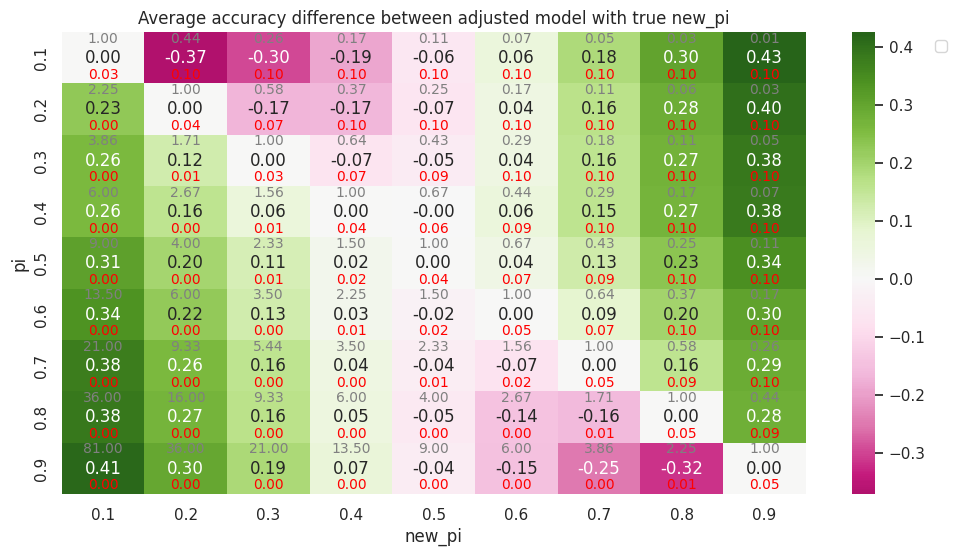

In [31]:
results_df["avg_true_accuracy_diff"] = results_df["avg_true_shifted_accuracy"] - results_df["avg_accuracy"]

# conf matrix pi vs new_pi - avg acc diff
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plt.title("Average accuracy difference between adjusted model with true new_pi")
sns.heatmap(results_df.pivot(index="pi", columns="new_pi", values="avg_true_accuracy_diff"), annot=True, fmt=".2f", 
    cmap= "PiYG",
    vmin= min(results_df["avg_true_accuracy_diff"]),
    vmax= max(results_df["avg_true_accuracy_diff"]),
    center=0)

for i, pi in enumerate(PI_LIST):
    for j, pi_new in enumerate(PI_LIST):
        plt.text(j+0.5, i+0.2, f'{results_df[results_df["pi"] == pi][results_df["new_pi"] == pi_new]["true_pi_treshold"].values[0]:.2f}', ha="center", color="grey", fontsize=10, label="True treshold")
for i, pi in enumerate(PI_LIST):
    for j, pi_new in enumerate(PI_LIST):
        plt.text(j+0.5, i+0.9, f'{results_df[results_df["pi"] == pi][results_df["new_pi"] == pi_new]["avg_true_shifted_pos_fraction"].values[0]:.2f}', ha="center", color="red", fontsize=10, label="Positive fraction")

# add legend for text labels and colors - create it manually
plt.legend(["True treshold", "Positive fraction"], loc="upper right", bbox_to_anchor=(1.2, 1))
plt.show()


/tmp/ipykernel_521298/733330391.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.text(j+0.5, i+0.2, f'{results_df[results_df["pi"] == pi][results_df["new_pi"] == pi_new]["avg_treshold"].values[0]:.2f}', ha="center", color="grey", fontsize=10)
/tmp/ipykernel_521298/733330391.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.text(j+0.5, i+0.2, f'{results_df[results_df["pi"] == pi][results_df["new_pi"] == pi_new]["avg_treshold"].values[0]:.2f}', ha="center", color="grey", fontsize=10)
/tmp/ipykernel_521298/733330391.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.text(j+0.5, i+0.2, f'{results_df[results_df["pi"] == pi][results_df["new_pi"] == pi_new]["avg_treshold"].values[0]:.2f}', ha="center", color="grey", fontsize=10)
/tmp/ipykernel_521298/733330391.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.text(j+0.5, i+0.2, f'{results_

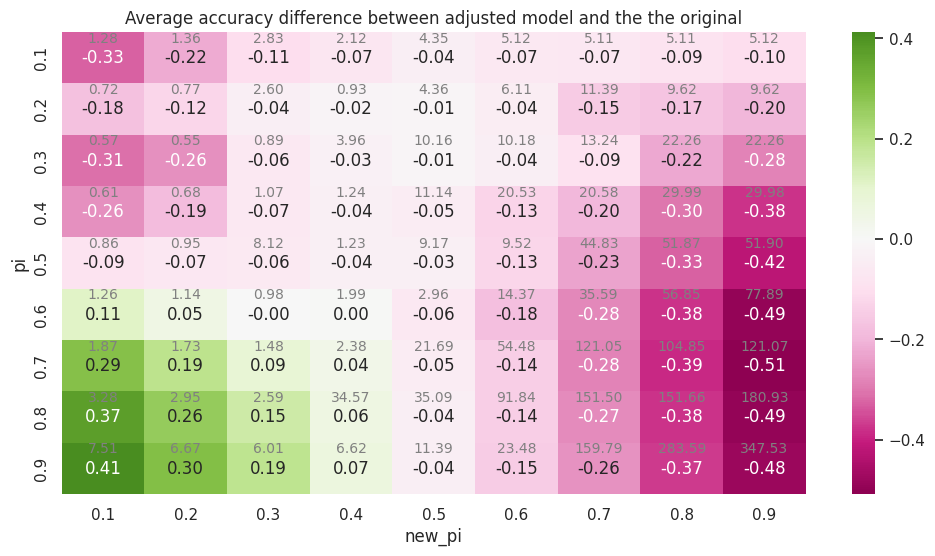

In [20]:
results_df["avg_accuracy_diff"] = results_df["avg_shifted_accuracy"] - results_df["avg_accuracy"]

# conf matrix pi vs new_pi - avg acc diff
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plt.title("Average accuracy difference between adjusted model and the the original")
sns.heatmap(results_df.pivot(index="pi", columns="new_pi", values="avg_accuracy_diff"), annot=True, fmt=".2f", 
    cmap= "PiYG",
    vmin= min(results_df["avg_accuracy_diff"]),
    vmax= max(results_df["avg_accuracy_diff"]),
    center=0)

for i, pi in enumerate(PI_LIST):
    for j, pi_new in enumerate(PI_LIST):
        plt.text(j+0.5, i+0.2, f'{results_df[results_df["pi"] == pi][results_df["new_pi"] == pi_new]["avg_treshold"].values[0]:.2f}', ha="center", color="grey", fontsize=10)

plt.show()


/tmp/ipykernel_93480/4113398159.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.text(j+0.5, i+0.2, f'{results_df[results_df["pi"] == pi][results_df["new_pi"] == pi_new]["avg_treshold"].values[0]:.2f}', ha="center", color="grey", fontsize=10)
/tmp/ipykernel_93480/4113398159.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.text(j+0.5, i+0.2, f'{results_df[results_df["pi"] == pi][results_df["new_pi"] == pi_new]["avg_treshold"].values[0]:.2f}', ha="center", color="grey", fontsize=10)
/tmp/ipykernel_93480/4113398159.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.text(j+0.5, i+0.2, f'{results_df[results_df["pi"] == pi][results_df["new_pi"] == pi_new]["avg_treshold"].values[0]:.2f}', ha="center", color="grey", fontsize=10)
/tmp/ipykernel_93480/4113398159.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.text(j+0.5, i+0.2, f'{results_

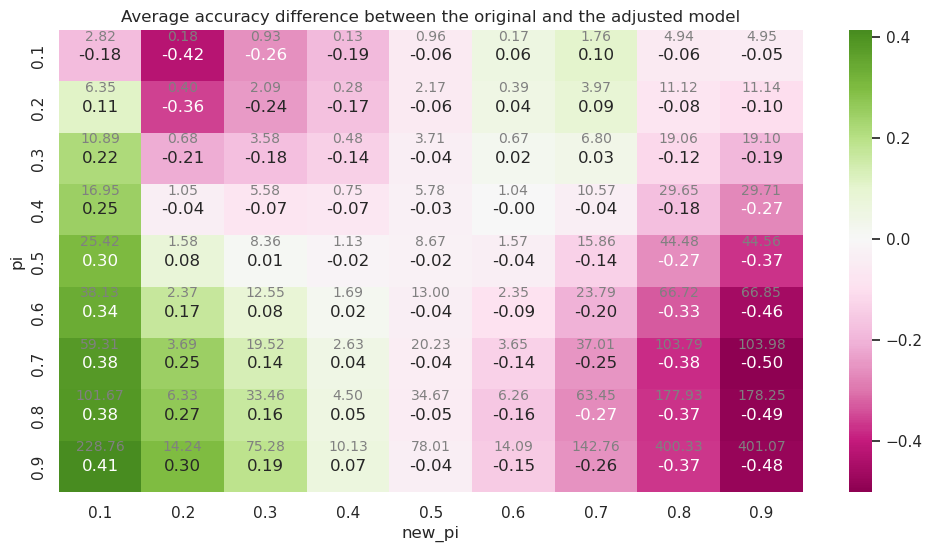

In [12]:
results_df["avg_accuracy_diff"] = results_df["avg_shifted_accuracy"] - results_df["avg_accuracy"]

# conf matrix pi vs new_pi - avg acc diff
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plt.title("Average accuracy difference between adjusted model and the the original")
sns.heatmap(results_df.pivot(index="pi", columns="new_pi", values="avg_accuracy_diff"), annot=True, fmt=".2f", 
    cmap= "PiYG",
    vmin= min(results_df["avg_accuracy_diff"]),
    vmax= max(results_df["avg_accuracy_diff"]),
    center=0)

for i, pi in enumerate(PI_LIST):
    for j, pi_new in enumerate(PI_LIST):
        plt.text(j+0.5, i+0.2, f'{results_df[results_df["pi"] == pi][results_df["new_pi"] == pi_new]["avg_treshold"].values[0]:.2f}', ha="center", color="grey", fontsize=10)

plt.show()
